In [1]:
import numpy as np
import pandas as pd
import scanpy.api as sc
import anndata



import os
import scipy
from scipy import sparse
from numpy.random import randn
from numpy.random import seed
from scipy.stats import pearsonr
import sys

from keras.layers.merge import _Merge
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import RMSprop
from functools import partial

import keras.backend as K

import matplotlib.pyplot as plt

import sys

import numpy as np

from tensorflow.python.keras.backend import set_session
from tensorflow.python.keras.models import load_model

import tensorflow as tf

from keras.models import Sequential
from keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from umap import UMAP
import seaborn as sns 
import Adam_prediction 


tf.compat.v1.disable_eager_execution()

/home/emcandrew/anaconda3/envs/tf_latest/lib/python3.7/site-packages/scanpy/api/__init__.py:7: FutureWarning: 

In a future version of Scanpy, `scanpy.api` will be removed.
Simply use `import scanpy as sc` and `import scanpy.external as sce` instead.

  FutureWarning,
Using TensorFlow backend.


In [2]:
scaler = MinMaxScaler(feature_range=(-1, 1))

exp_mat = pd.read_csv("Gan_input_4_mg.csv", sep='\t', index_col = 0)
exp_mat = exp_mat.T

input_matrix = np.genfromtxt('Gan_input_4_mg.csv', skip_header=1)

input_matrix = input_matrix.T
input_matrix.shape


input_matrix = np.delete(input_matrix, (0), axis=0)

scaler.fit(input_matrix)
input_matrix = scaler.transform(input_matrix)


validation = input_matrix[np.random.choice(input_matrix.shape[0], 500, replace=False)]


# i  = np.random.randint(0, input_matrix[0].shape, 500)
# validation = input_matrix[i]
# input_matrix = np.delete(input_matrix, i, 0)

In [3]:
cell = input_matrix[1].shape
out_dim = cell[0]

In [4]:
cell

(2803,)

In [5]:
Generated_cells = []

In [6]:

class RandomWeightedAverage(_Merge):
    """Provides a (random) weighted average between real and generated image samples"""
    def _merge_function(self, inputs):
        alpha = K.random_uniform((32, 1, 1, 1))
        return (alpha * inputs[0]) + ((1 - alpha) * inputs[1])

class WGANGP():
    def __init__(self):
        self.cell_shape = 2803,
        self.latent_dim = 100
        self.out_dim = out_dim

        # Following parameter and optimizer set as recommended in paper
        self.n_critic = 5
        optimizer =  optimizer = RMSprop(lr=0.0005)
        
        self.generator = self.build_generator()
        self.critic = self.build_critic()
        
        # Freeze generator's layers while training critic
        self.generator.trainable = False
        
        real_cell = Input(shape=self.cell_shape)
        
        z_disc = Input(shape=(self.latent_dim,))
        # Generate image based of noise (fake sample)
        fake_cell = self.generator(z_disc)
        
        fake = self.critic(fake_cell)
        valid = self.critic(real_cell)
        
        
        # Construct weighted average between real and fake images
        interpolated_cell = RandomWeightedAverage()([real_cell, fake_cell])
        # Determine validity of weighted sample
        validity_interpolated = self.critic(interpolated_cell)
        
         # Use Python partial to provide loss function with additional
        # 'averaged_samples' argument
        partial_gp_loss = partial(self.gradient_penalty_loss,
                          averaged_samples=interpolated_cell)
        partial_gp_loss.__name__ = 'gradient_penalty' # Keras requires function names

        self.critic_model = Model(inputs=[real_cell, z_disc],
                            outputs=[valid, fake, validity_interpolated])
        self.critic_model.compile(loss=[self.wasserstein_loss,
                                              self.wasserstein_loss,
                                              partial_gp_loss],
                                        optimizer=optimizer,
                                        loss_weights=[1, 1, 10])
        
    
        # For the generator we freeze the critic's layers
        self.critic.trainable = False
        self.generator.trainable = True
        
        
        z_gen = Input(shape=(self.latent_dim,))
        # Generate images based of noise
        cell = self.generator(z_gen)
        # Discriminator determines validity
        valid = self.critic(cell)
        # Defines generator model
        self.generator_model = Model(z_gen, valid)
        self.generator_model.compile(loss=self.wasserstein_loss, optimizer=optimizer)
        
    def gradient_penalty_loss(self, y_true, y_pred, averaged_samples):
        """
        Computes gradient penalty based on prediction and weighted real / fake samples
        """
        gradients = K.gradients(y_pred, averaged_samples)[0]
        # compute the euclidean norm by squaring ...
        gradients_sqr = K.square(gradients)
        #   ... summing over the rows ...
        gradients_sqr_sum = K.sum(gradients_sqr,
                                  axis=np.arange(1, len(gradients_sqr.shape)))
        #   ... and sqrt
        gradient_l2_norm = K.sqrt(gradients_sqr_sum)
        # compute lambda * (1 - ||grad||)^2 still for each single sample
        gradient_penalty = K.square(1 - gradient_l2_norm)
        # return the mean as loss over all the batch samples
        return K.mean(gradient_penalty)
    
    def wasserstein_loss(self, y_true, y_pred):
        return K.mean(y_true * y_pred)
    
    
    def build_generator(self) :
  
      # Defines the model
      model = Sequential()
      # Adds a dense layer of 64 neurons with input_dim equal to z_dim
      model.add(Dense(128, input_dim = self.latent_dim))
      model.add(LeakyReLU(alpha=0.2))
      model.add(Dense(256))
      model.add(LeakyReLU(alpha=0.2))
      model.add(Dense(500))
      model.add(LeakyReLU(alpha=0.2))
      # Adds another fully connected layer - output layer 
      model.add(Dense(out_dim, activation = "tanh"))
      #model.add(Reshape(cell))


      model.summary()

      noise = Input(shape=(self.latent_dim,))
      cell = model(noise)

      return Model(noise, cell)

    
  # Defining the Discrimator network

    def build_critic(self) :
      model = Sequential()
      model.add(Dense(512, input_shape = self.cell_shape))
      model.add(LeakyReLU(alpha=0.2))
      model.add(Dense(256))
      model.add(LeakyReLU(alpha=0.2))
      model.add(Dense(128))
      model.add(LeakyReLU(alpha=0.2))
      model.add(Dense(1))
        
      model.summary()
    
      cell = Input(shape=self.cell_shape)
      validity = model(cell)
    
    
      return Model(cell, validity)

    def train(self, epochs, batch_size, sample_interval=50):

       # Load the dataset
       X_train = input_matrix
       
       
       # Adversarial ground truths
       valid = -np.ones((batch_size, 1))
       fake =  np.ones((batch_size, 1))
       dummy = np.zeros((batch_size, 1)) # Dummy gt for gradient penalty
       for epoch in range(epochs):

           for _ in range(self.n_critic):

               # ---------------------
               #  Train Discriminator
               # ---------------------

               # Select a random batch of images
               idx = np.random.randint(0, X_train.shape[0], batch_size)
               real_cells = X_train[idx]
               # Sample generator input
               noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
               # Train the critic
               d_loss = self.critic_model.train_on_batch([real_cells, noise],
                                                               [valid, fake, dummy])
               
           g_loss = self.generator_model.train_on_batch(noise, valid)

           # Plot the progress
           print ("%d [D loss: %f] [G loss: %f]" % (epoch, d_loss[0], g_loss))

           # If at save interval => save generated image samples
           if epoch % sample_interval == 0:
               gen_cell = self.generate_cells(5000)
               Generated_cells.append(gen_cell)
                

    def generate_cells(self, number_cells):
        z_dim = 100
        num_cells = number_cells
        noise = np.random.normal(0, 1, (1, z_dim))

        # predcts using enerator network.
        gen_cell = self.generator.predict(noise)

        # Transform back from MinMax scaling between -1 and 1 (necesscary for tanh activation function) 
        gen_cell = scaler.inverse_transform(gen_cell)


       # Repeat of above procedure inside a loop. 
        for cell in range(num_cells -1 ):

                noise = np.random.normal(0, 1, (1, z_dim))

                gen_cells_tmp = self.generator.predict(noise)

                gen_cells_tmp = scaler.inverse_transform(gen_cells_tmp)

              #  Appends subsequent generated cells to form an array of generated cells
                gen_cell = np.append(gen_cell, gen_cells_tmp, axis=0)

        # Converts array to matrice object
        gen_cell = np.asmatrix(gen_cell)

        # converts matrice to pandas dataframe
        gen_cell = pd.DataFrame(gen_cell)

        # Loop to create cell names (theres deinitely a better way to do this)
        cell_names = []
        for i in range(num_cells ):
            cell_names.append("cell-{}".format(i +1))


        # Creates final dataframe with gene names and cell IDs
        gen_cell = pd.DataFrame(data=gen_cell.values, columns=exp_mat.columns, index = cell_names)

        return gen_cell


In [7]:

if __name__ == '__main__':
    wgan = WGANGP()
    wgan.train(epochs=2000200, batch_size=32, sample_interval=10000)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               12928     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               33024     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 500)               128500    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 500)               0         
_______________________________________

125 [D loss: 0.175397] [G loss: -1.315363]
126 [D loss: 0.979699] [G loss: -0.897819]
127 [D loss: 0.172894] [G loss: -1.015527]
128 [D loss: 0.708024] [G loss: -0.722393]
129 [D loss: 0.369509] [G loss: -1.315128]
130 [D loss: 0.011700] [G loss: -3.195014]
131 [D loss: 2.848425] [G loss: 0.612079]
132 [D loss: -0.290548] [G loss: 2.792582]
133 [D loss: -0.068993] [G loss: 0.502957]
134 [D loss: -0.019672] [G loss: -0.962542]
135 [D loss: 0.216758] [G loss: -0.000105]
136 [D loss: 1.620751] [G loss: -0.721823]
137 [D loss: 0.173263] [G loss: -0.350407]
138 [D loss: 0.540101] [G loss: -5.285777]
139 [D loss: 1.395871] [G loss: 2.362623]
140 [D loss: -0.187095] [G loss: 0.779782]
141 [D loss: 0.362796] [G loss: 0.041193]
142 [D loss: -0.032571] [G loss: -0.981666]
143 [D loss: 0.609173] [G loss: 7.754504]
144 [D loss: 0.070679] [G loss: -0.393715]
145 [D loss: -0.029532] [G loss: 0.042446]
146 [D loss: 0.178525] [G loss: 0.060256]
147 [D loss: 0.569544] [G loss: 0.122843]
148 [D loss: 0.

317 [D loss: -0.214924] [G loss: -2.252051]
318 [D loss: -0.032537] [G loss: 1.874320]
319 [D loss: -0.334324] [G loss: -1.740080]
320 [D loss: 0.511919] [G loss: 1.482566]
321 [D loss: -0.264409] [G loss: -0.944961]
322 [D loss: 0.571082] [G loss: 0.505146]
323 [D loss: -0.164405] [G loss: 0.351301]
324 [D loss: -0.111918] [G loss: 0.932023]
325 [D loss: -0.239234] [G loss: -1.233926]
326 [D loss: -0.229444] [G loss: 0.400058]
327 [D loss: -0.155016] [G loss: -2.185330]
328 [D loss: -0.259374] [G loss: 1.187964]
329 [D loss: -0.148442] [G loss: -0.936230]
330 [D loss: -0.411642] [G loss: -1.463540]
331 [D loss: 0.304498] [G loss: 1.618194]
332 [D loss: -0.229803] [G loss: 2.896602]
333 [D loss: -0.218596] [G loss: -1.236071]
334 [D loss: -0.000521] [G loss: -0.378472]
335 [D loss: -0.226982] [G loss: -0.730291]
336 [D loss: 1.326798] [G loss: 1.388180]
337 [D loss: -0.134231] [G loss: 1.016002]
338 [D loss: 0.617049] [G loss: 1.045685]
339 [D loss: 0.414353] [G loss: 0.062061]
340 [D 

508 [D loss: 0.806323] [G loss: 0.330682]
509 [D loss: 0.245277] [G loss: -0.452996]
510 [D loss: 1.758775] [G loss: -0.946127]
511 [D loss: -0.169811] [G loss: -0.800182]
512 [D loss: 0.246294] [G loss: -1.510073]
513 [D loss: 0.101038] [G loss: -0.316229]
514 [D loss: 0.579012] [G loss: 4.220912]
515 [D loss: -0.064189] [G loss: 1.724435]
516 [D loss: -0.427097] [G loss: -0.673256]
517 [D loss: 0.695070] [G loss: 0.018646]
518 [D loss: 0.150573] [G loss: -0.203603]
519 [D loss: 0.872360] [G loss: 0.160437]
520 [D loss: -0.271516] [G loss: -1.528559]
521 [D loss: -0.046991] [G loss: -0.134349]
522 [D loss: -0.088551] [G loss: 2.992093]
523 [D loss: 0.390445] [G loss: 0.472191]
524 [D loss: 0.035249] [G loss: -0.175020]
525 [D loss: -0.029594] [G loss: -0.454290]
526 [D loss: 0.813934] [G loss: 2.779762]
527 [D loss: 0.594856] [G loss: -1.631573]
528 [D loss: 0.873030] [G loss: 0.273023]
529 [D loss: 0.043417] [G loss: -0.237897]
530 [D loss: -0.205640] [G loss: -1.348538]
531 [D loss:

699 [D loss: 0.105090] [G loss: 3.171788]
700 [D loss: -0.114664] [G loss: 0.621568]
701 [D loss: 0.142901] [G loss: 3.202855]
702 [D loss: -0.457560] [G loss: -0.461561]
703 [D loss: -0.113796] [G loss: -1.937945]
704 [D loss: -0.046905] [G loss: -0.725737]
705 [D loss: 0.118149] [G loss: -0.777706]
706 [D loss: -0.020383] [G loss: 0.174156]
707 [D loss: 0.505315] [G loss: -1.816790]
708 [D loss: 0.151325] [G loss: 0.726641]
709 [D loss: -0.047617] [G loss: 0.690415]
710 [D loss: 0.402624] [G loss: 0.050378]
711 [D loss: -0.046774] [G loss: -0.103803]
712 [D loss: -0.271963] [G loss: -2.027688]
713 [D loss: 0.843060] [G loss: 1.073751]
714 [D loss: 0.101454] [G loss: 1.330279]
715 [D loss: -0.209572] [G loss: 2.095640]
716 [D loss: 0.724324] [G loss: -3.065683]
717 [D loss: -0.097479] [G loss: 0.238511]
718 [D loss: -0.281427] [G loss: 1.977980]
719 [D loss: 0.210072] [G loss: 0.198034]
720 [D loss: 0.399326] [G loss: -2.105437]
721 [D loss: 0.052385] [G loss: -0.232536]
722 [D loss: 

891 [D loss: 0.501801] [G loss: -0.202452]
892 [D loss: -0.128133] [G loss: -0.854398]
893 [D loss: 0.058204] [G loss: -1.025591]
894 [D loss: -0.034757] [G loss: -0.043004]
895 [D loss: -0.072187] [G loss: 1.244140]
896 [D loss: -0.017207] [G loss: -0.119894]
897 [D loss: 0.415671] [G loss: 3.688249]
898 [D loss: -0.037267] [G loss: 0.933578]
899 [D loss: -0.017082] [G loss: -0.651347]
900 [D loss: -0.046173] [G loss: -0.824144]
901 [D loss: 0.037822] [G loss: -1.439628]
902 [D loss: 0.054269] [G loss: -0.718180]
903 [D loss: 0.285730] [G loss: -0.308789]
904 [D loss: -0.073990] [G loss: -0.008562]
905 [D loss: 0.912821] [G loss: 4.332858]
906 [D loss: -0.004166] [G loss: -0.579386]
907 [D loss: 0.179935] [G loss: -2.143920]
908 [D loss: -0.098870] [G loss: -1.303570]
909 [D loss: 0.329069] [G loss: 0.503251]
910 [D loss: 0.055257] [G loss: -0.582405]
911 [D loss: 0.481419] [G loss: 0.755786]
912 [D loss: -0.042975] [G loss: -0.395148]
913 [D loss: 0.323254] [G loss: 2.146851]
914 [D 

1080 [D loss: 0.025871] [G loss: -0.036799]
1081 [D loss: -0.108108] [G loss: -0.605024]
1082 [D loss: 0.957878] [G loss: 2.820340]
1083 [D loss: -0.319671] [G loss: -0.002720]
1084 [D loss: -0.340608] [G loss: -0.466297]
1085 [D loss: 0.000964] [G loss: -1.894014]
1086 [D loss: -0.136767] [G loss: -0.448325]
1087 [D loss: -0.273406] [G loss: -1.399783]
1088 [D loss: 1.431230] [G loss: 0.353264]
1089 [D loss: 0.037543] [G loss: -0.543469]
1090 [D loss: -0.176381] [G loss: -3.205210]
1091 [D loss: 1.760288] [G loss: 0.280436]
1092 [D loss: -0.147671] [G loss: -2.069556]
1093 [D loss: -0.407538] [G loss: 0.709477]
1094 [D loss: -0.044617] [G loss: -0.484260]
1095 [D loss: -0.020466] [G loss: 0.165494]
1096 [D loss: -0.257313] [G loss: 2.144695]
1097 [D loss: 0.539486] [G loss: -0.234851]
1098 [D loss: 0.669863] [G loss: -1.350849]
1099 [D loss: 0.314915] [G loss: -0.739438]
1100 [D loss: -0.043635] [G loss: -0.784471]
1101 [D loss: 0.302393] [G loss: 0.130040]
1102 [D loss: 0.789842] [G 

1266 [D loss: -0.238355] [G loss: -0.912439]
1267 [D loss: -0.031176] [G loss: 0.760984]
1268 [D loss: -0.105464] [G loss: -0.498082]
1269 [D loss: 0.058348] [G loss: -0.128490]
1270 [D loss: -0.155123] [G loss: 0.142762]
1271 [D loss: -0.248894] [G loss: -0.248073]
1272 [D loss: 0.597194] [G loss: -0.249936]
1273 [D loss: 0.048759] [G loss: -1.136906]
1274 [D loss: 0.462776] [G loss: -1.221558]
1275 [D loss: 0.848426] [G loss: -2.851479]
1276 [D loss: -0.205156] [G loss: -0.552592]
1277 [D loss: -0.192048] [G loss: 2.054285]
1278 [D loss: -0.305249] [G loss: -1.059261]
1279 [D loss: 0.019798] [G loss: -0.959203]
1280 [D loss: -0.101397] [G loss: -0.269090]
1281 [D loss: -0.236035] [G loss: -1.517834]
1282 [D loss: 0.031507] [G loss: -0.841237]
1283 [D loss: -0.136027] [G loss: -0.422101]
1284 [D loss: 0.186641] [G loss: 1.125022]
1285 [D loss: 0.373186] [G loss: 1.949757]
1286 [D loss: -0.508486] [G loss: -3.154868]
1287 [D loss: -0.128721] [G loss: 0.274684]
1288 [D loss: -0.094676] 

1451 [D loss: -0.145918] [G loss: -0.380352]
1452 [D loss: -0.274297] [G loss: -1.680255]
1453 [D loss: 0.399092] [G loss: -0.119233]
1454 [D loss: -0.078836] [G loss: -0.186811]
1455 [D loss: 0.409561] [G loss: -3.000868]
1456 [D loss: -0.076632] [G loss: -0.438907]
1457 [D loss: 0.130312] [G loss: -0.817193]
1458 [D loss: 0.117255] [G loss: 0.354011]
1459 [D loss: 0.103819] [G loss: -1.061647]
1460 [D loss: -0.120087] [G loss: -2.483700]
1461 [D loss: -0.036890] [G loss: 0.170611]
1462 [D loss: 0.224647] [G loss: -1.918319]
1463 [D loss: 0.150338] [G loss: -0.287400]
1464 [D loss: -0.029247] [G loss: -1.203264]
1465 [D loss: 0.305886] [G loss: -0.798257]
1466 [D loss: -0.117506] [G loss: -2.116768]
1467 [D loss: 0.226927] [G loss: -0.489771]
1468 [D loss: 0.021991] [G loss: -1.355567]
1469 [D loss: -0.112872] [G loss: -1.097808]
1470 [D loss: -0.146823] [G loss: 0.139439]
1471 [D loss: 0.207869] [G loss: -0.429463]
1472 [D loss: -0.031257] [G loss: -1.314947]
1473 [D loss: 0.130300] 

1636 [D loss: -0.030487] [G loss: -1.051454]
1637 [D loss: -0.133750] [G loss: -1.666371]
1638 [D loss: -0.015628] [G loss: -0.190430]
1639 [D loss: -0.029098] [G loss: -3.001324]
1640 [D loss: -0.081860] [G loss: 1.027583]
1641 [D loss: -0.164482] [G loss: 0.115413]
1642 [D loss: -0.186600] [G loss: -0.913312]
1643 [D loss: -0.160750] [G loss: -1.558676]
1644 [D loss: -0.004518] [G loss: 1.870202]
1645 [D loss: -0.166177] [G loss: -1.174045]
1646 [D loss: -0.167833] [G loss: -2.515450]
1647 [D loss: 0.014618] [G loss: -2.117420]
1648 [D loss: -0.074785] [G loss: -1.197742]
1649 [D loss: -0.126030] [G loss: -0.815944]
1650 [D loss: 0.133583] [G loss: -1.297957]
1651 [D loss: -0.166696] [G loss: 0.118444]
1652 [D loss: -0.158245] [G loss: -2.864831]
1653 [D loss: -0.042560] [G loss: -0.464849]
1654 [D loss: -0.075553] [G loss: 0.512897]
1655 [D loss: -0.133384] [G loss: -2.352935]
1656 [D loss: 0.039945] [G loss: -1.110329]
1657 [D loss: -0.121325] [G loss: -1.449658]
1658 [D loss: -0.0

1820 [D loss: -0.096402] [G loss: -1.033333]
1821 [D loss: -0.066305] [G loss: -0.962845]
1822 [D loss: -0.152656] [G loss: 0.540310]
1823 [D loss: -0.161831] [G loss: -1.450656]
1824 [D loss: -0.111047] [G loss: -0.666144]
1825 [D loss: -0.093430] [G loss: -1.011618]
1826 [D loss: -0.045553] [G loss: -1.696548]
1827 [D loss: -0.160895] [G loss: -2.443761]
1828 [D loss: -0.054524] [G loss: -0.802962]
1829 [D loss: 0.034376] [G loss: 0.149356]
1830 [D loss: -0.024368] [G loss: -0.876730]
1831 [D loss: -0.122300] [G loss: 0.397377]
1832 [D loss: -0.128388] [G loss: -0.451907]
1833 [D loss: -0.143902] [G loss: -0.691010]
1834 [D loss: -0.132639] [G loss: -2.023737]
1835 [D loss: 0.390342] [G loss: -0.651297]
1836 [D loss: -0.107380] [G loss: -0.436636]
1837 [D loss: -0.090389] [G loss: -0.880201]
1838 [D loss: -0.171703] [G loss: -0.609662]
1839 [D loss: -0.262369] [G loss: -0.219666]
1840 [D loss: -0.173500] [G loss: -0.747419]
1841 [D loss: -0.066382] [G loss: -1.445211]
1842 [D loss: -

2004 [D loss: 0.041017] [G loss: -1.222859]
2005 [D loss: -0.123618] [G loss: -0.380022]
2006 [D loss: 0.320486] [G loss: -0.712567]
2007 [D loss: -0.072313] [G loss: -0.745535]
2008 [D loss: 0.091734] [G loss: -1.066529]
2009 [D loss: -0.125748] [G loss: -1.972086]
2010 [D loss: 0.025505] [G loss: -0.339536]
2011 [D loss: -0.161644] [G loss: -1.209089]
2012 [D loss: -0.176437] [G loss: 0.855758]
2013 [D loss: 0.034635] [G loss: -0.570714]
2014 [D loss: -0.072319] [G loss: 0.176424]
2015 [D loss: 0.076015] [G loss: -0.385534]
2016 [D loss: -0.084906] [G loss: -0.936697]
2017 [D loss: -0.064129] [G loss: -1.139073]
2018 [D loss: -0.094799] [G loss: 0.498801]
2019 [D loss: 0.038452] [G loss: -0.544342]
2020 [D loss: -0.069043] [G loss: 0.336780]
2021 [D loss: 0.018782] [G loss: -1.340164]
2022 [D loss: -0.065817] [G loss: 0.757049]
2023 [D loss: 0.151478] [G loss: -0.476648]
2024 [D loss: 0.038824] [G loss: -0.597072]
2025 [D loss: -0.072748] [G loss: 0.365174]
2026 [D loss: 0.062546] [G

2189 [D loss: -0.082519] [G loss: -1.172634]
2190 [D loss: -0.158600] [G loss: 0.253777]
2191 [D loss: -0.103660] [G loss: -1.137408]
2192 [D loss: -0.019413] [G loss: -0.557471]
2193 [D loss: -0.106090] [G loss: -0.241270]
2194 [D loss: -0.158917] [G loss: 1.124296]
2195 [D loss: -0.212540] [G loss: -1.684763]
2196 [D loss: -0.115661] [G loss: -0.477207]
2197 [D loss: -0.140334] [G loss: -1.794048]
2198 [D loss: 0.050541] [G loss: 0.757755]
2199 [D loss: -0.134128] [G loss: -0.219908]
2200 [D loss: 0.113742] [G loss: -0.535835]
2201 [D loss: -0.125673] [G loss: -1.239232]
2202 [D loss: -0.122205] [G loss: 0.340239]
2203 [D loss: -0.041628] [G loss: -2.911972]
2204 [D loss: -0.027717] [G loss: 0.081076]
2205 [D loss: -0.085594] [G loss: -0.172242]
2206 [D loss: -0.129806] [G loss: 0.369622]
2207 [D loss: -0.058193] [G loss: -0.678760]
2208 [D loss: -0.076418] [G loss: 0.652341]
2209 [D loss: 0.021280] [G loss: -0.575514]
2210 [D loss: -0.141902] [G loss: -0.651332]
2211 [D loss: -0.074

2373 [D loss: -0.032473] [G loss: -1.333528]
2374 [D loss: -0.187758] [G loss: 0.189677]
2375 [D loss: -0.153001] [G loss: -0.601428]
2376 [D loss: 0.028458] [G loss: -0.270589]
2377 [D loss: -0.049884] [G loss: -1.035797]
2378 [D loss: -0.050633] [G loss: 0.453319]
2379 [D loss: -0.128976] [G loss: -2.289469]
2380 [D loss: 0.008742] [G loss: 0.709915]
2381 [D loss: -0.111935] [G loss: -0.438292]
2382 [D loss: -0.128433] [G loss: -0.661794]
2383 [D loss: -0.097905] [G loss: 0.353699]
2384 [D loss: -0.060620] [G loss: 0.031768]
2385 [D loss: -0.063468] [G loss: -0.709793]
2386 [D loss: -0.128384] [G loss: -0.726831]
2387 [D loss: -0.080617] [G loss: -0.884904]
2388 [D loss: -0.129410] [G loss: -0.925218]
2389 [D loss: -0.131522] [G loss: -0.117279]
2390 [D loss: -0.080367] [G loss: -0.284667]
2391 [D loss: -0.136128] [G loss: -0.684477]
2392 [D loss: -0.093640] [G loss: -0.224170]
2393 [D loss: -0.006880] [G loss: -1.033490]
2394 [D loss: 0.181658] [G loss: -0.054431]
2395 [D loss: -0.2

2557 [D loss: -0.109408] [G loss: -0.975847]
2558 [D loss: -0.009832] [G loss: -1.318217]
2559 [D loss: -0.058539] [G loss: 0.230402]
2560 [D loss: -0.149795] [G loss: -1.423753]
2561 [D loss: -0.187138] [G loss: 0.099538]
2562 [D loss: -0.073378] [G loss: -0.409846]
2563 [D loss: -0.012412] [G loss: 0.197143]
2564 [D loss: -0.236741] [G loss: -0.149566]
2565 [D loss: -0.061387] [G loss: 0.353194]
2566 [D loss: -0.091973] [G loss: -1.233003]
2567 [D loss: -0.065547] [G loss: 0.420942]
2568 [D loss: -0.071265] [G loss: -0.263093]
2569 [D loss: -0.097953] [G loss: -0.398084]
2570 [D loss: -0.105988] [G loss: -0.272206]
2571 [D loss: -0.136638] [G loss: -2.501419]
2572 [D loss: -0.180551] [G loss: 0.451024]
2573 [D loss: -0.071715] [G loss: 0.420171]
2574 [D loss: 0.127167] [G loss: -0.604650]
2575 [D loss: -0.051287] [G loss: -0.886269]
2576 [D loss: -0.147155] [G loss: -1.438446]
2577 [D loss: -0.039933] [G loss: -0.026877]
2578 [D loss: -0.222357] [G loss: -0.208889]
2579 [D loss: 0.01

2741 [D loss: -0.093940] [G loss: -0.514799]
2742 [D loss: -0.125228] [G loss: -1.136297]
2743 [D loss: -0.119003] [G loss: -1.403479]
2744 [D loss: -0.169440] [G loss: -0.046800]
2745 [D loss: -0.172833] [G loss: 0.218824]
2746 [D loss: -0.094781] [G loss: -0.205993]
2747 [D loss: -0.118160] [G loss: -1.318561]
2748 [D loss: -0.070274] [G loss: -0.349906]
2749 [D loss: -0.053199] [G loss: -0.615393]
2750 [D loss: -0.228520] [G loss: 0.029784]
2751 [D loss: -0.067356] [G loss: 0.488309]
2752 [D loss: -0.074702] [G loss: -1.029495]
2753 [D loss: -0.085993] [G loss: -1.044903]
2754 [D loss: -0.027452] [G loss: 0.227317]
2755 [D loss: -0.104912] [G loss: -0.896226]
2756 [D loss: 0.160996] [G loss: -0.374693]
2757 [D loss: -0.169815] [G loss: -2.433089]
2758 [D loss: -0.051969] [G loss: -0.990753]
2759 [D loss: -0.071234] [G loss: 0.211327]
2760 [D loss: -0.089638] [G loss: -0.539712]
2761 [D loss: -0.035848] [G loss: -0.016767]
2762 [D loss: -0.161636] [G loss: -1.364402]
2763 [D loss: -0

2925 [D loss: 0.428083] [G loss: 0.736529]
2926 [D loss: -0.123787] [G loss: -1.102946]
2927 [D loss: -0.191505] [G loss: 0.046767]
2928 [D loss: -0.055900] [G loss: -0.680165]
2929 [D loss: -0.052729] [G loss: -1.652860]
2930 [D loss: -0.080509] [G loss: 0.278103]
2931 [D loss: -0.109814] [G loss: 0.144899]
2932 [D loss: -0.091275] [G loss: 0.027339]
2933 [D loss: -0.084118] [G loss: -0.395180]
2934 [D loss: -0.065321] [G loss: -0.281895]
2935 [D loss: -0.085747] [G loss: -0.899685]
2936 [D loss: -0.028917] [G loss: -0.156068]
2937 [D loss: -0.077751] [G loss: -0.422715]
2938 [D loss: -0.009649] [G loss: -0.623874]
2939 [D loss: -0.152308] [G loss: -1.234704]
2940 [D loss: -0.116970] [G loss: -0.187421]
2941 [D loss: -0.023848] [G loss: -1.082899]
2942 [D loss: -0.020196] [G loss: -0.490016]
2943 [D loss: -0.149453] [G loss: 0.757732]
2944 [D loss: -0.078012] [G loss: -0.164495]
2945 [D loss: -0.060954] [G loss: 0.594511]
2946 [D loss: -0.119007] [G loss: -1.842871]
2947 [D loss: -0.0

3109 [D loss: -0.212029] [G loss: 1.682647]
3110 [D loss: -0.108618] [G loss: -0.685706]
3111 [D loss: -0.148767] [G loss: -2.637471]
3112 [D loss: 0.015746] [G loss: -0.197430]
3113 [D loss: -0.105845] [G loss: -0.598604]
3114 [D loss: -0.022521] [G loss: -0.968523]
3115 [D loss: -0.117315] [G loss: -0.504341]
3116 [D loss: 0.125440] [G loss: -1.116897]
3117 [D loss: -0.076152] [G loss: 0.445231]
3118 [D loss: -0.010401] [G loss: -0.241833]
3119 [D loss: -0.053436] [G loss: -2.115275]
3120 [D loss: -0.050601] [G loss: 0.127414]
3121 [D loss: -0.086554] [G loss: 1.252661]
3122 [D loss: -0.090824] [G loss: -1.403323]
3123 [D loss: -0.123558] [G loss: -2.866744]
3124 [D loss: -0.005737] [G loss: -0.182158]
3125 [D loss: -0.091160] [G loss: 0.660057]
3126 [D loss: -0.000539] [G loss: -0.928553]
3127 [D loss: -0.152326] [G loss: -1.037847]
3128 [D loss: -0.078191] [G loss: -0.194506]
3129 [D loss: -0.009583] [G loss: -1.029886]
3130 [D loss: -0.009126] [G loss: -1.136697]
3131 [D loss: -0.

3293 [D loss: -0.040846] [G loss: -0.411655]
3294 [D loss: -0.119783] [G loss: -1.191420]
3295 [D loss: -0.100633] [G loss: 0.243177]
3296 [D loss: -0.053836] [G loss: -0.825443]
3297 [D loss: -0.045867] [G loss: -0.429679]
3298 [D loss: -0.121653] [G loss: -1.048057]
3299 [D loss: -0.158023] [G loss: -0.488792]
3300 [D loss: -0.126644] [G loss: -2.755697]
3301 [D loss: -0.074137] [G loss: 0.534997]
3302 [D loss: -0.090301] [G loss: 2.143735]
3303 [D loss: -0.102944] [G loss: -0.110082]
3304 [D loss: 0.043624] [G loss: -0.896157]
3305 [D loss: -0.076336] [G loss: -0.698500]
3306 [D loss: -0.156123] [G loss: -0.455258]
3307 [D loss: -0.167747] [G loss: -1.030439]
3308 [D loss: 0.031222] [G loss: -2.336865]
3309 [D loss: -0.077332] [G loss: -0.447695]
3310 [D loss: -0.067518] [G loss: -0.417030]
3311 [D loss: -0.128063] [G loss: -0.993329]
3312 [D loss: -0.089515] [G loss: 0.186298]
3313 [D loss: -0.039267] [G loss: -0.608874]
3314 [D loss: -0.103489] [G loss: -1.229606]
3315 [D loss: -0

3477 [D loss: -0.162192] [G loss: 0.535986]
3478 [D loss: 0.093356] [G loss: 0.082130]
3479 [D loss: 0.025923] [G loss: -0.528894]
3480 [D loss: 0.043117] [G loss: -1.843337]
3481 [D loss: -0.090789] [G loss: -0.429281]
3482 [D loss: 0.044129] [G loss: -0.596450]
3483 [D loss: -0.084500] [G loss: -1.497704]
3484 [D loss: -0.050477] [G loss: 0.099330]
3485 [D loss: -0.087813] [G loss: -1.447055]
3486 [D loss: 0.027973] [G loss: -1.045064]
3487 [D loss: -0.016734] [G loss: -0.745597]
3488 [D loss: -0.097773] [G loss: 0.418384]
3489 [D loss: -0.033598] [G loss: -0.944113]
3490 [D loss: 0.013633] [G loss: -1.253743]
3491 [D loss: -0.104964] [G loss: 0.001784]
3492 [D loss: 0.197266] [G loss: -0.971171]
3493 [D loss: -0.124794] [G loss: -1.971377]
3494 [D loss: -0.123451] [G loss: 0.310659]
3495 [D loss: 0.015069] [G loss: -0.359395]
3496 [D loss: -0.176428] [G loss: -1.052669]
3497 [D loss: -0.018231] [G loss: -0.643660]
3498 [D loss: -0.039497] [G loss: -0.471142]
3499 [D loss: -0.043405]

3661 [D loss: -0.053799] [G loss: -0.055657]
3662 [D loss: 0.029176] [G loss: -0.653022]
3663 [D loss: -0.230683] [G loss: -1.650607]
3664 [D loss: -0.076899] [G loss: -0.283238]
3665 [D loss: -0.062826] [G loss: 0.087434]
3666 [D loss: 0.029942] [G loss: 0.176386]
3667 [D loss: -0.064347] [G loss: -0.721143]
3668 [D loss: -0.049588] [G loss: -0.378422]
3669 [D loss: -0.037146] [G loss: -1.476219]
3670 [D loss: -0.046252] [G loss: -0.121664]
3671 [D loss: 0.058534] [G loss: -1.204545]
3672 [D loss: -0.092187] [G loss: -0.004076]
3673 [D loss: 0.043316] [G loss: -0.467327]
3674 [D loss: -0.074862] [G loss: -0.220227]
3675 [D loss: 0.089232] [G loss: -1.058475]
3676 [D loss: -0.119427] [G loss: -0.650709]
3677 [D loss: -0.059281] [G loss: -0.283681]
3678 [D loss: -0.082770] [G loss: 0.569199]
3679 [D loss: -0.211344] [G loss: -1.392481]
3680 [D loss: -0.033691] [G loss: -1.055429]
3681 [D loss: -0.064446] [G loss: -0.718027]
3682 [D loss: -0.141457] [G loss: -0.428491]
3683 [D loss: -0.0

3845 [D loss: -0.126270] [G loss: 0.056913]
3846 [D loss: -0.053651] [G loss: -0.050426]
3847 [D loss: 0.175176] [G loss: -0.562300]
3848 [D loss: -0.010369] [G loss: -2.229901]
3849 [D loss: -0.129151] [G loss: -0.958363]
3850 [D loss: -0.071693] [G loss: -0.803562]
3851 [D loss: -0.075266] [G loss: -0.493967]
3852 [D loss: -0.062037] [G loss: -1.512474]
3853 [D loss: -0.097603] [G loss: -0.278350]
3854 [D loss: -0.032789] [G loss: 0.003645]
3855 [D loss: -0.119474] [G loss: -1.347793]
3856 [D loss: -0.008697] [G loss: -0.356330]
3857 [D loss: 0.019242] [G loss: -1.328428]
3858 [D loss: -0.023191] [G loss: -0.750721]
3859 [D loss: -0.139672] [G loss: 0.091314]
3860 [D loss: -0.012957] [G loss: -0.885881]
3861 [D loss: -0.102654] [G loss: 0.981896]
3862 [D loss: -0.077045] [G loss: -0.658048]
3863 [D loss: 0.045178] [G loss: -1.569497]
3864 [D loss: 0.011214] [G loss: -0.322209]
3865 [D loss: -0.142909] [G loss: -0.900668]
3866 [D loss: 0.019622] [G loss: -1.253666]
3867 [D loss: -0.12

4029 [D loss: 0.103422] [G loss: -0.403386]
4030 [D loss: -0.167198] [G loss: -1.155054]
4031 [D loss: -0.055218] [G loss: -0.892172]
4032 [D loss: -0.095125] [G loss: 0.269916]
4033 [D loss: 0.037725] [G loss: -0.189611]
4034 [D loss: -0.023264] [G loss: -0.768757]
4035 [D loss: -0.094610] [G loss: -0.825575]
4036 [D loss: -0.036253] [G loss: -0.604890]
4037 [D loss: -0.157716] [G loss: -0.606145]
4038 [D loss: -0.082314] [G loss: -0.099957]
4039 [D loss: -0.124403] [G loss: 0.276308]
4040 [D loss: -0.078004] [G loss: -0.340032]
4041 [D loss: -0.020720] [G loss: -0.678580]
4042 [D loss: -0.194356] [G loss: -1.104522]
4043 [D loss: 0.076454] [G loss: -0.783018]
4044 [D loss: 0.046221] [G loss: -0.246119]
4045 [D loss: -0.100845] [G loss: -0.652541]
4046 [D loss: -0.102519] [G loss: -1.349685]
4047 [D loss: 0.019535] [G loss: -0.859122]
4048 [D loss: -0.074876] [G loss: 0.074373]
4049 [D loss: -0.007889] [G loss: -0.730669]
4050 [D loss: 0.004609] [G loss: -1.564346]
4051 [D loss: -0.13

4213 [D loss: 0.000988] [G loss: -0.558595]
4214 [D loss: -0.024149] [G loss: -0.724869]
4215 [D loss: -0.045613] [G loss: -1.112541]
4216 [D loss: -0.161799] [G loss: -0.878677]
4217 [D loss: -0.079892] [G loss: -0.718167]
4218 [D loss: -0.063304] [G loss: -0.266293]
4219 [D loss: -0.054634] [G loss: -0.790489]
4220 [D loss: -0.065661] [G loss: -0.455851]
4221 [D loss: -0.003398] [G loss: -0.205487]
4222 [D loss: 0.021100] [G loss: -0.102630]
4223 [D loss: -0.083505] [G loss: -3.386170]
4224 [D loss: -0.089849] [G loss: -0.327275]
4225 [D loss: -0.035334] [G loss: 0.103501]
4226 [D loss: -0.054142] [G loss: -0.692929]
4227 [D loss: -0.034412] [G loss: -0.557056]
4228 [D loss: -0.034078] [G loss: -0.982362]
4229 [D loss: -0.029189] [G loss: -1.436007]
4230 [D loss: -0.159090] [G loss: 0.171568]
4231 [D loss: -0.111399] [G loss: -0.723504]
4232 [D loss: -0.037466] [G loss: 0.201558]
4233 [D loss: -0.148074] [G loss: -0.745721]
4234 [D loss: -0.109751] [G loss: -0.135231]
4235 [D loss: -

4397 [D loss: -0.012525] [G loss: -0.445950]
4398 [D loss: -0.066758] [G loss: -0.488819]
4399 [D loss: -0.018374] [G loss: -0.756157]
4400 [D loss: -0.115495] [G loss: -0.051854]
4401 [D loss: -0.097591] [G loss: -0.428856]
4402 [D loss: -0.163030] [G loss: -0.790815]
4403 [D loss: -0.088047] [G loss: -0.014757]
4404 [D loss: -0.003804] [G loss: -1.192190]
4405 [D loss: 0.027419] [G loss: -0.551126]
4406 [D loss: -0.120554] [G loss: -1.171424]
4407 [D loss: 0.064391] [G loss: -0.733105]
4408 [D loss: -0.068886] [G loss: -1.373985]
4409 [D loss: -0.166058] [G loss: -0.222468]
4410 [D loss: 0.057439] [G loss: -0.427302]
4411 [D loss: -0.138341] [G loss: -0.498284]
4412 [D loss: -0.086983] [G loss: -0.933530]
4413 [D loss: -0.139217] [G loss: -0.572666]
4414 [D loss: -0.026582] [G loss: 0.346621]
4415 [D loss: -0.107248] [G loss: -0.903191]
4416 [D loss: 0.028191] [G loss: -1.432030]
4417 [D loss: -0.078431] [G loss: -0.012991]
4418 [D loss: -0.027802] [G loss: -0.252386]
4419 [D loss: -

4581 [D loss: -0.073923] [G loss: 0.040217]
4582 [D loss: -0.044180] [G loss: -0.394766]
4583 [D loss: -0.176612] [G loss: -1.253278]
4584 [D loss: -0.021529] [G loss: -0.773309]
4585 [D loss: -0.013910] [G loss: -0.308138]
4586 [D loss: -0.167820] [G loss: 0.329318]
4587 [D loss: -0.111681] [G loss: 0.122404]
4588 [D loss: -0.036066] [G loss: -0.425125]
4589 [D loss: -0.029855] [G loss: -0.702661]
4590 [D loss: -0.067351] [G loss: -0.533761]
4591 [D loss: -0.125772] [G loss: -0.320064]
4592 [D loss: 0.131526] [G loss: -0.661203]
4593 [D loss: -0.071828] [G loss: -1.231734]
4594 [D loss: -0.161731] [G loss: -0.284770]
4595 [D loss: -0.131529] [G loss: -2.042039]
4596 [D loss: -0.058506] [G loss: 0.088823]
4597 [D loss: -0.064335] [G loss: 0.065137]
4598 [D loss: -0.128030] [G loss: -1.803580]
4599 [D loss: -0.073918] [G loss: -0.953671]
4600 [D loss: -0.089633] [G loss: -0.160633]
4601 [D loss: -0.121722] [G loss: 0.035286]
4602 [D loss: 0.033020] [G loss: -0.141726]
4603 [D loss: -0.0

4766 [D loss: 0.072889] [G loss: -1.066528]
4767 [D loss: -0.035467] [G loss: -0.346540]
4768 [D loss: -0.031812] [G loss: -0.349620]
4769 [D loss: 0.080037] [G loss: -0.331493]
4770 [D loss: -0.055125] [G loss: -0.369086]
4771 [D loss: -0.034752] [G loss: -0.773456]
4772 [D loss: -0.101351] [G loss: -1.182640]
4773 [D loss: 0.045765] [G loss: -1.037839]
4774 [D loss: -0.073831] [G loss: -1.426392]
4775 [D loss: -0.042825] [G loss: -0.446052]
4776 [D loss: 0.133506] [G loss: -0.218704]
4777 [D loss: -0.014226] [G loss: -0.675048]
4778 [D loss: -0.034932] [G loss: 0.080519]
4779 [D loss: -0.085465] [G loss: -1.198985]
4780 [D loss: 0.076494] [G loss: -0.983985]
4781 [D loss: -0.013178] [G loss: -0.573590]
4782 [D loss: -0.033293] [G loss: -1.338671]
4783 [D loss: -0.115294] [G loss: -0.034534]
4784 [D loss: -0.094641] [G loss: 0.664350]
4785 [D loss: -0.090427] [G loss: -0.370711]
4786 [D loss: -0.025263] [G loss: -0.942203]
4787 [D loss: -0.069577] [G loss: -0.110426]
4788 [D loss: -0.

4950 [D loss: -0.023508] [G loss: -1.218983]
4951 [D loss: -0.116539] [G loss: -0.258117]
4952 [D loss: -0.068226] [G loss: 0.382183]
4953 [D loss: -0.046070] [G loss: -0.734196]
4954 [D loss: -0.094650] [G loss: -2.167594]
4955 [D loss: -0.106139] [G loss: -0.363607]
4956 [D loss: -0.142456] [G loss: -0.357665]
4957 [D loss: -0.041219] [G loss: -0.122575]
4958 [D loss: -0.072335] [G loss: -0.635675]
4959 [D loss: -0.048834] [G loss: -0.373796]
4960 [D loss: -0.114976] [G loss: -0.888073]
4961 [D loss: -0.103801] [G loss: -0.009216]
4962 [D loss: -0.143178] [G loss: -0.228834]
4963 [D loss: 0.024738] [G loss: -0.491800]
4964 [D loss: -0.069616] [G loss: -0.887518]
4965 [D loss: -0.113398] [G loss: -0.741143]
4966 [D loss: 0.019377] [G loss: 0.065896]
4967 [D loss: -0.041122] [G loss: -0.006657]
4968 [D loss: -0.145588] [G loss: -0.829941]
4969 [D loss: -0.083522] [G loss: -1.050845]
4970 [D loss: -0.051889] [G loss: -0.507651]
4971 [D loss: -0.029216] [G loss: -0.417662]
4972 [D loss: 

5134 [D loss: -0.102424] [G loss: -0.084790]
5135 [D loss: 0.040443] [G loss: -0.175036]
5136 [D loss: -0.121537] [G loss: -0.533357]
5137 [D loss: -0.070848] [G loss: -2.179781]
5138 [D loss: -0.085474] [G loss: 0.077128]
5139 [D loss: -0.106046] [G loss: -0.238406]
5140 [D loss: -0.091258] [G loss: -1.297055]
5141 [D loss: -0.148232] [G loss: 0.213285]
5142 [D loss: -0.070069] [G loss: -0.160890]
5143 [D loss: -0.040581] [G loss: -0.638813]
5144 [D loss: -0.020975] [G loss: -1.090070]
5145 [D loss: 0.074441] [G loss: -1.108155]
5146 [D loss: -0.083418] [G loss: 0.707873]
5147 [D loss: 0.019252] [G loss: -0.394338]
5148 [D loss: -0.082532] [G loss: 0.160396]
5149 [D loss: -0.098170] [G loss: -0.304049]
5150 [D loss: -0.079382] [G loss: -0.841702]
5151 [D loss: -0.077714] [G loss: -1.742061]
5152 [D loss: -0.030372] [G loss: -1.292873]
5153 [D loss: -0.088180] [G loss: -0.245192]
5154 [D loss: -0.025453] [G loss: -1.164649]
5155 [D loss: -0.102389] [G loss: -0.454363]
5156 [D loss: 0.0

5318 [D loss: -0.078968] [G loss: 0.406942]
5319 [D loss: -0.014011] [G loss: -0.568997]
5320 [D loss: -0.048108] [G loss: -0.634843]
5321 [D loss: 0.139782] [G loss: -0.384793]
5322 [D loss: -0.109324] [G loss: -1.629534]
5323 [D loss: -0.037138] [G loss: -0.319861]
5324 [D loss: -0.036810] [G loss: -0.304141]
5325 [D loss: -0.003069] [G loss: -0.643539]
5326 [D loss: -0.108733] [G loss: 0.646744]
5327 [D loss: -0.157583] [G loss: -0.337270]
5328 [D loss: 0.059647] [G loss: -0.948722]
5329 [D loss: -0.123624] [G loss: -0.173982]
5330 [D loss: -0.071422] [G loss: -0.051599]
5331 [D loss: -0.090720] [G loss: -0.266941]
5332 [D loss: -0.090397] [G loss: -0.559214]
5333 [D loss: -0.129007] [G loss: -0.205129]
5334 [D loss: -0.137669] [G loss: -0.445432]
5335 [D loss: -0.095916] [G loss: -0.321776]
5336 [D loss: 0.026798] [G loss: -0.391622]
5337 [D loss: -0.151093] [G loss: -1.091941]
5338 [D loss: 0.005331] [G loss: -0.961490]
5339 [D loss: -0.087998] [G loss: -0.384834]
5340 [D loss: 0.

5502 [D loss: -0.104799] [G loss: -0.599251]
5503 [D loss: -0.160444] [G loss: -0.415241]
5504 [D loss: -0.057086] [G loss: -0.588285]
5505 [D loss: -0.025562] [G loss: -0.722294]
5506 [D loss: 0.013951] [G loss: -0.686474]
5507 [D loss: -0.073408] [G loss: -0.969464]
5508 [D loss: -0.087723] [G loss: -0.184963]
5509 [D loss: -0.128869] [G loss: -0.461427]
5510 [D loss: -0.046024] [G loss: -1.022957]
5511 [D loss: -0.143923] [G loss: -1.211222]
5512 [D loss: 0.053826] [G loss: -0.364009]
5513 [D loss: -0.086863] [G loss: -1.749855]
5514 [D loss: 0.024773] [G loss: -0.197416]
5515 [D loss: -0.195759] [G loss: 0.180755]
5516 [D loss: -0.171326] [G loss: 0.067814]
5517 [D loss: -0.062802] [G loss: -0.309909]
5518 [D loss: -0.101099] [G loss: -0.737697]
5519 [D loss: -0.094893] [G loss: -1.109965]
5520 [D loss: -0.193979] [G loss: -0.070246]
5521 [D loss: 0.054592] [G loss: -0.387530]
5522 [D loss: -0.102369] [G loss: -0.529390]
5523 [D loss: -0.141078] [G loss: -0.854459]
5524 [D loss: -0

5686 [D loss: -0.074203] [G loss: -0.270242]
5687 [D loss: 0.080985] [G loss: -1.496735]
5688 [D loss: -0.093264] [G loss: -0.486273]
5689 [D loss: -0.095705] [G loss: -0.181623]
5690 [D loss: -0.052371] [G loss: -0.323100]
5691 [D loss: -0.091277] [G loss: -0.082981]
5692 [D loss: -0.017331] [G loss: -0.938375]
5693 [D loss: -0.070047] [G loss: -1.379002]
5694 [D loss: 0.350119] [G loss: -0.181677]
5695 [D loss: 0.082231] [G loss: -0.294410]
5696 [D loss: -0.073712] [G loss: -0.077597]
5697 [D loss: -0.114435] [G loss: -0.934481]
5698 [D loss: -0.011738] [G loss: -0.531366]
5699 [D loss: -0.070146] [G loss: -1.624629]
5700 [D loss: -0.111016] [G loss: -0.029528]
5701 [D loss: -0.068552] [G loss: -0.630373]
5702 [D loss: -0.111011] [G loss: -0.838457]
5703 [D loss: -0.121437] [G loss: -0.064969]
5704 [D loss: -0.052852] [G loss: 0.211541]
5705 [D loss: -0.075474] [G loss: -0.300159]
5706 [D loss: -0.073378] [G loss: -0.728053]
5707 [D loss: -0.205552] [G loss: -0.248977]
5708 [D loss: 

5871 [D loss: -0.165826] [G loss: -0.786508]
5872 [D loss: 0.378812] [G loss: -0.402863]
5873 [D loss: -0.153553] [G loss: -0.985195]
5874 [D loss: -0.085561] [G loss: -1.568215]
5875 [D loss: -0.137301] [G loss: -1.354133]
5876 [D loss: 0.068576] [G loss: -1.401800]
5877 [D loss: -0.062764] [G loss: -0.919670]
5878 [D loss: 0.038716] [G loss: 0.246484]
5879 [D loss: -0.136649] [G loss: -2.476317]
5880 [D loss: -0.005904] [G loss: -1.174055]
5881 [D loss: -0.140922] [G loss: -0.348994]
5882 [D loss: -0.069046] [G loss: -1.803377]
5883 [D loss: 0.180817] [G loss: -3.395503]
5884 [D loss: -0.158087] [G loss: -0.192625]
5885 [D loss: -0.117314] [G loss: 0.250481]
5886 [D loss: -0.101548] [G loss: -1.161294]
5887 [D loss: 0.227898] [G loss: -2.452069]
5888 [D loss: -0.084582] [G loss: -1.412566]
5889 [D loss: 0.170445] [G loss: -2.154756]
5890 [D loss: -0.150955] [G loss: -1.557361]
5891 [D loss: 0.259915] [G loss: -2.147099]
5892 [D loss: -0.148414] [G loss: -1.253098]
5893 [D loss: 0.103

6056 [D loss: -0.129027] [G loss: -0.631925]
6057 [D loss: -0.110139] [G loss: -1.183425]
6058 [D loss: -0.089985] [G loss: -0.096189]
6059 [D loss: -0.128664] [G loss: 0.042308]
6060 [D loss: -0.005438] [G loss: -0.612797]
6061 [D loss: -0.070891] [G loss: -0.028360]
6062 [D loss: -0.196784] [G loss: -0.678277]
6063 [D loss: 0.036783] [G loss: -0.399777]
6064 [D loss: -0.060741] [G loss: -0.890017]
6065 [D loss: -0.143882] [G loss: -1.047147]
6066 [D loss: -0.017234] [G loss: -0.237248]
6067 [D loss: -0.103254] [G loss: 0.243348]
6068 [D loss: -0.142363] [G loss: 0.063348]
6069 [D loss: 0.170336] [G loss: -2.148409]
6070 [D loss: 0.097199] [G loss: -4.099368]
6071 [D loss: 0.107133] [G loss: -4.336563]
6072 [D loss: 0.208731] [G loss: -4.701823]
6073 [D loss: 0.208427] [G loss: -3.568498]
6074 [D loss: 0.173745] [G loss: -4.354205]
6075 [D loss: 0.139322] [G loss: -2.972642]
6076 [D loss: 0.116504] [G loss: -3.872806]
6077 [D loss: 0.090651] [G loss: -3.022750]
6078 [D loss: 0.088960]

6241 [D loss: -0.063825] [G loss: -0.514101]
6242 [D loss: -0.096504] [G loss: 0.121435]
6243 [D loss: -0.037779] [G loss: -1.099828]
6244 [D loss: 0.140655] [G loss: -2.330930]
6245 [D loss: 0.125823] [G loss: -3.221083]
6246 [D loss: 0.108036] [G loss: -2.971455]
6247 [D loss: 0.270484] [G loss: -3.391698]
6248 [D loss: 0.129501] [G loss: -3.008034]
6249 [D loss: 0.229767] [G loss: -4.092936]
6250 [D loss: 0.096059] [G loss: -2.924959]
6251 [D loss: 0.077669] [G loss: -4.285299]
6252 [D loss: -0.043636] [G loss: -2.591179]
6253 [D loss: 0.079140] [G loss: -2.474140]
6254 [D loss: 0.012163] [G loss: -2.324278]
6255 [D loss: 0.016776] [G loss: -2.018903]
6256 [D loss: 0.009455] [G loss: -2.616374]
6257 [D loss: -0.008512] [G loss: -2.800322]
6258 [D loss: 0.023491] [G loss: -1.751107]
6259 [D loss: 0.008841] [G loss: -1.782509]
6260 [D loss: -0.080752] [G loss: -1.806547]
6261 [D loss: -0.015723] [G loss: -1.793507]
6262 [D loss: -0.013470] [G loss: -1.415903]
6263 [D loss: -0.040625] 

6425 [D loss: -0.047178] [G loss: -0.419171]
6426 [D loss: -0.043040] [G loss: 0.217568]
6427 [D loss: -0.104828] [G loss: -0.911309]
6428 [D loss: -0.070412] [G loss: -1.257052]
6429 [D loss: -0.159235] [G loss: -0.475302]
6430 [D loss: -0.075122] [G loss: -0.424441]
6431 [D loss: -0.057372] [G loss: 0.095396]
6432 [D loss: -0.019487] [G loss: -0.387490]
6433 [D loss: -0.107630] [G loss: 0.166718]
6434 [D loss: 0.146227] [G loss: -0.604239]
6435 [D loss: -0.132358] [G loss: 0.452158]
6436 [D loss: -0.128035] [G loss: 0.338144]
6437 [D loss: -0.088810] [G loss: -0.483047]
6438 [D loss: -0.142954] [G loss: -0.699468]
6439 [D loss: -0.118522] [G loss: -1.391290]
6440 [D loss: 0.004192] [G loss: 1.336568]
6441 [D loss: -0.116355] [G loss: -0.916545]
6442 [D loss: -0.143768] [G loss: -1.228394]
6443 [D loss: -0.117147] [G loss: -0.314025]
6444 [D loss: -0.050606] [G loss: -1.028380]
6445 [D loss: -0.156622] [G loss: 0.663948]
6446 [D loss: -0.110181] [G loss: -0.414773]
6447 [D loss: 0.129

6609 [D loss: -0.116239] [G loss: -0.354722]
6610 [D loss: -0.080308] [G loss: 0.020606]
6611 [D loss: -0.157468] [G loss: -0.086727]
6612 [D loss: -0.040395] [G loss: 0.071667]
6613 [D loss: -0.046073] [G loss: -0.239344]
6614 [D loss: -0.067370] [G loss: -1.249681]
6615 [D loss: -0.087475] [G loss: -1.268849]
6616 [D loss: -0.147078] [G loss: -0.204664]
6617 [D loss: -0.089424] [G loss: -0.040237]
6618 [D loss: -0.135858] [G loss: -0.667050]
6619 [D loss: -0.121633] [G loss: -0.758330]
6620 [D loss: -0.144356] [G loss: 0.132298]
6621 [D loss: -0.082594] [G loss: -0.511675]
6622 [D loss: -0.124376] [G loss: -0.326628]
6623 [D loss: -0.073008] [G loss: -0.387092]
6624 [D loss: -0.060924] [G loss: -0.124537]
6625 [D loss: -0.038402] [G loss: -0.447883]
6626 [D loss: -0.108955] [G loss: -1.297488]
6627 [D loss: -0.085762] [G loss: -0.888946]
6628 [D loss: -0.151919] [G loss: 0.615468]
6629 [D loss: -0.047673] [G loss: -0.250907]
6630 [D loss: -0.097534] [G loss: -0.489960]
6631 [D loss: 

6793 [D loss: -0.079469] [G loss: -0.405232]
6794 [D loss: -0.084608] [G loss: -0.098174]
6795 [D loss: -0.062214] [G loss: -0.529237]
6796 [D loss: -0.190221] [G loss: 0.713457]
6797 [D loss: -0.131023] [G loss: -0.872877]
6798 [D loss: -0.173668] [G loss: -0.110656]
6799 [D loss: -0.086631] [G loss: -0.453382]
6800 [D loss: -0.134127] [G loss: -0.424257]
6801 [D loss: -0.059338] [G loss: -0.007438]
6802 [D loss: -0.126174] [G loss: 0.284217]
6803 [D loss: -0.198472] [G loss: -0.090129]
6804 [D loss: 0.010586] [G loss: -0.236864]
6805 [D loss: -0.182044] [G loss: -0.885317]
6806 [D loss: -0.145668] [G loss: 0.202703]
6807 [D loss: -0.085502] [G loss: -1.295375]
6808 [D loss: -0.111747] [G loss: -0.989000]
6809 [D loss: -0.109367] [G loss: -0.024832]
6810 [D loss: -0.072951] [G loss: 0.529892]
6811 [D loss: -0.203145] [G loss: -1.133752]
6812 [D loss: -0.090318] [G loss: -1.385331]
6813 [D loss: -0.071861] [G loss: -0.063199]
6814 [D loss: -0.137665] [G loss: 0.610057]
6815 [D loss: -0

6977 [D loss: 0.001838] [G loss: -0.444820]
6978 [D loss: -0.094268] [G loss: -0.300797]
6979 [D loss: -0.045206] [G loss: -0.406428]
6980 [D loss: -0.047259] [G loss: -1.023747]
6981 [D loss: -0.015293] [G loss: -0.244217]
6982 [D loss: -0.269919] [G loss: -0.133766]
6983 [D loss: 0.178975] [G loss: -0.692574]
6984 [D loss: -0.152684] [G loss: -0.828680]
6985 [D loss: 0.024385] [G loss: -1.940514]
6986 [D loss: 0.045146] [G loss: -3.259593]
6987 [D loss: 0.167794] [G loss: -3.692166]
6988 [D loss: 0.278804] [G loss: -4.225684]
6989 [D loss: 0.295236] [G loss: -3.497693]
6990 [D loss: 0.440962] [G loss: -4.198409]
6991 [D loss: 0.422577] [G loss: -2.654202]
6992 [D loss: 0.067582] [G loss: -3.641738]
6993 [D loss: 0.162230] [G loss: -1.818375]
6994 [D loss: 0.005685] [G loss: -2.264021]
6995 [D loss: -0.190777] [G loss: -1.010334]
6996 [D loss: -0.173407] [G loss: -0.001194]
6997 [D loss: -0.116628] [G loss: 0.325093]
6998 [D loss: -0.104544] [G loss: 0.269089]
6999 [D loss: -0.202577]

7161 [D loss: -0.088687] [G loss: -0.805337]
7162 [D loss: 0.143646] [G loss: -0.149989]
7163 [D loss: -0.201366] [G loss: -0.686656]
7164 [D loss: -0.056897] [G loss: -1.127567]
7165 [D loss: -0.141407] [G loss: 0.045792]
7166 [D loss: -0.023174] [G loss: -0.127417]
7167 [D loss: 0.052257] [G loss: 0.020260]
7168 [D loss: -0.030592] [G loss: 0.322681]
7169 [D loss: -0.113471] [G loss: 0.262858]
7170 [D loss: 0.058317] [G loss: -0.656963]
7171 [D loss: -0.152894] [G loss: -1.539933]
7172 [D loss: 0.053397] [G loss: -0.360626]
7173 [D loss: -0.065111] [G loss: -0.757877]
7174 [D loss: -0.020579] [G loss: -0.514040]
7175 [D loss: -0.257876] [G loss: 0.581120]
7176 [D loss: 0.417599] [G loss: -0.618360]
7177 [D loss: -0.108769] [G loss: -0.826546]
7178 [D loss: -0.099269] [G loss: -0.228612]
7179 [D loss: 0.040546] [G loss: -0.578405]
7180 [D loss: -0.115772] [G loss: -0.234128]
7181 [D loss: -0.068274] [G loss: 0.550451]
7182 [D loss: -0.091375] [G loss: -0.618793]
7183 [D loss: 0.047193

7346 [D loss: -0.080247] [G loss: -0.129589]
7347 [D loss: 0.288876] [G loss: -0.158242]
7348 [D loss: -0.088691] [G loss: 0.041857]
7349 [D loss: -0.181707] [G loss: -0.894184]
7350 [D loss: -0.058664] [G loss: -0.632435]
7351 [D loss: -0.204105] [G loss: 0.775441]
7352 [D loss: -0.025860] [G loss: 0.046546]
7353 [D loss: -0.212349] [G loss: -0.063336]
7354 [D loss: 0.162682] [G loss: -0.591510]
7355 [D loss: -0.153339] [G loss: -0.751139]
7356 [D loss: -0.067590] [G loss: -0.731443]
7357 [D loss: -0.076066] [G loss: -0.247630]
7358 [D loss: -0.161132] [G loss: -0.195823]
7359 [D loss: 0.051327] [G loss: 0.146259]
7360 [D loss: -0.077581] [G loss: -0.544143]
7361 [D loss: -0.160847] [G loss: -0.242967]
7362 [D loss: -0.023036] [G loss: -0.882899]
7363 [D loss: -0.130797] [G loss: -0.940653]
7364 [D loss: 0.000163] [G loss: -0.313733]
7365 [D loss: -0.048224] [G loss: 0.076020]
7366 [D loss: 0.239460] [G loss: -0.237353]
7367 [D loss: 0.179815] [G loss: -1.154630]
7368 [D loss: -0.1607

7530 [D loss: -0.056620] [G loss: -1.030517]
7531 [D loss: -0.125180] [G loss: 0.100951]
7532 [D loss: 0.013867] [G loss: -0.250413]
7533 [D loss: 0.027371] [G loss: -0.171526]
7534 [D loss: -0.135895] [G loss: -0.057978]
7535 [D loss: -0.062086] [G loss: -0.563548]
7536 [D loss: 0.001434] [G loss: -0.164144]
7537 [D loss: 0.217091] [G loss: -1.157412]
7538 [D loss: -0.146410] [G loss: -0.758173]
7539 [D loss: -0.227615] [G loss: -0.096808]
7540 [D loss: -0.027975] [G loss: -0.279269]
7541 [D loss: -0.173147] [G loss: -0.586807]
7542 [D loss: 0.015727] [G loss: -0.187424]
7543 [D loss: -0.139003] [G loss: -0.007088]
7544 [D loss: -0.091771] [G loss: 0.255569]
7545 [D loss: -0.132785] [G loss: -0.340120]
7546 [D loss: -0.125952] [G loss: -0.304814]
7547 [D loss: 0.014813] [G loss: -0.606889]
7548 [D loss: -0.128000] [G loss: -0.328325]
7549 [D loss: -0.184847] [G loss: -0.338632]
7550 [D loss: -0.040891] [G loss: -0.753837]
7551 [D loss: -0.094676] [G loss: 0.087037]
7552 [D loss: -0.09

7715 [D loss: -0.181353] [G loss: -0.719676]
7716 [D loss: 0.281141] [G loss: -0.862428]
7717 [D loss: -0.046581] [G loss: -0.290062]
7718 [D loss: -0.150567] [G loss: -0.069353]
7719 [D loss: -0.088703] [G loss: 0.121077]
7720 [D loss: -0.126937] [G loss: -0.495159]
7721 [D loss: -0.055715] [G loss: -0.735692]
7722 [D loss: -0.187669] [G loss: 0.197329]
7723 [D loss: -0.032554] [G loss: -0.146119]
7724 [D loss: -0.131560] [G loss: -0.274974]
7725 [D loss: 0.060765] [G loss: 0.000638]
7726 [D loss: -0.101975] [G loss: -0.531132]
7727 [D loss: -0.125287] [G loss: -0.617389]
7728 [D loss: 0.043023] [G loss: -0.710079]
7729 [D loss: -0.170924] [G loss: 0.620790]
7730 [D loss: -0.103452] [G loss: 0.556226]
7731 [D loss: -0.163145] [G loss: -0.475260]
7732 [D loss: -0.049765] [G loss: -0.683006]
7733 [D loss: 0.156453] [G loss: -0.519632]
7734 [D loss: 0.006089] [G loss: -0.265418]
7735 [D loss: -0.141547] [G loss: 0.447933]
7736 [D loss: -0.009288] [G loss: -0.776655]
7737 [D loss: -0.0303

7900 [D loss: -0.102849] [G loss: 0.201746]
7901 [D loss: -0.024386] [G loss: -0.299180]
7902 [D loss: 0.145136] [G loss: -0.079077]
7903 [D loss: -0.034428] [G loss: 0.057484]
7904 [D loss: -0.139740] [G loss: 0.170004]
7905 [D loss: -0.117950] [G loss: -0.590107]
7906 [D loss: 0.056612] [G loss: -0.322110]
7907 [D loss: 0.001850] [G loss: -0.370860]
7908 [D loss: -0.099780] [G loss: -0.164998]
7909 [D loss: -0.015448] [G loss: -0.241529]
7910 [D loss: 0.052170] [G loss: -0.001356]
7911 [D loss: 0.042120] [G loss: 0.741218]
7912 [D loss: -0.160184] [G loss: 0.145881]
7913 [D loss: -0.137477] [G loss: 0.046820]
7914 [D loss: -0.151130] [G loss: -1.153846]
7915 [D loss: -0.076985] [G loss: -0.754427]
7916 [D loss: -0.087329] [G loss: 0.073982]
7917 [D loss: -0.011748] [G loss: 0.659581]
7918 [D loss: -0.044510] [G loss: 0.879134]
7919 [D loss: -0.005385] [G loss: -0.157725]
7920 [D loss: -0.064643] [G loss: -0.811918]
7921 [D loss: -0.038596] [G loss: -0.691719]
7922 [D loss: -0.032053]

8085 [D loss: 0.080862] [G loss: -1.067369]
8086 [D loss: 0.306086] [G loss: -0.389370]
8087 [D loss: 0.281797] [G loss: 1.912354]
8088 [D loss: -0.159328] [G loss: -0.368445]
8089 [D loss: -0.148627] [G loss: -0.260864]
8090 [D loss: -0.109663] [G loss: -0.030175]
8091 [D loss: -0.220001] [G loss: 0.858483]
8092 [D loss: -0.138978] [G loss: 0.833427]
8093 [D loss: 0.137692] [G loss: 0.557801]
8094 [D loss: -0.170108] [G loss: 0.465287]
8095 [D loss: -0.119178] [G loss: 0.275252]
8096 [D loss: -0.219827] [G loss: 0.094434]
8097 [D loss: -0.064950] [G loss: 0.211791]
8098 [D loss: -0.005816] [G loss: -0.026183]
8099 [D loss: -0.062486] [G loss: 0.035612]
8100 [D loss: -0.256126] [G loss: 0.114554]
8101 [D loss: 0.122293] [G loss: -1.377717]
8102 [D loss: 0.445242] [G loss: -2.693989]
8103 [D loss: -0.008521] [G loss: -1.733121]
8104 [D loss: 0.666075] [G loss: -2.609281]
8105 [D loss: 0.120114] [G loss: -2.413872]
8106 [D loss: 0.789366] [G loss: -3.271979]
8107 [D loss: 0.057811] [G lo

8270 [D loss: -0.224196] [G loss: 0.635660]
8271 [D loss: -0.148263] [G loss: -0.297276]
8272 [D loss: 0.375055] [G loss: 0.270554]
8273 [D loss: -0.180038] [G loss: -0.064583]
8274 [D loss: 0.026252] [G loss: -0.092832]
8275 [D loss: -0.298482] [G loss: -0.414749]
8276 [D loss: 0.113684] [G loss: 0.199259]
8277 [D loss: -0.161600] [G loss: 0.341476]
8278 [D loss: -0.065602] [G loss: 0.608871]
8279 [D loss: 0.129342] [G loss: -0.026638]
8280 [D loss: -0.200804] [G loss: -0.923530]
8281 [D loss: -0.032834] [G loss: -0.324446]
8282 [D loss: 0.076459] [G loss: -0.507058]
8283 [D loss: -0.089697] [G loss: -0.475532]
8284 [D loss: -0.183693] [G loss: -1.098339]
8285 [D loss: -0.009254] [G loss: -0.823499]
8286 [D loss: -0.023849] [G loss: -1.600132]
8287 [D loss: -0.087251] [G loss: 0.706608]
8288 [D loss: -0.204334] [G loss: 0.113097]
8289 [D loss: -0.119392] [G loss: -0.878561]
8290 [D loss: -0.195136] [G loss: 0.068678]
8291 [D loss: 0.121423] [G loss: -1.372673]
8292 [D loss: -0.249255]

8455 [D loss: -0.172727] [G loss: -1.003889]
8456 [D loss: -0.097928] [G loss: -0.127101]
8457 [D loss: -0.227430] [G loss: 0.181035]
8458 [D loss: 0.041598] [G loss: -0.146195]
8459 [D loss: -0.020274] [G loss: -0.469263]
8460 [D loss: -0.072657] [G loss: 0.316147]
8461 [D loss: -0.042220] [G loss: -0.387135]
8462 [D loss: -0.064884] [G loss: 0.051980]
8463 [D loss: 0.101965] [G loss: 0.053444]
8464 [D loss: -0.163705] [G loss: -0.153866]
8465 [D loss: -0.090692] [G loss: -0.551478]
8466 [D loss: -0.097692] [G loss: -0.001994]
8467 [D loss: -0.052248] [G loss: -0.467477]
8468 [D loss: -0.188896] [G loss: -1.024448]
8469 [D loss: 0.376359] [G loss: -0.652035]
8470 [D loss: -0.240290] [G loss: -0.278497]
8471 [D loss: -0.114652] [G loss: 0.700909]
8472 [D loss: -0.070279] [G loss: 0.182795]
8473 [D loss: -0.187339] [G loss: -0.417130]
8474 [D loss: -0.148347] [G loss: -0.678452]
8475 [D loss: -0.073336] [G loss: -0.043349]
8476 [D loss: -0.088512] [G loss: 1.049794]
8477 [D loss: 0.2724

8640 [D loss: -0.090833] [G loss: 1.870182]
8641 [D loss: -0.012988] [G loss: -0.193339]
8642 [D loss: -0.134291] [G loss: 0.693044]
8643 [D loss: -0.098902] [G loss: 0.161192]
8644 [D loss: -0.069305] [G loss: -0.787133]
8645 [D loss: -0.219765] [G loss: -0.480136]
8646 [D loss: 0.183537] [G loss: -1.403589]
8647 [D loss: -0.132162] [G loss: -0.053005]
8648 [D loss: -0.161315] [G loss: 0.256185]
8649 [D loss: -0.168069] [G loss: -0.190818]
8650 [D loss: -0.021605] [G loss: -0.383975]
8651 [D loss: -0.071656] [G loss: 0.058001]
8652 [D loss: -0.031429] [G loss: 0.223036]
8653 [D loss: -0.021816] [G loss: -0.048046]
8654 [D loss: -0.092097] [G loss: -1.288928]
8655 [D loss: -0.157183] [G loss: -0.385110]
8656 [D loss: -0.105435] [G loss: -0.127119]
8657 [D loss: -0.084430] [G loss: -0.173042]
8658 [D loss: 0.034784] [G loss: -0.416669]
8659 [D loss: -0.101923] [G loss: 0.288572]
8660 [D loss: 0.245071] [G loss: -0.762102]
8661 [D loss: -0.085125] [G loss: 0.153552]
8662 [D loss: -0.1642

8825 [D loss: -0.101745] [G loss: -0.379646]
8826 [D loss: -0.064520] [G loss: -0.478879]
8827 [D loss: -0.050322] [G loss: 0.048311]
8828 [D loss: -0.171594] [G loss: -0.568447]
8829 [D loss: 0.060130] [G loss: -0.287464]
8830 [D loss: -0.239831] [G loss: -0.756376]
8831 [D loss: 0.031305] [G loss: -0.628466]
8832 [D loss: -0.215235] [G loss: 1.008178]
8833 [D loss: -0.179243] [G loss: -1.002877]
8834 [D loss: 0.038997] [G loss: 0.303152]
8835 [D loss: -0.047081] [G loss: 0.682587]
8836 [D loss: -0.004737] [G loss: 0.379447]
8837 [D loss: -0.075441] [G loss: 0.055249]
8838 [D loss: 0.493771] [G loss: -0.416745]
8839 [D loss: 0.074866] [G loss: -0.753492]
8840 [D loss: -0.202664] [G loss: -0.561449]
8841 [D loss: -0.159287] [G loss: -0.743455]
8842 [D loss: -0.033792] [G loss: -0.613863]
8843 [D loss: -0.131769] [G loss: -0.232428]
8844 [D loss: -0.132958] [G loss: -0.580718]
8845 [D loss: 0.274953] [G loss: -2.038295]
8846 [D loss: -0.245578] [G loss: 0.301723]
8847 [D loss: -0.021032

9010 [D loss: 0.189234] [G loss: -0.031155]
9011 [D loss: -0.043030] [G loss: -0.327775]
9012 [D loss: -0.200102] [G loss: 0.400184]
9013 [D loss: -0.179717] [G loss: -0.477152]
9014 [D loss: 0.952683] [G loss: 0.060336]
9015 [D loss: -0.072928] [G loss: -0.072635]
9016 [D loss: -0.132103] [G loss: -0.313949]
9017 [D loss: -0.040026] [G loss: -1.220357]
9018 [D loss: -0.079972] [G loss: -1.022813]
9019 [D loss: -0.162209] [G loss: -0.446719]
9020 [D loss: -0.005964] [G loss: 0.128921]
9021 [D loss: -0.145594] [G loss: 0.172054]
9022 [D loss: -0.099768] [G loss: 0.126417]
9023 [D loss: -0.122945] [G loss: -0.516320]
9024 [D loss: 0.170259] [G loss: 0.013319]
9025 [D loss: -0.107030] [G loss: 0.254246]
9026 [D loss: -0.125825] [G loss: 0.238750]
9027 [D loss: -0.093840] [G loss: -0.177673]
9028 [D loss: -0.125640] [G loss: -0.469436]
9029 [D loss: -0.223281] [G loss: -0.015017]
9030 [D loss: 0.246234] [G loss: 0.915367]
9031 [D loss: -0.179937] [G loss: -0.157855]
9032 [D loss: -0.151799

9195 [D loss: -0.217221] [G loss: -1.936747]
9196 [D loss: 0.421106] [G loss: 0.109154]
9197 [D loss: -0.149955] [G loss: -0.181820]
9198 [D loss: -0.158457] [G loss: 0.236278]
9199 [D loss: -0.163347] [G loss: -0.500956]
9200 [D loss: -0.158732] [G loss: -0.353981]
9201 [D loss: -0.082329] [G loss: 0.850126]
9202 [D loss: -0.070236] [G loss: -0.420468]
9203 [D loss: -0.050599] [G loss: 0.154723]
9204 [D loss: -0.116494] [G loss: -0.303181]
9205 [D loss: 0.042566] [G loss: -0.837916]
9206 [D loss: 0.120231] [G loss: -1.232746]
9207 [D loss: -0.092418] [G loss: -0.114305]
9208 [D loss: 0.016659] [G loss: -0.375124]
9209 [D loss: -0.183251] [G loss: 0.216657]
9210 [D loss: -0.135750] [G loss: -0.170026]
9211 [D loss: 0.069319] [G loss: 0.056828]
9212 [D loss: -0.150777] [G loss: -0.888266]
9213 [D loss: -0.126297] [G loss: -0.491639]
9214 [D loss: -0.093934] [G loss: 0.024267]
9215 [D loss: -0.090947] [G loss: -0.620548]
9216 [D loss: 0.062855] [G loss: -1.107956]
9217 [D loss: -0.185824

9380 [D loss: 0.026204] [G loss: -0.180461]
9381 [D loss: 0.177358] [G loss: 0.269461]
9382 [D loss: -0.061426] [G loss: 0.157699]
9383 [D loss: -0.125534] [G loss: -0.280431]
9384 [D loss: -0.081826] [G loss: -0.028160]
9385 [D loss: -0.140322] [G loss: -1.153849]
9386 [D loss: 0.055360] [G loss: -0.155216]
9387 [D loss: -0.165267] [G loss: -0.172990]
9388 [D loss: -0.014230] [G loss: -0.687147]
9389 [D loss: -0.053898] [G loss: -0.164946]
9390 [D loss: -0.054459] [G loss: 0.966111]
9391 [D loss: -0.082042] [G loss: -0.059801]
9392 [D loss: -0.171371] [G loss: -1.084505]
9393 [D loss: 0.583364] [G loss: -0.417977]
9394 [D loss: -0.147846] [G loss: -0.170742]
9395 [D loss: -0.167704] [G loss: 0.675832]
9396 [D loss: -0.138481] [G loss: 0.025722]
9397 [D loss: -0.118983] [G loss: 0.710472]
9398 [D loss: -0.203722] [G loss: -0.340921]
9399 [D loss: -0.116388] [G loss: -0.554898]
9400 [D loss: -0.102629] [G loss: -0.172738]
9401 [D loss: -0.092849] [G loss: -0.110814]
9402 [D loss: -0.116

9565 [D loss: -0.195509] [G loss: -0.282985]
9566 [D loss: -0.120610] [G loss: -2.293190]
9567 [D loss: -0.017430] [G loss: 0.645223]
9568 [D loss: -0.073974] [G loss: 1.040282]
9569 [D loss: -0.053325] [G loss: 0.064825]
9570 [D loss: 0.205702] [G loss: 0.080106]
9571 [D loss: -0.047775] [G loss: -0.229950]
9572 [D loss: -0.048979] [G loss: -0.838938]
9573 [D loss: -0.120163] [G loss: -0.342460]
9574 [D loss: 0.199243] [G loss: -0.259912]
9575 [D loss: -0.083317] [G loss: -0.159254]
9576 [D loss: -0.188813] [G loss: -0.608567]
9577 [D loss: -0.068131] [G loss: -0.596540]
9578 [D loss: 1.130524] [G loss: -2.212817]
9579 [D loss: 0.080117] [G loss: 0.049795]
9580 [D loss: -0.114141] [G loss: 0.033183]
9581 [D loss: -0.123759] [G loss: -0.031020]
9582 [D loss: -0.123294] [G loss: -0.163876]
9583 [D loss: -0.167373] [G loss: -0.161875]
9584 [D loss: -0.101527] [G loss: -0.308372]
9585 [D loss: -0.209872] [G loss: 0.093888]
9586 [D loss: -0.077806] [G loss: 0.073904]
9587 [D loss: 0.045853

9750 [D loss: -0.163658] [G loss: -0.782956]
9751 [D loss: -0.224353] [G loss: -0.160229]
9752 [D loss: -0.067998] [G loss: -0.293354]
9753 [D loss: -0.070493] [G loss: -0.218330]
9754 [D loss: 0.072833] [G loss: -0.338354]
9755 [D loss: -0.026828] [G loss: 0.004226]
9756 [D loss: -0.122329] [G loss: -0.227176]
9757 [D loss: 0.129474] [G loss: -0.061215]
9758 [D loss: -0.109842] [G loss: 0.688098]
9759 [D loss: -0.021543] [G loss: 0.403270]
9760 [D loss: -0.128566] [G loss: -0.332468]
9761 [D loss: 0.009620] [G loss: 0.073535]
9762 [D loss: -0.146426] [G loss: -0.015369]
9763 [D loss: -0.118678] [G loss: -1.110570]
9764 [D loss: 0.491736] [G loss: -0.292726]
9765 [D loss: -0.000909] [G loss: 0.106106]
9766 [D loss: -0.200791] [G loss: -1.224998]
9767 [D loss: -0.022213] [G loss: 0.740004]
9768 [D loss: -0.100902] [G loss: 0.302539]
9769 [D loss: -0.092525] [G loss: 0.197007]
9770 [D loss: 0.091071] [G loss: 0.040267]
9771 [D loss: -0.033724] [G loss: 0.107611]
9772 [D loss: -0.071309] 

9935 [D loss: -0.018715] [G loss: 0.484806]
9936 [D loss: -0.121045] [G loss: 0.075641]
9937 [D loss: 0.031818] [G loss: -1.223348]
9938 [D loss: -0.189942] [G loss: 0.220380]
9939 [D loss: -0.067262] [G loss: -0.055960]
9940 [D loss: -0.091935] [G loss: 0.431891]
9941 [D loss: -0.135402] [G loss: 0.525016]
9942 [D loss: -0.111332] [G loss: 0.364219]
9943 [D loss: -0.015853] [G loss: 1.351623]
9944 [D loss: -0.177980] [G loss: -0.410999]
9945 [D loss: -0.050391] [G loss: -1.065432]
9946 [D loss: 0.138053] [G loss: -0.529887]
9947 [D loss: -0.016268] [G loss: 0.729925]
9948 [D loss: -0.187757] [G loss: -0.070943]
9949 [D loss: -0.088811] [G loss: -0.614647]
9950 [D loss: -0.006832] [G loss: 0.329181]
9951 [D loss: -0.242773] [G loss: -0.196919]
9952 [D loss: 0.201518] [G loss: 0.185604]
9953 [D loss: 0.078028] [G loss: -0.556136]
9954 [D loss: 0.316429] [G loss: -1.089358]
9955 [D loss: -0.032481] [G loss: -0.216400]
9956 [D loss: -0.033556] [G loss: -1.178813]
9957 [D loss: -0.156248] 

10117 [D loss: -0.183680] [G loss: -0.164849]
10118 [D loss: -0.172001] [G loss: 0.072918]
10119 [D loss: 0.038516] [G loss: -0.132195]
10120 [D loss: -0.103158] [G loss: -0.340146]
10121 [D loss: -0.172253] [G loss: -0.977392]
10122 [D loss: -0.217931] [G loss: -0.338948]
10123 [D loss: -0.020057] [G loss: -0.068783]
10124 [D loss: -0.114896] [G loss: 0.007821]
10125 [D loss: -0.154385] [G loss: 0.197035]
10126 [D loss: -0.016720] [G loss: 0.556956]
10127 [D loss: -0.118225] [G loss: -0.875827]
10128 [D loss: 0.038841] [G loss: -0.151166]
10129 [D loss: -0.141150] [G loss: -0.459155]
10130 [D loss: -0.104868] [G loss: -0.358038]
10131 [D loss: 0.053790] [G loss: 0.359390]
10132 [D loss: 0.079980] [G loss: -0.331169]
10133 [D loss: -0.079733] [G loss: -1.336932]
10134 [D loss: -0.015869] [G loss: 0.208491]
10135 [D loss: -0.028286] [G loss: 0.227824]
10136 [D loss: -0.100165] [G loss: 0.036574]
10137 [D loss: -0.101161] [G loss: -0.536245]
10138 [D loss: -0.035604] [G loss: -0.054276]


10298 [D loss: 0.178120] [G loss: -2.266486]
10299 [D loss: -0.181632] [G loss: 1.022881]
10300 [D loss: -0.136214] [G loss: 0.926358]
10301 [D loss: -0.216262] [G loss: 0.025162]
10302 [D loss: 0.039609] [G loss: 0.058842]
10303 [D loss: -0.095282] [G loss: -0.316707]
10304 [D loss: -0.051865] [G loss: -0.767742]
10305 [D loss: -0.138452] [G loss: -0.272969]
10306 [D loss: 0.084422] [G loss: -0.044173]
10307 [D loss: -0.136759] [G loss: 0.000826]
10308 [D loss: -0.020121] [G loss: 0.060355]
10309 [D loss: 0.385719] [G loss: -0.052370]
10310 [D loss: -0.076321] [G loss: -0.517941]
10311 [D loss: -0.113491] [G loss: -0.374445]
10312 [D loss: 0.023001] [G loss: 1.491735]
10313 [D loss: -0.170939] [G loss: -0.640616]
10314 [D loss: -0.199633] [G loss: -0.987889]
10315 [D loss: -0.041989] [G loss: -0.109900]
10316 [D loss: -0.163821] [G loss: 0.739761]
10317 [D loss: -0.077237] [G loss: 0.021344]
10318 [D loss: 0.012276] [G loss: 0.401859]
10319 [D loss: -0.078429] [G loss: 0.190822]
10320

10479 [D loss: -0.162520] [G loss: -1.057374]
10480 [D loss: 0.624496] [G loss: -0.332164]
10481 [D loss: -0.155952] [G loss: 0.071697]
10482 [D loss: -0.085997] [G loss: -0.368911]
10483 [D loss: -0.076249] [G loss: -0.381623]
10484 [D loss: -0.106937] [G loss: 0.579476]
10485 [D loss: -0.153671] [G loss: 0.519330]
10486 [D loss: 0.207617] [G loss: -0.043482]
10487 [D loss: -0.116673] [G loss: -0.623285]
10488 [D loss: -0.027349] [G loss: 0.231259]
10489 [D loss: -0.215016] [G loss: -1.085136]
10490 [D loss: 0.022836] [G loss: -0.287197]
10491 [D loss: -0.035092] [G loss: -0.034885]
10492 [D loss: -0.087908] [G loss: 0.384658]
10493 [D loss: -0.123249] [G loss: 0.524414]
10494 [D loss: -0.117590] [G loss: 0.902444]
10495 [D loss: 0.053822] [G loss: -0.875796]
10496 [D loss: -0.086479] [G loss: 0.242446]
10497 [D loss: -0.109934] [G loss: -0.066515]
10498 [D loss: -0.148235] [G loss: -0.208015]
10499 [D loss: -0.101857] [G loss: -0.089901]
10500 [D loss: 0.242543] [G loss: -0.275358]
1

10660 [D loss: -0.086011] [G loss: -0.379916]
10661 [D loss: -0.040033] [G loss: -0.783096]
10662 [D loss: -0.225346] [G loss: -0.470662]
10663 [D loss: -0.004155] [G loss: -0.061548]
10664 [D loss: -0.125777] [G loss: -0.920463]
10665 [D loss: 0.010111] [G loss: -0.041974]
10666 [D loss: -0.207627] [G loss: -0.437277]
10667 [D loss: -0.080562] [G loss: -1.615523]
10668 [D loss: -0.141417] [G loss: 0.403606]
10669 [D loss: 0.240968] [G loss: 0.677883]
10670 [D loss: -0.179275] [G loss: -0.205213]
10671 [D loss: -0.077941] [G loss: 0.275815]
10672 [D loss: -0.157357] [G loss: -0.012479]
10673 [D loss: 0.051756] [G loss: -0.151851]
10674 [D loss: 0.016766] [G loss: -0.406153]
10675 [D loss: -0.122717] [G loss: -1.071259]
10676 [D loss: 0.069206] [G loss: -0.975196]
10677 [D loss: 0.270638] [G loss: 0.261797]
10678 [D loss: -0.035465] [G loss: 0.268191]
10679 [D loss: -0.026282] [G loss: 0.260505]
10680 [D loss: -0.216078] [G loss: 0.376590]
10681 [D loss: 0.085400] [G loss: 0.645300]
106

10841 [D loss: 0.011554] [G loss: -0.508094]
10842 [D loss: -0.121756] [G loss: -0.342752]
10843 [D loss: 0.005227] [G loss: 0.533798]
10844 [D loss: 0.031951] [G loss: -0.338222]
10845 [D loss: 0.541623] [G loss: -0.592717]
10846 [D loss: -0.121801] [G loss: -0.258676]
10847 [D loss: -0.008107] [G loss: -0.601061]
10848 [D loss: -0.146545] [G loss: 0.073339]
10849 [D loss: -0.103666] [G loss: 0.263134]
10850 [D loss: -0.148213] [G loss: -1.041470]
10851 [D loss: 0.050916] [G loss: -1.031538]
10852 [D loss: -0.163130] [G loss: 0.744527]
10853 [D loss: 0.012016] [G loss: 0.412641]
10854 [D loss: -0.145399] [G loss: -0.158123]
10855 [D loss: -0.175128] [G loss: -0.539670]
10856 [D loss: 0.346394] [G loss: 0.476050]
10857 [D loss: -0.018347] [G loss: -0.030949]
10858 [D loss: -0.086386] [G loss: -0.074910]
10859 [D loss: -0.149980] [G loss: 0.216913]
10860 [D loss: -0.135035] [G loss: 0.087363]
10861 [D loss: -0.166552] [G loss: 0.113886]
10862 [D loss: 0.038127] [G loss: -0.319280]
10863

11023 [D loss: -0.065326] [G loss: 0.227770]
11024 [D loss: -0.073077] [G loss: 0.696521]
11025 [D loss: -0.130967] [G loss: 0.081700]
11026 [D loss: 0.314953] [G loss: 1.177464]
11027 [D loss: -0.125262] [G loss: -0.797748]
11028 [D loss: 0.074142] [G loss: 0.024943]
11029 [D loss: -0.098855] [G loss: -0.668837]
11030 [D loss: -0.111029] [G loss: -1.806660]
11031 [D loss: 2.746640] [G loss: -4.519606]
11032 [D loss: 0.436886] [G loss: -6.230807]
11033 [D loss: 0.190517] [G loss: -4.921436]
11034 [D loss: 0.353710] [G loss: -2.718679]
11035 [D loss: -0.146324] [G loss: -1.622819]
11036 [D loss: 0.290983] [G loss: -0.403401]
11037 [D loss: -0.179448] [G loss: 1.063671]
11038 [D loss: 0.543014] [G loss: 0.137451]
11039 [D loss: -0.231497] [G loss: 0.583868]
11040 [D loss: -0.130989] [G loss: 0.385652]
11041 [D loss: -0.174706] [G loss: 1.514065]
11042 [D loss: -0.051278] [G loss: 0.512226]
11043 [D loss: -0.091196] [G loss: 1.211203]
11044 [D loss: 1.023288] [G loss: -0.420876]
11045 [D 

11204 [D loss: -0.119396] [G loss: -0.776354]
11205 [D loss: -0.124869] [G loss: -0.534535]
11206 [D loss: 0.025852] [G loss: 0.086935]
11207 [D loss: -0.057556] [G loss: -0.892213]
11208 [D loss: -0.047534] [G loss: -1.728283]
11209 [D loss: 0.428672] [G loss: 0.354015]
11210 [D loss: -0.036160] [G loss: 1.058695]
11211 [D loss: -0.151561] [G loss: 0.089928]
11212 [D loss: 0.284468] [G loss: -1.467904]
11213 [D loss: -0.050847] [G loss: 0.594428]
11214 [D loss: -0.132707] [G loss: 1.036806]
11215 [D loss: -0.132374] [G loss: 0.542346]
11216 [D loss: 0.404468] [G loss: -0.195572]
11217 [D loss: -0.141284] [G loss: 0.451174]
11218 [D loss: 0.051827] [G loss: -0.193526]
11219 [D loss: -0.079087] [G loss: -0.132363]
11220 [D loss: -0.240735] [G loss: -0.355521]
11221 [D loss: 0.262695] [G loss: -0.411838]
11222 [D loss: -0.084436] [G loss: -0.108064]
11223 [D loss: -0.042282] [G loss: 1.926384]
11224 [D loss: 0.047643] [G loss: -0.160692]
11225 [D loss: -0.171552] [G loss: 1.150650]
11226

11385 [D loss: 0.440389] [G loss: -0.046739]
11386 [D loss: -0.211213] [G loss: 1.009088]
11387 [D loss: -0.202230] [G loss: -0.153605]
11388 [D loss: 0.101640] [G loss: -0.166224]
11389 [D loss: -0.038924] [G loss: -0.230143]
11390 [D loss: -0.054955] [G loss: 0.270063]
11391 [D loss: -0.084842] [G loss: -0.378047]
11392 [D loss: -0.099081] [G loss: 0.149137]
11393 [D loss: 0.070005] [G loss: 0.710574]
11394 [D loss: -0.161063] [G loss: -1.049490]
11395 [D loss: -0.089145] [G loss: -1.219206]
11396 [D loss: -0.069303] [G loss: -0.400743]
11397 [D loss: -0.080071] [G loss: -0.098269]
11398 [D loss: -0.108809] [G loss: 0.197809]
11399 [D loss: 0.016423] [G loss: 0.712530]
11400 [D loss: 0.066945] [G loss: 0.039345]
11401 [D loss: -0.134085] [G loss: -0.688943]
11402 [D loss: 0.022048] [G loss: -0.266411]
11403 [D loss: -0.154749] [G loss: -0.322459]
11404 [D loss: -0.180003] [G loss: -0.111619]
11405 [D loss: 0.164798] [G loss: -0.791996]
11406 [D loss: -0.186941] [G loss: 0.432513]
114

11567 [D loss: -0.089582] [G loss: -0.937838]
11568 [D loss: -0.100014] [G loss: 0.441695]
11569 [D loss: 0.239092] [G loss: 0.734995]
11570 [D loss: -0.156414] [G loss: -0.016627]
11571 [D loss: -0.118743] [G loss: -0.799555]
11572 [D loss: -0.088654] [G loss: -0.328343]
11573 [D loss: 0.146818] [G loss: 0.540052]
11574 [D loss: -0.086615] [G loss: -0.168412]
11575 [D loss: -0.073088] [G loss: -0.075068]
11576 [D loss: -0.131253] [G loss: -1.399040]
11577 [D loss: 0.284550] [G loss: -0.475396]
11578 [D loss: -0.064352] [G loss: -0.172809]
11579 [D loss: -0.167617] [G loss: 0.142192]
11580 [D loss: -0.148276] [G loss: -1.207948]
11581 [D loss: 0.042173] [G loss: 0.505506]
11582 [D loss: -0.093796] [G loss: 1.113603]
11583 [D loss: -0.143305] [G loss: 0.031229]
11584 [D loss: 0.291898] [G loss: 0.524782]
11585 [D loss: -0.165366] [G loss: -0.477458]
11586 [D loss: -0.139389] [G loss: -0.564178]
11587 [D loss: -0.021856] [G loss: -0.077521]
11588 [D loss: -0.086860] [G loss: 0.257776]
11

11748 [D loss: 0.014416] [G loss: 0.636066]
11749 [D loss: -0.015581] [G loss: 0.152221]
11750 [D loss: 0.399642] [G loss: -0.526391]
11751 [D loss: -0.165006] [G loss: -0.684413]
11752 [D loss: 2.840572] [G loss: -4.667313]
11753 [D loss: 0.246686] [G loss: -6.060252]
11754 [D loss: 0.274904] [G loss: -4.916816]
11755 [D loss: 0.425639] [G loss: -6.416247]
11756 [D loss: 0.040905] [G loss: -2.123984]
11757 [D loss: 0.028143] [G loss: -1.347700]
11758 [D loss: -0.125009] [G loss: -0.536168]
11759 [D loss: -0.077694] [G loss: 0.338421]
11760 [D loss: -0.230662] [G loss: 1.028455]
11761 [D loss: -0.156585] [G loss: 0.623351]
11762 [D loss: -0.162878] [G loss: 0.992343]
11763 [D loss: -0.046459] [G loss: 0.851124]
11764 [D loss: 0.001631] [G loss: 0.891178]
11765 [D loss: -0.099224] [G loss: 0.737631]
11766 [D loss: 0.005691] [G loss: 0.388579]
11767 [D loss: 0.315145] [G loss: -0.762298]
11768 [D loss: -0.077723] [G loss: -0.279008]
11769 [D loss: -0.078496] [G loss: -0.518861]
11770 [D 

11929 [D loss: -0.107346] [G loss: 0.576417]
11930 [D loss: -0.104507] [G loss: 0.426010]
11931 [D loss: 0.024286] [G loss: 0.973345]
11932 [D loss: -0.152673] [G loss: -0.206363]
11933 [D loss: -0.117507] [G loss: -2.120173]
11934 [D loss: 0.242433] [G loss: 0.200953]
11935 [D loss: -0.004322] [G loss: -0.880663]
11936 [D loss: -0.111537] [G loss: -1.219560]
11937 [D loss: -0.079868] [G loss: -0.670187]
11938 [D loss: -0.110138] [G loss: -0.521088]
11939 [D loss: -0.028103] [G loss: -0.341400]
11940 [D loss: 1.661937] [G loss: 0.438225]
11941 [D loss: -0.100131] [G loss: 1.068583]
11942 [D loss: 0.127075] [G loss: 1.320712]
11943 [D loss: -0.082755] [G loss: 0.495319]
11944 [D loss: 0.722182] [G loss: 0.199610]
11945 [D loss: -0.102955] [G loss: -0.253081]
11946 [D loss: -0.112096] [G loss: -0.024886]
11947 [D loss: -0.073093] [G loss: -0.065590]
11948 [D loss: -0.052146] [G loss: -0.366369]
11949 [D loss: -0.085279] [G loss: -0.657990]
11950 [D loss: -0.058220] [G loss: -0.759224]
11

12110 [D loss: -0.087605] [G loss: -0.033608]
12111 [D loss: -0.114175] [G loss: -1.106373]
12112 [D loss: -0.056367] [G loss: -0.557847]
12113 [D loss: -0.094174] [G loss: -0.596360]
12114 [D loss: 0.323761] [G loss: 0.523277]
12115 [D loss: 0.119462] [G loss: -0.937876]
12116 [D loss: -0.109873] [G loss: -0.634996]
12117 [D loss: -0.146818] [G loss: -1.401386]
12118 [D loss: -0.001429] [G loss: -0.354686]
12119 [D loss: 0.029021] [G loss: -0.154121]
12120 [D loss: 0.004406] [G loss: -0.081108]
12121 [D loss: -0.000473] [G loss: -0.278916]
12122 [D loss: -0.076679] [G loss: -0.408572]
12123 [D loss: -0.143571] [G loss: 0.304964]
12124 [D loss: 0.004398] [G loss: 1.686069]
12125 [D loss: -0.231972] [G loss: -0.372606]
12126 [D loss: -0.039643] [G loss: -0.526594]
12127 [D loss: -0.109936] [G loss: -0.179871]
12128 [D loss: -0.107407] [G loss: 0.073987]
12129 [D loss: 0.155514] [G loss: 0.587562]
12130 [D loss: 0.501149] [G loss: -0.180158]
12131 [D loss: -0.134289] [G loss: -0.496840]


12292 [D loss: 0.624413] [G loss: 0.563142]
12293 [D loss: 0.025070] [G loss: -0.316004]
12294 [D loss: -0.130321] [G loss: -0.321389]
12295 [D loss: -0.126370] [G loss: 0.572588]
12296 [D loss: -0.059567] [G loss: -0.368955]
12297 [D loss: -0.127294] [G loss: -2.000418]
12298 [D loss: -0.051601] [G loss: 1.013095]
12299 [D loss: -0.044238] [G loss: 0.608059]
12300 [D loss: 0.267216] [G loss: 0.680030]
12301 [D loss: 0.520485] [G loss: -0.893274]
12302 [D loss: -0.048052] [G loss: -0.557128]
12303 [D loss: -0.195549] [G loss: 0.320071]
12304 [D loss: -0.051740] [G loss: 0.301073]
12305 [D loss: 0.035931] [G loss: 0.048322]
12306 [D loss: -0.036711] [G loss: 0.287143]
12307 [D loss: 0.060090] [G loss: 0.091652]
12308 [D loss: 0.173214] [G loss: -0.252321]
12309 [D loss: -0.116335] [G loss: 0.094782]
12310 [D loss: -0.008247] [G loss: -0.105575]
12311 [D loss: -0.124206] [G loss: -0.179614]
12312 [D loss: -0.097249] [G loss: -0.904345]
12313 [D loss: 1.109031] [G loss: -0.418729]
12314 [

12474 [D loss: -0.050281] [G loss: 0.117154]
12475 [D loss: 0.958840] [G loss: -0.905748]
12476 [D loss: -0.151368] [G loss: -1.415580]
12477 [D loss: 0.001041] [G loss: -0.746819]
12478 [D loss: -0.087522] [G loss: -0.002142]
12479 [D loss: 0.003657] [G loss: 0.410838]
12480 [D loss: 0.096326] [G loss: 0.649430]
12481 [D loss: 0.005643] [G loss: -0.221276]
12482 [D loss: 0.063637] [G loss: -0.418490]
12483 [D loss: -0.001661] [G loss: -0.418618]
12484 [D loss: -0.177392] [G loss: 0.968767]
12485 [D loss: 0.167913] [G loss: 0.335818]
12486 [D loss: 0.412812] [G loss: 0.157999]
12487 [D loss: -0.128369] [G loss: -0.434019]
12488 [D loss: -0.082754] [G loss: -1.012576]
12489 [D loss: -0.180972] [G loss: 1.065911]
12490 [D loss: -0.073582] [G loss: 0.307309]
12491 [D loss: 0.182967] [G loss: 0.473374]
12492 [D loss: -0.081931] [G loss: -0.737419]
12493 [D loss: 0.018090] [G loss: 0.631151]
12494 [D loss: -0.175577] [G loss: -0.804821]
12495 [D loss: -0.060534] [G loss: -0.588168]
12496 [D

12656 [D loss: -0.009707] [G loss: -1.842814]
12657 [D loss: 1.360036] [G loss: -0.526806]
12658 [D loss: -0.082506] [G loss: 0.140762]
12659 [D loss: -0.108476] [G loss: 0.184466]
12660 [D loss: 0.055588] [G loss: -0.292442]
12661 [D loss: -0.124773] [G loss: 0.184801]
12662 [D loss: -0.028023] [G loss: -1.072808]
12663 [D loss: -0.010284] [G loss: -0.321891]
12664 [D loss: 0.104948] [G loss: 0.279781]
12665 [D loss: 0.614798] [G loss: -0.911367]
12666 [D loss: -0.005847] [G loss: -0.234089]
12667 [D loss: -0.098621] [G loss: -0.092861]
12668 [D loss: -0.027503] [G loss: 0.004525]
12669 [D loss: -0.044145] [G loss: 1.250718]
12670 [D loss: -0.107035] [G loss: -0.441203]
12671 [D loss: -0.153288] [G loss: -0.515758]
12672 [D loss: 0.007031] [G loss: -0.358769]
12673 [D loss: -0.136647] [G loss: -0.819970]
12674 [D loss: -0.072609] [G loss: -0.569571]
12675 [D loss: 0.182468] [G loss: 0.198691]
12676 [D loss: -0.156691] [G loss: -0.135289]
12677 [D loss: -0.006023] [G loss: 0.518079]
12

12837 [D loss: -0.105003] [G loss: 1.337822]
12838 [D loss: 0.010823] [G loss: -0.813680]
12839 [D loss: -0.067678] [G loss: 0.041644]
12840 [D loss: 0.050350] [G loss: -0.961317]
12841 [D loss: 1.205107] [G loss: -0.701359]
12842 [D loss: 0.002428] [G loss: -0.643861]
12843 [D loss: -0.109138] [G loss: -0.496077]
12844 [D loss: -0.105597] [G loss: -0.068605]
12845 [D loss: 0.092338] [G loss: 0.260735]
12846 [D loss: -0.060425] [G loss: -0.224892]
12847 [D loss: -0.099849] [G loss: -0.785573]
12848 [D loss: -0.128122] [G loss: -0.208342]
12849 [D loss: -0.065177] [G loss: 0.240340]
12850 [D loss: -0.059652] [G loss: -0.155001]
12851 [D loss: 0.020984] [G loss: 0.467896]
12852 [D loss: 0.608748] [G loss: 0.259012]
12853 [D loss: -0.125097] [G loss: -0.219603]
12854 [D loss: -0.071704] [G loss: -0.354193]
12855 [D loss: -0.039846] [G loss: -1.265772]
12856 [D loss: -0.006919] [G loss: -0.720814]
12857 [D loss: -0.152074] [G loss: -0.206256]
12858 [D loss: 0.007281] [G loss: 0.241847]
128

13019 [D loss: -0.091199] [G loss: -0.619465]
13020 [D loss: -0.143456] [G loss: -0.448244]
13021 [D loss: -0.053645] [G loss: -0.115787]
13022 [D loss: -0.038482] [G loss: -0.192620]
13023 [D loss: -0.190835] [G loss: -0.665674]
13024 [D loss: 0.180800] [G loss: 0.733555]
13025 [D loss: -0.146660] [G loss: -0.402210]
13026 [D loss: -0.038622] [G loss: -0.141258]
13027 [D loss: -0.014523] [G loss: 0.346366]
13028 [D loss: 0.016844] [G loss: -0.241476]
13029 [D loss: -0.121409] [G loss: -0.407811]
13030 [D loss: 0.373850] [G loss: 0.470374]
13031 [D loss: 0.018352] [G loss: -0.787734]
13032 [D loss: -0.129330] [G loss: -1.540300]
13033 [D loss: -0.154878] [G loss: 0.350167]
13034 [D loss: 0.030906] [G loss: 0.974770]
13035 [D loss: -0.187916] [G loss: -0.339792]
13036 [D loss: 0.351762] [G loss: -0.602863]
13037 [D loss: -0.092544] [G loss: 0.467843]
13038 [D loss: -0.182863] [G loss: 0.176541]
13039 [D loss: -0.071066] [G loss: -0.195297]
13040 [D loss: -0.189207] [G loss: 0.166400]
13

13201 [D loss: 0.201284] [G loss: -0.288722]
13202 [D loss: -0.118287] [G loss: -0.430563]
13203 [D loss: 0.142999] [G loss: 0.008041]
13204 [D loss: -0.056614] [G loss: 0.067255]
13205 [D loss: -0.115723] [G loss: 0.430094]
13206 [D loss: -0.018090] [G loss: 0.194702]
13207 [D loss: -0.085083] [G loss: -0.316254]
13208 [D loss: 0.308060] [G loss: -0.215713]
13209 [D loss: 0.537777] [G loss: 0.376596]
13210 [D loss: -0.118866] [G loss: 0.036032]
13211 [D loss: 0.332368] [G loss: 0.611395]
13212 [D loss: -0.150281] [G loss: 0.830592]
13213 [D loss: 0.007779] [G loss: -0.031521]
13214 [D loss: -0.187108] [G loss: -1.254297]
13215 [D loss: -0.074102] [G loss: -0.560208]
13216 [D loss: -0.116897] [G loss: 0.590596]
13217 [D loss: -0.122307] [G loss: 0.466224]
13218 [D loss: -0.116357] [G loss: -0.147924]
13219 [D loss: -0.120832] [G loss: -0.295378]
13220 [D loss: -0.111197] [G loss: -0.081608]
13221 [D loss: -0.040449] [G loss: -0.496158]
13222 [D loss: -0.121151] [G loss: -0.642593]
1322

13382 [D loss: -0.112798] [G loss: 0.843343]
13383 [D loss: -0.105303] [G loss: 0.037167]
13384 [D loss: 0.179678] [G loss: 1.441332]
13385 [D loss: -0.052964] [G loss: 0.568690]
13386 [D loss: 0.398642] [G loss: -0.267508]
13387 [D loss: -0.167821] [G loss: -0.528217]
13388 [D loss: -0.134472] [G loss: -0.980706]
13389 [D loss: -0.105875] [G loss: -0.069386]
13390 [D loss: -0.098495] [G loss: 0.682848]
13391 [D loss: -0.098290] [G loss: 0.074447]
13392 [D loss: -0.116191] [G loss: -0.711939]
13393 [D loss: -0.062982] [G loss: 0.582726]
13394 [D loss: 0.145441] [G loss: -0.371627]
13395 [D loss: -0.108810] [G loss: -0.157777]
13396 [D loss: -0.095610] [G loss: -0.777039]
13397 [D loss: 0.019369] [G loss: 0.907245]
13398 [D loss: 0.017318] [G loss: 0.811211]
13399 [D loss: -0.118925] [G loss: 0.002989]
13400 [D loss: 0.013527] [G loss: 0.327336]
13401 [D loss: -0.088745] [G loss: -0.821448]
13402 [D loss: -0.135979] [G loss: 0.186241]
13403 [D loss: -0.120622] [G loss: -0.235668]
13404 

13564 [D loss: -0.148842] [G loss: -0.878689]
13565 [D loss: -0.051747] [G loss: -0.370652]
13566 [D loss: -0.175027] [G loss: 0.721297]
13567 [D loss: -0.012368] [G loss: 0.673509]
13568 [D loss: -0.176955] [G loss: 1.608629]
13569 [D loss: -0.111068] [G loss: 1.063684]
13570 [D loss: -0.174586] [G loss: 1.162879]
13571 [D loss: 0.109752] [G loss: 1.120478]
13572 [D loss: -0.080208] [G loss: 0.044313]
13573 [D loss: -0.136185] [G loss: 0.529179]
13574 [D loss: -0.124303] [G loss: 1.081614]
13575 [D loss: -0.038647] [G loss: 2.712387]
13576 [D loss: -0.261477] [G loss: 0.043131]
13577 [D loss: -0.090403] [G loss: -1.777476]
13578 [D loss: -0.071780] [G loss: -0.534168]
13579 [D loss: 0.115355] [G loss: -0.575126]
13580 [D loss: -0.128241] [G loss: -0.293341]
13581 [D loss: 0.863500] [G loss: 0.570125]
13582 [D loss: -0.138948] [G loss: -1.023469]
13583 [D loss: -0.100280] [G loss: -1.338268]
13584 [D loss: -0.071788] [G loss: -0.080957]
13585 [D loss: -0.066419] [G loss: 0.117853]
1358

13746 [D loss: 0.406850] [G loss: 0.137246]
13747 [D loss: -0.154473] [G loss: 1.245213]
13748 [D loss: -0.007210] [G loss: 0.234304]
13749 [D loss: 0.111812] [G loss: -0.061653]
13750 [D loss: -0.023321] [G loss: -0.550466]
13751 [D loss: -0.082724] [G loss: -0.448802]
13752 [D loss: 0.038571] [G loss: -1.108351]
13753 [D loss: -0.103806] [G loss: -0.582358]
13754 [D loss: -0.051383] [G loss: -0.540051]
13755 [D loss: -0.203595] [G loss: -0.428655]
13756 [D loss: 0.147546] [G loss: 0.481454]
13757 [D loss: -0.036723] [G loss: -0.294041]
13758 [D loss: -0.141806] [G loss: -0.045567]
13759 [D loss: -0.167194] [G loss: 0.021779]
13760 [D loss: -0.026653] [G loss: 0.734663]
13761 [D loss: -0.185643] [G loss: 0.011053]
13762 [D loss: 0.004710] [G loss: 0.693681]
13763 [D loss: 0.038831] [G loss: -0.783752]
13764 [D loss: 0.354590] [G loss: -0.465207]
13765 [D loss: -0.049886] [G loss: 0.361597]
13766 [D loss: -0.158811] [G loss: -0.676654]
13767 [D loss: 0.040320] [G loss: 0.444854]
13768 

13928 [D loss: -0.117769] [G loss: -0.824608]
13929 [D loss: -0.041940] [G loss: 0.580259]
13930 [D loss: -0.059141] [G loss: 0.078502]
13931 [D loss: -0.056874] [G loss: 0.358174]
13932 [D loss: 0.069548] [G loss: -1.048036]
13933 [D loss: 0.063179] [G loss: -4.136635]
13934 [D loss: 0.071500] [G loss: -4.697983]
13935 [D loss: 0.149222] [G loss: -4.719613]
13936 [D loss: 0.161497] [G loss: -4.029668]
13937 [D loss: 0.209186] [G loss: -3.821553]
13938 [D loss: 0.745956] [G loss: -1.201843]
13939 [D loss: -0.046208] [G loss: -0.565240]
13940 [D loss: -0.010511] [G loss: 0.755957]
13941 [D loss: -0.165172] [G loss: 0.632102]
13942 [D loss: 0.143364] [G loss: 1.509892]
13943 [D loss: -0.211709] [G loss: 1.087852]
13944 [D loss: -0.062418] [G loss: 1.622385]
13945 [D loss: -0.162956] [G loss: 0.659280]
13946 [D loss: -0.139545] [G loss: 0.933946]
13947 [D loss: 0.141712] [G loss: 1.286830]
13948 [D loss: -0.058976] [G loss: 1.534760]
13949 [D loss: -0.093968] [G loss: 0.417740]
13950 [D l

14109 [D loss: -0.132921] [G loss: -0.461919]
14110 [D loss: -0.069075] [G loss: -0.562615]
14111 [D loss: -0.143186] [G loss: -0.008377]
14112 [D loss: -0.048429] [G loss: -0.425035]
14113 [D loss: -0.068970] [G loss: 0.178335]
14114 [D loss: -0.156228] [G loss: 0.344497]
14115 [D loss: -0.077255] [G loss: 0.448066]
14116 [D loss: -0.101488] [G loss: -0.389363]
14117 [D loss: -0.051084] [G loss: 0.774332]
14118 [D loss: -0.177243] [G loss: -0.630459]
14119 [D loss: 0.081383] [G loss: -1.079213]
14120 [D loss: -0.039939] [G loss: -0.652083]
14121 [D loss: -0.010407] [G loss: -0.131689]
14122 [D loss: -0.152938] [G loss: 0.056262]
14123 [D loss: -0.108055] [G loss: 0.027497]
14124 [D loss: -0.050491] [G loss: -0.499082]
14125 [D loss: 0.017843] [G loss: 0.039141]
14126 [D loss: -0.004325] [G loss: -0.166483]
14127 [D loss: -0.016213] [G loss: -0.167475]
14128 [D loss: -0.122282] [G loss: -0.423094]
14129 [D loss: -0.141723] [G loss: -0.179513]
14130 [D loss: -0.069272] [G loss: 0.771634

14290 [D loss: -0.140144] [G loss: -0.461078]
14291 [D loss: -0.063519] [G loss: 0.065681]
14292 [D loss: -0.048834] [G loss: -0.074185]
14293 [D loss: 0.047120] [G loss: 0.439785]
14294 [D loss: -0.192191] [G loss: -0.617703]
14295 [D loss: 0.064405] [G loss: -0.531003]
14296 [D loss: -0.054038] [G loss: -0.306577]
14297 [D loss: -0.086814] [G loss: -0.650389]
14298 [D loss: -0.084817] [G loss: 0.079768]
14299 [D loss: -0.137822] [G loss: -0.320724]
14300 [D loss: -0.084711] [G loss: -0.890649]
14301 [D loss: -0.052748] [G loss: -0.154558]
14302 [D loss: -0.093177] [G loss: 0.445061]
14303 [D loss: 0.015545] [G loss: -0.348720]
14304 [D loss: 0.443218] [G loss: -0.404300]
14305 [D loss: -0.018369] [G loss: -0.092593]
14306 [D loss: -0.104309] [G loss: 0.146037]
14307 [D loss: 0.219541] [G loss: 0.047208]
14308 [D loss: -0.110831] [G loss: -0.232331]
14309 [D loss: -0.051583] [G loss: -0.279634]
14310 [D loss: -0.099438] [G loss: -0.012466]
14311 [D loss: -0.026776] [G loss: -0.120458]

14471 [D loss: -0.017078] [G loss: 0.093674]
14472 [D loss: -0.156918] [G loss: 0.204929]
14473 [D loss: 0.210345] [G loss: 0.257057]
14474 [D loss: -0.141298] [G loss: -0.179504]
14475 [D loss: -0.074594] [G loss: -0.701789]
14476 [D loss: -0.132946] [G loss: -0.068267]
14477 [D loss: -0.146216] [G loss: -0.633770]
14478 [D loss: -0.081296] [G loss: -0.060587]
14479 [D loss: 0.878858] [G loss: -0.589676]
14480 [D loss: -0.093772] [G loss: -1.315718]
14481 [D loss: -0.107013] [G loss: -0.785908]
14482 [D loss: 0.031714] [G loss: -0.724913]
14483 [D loss: 0.035115] [G loss: -0.733419]
14484 [D loss: -0.093000] [G loss: -0.789925]
14485 [D loss: -0.074733] [G loss: -0.257748]
14486 [D loss: -0.098584] [G loss: 0.230166]
14487 [D loss: -0.102920] [G loss: 0.036018]
14488 [D loss: 0.521057] [G loss: -0.211122]
14489 [D loss: 0.310411] [G loss: -0.089933]
14490 [D loss: -0.137519] [G loss: -0.277888]
14491 [D loss: -0.134594] [G loss: -0.313512]
14492 [D loss: -0.062950] [G loss: 0.549637]


14652 [D loss: 0.314840] [G loss: 0.342167]
14653 [D loss: -0.081484] [G loss: -0.697233]
14654 [D loss: -0.101099] [G loss: -0.748462]
14655 [D loss: -0.050595] [G loss: -0.094715]
14656 [D loss: 0.212437] [G loss: -0.659896]
14657 [D loss: 0.077370] [G loss: -0.037057]
14658 [D loss: -0.078840] [G loss: -0.313541]
14659 [D loss: -0.078266] [G loss: -0.024595]
14660 [D loss: -0.075864] [G loss: -0.837540]
14661 [D loss: -0.150619] [G loss: -0.319417]
14662 [D loss: -0.084363] [G loss: 1.233800]
14663 [D loss: 0.051535] [G loss: -0.344804]
14664 [D loss: -0.057807] [G loss: -0.728243]
14665 [D loss: -0.121014] [G loss: -0.774112]
14666 [D loss: 0.003292] [G loss: -0.091544]
14667 [D loss: -0.048538] [G loss: -0.545256]
14668 [D loss: -0.018719] [G loss: -1.095471]
14669 [D loss: -0.048598] [G loss: -0.120011]
14670 [D loss: -0.066337] [G loss: 0.629320]
14671 [D loss: 0.209270] [G loss: -0.582073]
14672 [D loss: 0.420848] [G loss: -0.637829]
14673 [D loss: -0.039218] [G loss: -0.005489

14833 [D loss: 0.153542] [G loss: -0.654207]
14834 [D loss: -0.128861] [G loss: -0.631860]
14835 [D loss: 0.086853] [G loss: -0.633324]
14836 [D loss: -0.023469] [G loss: 0.246223]
14837 [D loss: 0.017095] [G loss: 0.337915]
14838 [D loss: -0.104099] [G loss: 0.173208]
14839 [D loss: 0.067568] [G loss: -0.412335]
14840 [D loss: 0.390285] [G loss: -0.696714]
14841 [D loss: -0.026696] [G loss: -1.218828]
14842 [D loss: -0.057086] [G loss: -0.229492]
14843 [D loss: -0.128837] [G loss: -0.257873]
14844 [D loss: -0.080894] [G loss: -0.224314]
14845 [D loss: -0.068286] [G loss: -0.246698]
14846 [D loss: 0.153896] [G loss: 0.062128]
14847 [D loss: -0.056486] [G loss: -1.025832]
14848 [D loss: -0.089278] [G loss: 0.032013]
14849 [D loss: 0.021558] [G loss: -0.029804]
14850 [D loss: -0.140088] [G loss: 0.575391]
14851 [D loss: -0.146990] [G loss: -0.183846]
14852 [D loss: 2.473051] [G loss: -0.880379]
14853 [D loss: -0.179402] [G loss: -1.253823]
14854 [D loss: -0.085358] [G loss: -0.940727]
14

15014 [D loss: -0.135291] [G loss: -0.109145]
15015 [D loss: -0.087588] [G loss: -0.014228]
15016 [D loss: -0.110652] [G loss: 0.180800]
15017 [D loss: -0.053058] [G loss: -0.266174]
15018 [D loss: -0.031023] [G loss: -0.331233]
15019 [D loss: -0.114719] [G loss: -0.738630]
15020 [D loss: -0.003923] [G loss: -0.199080]
15021 [D loss: 0.106511] [G loss: 0.086870]
15022 [D loss: -0.128680] [G loss: -0.321441]
15023 [D loss: 0.111499] [G loss: -0.557935]
15024 [D loss: -0.051786] [G loss: -0.529930]
15025 [D loss: 0.004300] [G loss: 0.382595]
15026 [D loss: -0.051983] [G loss: 0.268655]
15027 [D loss: 0.053401] [G loss: 0.247291]
15028 [D loss: -0.072472] [G loss: -0.293672]
15029 [D loss: -0.106707] [G loss: -0.983240]
15030 [D loss: -0.136033] [G loss: -0.367555]
15031 [D loss: -0.060900] [G loss: -0.098695]
15032 [D loss: -0.133508] [G loss: -0.175482]
15033 [D loss: 1.696925] [G loss: -0.627453]
15034 [D loss: 0.040895] [G loss: -1.088951]
15035 [D loss: -0.192458] [G loss: -0.396244]

15194 [D loss: 0.012945] [G loss: -0.315240]
15195 [D loss: -0.131898] [G loss: -0.069903]
15196 [D loss: -0.160213] [G loss: -0.019291]
15197 [D loss: 0.292314] [G loss: -0.196925]
15198 [D loss: 0.040856] [G loss: -0.297454]
15199 [D loss: -0.183037] [G loss: 0.422157]
15200 [D loss: -0.127507] [G loss: 0.449435]
15201 [D loss: 0.084386] [G loss: 0.404615]
15202 [D loss: -0.165251] [G loss: -0.584041]
15203 [D loss: 0.213844] [G loss: -0.127814]
15204 [D loss: -0.098656] [G loss: -0.797649]
15205 [D loss: -0.146823] [G loss: -0.230164]
15206 [D loss: 0.041182] [G loss: 0.578555]
15207 [D loss: -0.118413] [G loss: -0.499812]
15208 [D loss: -0.115513] [G loss: -0.581357]
15209 [D loss: -0.019591] [G loss: 0.112952]
15210 [D loss: 0.009677] [G loss: -0.435583]
15211 [D loss: 0.090232] [G loss: -0.961074]
15212 [D loss: -0.129574] [G loss: -0.611412]
15213 [D loss: -0.219675] [G loss: 0.616982]
15214 [D loss: 0.466079] [G loss: -0.134497]
15215 [D loss: -0.114518] [G loss: -0.224005]
152

15375 [D loss: -0.110320] [G loss: -0.336060]
15376 [D loss: -0.142210] [G loss: -0.453420]
15377 [D loss: -0.086312] [G loss: -0.124602]
15378 [D loss: -0.049482] [G loss: 0.094676]
15379 [D loss: -0.057723] [G loss: 0.138596]
15380 [D loss: -0.154323] [G loss: 0.220095]
15381 [D loss: -0.050616] [G loss: -0.579659]
15382 [D loss: -0.046594] [G loss: -0.483648]
15383 [D loss: -0.053494] [G loss: -0.675546]
15384 [D loss: 0.174015] [G loss: -0.764565]
15385 [D loss: -0.066267] [G loss: -0.355411]
15386 [D loss: -0.075992] [G loss: -0.053836]
15387 [D loss: -0.061918] [G loss: 0.293300]
15388 [D loss: 0.081884] [G loss: 0.703702]
15389 [D loss: 0.067342] [G loss: -0.920231]
15390 [D loss: -0.186186] [G loss: -0.760070]
15391 [D loss: -0.013384] [G loss: -0.516658]
15392 [D loss: -0.119451] [G loss: -0.280018]
15393 [D loss: 0.016668] [G loss: -0.085853]
15394 [D loss: -0.058006] [G loss: 0.007222]
15395 [D loss: -0.021831] [G loss: -0.066992]
15396 [D loss: 0.528415] [G loss: -0.556338]

15555 [D loss: -0.179055] [G loss: -0.932353]
15556 [D loss: -0.151867] [G loss: -0.071009]
15557 [D loss: 0.009306] [G loss: 0.306638]
15558 [D loss: -0.127997] [G loss: 0.165732]
15559 [D loss: -0.062269] [G loss: -0.763102]
15560 [D loss: 0.308782] [G loss: -0.527456]
15561 [D loss: -0.077392] [G loss: -0.453229]
15562 [D loss: -0.049656] [G loss: 0.320523]
15563 [D loss: -0.072981] [G loss: -0.323008]
15564 [D loss: 0.282124] [G loss: -0.500352]
15565 [D loss: -0.105345] [G loss: -0.797226]
15566 [D loss: -0.060045] [G loss: -0.784273]
15567 [D loss: -0.087101] [G loss: -0.229378]
15568 [D loss: -0.130712] [G loss: 0.092095]
15569 [D loss: -0.062430] [G loss: 1.004020]
15570 [D loss: -0.005561] [G loss: -0.905052]
15571 [D loss: 0.131713] [G loss: -1.421971]
15572 [D loss: 0.481760] [G loss: -0.210530]
15573 [D loss: -0.157065] [G loss: -0.029680]
15574 [D loss: 0.269359] [G loss: -0.444149]
15575 [D loss: -0.074513] [G loss: -0.603757]
15576 [D loss: -0.138693] [G loss: -0.040589]

15736 [D loss: -0.072986] [G loss: 0.184932]
15737 [D loss: -0.000425] [G loss: 0.661597]
15738 [D loss: -0.077498] [G loss: 0.172832]
15739 [D loss: 0.257913] [G loss: -0.308642]
15740 [D loss: -0.203822] [G loss: -0.458189]
15741 [D loss: -0.018990] [G loss: -0.450177]
15742 [D loss: -0.054494] [G loss: -0.098835]
15743 [D loss: -0.144577] [G loss: -0.149937]
15744 [D loss: 0.135197] [G loss: 0.825486]
15745 [D loss: -0.101769] [G loss: -0.685043]
15746 [D loss: -0.010927] [G loss: -0.888928]
15747 [D loss: -0.080045] [G loss: -0.227224]
15748 [D loss: -0.109715] [G loss: -0.048463]
15749 [D loss: -0.064119] [G loss: -0.312094]
15750 [D loss: -0.034547] [G loss: -0.467935]
15751 [D loss: 0.145042] [G loss: 0.398501]
15752 [D loss: 0.370163] [G loss: -2.319409]
15753 [D loss: -0.250538] [G loss: 0.356497]
15754 [D loss: 0.119447] [G loss: 0.289417]
15755 [D loss: -0.129923] [G loss: -0.052565]
15756 [D loss: -0.008577] [G loss: -0.429565]
15757 [D loss: -0.024133] [G loss: -0.179457]


15917 [D loss: -0.145898] [G loss: -0.142177]
15918 [D loss: -0.064571] [G loss: -0.318393]
15919 [D loss: -0.134548] [G loss: -0.483895]
15920 [D loss: 2.574833] [G loss: -0.462322]
15921 [D loss: -0.066091] [G loss: -0.646529]
15922 [D loss: -0.090619] [G loss: -0.635675]
15923 [D loss: 0.047658] [G loss: -0.452363]
15924 [D loss: -0.062597] [G loss: 0.307769]
15925 [D loss: 0.064077] [G loss: -0.367346]
15926 [D loss: -0.161398] [G loss: -0.570342]
15927 [D loss: -0.091654] [G loss: -0.070822]
15928 [D loss: -0.077446] [G loss: 0.355064]
15929 [D loss: 0.565718] [G loss: 0.543580]
15930 [D loss: -0.099437] [G loss: -0.591519]
15931 [D loss: 0.058746] [G loss: -1.225616]
15932 [D loss: -0.175536] [G loss: -0.351024]
15933 [D loss: -0.057946] [G loss: 0.227884]
15934 [D loss: -0.110841] [G loss: 0.201059]
15935 [D loss: -0.097090] [G loss: -0.628446]
15936 [D loss: -0.017606] [G loss: -0.257600]
15937 [D loss: -0.010394] [G loss: -0.558007]
15938 [D loss: -0.078869] [G loss: -0.994719

16098 [D loss: -0.161289] [G loss: 0.379826]
16099 [D loss: 0.078108] [G loss: 1.731748]
16100 [D loss: -0.248483] [G loss: -1.125452]
16101 [D loss: -0.135580] [G loss: -0.195320]
16102 [D loss: -0.151922] [G loss: -0.524725]
16103 [D loss: -0.103906] [G loss: -1.087863]
16104 [D loss: 1.208840] [G loss: -0.061116]
16105 [D loss: -0.008295] [G loss: 0.107766]
16106 [D loss: 0.140990] [G loss: 0.198327]
16107 [D loss: -0.133897] [G loss: 0.025448]
16108 [D loss: -0.075548] [G loss: 0.047036]
16109 [D loss: -0.237544] [G loss: -0.493032]
16110 [D loss: 0.002460] [G loss: -0.351172]
16111 [D loss: -0.159952] [G loss: -0.504990]
16112 [D loss: 0.413495] [G loss: 0.803299]
16113 [D loss: 0.288471] [G loss: -1.158954]
16114 [D loss: -0.159347] [G loss: -0.710519]
16115 [D loss: -0.149033] [G loss: 0.032620]
16116 [D loss: 0.177110] [G loss: -0.491076]
16117 [D loss: -0.123607] [G loss: -0.408230]
16118 [D loss: -0.043015] [G loss: 0.152818]
16119 [D loss: -0.114821] [G loss: -0.206937]
1612

16279 [D loss: 0.014489] [G loss: -0.511544]
16280 [D loss: 0.406106] [G loss: 0.147562]
16281 [D loss: -0.116331] [G loss: -0.005968]
16282 [D loss: -0.111203] [G loss: -0.014156]
16283 [D loss: -0.172572] [G loss: -0.576752]
16284 [D loss: -0.123805] [G loss: -0.354105]
16285 [D loss: -0.091070] [G loss: -0.225630]
16286 [D loss: -0.004721] [G loss: -0.770435]
16287 [D loss: -0.133220] [G loss: -1.187132]
16288 [D loss: 0.383863] [G loss: -0.040723]
16289 [D loss: -0.089950] [G loss: -0.882912]
16290 [D loss: -0.053103] [G loss: 0.044251]
16291 [D loss: -0.081488] [G loss: -0.224740]
16292 [D loss: -0.129511] [G loss: -0.087722]
16293 [D loss: -0.053994] [G loss: -0.708966]
16294 [D loss: 0.201594] [G loss: -0.375442]
16295 [D loss: -0.115944] [G loss: 0.060122]
16296 [D loss: -0.106623] [G loss: -0.185086]
16297 [D loss: 0.425399] [G loss: -0.375950]
16298 [D loss: -0.194686] [G loss: -0.284252]
16299 [D loss: -0.105238] [G loss: -0.522524]
16300 [D loss: 0.038406] [G loss: -0.26424

16460 [D loss: 0.181722] [G loss: -1.050263]
16461 [D loss: -0.083271] [G loss: -1.493742]
16462 [D loss: 0.411377] [G loss: 0.158773]
16463 [D loss: -0.101269] [G loss: 0.031567]
16464 [D loss: -0.112236] [G loss: 1.462679]
16465 [D loss: -0.228364] [G loss: 0.255891]
16466 [D loss: -0.167880] [G loss: 0.521551]
16467 [D loss: 0.320915] [G loss: 0.657644]
16468 [D loss: -0.079188] [G loss: -2.145160]
16469 [D loss: -0.042664] [G loss: -0.753900]
16470 [D loss: -0.146675] [G loss: -0.791054]
16471 [D loss: 0.139916] [G loss: -0.215430]
16472 [D loss: 0.038162] [G loss: -0.053008]
16473 [D loss: -0.071086] [G loss: 0.397437]
16474 [D loss: 0.221743] [G loss: -0.493306]
16475 [D loss: 0.048388] [G loss: -0.550464]
16476 [D loss: 0.848749] [G loss: -0.383625]
16477 [D loss: 0.065443] [G loss: -0.127916]
16478 [D loss: -0.154998] [G loss: -0.854495]
16479 [D loss: 0.143103] [G loss: -0.985646]
16480 [D loss: -0.009246] [G loss: -0.293236]
16481 [D loss: -0.004933] [G loss: 0.589998]
16482 

16641 [D loss: -0.136776] [G loss: -0.518424]
16642 [D loss: -0.022345] [G loss: -0.445912]
16643 [D loss: -0.025423] [G loss: -1.171187]
16644 [D loss: -0.159468] [G loss: 0.108544]
16645 [D loss: 0.103610] [G loss: 0.004561]
16646 [D loss: -0.072150] [G loss: -0.184631]
16647 [D loss: -0.096773] [G loss: -0.687758]
16648 [D loss: -0.134046] [G loss: -0.655633]
16649 [D loss: -0.135255] [G loss: -0.096812]
16650 [D loss: -0.011182] [G loss: -0.400166]
16651 [D loss: -0.147598] [G loss: -0.638304]
16652 [D loss: 0.070380] [G loss: -0.427580]
16653 [D loss: -0.012064] [G loss: 0.165972]
16654 [D loss: -0.116548] [G loss: -0.105203]
16655 [D loss: -0.016274] [G loss: -0.498930]
16656 [D loss: 0.019891] [G loss: -0.100499]
16657 [D loss: 0.007412] [G loss: -0.378121]
16658 [D loss: -0.065585] [G loss: -0.403673]
16659 [D loss: -0.005544] [G loss: -0.514251]
16660 [D loss: -0.208052] [G loss: 0.024673]
16661 [D loss: 0.015919] [G loss: -0.305586]
16662 [D loss: -0.132592] [G loss: -0.27107

16822 [D loss: 0.082240] [G loss: -2.302146]
16823 [D loss: -0.160172] [G loss: 0.003650]
16824 [D loss: 0.066403] [G loss: 0.904357]
16825 [D loss: -0.064055] [G loss: -0.158984]
16826 [D loss: -0.016903] [G loss: -0.857767]
16827 [D loss: -0.015857] [G loss: -0.586197]
16828 [D loss: -0.003683] [G loss: -0.495654]
16829 [D loss: 0.023908] [G loss: 0.402218]
16830 [D loss: -0.173916] [G loss: -0.350313]
16831 [D loss: -0.146027] [G loss: -0.599430]
16832 [D loss: 0.206092] [G loss: -0.021914]
16833 [D loss: -0.148108] [G loss: 0.415594]
16834 [D loss: -0.051438] [G loss: -0.663582]
16835 [D loss: -0.113138] [G loss: -1.183629]
16836 [D loss: 0.000573] [G loss: 0.006217]
16837 [D loss: -0.005941] [G loss: -0.157464]
16838 [D loss: 0.171300] [G loss: -0.534455]
16839 [D loss: -0.086016] [G loss: -0.701009]
16840 [D loss: -0.066491] [G loss: -0.543548]
16841 [D loss: -0.028205] [G loss: 0.043231]
16842 [D loss: 0.019753] [G loss: -0.312484]
16843 [D loss: 0.133250] [G loss: -0.027826]
16

17002 [D loss: -0.068159] [G loss: 0.332630]
17003 [D loss: 0.140023] [G loss: 0.436463]
17004 [D loss: -0.046037] [G loss: -0.227502]
17005 [D loss: -0.017670] [G loss: -0.351305]
17006 [D loss: -0.152435] [G loss: -0.382845]
17007 [D loss: -0.046762] [G loss: -0.399623]
17008 [D loss: -0.061218] [G loss: -0.537550]
17009 [D loss: -0.012874] [G loss: -0.439070]
17010 [D loss: 0.362116] [G loss: -0.148916]
17011 [D loss: -0.158231] [G loss: -0.416233]
17012 [D loss: 0.106256] [G loss: -1.256213]
17013 [D loss: -0.026888] [G loss: -0.437529]
17014 [D loss: -0.073107] [G loss: -0.110984]
17015 [D loss: -0.042153] [G loss: -0.434780]
17016 [D loss: 0.003982] [G loss: -0.479066]
17017 [D loss: -0.016995] [G loss: -0.428602]
17018 [D loss: -0.051329] [G loss: -0.343794]
17019 [D loss: 0.034053] [G loss: -0.151365]
17020 [D loss: -0.135012] [G loss: 0.189465]
17021 [D loss: -0.092974] [G loss: -0.370770]
17022 [D loss: -0.158408] [G loss: 0.115742]
17023 [D loss: 0.015328] [G loss: -0.420622

17182 [D loss: 0.008674] [G loss: -1.389059]
17183 [D loss: -0.129020] [G loss: 0.177879]
17184 [D loss: -0.031886] [G loss: -0.155685]
17185 [D loss: -0.028932] [G loss: 0.449636]
17186 [D loss: -0.098178] [G loss: -0.443962]
17187 [D loss: -0.135442] [G loss: -0.722959]
17188 [D loss: -0.047623] [G loss: -1.118788]
17189 [D loss: 0.126789] [G loss: -1.005798]
17190 [D loss: -0.032170] [G loss: -1.146989]
17191 [D loss: -0.105773] [G loss: -1.059674]
17192 [D loss: -0.072184] [G loss: -0.494630]
17193 [D loss: -0.150580] [G loss: -0.804874]
17194 [D loss: 0.251816] [G loss: -0.345243]
17195 [D loss: -0.147031] [G loss: 0.028035]
17196 [D loss: -0.016025] [G loss: -1.404516]
17197 [D loss: -0.054122] [G loss: -0.906991]
17198 [D loss: -0.111760] [G loss: -0.361181]
17199 [D loss: -0.118979] [G loss: -1.001749]
17200 [D loss: 0.914491] [G loss: -0.774171]
17201 [D loss: 0.031587] [G loss: -1.091090]
17202 [D loss: -0.048837] [G loss: -0.413441]
17203 [D loss: -0.056038] [G loss: 0.37392

17362 [D loss: -0.156673] [G loss: -1.116134]
17363 [D loss: -0.129252] [G loss: -0.651584]
17364 [D loss: -0.096999] [G loss: -0.626223]
17365 [D loss: -0.022712] [G loss: -0.880868]
17366 [D loss: -0.153586] [G loss: -0.533230]
17367 [D loss: -0.060088] [G loss: -0.945892]
17368 [D loss: 0.134237] [G loss: -0.531546]
17369 [D loss: -0.091303] [G loss: -0.130889]
17370 [D loss: -0.002623] [G loss: -0.409233]
17371 [D loss: -0.094806] [G loss: -0.658049]
17372 [D loss: -0.044652] [G loss: -0.194418]
17373 [D loss: -0.123935] [G loss: -0.922371]
17374 [D loss: 0.460962] [G loss: -1.151112]
17375 [D loss: 0.007138] [G loss: 0.084247]
17376 [D loss: -0.139782] [G loss: -0.314857]
17377 [D loss: -0.134497] [G loss: -0.501840]
17378 [D loss: -0.114194] [G loss: -0.123315]
17379 [D loss: -0.041864] [G loss: -0.845517]
17380 [D loss: 0.611931] [G loss: -0.653603]
17381 [D loss: 0.002343] [G loss: -1.244732]
17382 [D loss: -0.160686] [G loss: -0.304757]
17383 [D loss: -0.120862] [G loss: -0.12

17542 [D loss: -0.130419] [G loss: -0.132278]
17543 [D loss: -0.082355] [G loss: -0.851378]
17544 [D loss: -0.114603] [G loss: -0.128842]
17545 [D loss: 0.486958] [G loss: -0.789718]
17546 [D loss: -0.063106] [G loss: -0.372399]
17547 [D loss: -0.032680] [G loss: -0.485252]
17548 [D loss: -0.064616] [G loss: -0.724670]
17549 [D loss: 0.294124] [G loss: -0.589141]
17550 [D loss: -0.060941] [G loss: -0.174271]
17551 [D loss: -0.061297] [G loss: -0.763930]
17552 [D loss: -0.142802] [G loss: -1.215031]
17553 [D loss: -0.092992] [G loss: -0.404637]
17554 [D loss: -0.102323] [G loss: -0.471869]
17555 [D loss: -0.061680] [G loss: 0.056289]
17556 [D loss: -0.019830] [G loss: -0.893845]
17557 [D loss: -0.074382] [G loss: -0.862604]
17558 [D loss: -0.150874] [G loss: -0.729076]
17559 [D loss: 0.217909] [G loss: -0.906801]
17560 [D loss: -0.079823] [G loss: -0.495703]
17561 [D loss: -0.101286] [G loss: -0.161794]
17562 [D loss: -0.026307] [G loss: -0.600839]
17563 [D loss: -0.107553] [G loss: -0.

17723 [D loss: 0.194235] [G loss: -0.632287]
17724 [D loss: 0.294099] [G loss: -0.671437]
17725 [D loss: 0.264689] [G loss: -1.818575]
17726 [D loss: 0.395679] [G loss: -2.190275]
17727 [D loss: 0.061593] [G loss: -3.122576]
17728 [D loss: -0.074593] [G loss: -4.072520]
17729 [D loss: 0.131494] [G loss: -1.918479]
17730 [D loss: -0.316464] [G loss: -0.172328]
17731 [D loss: -0.187720] [G loss: 0.355578]
17732 [D loss: 0.031328] [G loss: 0.819434]
17733 [D loss: -0.134518] [G loss: 0.262623]
17734 [D loss: -0.142276] [G loss: 1.568366]
17735 [D loss: -0.028693] [G loss: 0.318142]
17736 [D loss: -0.194935] [G loss: 0.784800]
17737 [D loss: -0.083608] [G loss: 0.026071]
17738 [D loss: -0.078500] [G loss: 0.609951]
17739 [D loss: -0.027949] [G loss: -0.820010]
17740 [D loss: 0.137060] [G loss: -0.199602]
17741 [D loss: -0.022377] [G loss: -0.057462]
17742 [D loss: 0.000002] [G loss: -0.049433]
17743 [D loss: 0.110471] [G loss: -0.637902]
17744 [D loss: -0.115508] [G loss: -1.563165]
17745 

17903 [D loss: -0.073868] [G loss: -0.188632]
17904 [D loss: -0.033692] [G loss: -0.887974]
17905 [D loss: 0.549120] [G loss: -0.687198]
17906 [D loss: -0.017366] [G loss: -0.283739]
17907 [D loss: 0.349468] [G loss: -0.547423]
17908 [D loss: -0.139712] [G loss: -0.514704]
17909 [D loss: -0.159555] [G loss: -0.437287]
17910 [D loss: 0.330450] [G loss: -0.744940]
17911 [D loss: -0.129351] [G loss: -0.562692]
17912 [D loss: -0.031272] [G loss: -0.585486]
17913 [D loss: -0.233930] [G loss: -0.402650]
17914 [D loss: -0.119795] [G loss: 0.190414]
17915 [D loss: 0.190838] [G loss: -0.668144]
17916 [D loss: -0.037270] [G loss: -0.543142]
17917 [D loss: -0.083768] [G loss: -0.283818]
17918 [D loss: 0.040776] [G loss: -0.145907]
17919 [D loss: -0.168239] [G loss: -0.164700]
17920 [D loss: -0.042320] [G loss: -1.045904]
17921 [D loss: -0.106674] [G loss: -0.368793]
17922 [D loss: -0.078305] [G loss: -1.129990]
17923 [D loss: 0.509651] [G loss: -2.258822]
17924 [D loss: -0.075869] [G loss: -0.512

18083 [D loss: -0.129395] [G loss: -0.565745]
18084 [D loss: -0.047559] [G loss: -0.454977]
18085 [D loss: 0.006375] [G loss: -1.147468]
18086 [D loss: -0.096076] [G loss: -0.699919]
18087 [D loss: -0.112933] [G loss: -0.671019]
18088 [D loss: -0.011107] [G loss: -0.266451]
18089 [D loss: -0.093204] [G loss: 0.543990]
18090 [D loss: 0.012371] [G loss: -0.177018]
18091 [D loss: -0.076019] [G loss: -0.679442]
18092 [D loss: 0.148509] [G loss: -0.264070]
18093 [D loss: 0.013224] [G loss: -0.551741]
18094 [D loss: -0.059318] [G loss: -0.625983]
18095 [D loss: -0.100503] [G loss: -1.013371]
18096 [D loss: 0.069661] [G loss: -0.433731]
18097 [D loss: 0.054544] [G loss: 0.813924]
18098 [D loss: 0.147815] [G loss: -0.651677]
18099 [D loss: -0.011795] [G loss: -1.644966]
18100 [D loss: -0.143990] [G loss: -0.094794]
18101 [D loss: -0.034737] [G loss: 0.068145]
18102 [D loss: -0.120964] [G loss: -0.438787]
18103 [D loss: 0.005823] [G loss: -0.234305]
18104 [D loss: -0.204056] [G loss: -0.236415]

18263 [D loss: -0.134938] [G loss: -0.812506]
18264 [D loss: 0.025033] [G loss: 0.343540]
18265 [D loss: -0.095781] [G loss: -0.484437]
18266 [D loss: -0.103226] [G loss: -0.028110]
18267 [D loss: -0.136879] [G loss: -0.263159]
18268 [D loss: -0.011774] [G loss: -0.330725]
18269 [D loss: -0.155704] [G loss: 0.043004]
18270 [D loss: -0.030861] [G loss: -0.611444]
18271 [D loss: 0.374560] [G loss: -0.217249]
18272 [D loss: -0.228020] [G loss: 0.076897]
18273 [D loss: -0.022184] [G loss: -0.653830]
18274 [D loss: -0.053256] [G loss: -0.922715]
18275 [D loss: -0.217887] [G loss: -0.181628]
18276 [D loss: -0.080685] [G loss: -0.393992]
18277 [D loss: 0.205291] [G loss: -0.425708]
18278 [D loss: -0.081132] [G loss: -0.303673]
18279 [D loss: -0.013628] [G loss: -0.430062]
18280 [D loss: -0.117523] [G loss: 0.374280]
18281 [D loss: -0.043766] [G loss: -0.787378]
18282 [D loss: 0.141501] [G loss: -0.311225]
18283 [D loss: -0.157962] [G loss: -0.731416]
18284 [D loss: -0.062444] [G loss: -1.0207

18443 [D loss: -0.056094] [G loss: -0.493332]
18444 [D loss: 0.006697] [G loss: -1.234944]
18445 [D loss: -0.086093] [G loss: -1.107573]
18446 [D loss: -0.002782] [G loss: -0.787376]
18447 [D loss: -0.059707] [G loss: -0.724525]
18448 [D loss: -0.050441] [G loss: -0.130859]
18449 [D loss: 0.024529] [G loss: -0.109123]
18450 [D loss: 0.130928] [G loss: -0.220887]
18451 [D loss: -0.177416] [G loss: -0.158279]
18452 [D loss: -0.055640] [G loss: -0.219599]
18453 [D loss: -0.092068] [G loss: -0.492112]
18454 [D loss: -0.202964] [G loss: -0.942029]
18455 [D loss: -0.118029] [G loss: -0.810365]
18456 [D loss: -0.024352] [G loss: -0.037417]
18457 [D loss: -0.116334] [G loss: -0.596404]
18458 [D loss: -0.082599] [G loss: -0.393177]
18459 [D loss: -0.078360] [G loss: -0.118067]
18460 [D loss: -0.143720] [G loss: -1.223860]
18461 [D loss: 0.064753] [G loss: -1.774025]
18462 [D loss: -0.081004] [G loss: -0.330578]
18463 [D loss: -0.086484] [G loss: -0.284633]
18464 [D loss: 0.005199] [G loss: -0.3

18623 [D loss: -0.038972] [G loss: -0.995242]
18624 [D loss: -0.126587] [G loss: -0.878384]
18625 [D loss: -0.191994] [G loss: 0.127203]
18626 [D loss: 0.107088] [G loss: -0.721528]
18627 [D loss: -0.040134] [G loss: -0.175753]
18628 [D loss: -0.064455] [G loss: -0.612292]
18629 [D loss: -0.146898] [G loss: -0.254868]
18630 [D loss: -0.027134] [G loss: -0.253382]
18631 [D loss: 0.266327] [G loss: -0.374246]
18632 [D loss: 0.013166] [G loss: -0.147987]
18633 [D loss: -0.080332] [G loss: -1.086108]
18634 [D loss: -0.113498] [G loss: -0.337450]
18635 [D loss: -0.017469] [G loss: -0.443543]
18636 [D loss: -0.184525] [G loss: -0.054015]
18637 [D loss: 0.041502] [G loss: -0.372066]
18638 [D loss: -0.091857] [G loss: -0.844623]
18639 [D loss: -0.036989] [G loss: -0.112851]
18640 [D loss: -0.191117] [G loss: -0.426689]
18641 [D loss: 1.098242] [G loss: -0.790421]
18642 [D loss: 0.390785] [G loss: -1.080527]
18643 [D loss: -0.109666] [G loss: -0.931069]
18644 [D loss: -0.036573] [G loss: -0.427

18803 [D loss: -0.064295] [G loss: -0.048611]
18804 [D loss: -0.188596] [G loss: -0.288030]
18805 [D loss: 3.214543] [G loss: -0.381702]
18806 [D loss: -0.088317] [G loss: -0.890749]
18807 [D loss: -0.068474] [G loss: -1.276104]
18808 [D loss: -0.056128] [G loss: -1.108101]
18809 [D loss: -0.076605] [G loss: -0.855254]
18810 [D loss: -0.136562] [G loss: -0.090379]
18811 [D loss: -0.015405] [G loss: -0.404735]
18812 [D loss: -0.134992] [G loss: -0.422993]
18813 [D loss: -0.068767] [G loss: -0.835001]
18814 [D loss: -0.153637] [G loss: -0.502632]
18815 [D loss: -0.143104] [G loss: -0.233409]
18816 [D loss: -0.078890] [G loss: -0.472342]
18817 [D loss: -0.150971] [G loss: -0.942077]
18818 [D loss: 0.258605] [G loss: -0.351730]
18819 [D loss: -0.136554] [G loss: -0.082385]
18820 [D loss: -0.113284] [G loss: -0.347400]
18821 [D loss: -0.126363] [G loss: -0.465332]
18822 [D loss: 0.071432] [G loss: -0.485390]
18823 [D loss: -0.160546] [G loss: -0.797218]
18824 [D loss: 0.169272] [G loss: -0.

18983 [D loss: -0.106579] [G loss: -0.374113]
18984 [D loss: -0.041006] [G loss: 0.149467]
18985 [D loss: 0.733825] [G loss: -0.274477]
18986 [D loss: -0.120448] [G loss: -0.692707]
18987 [D loss: -0.116094] [G loss: -0.592578]
18988 [D loss: -0.088737] [G loss: -0.621920]
18989 [D loss: 0.031995] [G loss: -0.547460]
18990 [D loss: -0.036183] [G loss: -0.407450]
18991 [D loss: -0.150689] [G loss: -0.116716]
18992 [D loss: -0.063459] [G loss: 0.227316]
18993 [D loss: 1.208850] [G loss: -0.623917]
18994 [D loss: -0.043429] [G loss: -1.215551]
18995 [D loss: -0.009470] [G loss: -0.661137]
18996 [D loss: -0.086221] [G loss: -0.231132]
18997 [D loss: 0.154048] [G loss: -0.889023]
18998 [D loss: -0.068013] [G loss: -0.794156]
18999 [D loss: -0.121165] [G loss: -1.099498]
19000 [D loss: 0.033573] [G loss: -0.267200]
19001 [D loss: -0.042642] [G loss: -0.620645]
19002 [D loss: -0.121982] [G loss: -0.680128]
19003 [D loss: -0.163668] [G loss: -0.759983]
19004 [D loss: 0.341232] [G loss: -0.3644

19163 [D loss: -0.163150] [G loss: -0.196443]
19164 [D loss: -0.115082] [G loss: -0.322319]
19165 [D loss: -0.090035] [G loss: -0.507791]
19166 [D loss: -0.010074] [G loss: 0.592379]
19167 [D loss: -0.086805] [G loss: -0.260652]
19168 [D loss: -0.026276] [G loss: -0.922393]
19169 [D loss: -0.053432] [G loss: -0.574669]
19170 [D loss: -0.111868] [G loss: -0.625140]
19171 [D loss: 0.084370] [G loss: -0.106062]
19172 [D loss: 0.188440] [G loss: 0.095163]
19173 [D loss: -0.098057] [G loss: -0.075487]
19174 [D loss: -0.180029] [G loss: -0.597563]
19175 [D loss: 0.158088] [G loss: -0.275045]
19176 [D loss: -0.102407] [G loss: -0.765600]
19177 [D loss: -0.219787] [G loss: -0.686141]
19178 [D loss: -0.022589] [G loss: -0.986439]
19179 [D loss: -0.061989] [G loss: -1.356349]
19180 [D loss: -0.074585] [G loss: -1.142616]
19181 [D loss: -0.056327] [G loss: -1.251599]
19182 [D loss: 1.537217] [G loss: -0.086380]
19183 [D loss: -0.096857] [G loss: -0.344530]
19184 [D loss: 0.058809] [G loss: -0.234

19343 [D loss: 0.123941] [G loss: -1.410126]
19344 [D loss: -0.055136] [G loss: -0.525442]
19345 [D loss: 0.580449] [G loss: -2.114163]
19346 [D loss: -0.082515] [G loss: -1.365929]
19347 [D loss: 0.040807] [G loss: -1.558934]
19348 [D loss: -0.037252] [G loss: -0.667771]
19349 [D loss: 1.488457] [G loss: -0.675064]
19350 [D loss: -0.096703] [G loss: -0.871899]
19351 [D loss: -0.014925] [G loss: -0.916596]
19352 [D loss: 0.181448] [G loss: -2.519780]
19353 [D loss: 0.018347] [G loss: -0.910777]
19354 [D loss: -0.257471] [G loss: 0.165554]
19355 [D loss: -0.046460] [G loss: 0.881410]
19356 [D loss: 0.172873] [G loss: -0.815772]
19357 [D loss: -0.097002] [G loss: -0.228693]
19358 [D loss: 0.460099] [G loss: -1.583978]
19359 [D loss: 0.385933] [G loss: -0.311427]
19360 [D loss: -0.086322] [G loss: 0.408020]
19361 [D loss: -0.136415] [G loss: 0.374893]
19362 [D loss: 0.007799] [G loss: 0.090580]
19363 [D loss: 0.056367] [G loss: -0.813586]
19364 [D loss: -0.105947] [G loss: 1.038634]
19365

19524 [D loss: -0.004904] [G loss: -0.524014]
19525 [D loss: -0.080169] [G loss: -0.662844]
19526 [D loss: -0.022969] [G loss: -0.520037]
19527 [D loss: 0.805723] [G loss: -1.241673]
19528 [D loss: -0.100915] [G loss: -0.720857]
19529 [D loss: -0.033559] [G loss: -0.321737]
19530 [D loss: -0.245083] [G loss: 0.192411]
19531 [D loss: 0.068682] [G loss: 0.250137]
19532 [D loss: -0.067290] [G loss: -0.390223]
19533 [D loss: -0.103555] [G loss: 0.281305]
19534 [D loss: 0.482453] [G loss: 0.196202]
19535 [D loss: -0.080010] [G loss: -0.350147]
19536 [D loss: -0.083469] [G loss: -0.599334]
19537 [D loss: -0.047303] [G loss: -0.199937]
19538 [D loss: 0.128286] [G loss: 0.934151]
19539 [D loss: -0.046089] [G loss: -0.516770]
19540 [D loss: -0.098285] [G loss: 0.095816]
19541 [D loss: 0.349758] [G loss: -0.521483]
19542 [D loss: -0.148421] [G loss: -0.878458]
19543 [D loss: 0.304205] [G loss: 0.779597]
19544 [D loss: -0.123114] [G loss: -0.790126]
19545 [D loss: -0.076053] [G loss: -1.124715]
1

19705 [D loss: 0.480604] [G loss: -0.319449]
19706 [D loss: 0.138027] [G loss: -0.375231]
19707 [D loss: -0.123954] [G loss: -0.847750]
19708 [D loss: -0.155377] [G loss: -0.530840]
19709 [D loss: 0.101697] [G loss: -1.016488]
19710 [D loss: -0.156723] [G loss: 0.018910]
19711 [D loss: -0.059921] [G loss: 0.286822]
19712 [D loss: -0.105137] [G loss: -0.490468]
19713 [D loss: -0.002769] [G loss: -0.141803]
19714 [D loss: 0.113515] [G loss: -0.479882]
19715 [D loss: 0.030122] [G loss: -0.317284]
19716 [D loss: -0.074080] [G loss: -0.304514]
19717 [D loss: -0.067438] [G loss: 0.434606]
19718 [D loss: -0.124751] [G loss: -0.278331]
19719 [D loss: -0.123052] [G loss: -0.824860]
19720 [D loss: 0.331784] [G loss: -0.425043]
19721 [D loss: 0.231210] [G loss: -0.352321]
19722 [D loss: -0.051022] [G loss: -0.666801]
19723 [D loss: -0.084966] [G loss: -0.813704]
19724 [D loss: -0.120253] [G loss: -0.231203]
19725 [D loss: -0.126937] [G loss: -0.187235]
19726 [D loss: -0.048618] [G loss: -0.518333

19885 [D loss: -0.131190] [G loss: -0.419808]
19886 [D loss: 0.547982] [G loss: -0.101514]
19887 [D loss: -0.094341] [G loss: -0.503141]
19888 [D loss: -0.027386] [G loss: -0.389295]
19889 [D loss: -0.072747] [G loss: -0.628937]
19890 [D loss: 0.038483] [G loss: -0.969789]
19891 [D loss: -0.113773] [G loss: -0.843078]
19892 [D loss: -0.034882] [G loss: -0.825832]
19893 [D loss: -0.000301] [G loss: -0.590058]
19894 [D loss: -0.090698] [G loss: -0.559446]
19895 [D loss: -0.164863] [G loss: -0.307155]
19896 [D loss: 0.201131] [G loss: -1.162820]
19897 [D loss: -0.026077] [G loss: -0.833820]
19898 [D loss: -0.279572] [G loss: 0.059148]
19899 [D loss: 0.099418] [G loss: -0.403046]
19900 [D loss: -0.141235] [G loss: -0.781125]
19901 [D loss: -0.141095] [G loss: 0.001216]
19902 [D loss: -0.088627] [G loss: -0.479156]
19903 [D loss: -0.132260] [G loss: -0.315148]
19904 [D loss: 0.189367] [G loss: -0.535682]
19905 [D loss: -0.067901] [G loss: -0.597906]
19906 [D loss: -0.015047] [G loss: -0.698

20065 [D loss: -0.163817] [G loss: 0.421491]
20066 [D loss: 0.003168] [G loss: 0.102135]
20067 [D loss: -0.108188] [G loss: -0.457039]
20068 [D loss: -0.182047] [G loss: 0.346767]
20069 [D loss: -0.129702] [G loss: -0.060781]
20070 [D loss: -0.129073] [G loss: -0.547631]
20071 [D loss: -0.012691] [G loss: -0.684175]
20072 [D loss: 0.596494] [G loss: -1.540658]
20073 [D loss: -0.018785] [G loss: -1.789413]
20074 [D loss: 0.035939] [G loss: -0.809806]
20075 [D loss: -0.079510] [G loss: -0.995453]
20076 [D loss: 0.100647] [G loss: -1.298857]
20077 [D loss: -0.083718] [G loss: -0.501660]
20078 [D loss: 0.005961] [G loss: -1.162156]
20079 [D loss: -0.045397] [G loss: -0.202726]
20080 [D loss: -0.046432] [G loss: -0.345820]
20081 [D loss: -0.027935] [G loss: -0.208761]
20082 [D loss: -0.114180] [G loss: -0.622683]
20083 [D loss: -0.109730] [G loss: 0.240969]
20084 [D loss: -0.130504] [G loss: 0.213482]
20085 [D loss: 0.238240] [G loss: -0.816926]
20086 [D loss: -0.041331] [G loss: -0.395914]

20246 [D loss: 0.011299] [G loss: -0.708868]
20247 [D loss: -0.159779] [G loss: -0.187557]
20248 [D loss: -0.008968] [G loss: -0.441921]
20249 [D loss: -0.120738] [G loss: 0.107183]
20250 [D loss: 0.045229] [G loss: -0.055378]
20251 [D loss: -0.067219] [G loss: -0.164268]
20252 [D loss: -0.048323] [G loss: -0.001976]
20253 [D loss: -0.090565] [G loss: -0.386614]
20254 [D loss: -0.073554] [G loss: -0.769957]
20255 [D loss: 0.026071] [G loss: -0.594037]
20256 [D loss: -0.122282] [G loss: -0.813768]
20257 [D loss: 0.025550] [G loss: -1.747370]
20258 [D loss: -0.188432] [G loss: -0.258410]
20259 [D loss: 0.022008] [G loss: 0.223562]
20260 [D loss: 0.008017] [G loss: -0.866962]
20261 [D loss: -0.143986] [G loss: -0.651002]
20262 [D loss: 0.140742] [G loss: -0.033011]
20263 [D loss: -0.198990] [G loss: -0.682150]
20264 [D loss: -0.070590] [G loss: -0.325692]
20265 [D loss: 0.122109] [G loss: -0.586035]
20266 [D loss: -0.020000] [G loss: -0.530594]
20267 [D loss: -0.135867] [G loss: -0.481331

20426 [D loss: -0.159038] [G loss: -0.134527]
20427 [D loss: -0.045355] [G loss: 0.197996]
20428 [D loss: -0.208167] [G loss: -0.320449]
20429 [D loss: -0.108815] [G loss: -0.152554]
20430 [D loss: -0.032797] [G loss: -0.650668]
20431 [D loss: -0.061022] [G loss: -0.606215]
20432 [D loss: -0.132273] [G loss: 0.143626]
20433 [D loss: -0.084659] [G loss: -0.013485]
20434 [D loss: -0.072872] [G loss: -0.409757]
20435 [D loss: -0.036502] [G loss: -1.106276]
20436 [D loss: 0.173433] [G loss: -0.121461]
20437 [D loss: -0.017824] [G loss: -0.579034]
20438 [D loss: -0.036600] [G loss: -0.332608]
20439 [D loss: -0.205051] [G loss: -0.558658]
20440 [D loss: -0.039505] [G loss: -0.697701]
20441 [D loss: -0.153036] [G loss: -0.560242]
20442 [D loss: -0.020051] [G loss: -0.156143]
20443 [D loss: -0.194389] [G loss: -0.295640]
20444 [D loss: 0.040850] [G loss: -0.514412]
20445 [D loss: 0.310436] [G loss: -0.018871]
20446 [D loss: -0.081422] [G loss: 0.115465]
20447 [D loss: -0.194870] [G loss: 0.670

20607 [D loss: 0.099323] [G loss: -1.193001]
20608 [D loss: -0.187204] [G loss: -0.417334]
20609 [D loss: -0.084896] [G loss: 0.212214]
20610 [D loss: -0.168607] [G loss: 0.444538]
20611 [D loss: 0.438002] [G loss: -0.321798]
20612 [D loss: -0.042518] [G loss: -0.187145]
20613 [D loss: -0.212677] [G loss: -0.271220]
20614 [D loss: -0.081134] [G loss: -0.522741]
20615 [D loss: -0.183019] [G loss: 0.453695]
20616 [D loss: -0.038366] [G loss: -0.689144]
20617 [D loss: 0.003148] [G loss: 0.429358]
20618 [D loss: -0.115542] [G loss: -0.661948]
20619 [D loss: -0.005598] [G loss: -0.096243]
20620 [D loss: -0.087714] [G loss: -0.504454]
20621 [D loss: -0.180826] [G loss: 0.078656]
20622 [D loss: -0.009772] [G loss: 0.388916]
20623 [D loss: -0.166703] [G loss: 0.867257]
20624 [D loss: 0.197412] [G loss: -0.044197]
20625 [D loss: -0.096745] [G loss: 0.055964]
20626 [D loss: -0.116686] [G loss: -0.679902]
20627 [D loss: -0.144461] [G loss: 0.174461]
20628 [D loss: 0.025826] [G loss: -0.101138]
20

20788 [D loss: -0.070517] [G loss: 0.034897]
20789 [D loss: -0.134882] [G loss: -0.092197]
20790 [D loss: 0.468068] [G loss: -0.557625]
20791 [D loss: 0.057380] [G loss: -0.126244]
20792 [D loss: -0.111146] [G loss: -0.355514]
20793 [D loss: 0.012219] [G loss: -0.407203]
20794 [D loss: -0.134620] [G loss: -0.152710]
20795 [D loss: 0.137817] [G loss: -0.753634]
20796 [D loss: -0.106160] [G loss: -0.506360]
20797 [D loss: -0.142352] [G loss: -0.580486]
20798 [D loss: -0.008289] [G loss: -0.191649]
20799 [D loss: -0.158339] [G loss: 0.800107]
20800 [D loss: -0.124764] [G loss: -0.402355]
20801 [D loss: 0.032482] [G loss: 0.137949]
20802 [D loss: -0.136151] [G loss: -0.327413]
20803 [D loss: -0.089673] [G loss: -0.350020]
20804 [D loss: -0.035454] [G loss: -0.503711]
20805 [D loss: -0.095869] [G loss: 0.950341]
20806 [D loss: -0.066615] [G loss: 0.131156]
20807 [D loss: 0.034508] [G loss: 0.421089]
20808 [D loss: 0.057743] [G loss: -0.742144]
20809 [D loss: -0.125483] [G loss: -0.469034]
2

20969 [D loss: 0.039484] [G loss: 0.001089]
20970 [D loss: -0.221225] [G loss: 0.073453]
20971 [D loss: -0.041908] [G loss: -0.609707]
20972 [D loss: -0.115057] [G loss: -0.550017]
20973 [D loss: -0.146309] [G loss: -0.838829]
20974 [D loss: 0.053316] [G loss: -0.029356]
20975 [D loss: 0.709260] [G loss: -0.759187]
20976 [D loss: -0.090335] [G loss: -0.591272]
20977 [D loss: -0.084256] [G loss: -0.376968]
20978 [D loss: 0.008200] [G loss: -0.171060]
20979 [D loss: -0.004873] [G loss: -0.052973]
20980 [D loss: -0.087231] [G loss: 0.283345]
20981 [D loss: -0.151273] [G loss: -0.375332]
20982 [D loss: 0.012761] [G loss: -0.750301]
20983 [D loss: -0.070419] [G loss: -0.405114]
20984 [D loss: -0.034734] [G loss: -0.392793]
20985 [D loss: -0.301446] [G loss: 0.171117]
20986 [D loss: 0.438303] [G loss: -0.232875]
20987 [D loss: -0.036894] [G loss: -0.415666]
20988 [D loss: -0.077264] [G loss: -0.953181]
20989 [D loss: -0.053516] [G loss: -0.034801]
20990 [D loss: -0.090193] [G loss: -0.331472

21149 [D loss: 0.230680] [G loss: -0.572249]
21150 [D loss: -0.090727] [G loss: -0.184040]
21151 [D loss: -0.139100] [G loss: -0.204417]
21152 [D loss: -0.169725] [G loss: 0.099978]
21153 [D loss: 0.219849] [G loss: -0.281050]
21154 [D loss: -0.016485] [G loss: -0.985057]
21155 [D loss: -0.094796] [G loss: -1.024754]
21156 [D loss: -0.095985] [G loss: -0.962569]
21157 [D loss: -0.128716] [G loss: -0.628821]
21158 [D loss: -0.037030] [G loss: -0.276273]
21159 [D loss: 1.345654] [G loss: 0.067495]
21160 [D loss: -0.073751] [G loss: -0.152359]
21161 [D loss: -0.042515] [G loss: 0.185675]
21162 [D loss: -0.197601] [G loss: -0.349476]
21163 [D loss: 0.053009] [G loss: -0.509651]
21164 [D loss: -0.090566] [G loss: -0.575235]
21165 [D loss: -0.054115] [G loss: -0.376924]
21166 [D loss: 0.048935] [G loss: -0.673432]
21167 [D loss: 0.006605] [G loss: -0.515234]
21168 [D loss: -0.016305] [G loss: -0.061945]
21169 [D loss: -0.139315] [G loss: -0.474590]
21170 [D loss: -0.167697] [G loss: 0.443718

21329 [D loss: 0.366833] [G loss: -0.136266]
21330 [D loss: -0.063234] [G loss: -0.010181]
21331 [D loss: -0.094704] [G loss: -0.379668]
21332 [D loss: -0.062130] [G loss: -0.284775]
21333 [D loss: -0.034085] [G loss: -0.459772]
21334 [D loss: -0.230841] [G loss: 0.450511]
21335 [D loss: -0.085316] [G loss: -0.758795]
21336 [D loss: -0.223837] [G loss: -0.349972]
21337 [D loss: -0.130577] [G loss: -0.134587]
21338 [D loss: -0.093355] [G loss: 0.124626]
21339 [D loss: -0.023505] [G loss: 0.265532]
21340 [D loss: -0.179192] [G loss: 0.509855]
21341 [D loss: 0.684668] [G loss: -0.442574]
21342 [D loss: 0.016592] [G loss: -0.533902]
21343 [D loss: -0.132757] [G loss: -0.291809]
21344 [D loss: -0.004266] [G loss: -0.742806]
21345 [D loss: -0.130388] [G loss: -0.110295]
21346 [D loss: -0.114791] [G loss: -0.790763]
21347 [D loss: -0.069363] [G loss: -0.470074]
21348 [D loss: 0.093181] [G loss: 0.055924]
21349 [D loss: 0.040258] [G loss: 0.164657]
21350 [D loss: 0.092965] [G loss: -0.436186]


21510 [D loss: 0.073806] [G loss: -0.160324]
21511 [D loss: 0.256118] [G loss: -0.586144]
21512 [D loss: -0.273720] [G loss: -1.265950]
21513 [D loss: -0.166238] [G loss: -1.279819]
21514 [D loss: -0.051620] [G loss: -0.149137]
21515 [D loss: -0.147994] [G loss: 0.328748]
21516 [D loss: 0.177270] [G loss: 0.053002]
21517 [D loss: -0.016727] [G loss: -0.624004]
21518 [D loss: -0.069431] [G loss: -0.026395]
21519 [D loss: -0.100910] [G loss: -0.495874]
21520 [D loss: -0.278663] [G loss: -0.452533]
21521 [D loss: 0.506432] [G loss: -0.969670]
21522 [D loss: -0.119574] [G loss: -0.639946]
21523 [D loss: 0.144062] [G loss: -0.553196]
21524 [D loss: -0.117977] [G loss: -0.200205]
21525 [D loss: -0.077877] [G loss: -0.858108]
21526 [D loss: -0.098773] [G loss: -1.369756]
21527 [D loss: -0.111046] [G loss: -0.438211]
21528 [D loss: -0.048970] [G loss: -0.352953]
21529 [D loss: -0.075132] [G loss: -0.685433]
21530 [D loss: -0.125077] [G loss: -0.081549]
21531 [D loss: -0.043140] [G loss: 0.0935

21690 [D loss: -0.054992] [G loss: -0.780513]
21691 [D loss: 1.047122] [G loss: -0.492734]
21692 [D loss: -0.110805] [G loss: -0.504991]
21693 [D loss: 0.030544] [G loss: -0.463046]
21694 [D loss: -0.221524] [G loss: -0.658347]
21695 [D loss: -0.099020] [G loss: -0.774458]
21696 [D loss: -0.121284] [G loss: -0.314753]
21697 [D loss: -0.058384] [G loss: -0.948366]
21698 [D loss: -0.057375] [G loss: -0.720122]
21699 [D loss: 0.189271] [G loss: -1.198762]
21700 [D loss: 0.168955] [G loss: -0.132484]
21701 [D loss: -0.197964] [G loss: 0.080514]
21702 [D loss: 0.043485] [G loss: -0.577908]
21703 [D loss: 0.037538] [G loss: -0.760456]
21704 [D loss: -0.110992] [G loss: -1.029159]
21705 [D loss: -0.101131] [G loss: -0.506130]
21706 [D loss: 0.166420] [G loss: -0.689356]
21707 [D loss: 0.253327] [G loss: -0.292823]
21708 [D loss: 0.037303] [G loss: -0.367025]
21709 [D loss: -0.032365] [G loss: -0.519659]
21710 [D loss: -0.094295] [G loss: -0.630173]
21711 [D loss: -0.193223] [G loss: -0.371359

21871 [D loss: -0.064972] [G loss: 0.420853]
21872 [D loss: 0.033584] [G loss: -0.421490]
21873 [D loss: 0.015846] [G loss: -0.494596]
21874 [D loss: -0.078824] [G loss: -0.549077]
21875 [D loss: -0.041866] [G loss: 0.104471]
21876 [D loss: 0.234147] [G loss: -0.706726]
21877 [D loss: -0.082705] [G loss: -0.595130]
21878 [D loss: 0.030188] [G loss: -0.668250]
21879 [D loss: -0.175492] [G loss: 0.212970]
21880 [D loss: -0.119286] [G loss: -0.215870]
21881 [D loss: -0.058173] [G loss: 0.207263]
21882 [D loss: -0.048517] [G loss: -1.572073]
21883 [D loss: 0.231034] [G loss: -0.575708]
21884 [D loss: -0.116015] [G loss: -0.905939]
21885 [D loss: -0.080847] [G loss: -0.332582]
21886 [D loss: -0.164991] [G loss: -0.179449]
21887 [D loss: -0.105914] [G loss: -0.482475]
21888 [D loss: -0.115523] [G loss: -0.797839]
21889 [D loss: -0.065363] [G loss: -0.091589]
21890 [D loss: -0.061480] [G loss: -0.118054]
21891 [D loss: 0.894700] [G loss: -0.028511]
21892 [D loss: 0.583780] [G loss: -1.083669]

22053 [D loss: -0.040922] [G loss: 0.935933]
22054 [D loss: -0.139498] [G loss: 0.032656]
22055 [D loss: 0.008264] [G loss: 1.013597]
22056 [D loss: -0.021398] [G loss: 0.837673]
22057 [D loss: 0.314859] [G loss: 1.343423]
22058 [D loss: -0.096866] [G loss: 0.603501]
22059 [D loss: 0.023230] [G loss: 0.975639]
22060 [D loss: -0.092253] [G loss: 0.796131]
22061 [D loss: 0.104290] [G loss: 1.394355]
22062 [D loss: -0.194001] [G loss: -2.158322]
22063 [D loss: 0.020439] [G loss: -0.109360]
22064 [D loss: -0.080343] [G loss: 0.464293]
22065 [D loss: 0.270550] [G loss: 0.218486]
22066 [D loss: -0.176764] [G loss: -0.157305]
22067 [D loss: -0.172727] [G loss: -0.499369]
22068 [D loss: 0.072876] [G loss: -0.618026]
22069 [D loss: 0.918569] [G loss: -0.201137]
22070 [D loss: -0.116163] [G loss: -0.130927]
22071 [D loss: 0.124689] [G loss: 0.138456]
22072 [D loss: -0.036832] [G loss: -0.831704]
22073 [D loss: -0.127395] [G loss: -0.776584]
22074 [D loss: -0.067771] [G loss: 0.372917]
22075 [D l

22234 [D loss: 0.069087] [G loss: 0.575722]
22235 [D loss: -0.074633] [G loss: -0.248401]
22236 [D loss: -0.198880] [G loss: 0.387420]
22237 [D loss: -0.098941] [G loss: 0.641710]
22238 [D loss: -0.059863] [G loss: -0.000379]
22239 [D loss: -0.098373] [G loss: 1.452564]
22240 [D loss: 0.340803] [G loss: -0.111907]
22241 [D loss: 0.083509] [G loss: -1.020544]
22242 [D loss: -0.092959] [G loss: -0.554341]
22243 [D loss: -0.035827] [G loss: -0.095129]
22244 [D loss: 0.521870] [G loss: -0.318525]
22245 [D loss: -0.068858] [G loss: -0.229642]
22246 [D loss: 0.056960] [G loss: 0.346689]
22247 [D loss: 0.963389] [G loss: -0.330551]
22248 [D loss: 0.350634] [G loss: 0.395320]
22249 [D loss: -0.048545] [G loss: -0.439355]
22250 [D loss: 0.072729] [G loss: -0.261798]
22251 [D loss: -0.150700] [G loss: -0.329331]
22252 [D loss: -0.133189] [G loss: 0.422380]
22253 [D loss: 0.008647] [G loss: -0.294974]
22254 [D loss: -0.178240] [G loss: -0.308869]
22255 [D loss: -0.162872] [G loss: -0.230620]
2225

22415 [D loss: -0.081528] [G loss: 0.060833]
22416 [D loss: -0.153492] [G loss: -0.141024]
22417 [D loss: -0.130084] [G loss: 0.148629]
22418 [D loss: 0.274410] [G loss: 0.231558]
22419 [D loss: 0.336555] [G loss: -1.013430]
22420 [D loss: -0.167175] [G loss: -0.474308]
22421 [D loss: -0.168870] [G loss: 0.272777]
22422 [D loss: -0.064928] [G loss: -0.427042]
22423 [D loss: 0.069279] [G loss: -1.039244]
22424 [D loss: 0.217320] [G loss: -0.308152]
22425 [D loss: 0.014185] [G loss: 0.311268]
22426 [D loss: -0.043713] [G loss: 0.069183]
22427 [D loss: -0.075311] [G loss: 1.141177]
22428 [D loss: -0.106718] [G loss: 0.243225]
22429 [D loss: 0.153281] [G loss: -0.778802]
22430 [D loss: -0.170750] [G loss: 0.044519]
22431 [D loss: -0.080379] [G loss: -0.287044]
22432 [D loss: -0.014282] [G loss: -0.951474]
22433 [D loss: -0.029609] [G loss: -0.561345]
22434 [D loss: -0.105300] [G loss: -0.439432]
22435 [D loss: -0.042934] [G loss: -0.408311]
22436 [D loss: -0.020250] [G loss: -0.013384]
224

22596 [D loss: -0.075999] [G loss: -0.314454]
22597 [D loss: -0.026492] [G loss: 0.773584]
22598 [D loss: 0.164004] [G loss: -0.043200]
22599 [D loss: -0.110322] [G loss: -0.014473]
22600 [D loss: 0.200195] [G loss: 0.138605]
22601 [D loss: -0.056949] [G loss: -0.649767]
22602 [D loss: -0.072174] [G loss: 0.069449]
22603 [D loss: -0.097299] [G loss: 1.039711]
22604 [D loss: -0.128960] [G loss: -0.314725]
22605 [D loss: -0.077389] [G loss: -0.273438]
22606 [D loss: 0.108496] [G loss: 0.940461]
22607 [D loss: -0.186261] [G loss: -1.502488]
22608 [D loss: -0.132459] [G loss: -0.373859]
22609 [D loss: -0.098611] [G loss: 1.056439]
22610 [D loss: -0.016059] [G loss: -0.229403]
22611 [D loss: -0.180518] [G loss: 0.122931]
22612 [D loss: 0.222848] [G loss: 0.232671]
22613 [D loss: 0.042820] [G loss: -0.532626]
22614 [D loss: -0.139969] [G loss: -0.741728]
22615 [D loss: -0.086488] [G loss: 0.196464]
22616 [D loss: -0.075474] [G loss: -0.266798]
22617 [D loss: -0.000886] [G loss: 0.764037]
226

22777 [D loss: -0.142736] [G loss: -0.088520]
22778 [D loss: -0.050157] [G loss: -0.566403]
22779 [D loss: -0.135350] [G loss: -0.680195]
22780 [D loss: 0.171500] [G loss: 0.044039]
22781 [D loss: -0.186280] [G loss: 1.205642]
22782 [D loss: -0.193869] [G loss: 0.335550]
22783 [D loss: -0.173982] [G loss: -0.114989]
22784 [D loss: -0.007277] [G loss: 0.609813]
22785 [D loss: -0.008517] [G loss: 0.222322]
22786 [D loss: -0.103572] [G loss: 0.619267]
22787 [D loss: 0.066898] [G loss: -0.084490]
22788 [D loss: -0.094683] [G loss: 0.715808]
22789 [D loss: -0.205971] [G loss: -0.026061]
22790 [D loss: -0.010344] [G loss: -0.211561]
22791 [D loss: -0.132025] [G loss: 0.307107]
22792 [D loss: -0.116245] [G loss: -0.260655]
22793 [D loss: -0.063119] [G loss: -0.359496]
22794 [D loss: -0.115472] [G loss: -0.677047]
22795 [D loss: -0.042886] [G loss: -0.322413]
22796 [D loss: 0.236150] [G loss: -0.095100]
22797 [D loss: -0.146149] [G loss: 0.186396]
22798 [D loss: -0.067685] [G loss: 0.408835]
2

22958 [D loss: -0.027966] [G loss: -0.766310]
22959 [D loss: 1.037942] [G loss: -0.192395]
22960 [D loss: -0.068149] [G loss: -1.139639]
22961 [D loss: -0.073159] [G loss: -1.077826]
22962 [D loss: 0.083834] [G loss: -0.730467]
22963 [D loss: -0.018664] [G loss: -0.159102]
22964 [D loss: -0.103445] [G loss: -0.326782]
22965 [D loss: -0.119527] [G loss: -0.340246]
22966 [D loss: -0.050959] [G loss: 0.049385]
22967 [D loss: -0.151822] [G loss: 0.462627]
22968 [D loss: 0.404689] [G loss: 0.170433]
22969 [D loss: -0.055087] [G loss: -0.435970]
22970 [D loss: -0.124276] [G loss: -0.497039]
22971 [D loss: -0.206684] [G loss: -0.393242]
22972 [D loss: 0.004412] [G loss: -0.288826]
22973 [D loss: 0.019119] [G loss: 0.089809]
22974 [D loss: -0.138901] [G loss: 0.419476]
22975 [D loss: 0.100908] [G loss: 0.338035]
22976 [D loss: -0.127383] [G loss: -0.079426]
22977 [D loss: -0.063105] [G loss: 0.784117]
22978 [D loss: 0.569061] [G loss: -0.646346]
22979 [D loss: -0.140320] [G loss: -1.177653]
22

23139 [D loss: 0.110070] [G loss: -0.194235]
23140 [D loss: -0.202308] [G loss: -0.052863]
23141 [D loss: -0.019985] [G loss: 0.371718]
23142 [D loss: -0.020961] [G loss: -0.153203]
23143 [D loss: 0.069771] [G loss: 0.063637]
23144 [D loss: -0.127051] [G loss: 0.271967]
23145 [D loss: -0.108767] [G loss: 0.402747]
23146 [D loss: 0.016823] [G loss: 2.148130]
23147 [D loss: -0.146811] [G loss: -0.817104]
23148 [D loss: 0.031177] [G loss: -0.899269]
23149 [D loss: -0.059872] [G loss: -0.161046]
23150 [D loss: -0.132639] [G loss: -0.149296]
23151 [D loss: -0.129577] [G loss: 0.312193]
23152 [D loss: -0.091534] [G loss: 0.179141]
23153 [D loss: 0.138761] [G loss: 0.665608]
23154 [D loss: 0.602755] [G loss: -0.118396]
23155 [D loss: -0.045550] [G loss: 0.064002]
23156 [D loss: -0.113724] [G loss: -0.378367]
23157 [D loss: 0.315659] [G loss: -0.069365]
23158 [D loss: 0.412612] [G loss: -0.633318]
23159 [D loss: -0.148968] [G loss: -0.186835]
23160 [D loss: -0.036109] [G loss: -0.274865]
23161

23321 [D loss: -0.197524] [G loss: -0.174049]
23322 [D loss: -0.104160] [G loss: -0.085589]
23323 [D loss: -0.174773] [G loss: 0.043714]
23324 [D loss: 0.078011] [G loss: 0.604367]
23325 [D loss: -0.131273] [G loss: 0.317746]
23326 [D loss: 0.234037] [G loss: 0.281145]
23327 [D loss: -0.237467] [G loss: -0.063122]
23328 [D loss: -0.061422] [G loss: -0.429988]
23329 [D loss: -0.179700] [G loss: 0.115598]
23330 [D loss: 0.141748] [G loss: -0.080080]
23331 [D loss: -0.118568] [G loss: 0.723141]
23332 [D loss: -0.092559] [G loss: 0.005057]
23333 [D loss: -0.159341] [G loss: 0.082050]
23334 [D loss: 0.118767] [G loss: 0.204879]
23335 [D loss: -0.225535] [G loss: -0.105713]
23336 [D loss: -0.122997] [G loss: 0.346733]
23337 [D loss: -0.214549] [G loss: -0.007921]
23338 [D loss: -0.051121] [G loss: -0.131898]
23339 [D loss: -0.088874] [G loss: -0.065157]
23340 [D loss: 0.146412] [G loss: -0.223350]
23341 [D loss: 0.301247] [G loss: 1.023047]
23342 [D loss: -0.144785] [G loss: 0.197891]
23343 

23503 [D loss: 0.471008] [G loss: -0.159864]
23504 [D loss: -0.062960] [G loss: 0.531910]
23505 [D loss: -0.095178] [G loss: 0.390242]
23506 [D loss: -0.171099] [G loss: 0.167110]
23507 [D loss: -0.015618] [G loss: 0.385451]
23508 [D loss: -0.101702] [G loss: -0.197260]
23509 [D loss: -0.026343] [G loss: 0.022346]
23510 [D loss: 0.350675] [G loss: -0.330533]
23511 [D loss: -0.036342] [G loss: -0.592337]
23512 [D loss: -0.205165] [G loss: -0.303002]
23513 [D loss: 0.009144] [G loss: 0.063943]
23514 [D loss: -0.151705] [G loss: 0.382642]
23515 [D loss: -0.084302] [G loss: 0.029868]
23516 [D loss: -0.063170] [G loss: -0.215665]
23517 [D loss: 0.329321] [G loss: 0.086975]
23518 [D loss: -0.172167] [G loss: -0.658574]
23519 [D loss: -0.100413] [G loss: -0.518147]
23520 [D loss: -0.087312] [G loss: 0.442879]
23521 [D loss: -0.004500] [G loss: -0.023231]
23522 [D loss: 0.098905] [G loss: 0.747873]
23523 [D loss: -0.149186] [G loss: 0.093268]
23524 [D loss: 0.073971] [G loss: 0.419738]
23525 [

23685 [D loss: 0.012748] [G loss: -0.138384]
23686 [D loss: -0.186135] [G loss: -0.546055]
23687 [D loss: -0.144474] [G loss: -0.059509]
23688 [D loss: -0.143700] [G loss: 0.158058]
23689 [D loss: 0.167294] [G loss: 0.608161]
23690 [D loss: -0.015815] [G loss: -0.021866]
23691 [D loss: -0.166427] [G loss: -0.113233]
23692 [D loss: 2.303046] [G loss: 0.277356]
23693 [D loss: -0.038312] [G loss: -0.434637]
23694 [D loss: -0.047033] [G loss: -0.607981]
23695 [D loss: -0.020052] [G loss: -0.931116]
23696 [D loss: 0.103227] [G loss: -0.668093]
23697 [D loss: -0.133721] [G loss: -0.757736]
23698 [D loss: -0.003910] [G loss: -0.426182]
23699 [D loss: -0.137476] [G loss: -0.362375]
23700 [D loss: -0.077554] [G loss: 0.412217]
23701 [D loss: 0.131193] [G loss: 0.230759]
23702 [D loss: 0.070510] [G loss: 0.153386]
23703 [D loss: -0.150446] [G loss: 0.091381]
23704 [D loss: -0.156255] [G loss: 0.363514]
23705 [D loss: -0.141805] [G loss: -1.234130]
23706 [D loss: 0.050779] [G loss: -0.751119]
237

23867 [D loss: -0.064295] [G loss: 0.205247]
23868 [D loss: -0.251400] [G loss: 0.388823]
23869 [D loss: 0.093507] [G loss: 0.054252]
23870 [D loss: -0.117450] [G loss: -0.404782]
23871 [D loss: 0.117306] [G loss: -0.425813]
23872 [D loss: -0.107274] [G loss: -0.087881]
23873 [D loss: -0.064357] [G loss: -0.837081]
23874 [D loss: 0.012706] [G loss: -0.083467]
23875 [D loss: -0.044601] [G loss: 0.171019]
23876 [D loss: -0.110984] [G loss: 1.050818]
23877 [D loss: 2.715062] [G loss: -0.039154]
23878 [D loss: -0.067687] [G loss: 0.352065]
23879 [D loss: -0.049219] [G loss: 0.437768]
23880 [D loss: 0.124950] [G loss: 0.062531]
23881 [D loss: 0.039040] [G loss: -0.420699]
23882 [D loss: -0.107957] [G loss: 0.034245]
23883 [D loss: -0.139137] [G loss: -0.206832]
23884 [D loss: -0.267341] [G loss: -0.509330]
23885 [D loss: -0.025977] [G loss: -0.526001]
23886 [D loss: -0.020798] [G loss: -0.102420]
23887 [D loss: -0.107709] [G loss: 0.375912]
23888 [D loss: 0.200036] [G loss: 0.200119]
23889 

24049 [D loss: -0.240389] [G loss: -0.209063]
24050 [D loss: -0.142138] [G loss: -0.100622]
24051 [D loss: -0.094095] [G loss: -0.510963]
24052 [D loss: 0.137745] [G loss: -0.048751]
24053 [D loss: -0.173515] [G loss: 0.160342]
24054 [D loss: -0.156926] [G loss: 0.279152]
24055 [D loss: 0.236049] [G loss: 0.050704]
24056 [D loss: -0.079189] [G loss: -0.058315]
24057 [D loss: -0.102302] [G loss: 0.362513]
24058 [D loss: 0.338089] [G loss: -0.318162]
24059 [D loss: 0.074671] [G loss: 0.664558]
24060 [D loss: -0.119414] [G loss: -0.108414]
24061 [D loss: -0.236470] [G loss: 0.082471]
24062 [D loss: 0.127136] [G loss: -0.155292]
24063 [D loss: -0.179287] [G loss: 1.034761]
24064 [D loss: -0.059766] [G loss: 0.114897]
24065 [D loss: 0.078590] [G loss: -0.145356]
24066 [D loss: 0.060951] [G loss: 0.155786]
24067 [D loss: -0.048305] [G loss: -0.265627]
24068 [D loss: -0.155929] [G loss: 0.067772]
24069 [D loss: 0.087969] [G loss: -0.269638]
24070 [D loss: 0.239014] [G loss: -0.337902]
24071 [

24231 [D loss: -0.129119] [G loss: -0.063667]
24232 [D loss: -0.083909] [G loss: 0.275192]
24233 [D loss: 0.238296] [G loss: 0.723941]
24234 [D loss: -0.174824] [G loss: 0.219662]
24235 [D loss: -0.153518] [G loss: -0.167135]
24236 [D loss: -0.054250] [G loss: 0.218429]
24237 [D loss: 0.116430] [G loss: 1.343502]
24238 [D loss: -0.143306] [G loss: -0.126110]
24239 [D loss: -0.080568] [G loss: 0.201122]
24240 [D loss: -0.146909] [G loss: -0.519150]
24241 [D loss: 0.004650] [G loss: 0.562702]
24242 [D loss: -0.120571] [G loss: -0.218543]
24243 [D loss: 0.008588] [G loss: -0.426051]
24244 [D loss: -0.016723] [G loss: -0.849182]
24245 [D loss: -0.106960] [G loss: -0.762983]
24246 [D loss: -0.029604] [G loss: -0.060323]
24247 [D loss: -0.156738] [G loss: -0.403517]
24248 [D loss: 0.001828] [G loss: -0.189173]
24249 [D loss: -0.097927] [G loss: 0.289195]
24250 [D loss: -0.156861] [G loss: 0.501980]
24251 [D loss: 0.933949] [G loss: 0.301393]
24252 [D loss: -0.023471] [G loss: 0.371088]
24253

24413 [D loss: -0.003657] [G loss: 0.216866]
24414 [D loss: -0.058296] [G loss: -0.338067]
24415 [D loss: -0.111419] [G loss: -0.733150]
24416 [D loss: 0.614141] [G loss: -0.050279]
24417 [D loss: -0.126687] [G loss: 0.561519]
24418 [D loss: -0.031690] [G loss: 0.411134]
24419 [D loss: 0.029398] [G loss: 0.617439]
24420 [D loss: -0.038486] [G loss: -0.033216]
24421 [D loss: -0.229041] [G loss: 0.222500]
24422 [D loss: 0.517465] [G loss: -1.011419]
24423 [D loss: -0.152631] [G loss: 0.077696]
24424 [D loss: 0.073554] [G loss: 0.103918]
24425 [D loss: -0.118714] [G loss: -0.364979]
24426 [D loss: 0.405844] [G loss: -0.019564]
24427 [D loss: -0.184795] [G loss: 0.417176]
24428 [D loss: -0.106118] [G loss: 0.549726]
24429 [D loss: 0.116634] [G loss: 0.166246]
24430 [D loss: 0.013840] [G loss: 0.080142]
24431 [D loss: -0.198404] [G loss: 0.133089]
24432 [D loss: -0.141325] [G loss: 0.077947]
24433 [D loss: 0.056347] [G loss: 0.926591]
24434 [D loss: -0.056587] [G loss: -0.026528]
24435 [D l

24595 [D loss: -0.113909] [G loss: 0.052637]
24596 [D loss: -0.185863] [G loss: -0.016119]
24597 [D loss: -0.078258] [G loss: -0.068862]
24598 [D loss: -0.023956] [G loss: 0.453685]
24599 [D loss: -0.080918] [G loss: -0.150004]
24600 [D loss: 0.006436] [G loss: 1.127204]
24601 [D loss: -0.138360] [G loss: 0.046442]
24602 [D loss: -0.046492] [G loss: -0.071395]
24603 [D loss: 0.060333] [G loss: 0.118941]
24604 [D loss: -0.030931] [G loss: 0.148629]
24605 [D loss: -0.006789] [G loss: 0.710257]
24606 [D loss: -0.112488] [G loss: -0.173253]
24607 [D loss: -0.140521] [G loss: 0.168197]
24608 [D loss: -0.086276] [G loss: -0.017568]
24609 [D loss: 0.043893] [G loss: 0.860803]
24610 [D loss: 0.357121] [G loss: 0.265844]
24611 [D loss: 0.356464] [G loss: -0.140205]
24612 [D loss: -0.140079] [G loss: -0.043190]
24613 [D loss: 0.268772] [G loss: 0.368712]
24614 [D loss: -0.172360] [G loss: 0.239578]
24615 [D loss: -0.184168] [G loss: 0.379470]
24616 [D loss: 0.017529] [G loss: 0.263900]
24617 [D 

24777 [D loss: -0.161812] [G loss: 0.080652]
24778 [D loss: 0.123609] [G loss: -0.016851]
24779 [D loss: -0.128073] [G loss: 0.458127]
24780 [D loss: -0.088009] [G loss: 0.179297]
24781 [D loss: -0.116914] [G loss: 0.521355]
24782 [D loss: 0.097406] [G loss: 0.216317]
24783 [D loss: 0.082642] [G loss: 0.227077]
24784 [D loss: -0.168734] [G loss: -0.307976]
24785 [D loss: -0.218671] [G loss: -1.147004]
24786 [D loss: 0.151497] [G loss: -0.126540]
24787 [D loss: -0.074010] [G loss: 0.049105]
24788 [D loss: -0.095352] [G loss: 0.337672]
24789 [D loss: -0.146319] [G loss: 0.474525]
24790 [D loss: 0.302670] [G loss: 0.048201]
24791 [D loss: -0.011622] [G loss: 0.415967]
24792 [D loss: 0.177403] [G loss: 0.030602]
24793 [D loss: 0.069098] [G loss: -0.355150]
24794 [D loss: -0.078462] [G loss: 0.443036]
24795 [D loss: -0.037681] [G loss: 0.200354]
24796 [D loss: -0.097084] [G loss: 0.127299]
24797 [D loss: -0.091975] [G loss: -0.077600]
24798 [D loss: -0.012766] [G loss: -0.272702]
24799 [D l

24959 [D loss: 1.725005] [G loss: 0.175027]
24960 [D loss: 0.420828] [G loss: 1.140424]
24961 [D loss: -0.158724] [G loss: 0.693623]
24962 [D loss: 0.143807] [G loss: -0.002589]
24963 [D loss: -0.289382] [G loss: -0.749526]
24964 [D loss: 0.320033] [G loss: -0.673846]
24965 [D loss: -0.116977] [G loss: 0.366688]
24966 [D loss: 0.059159] [G loss: -0.162669]
24967 [D loss: -0.124991] [G loss: -0.022812]
24968 [D loss: -0.082125] [G loss: 0.231561]
24969 [D loss: -0.054994] [G loss: 0.728609]
24970 [D loss: -0.059195] [G loss: 0.113782]
24971 [D loss: -0.077789] [G loss: -0.009530]
24972 [D loss: -0.128069] [G loss: -0.245840]
24973 [D loss: -0.185753] [G loss: 0.060582]
24974 [D loss: -0.071337] [G loss: 0.059952]
24975 [D loss: -0.122490] [G loss: 0.231007]
24976 [D loss: 0.585579] [G loss: -0.250762]
24977 [D loss: 0.219732] [G loss: 0.433873]
24978 [D loss: -0.160271] [G loss: 0.158841]
24979 [D loss: -0.122805] [G loss: -0.331679]
24980 [D loss: -0.129870] [G loss: -0.113029]
24981 [

25141 [D loss: -0.055732] [G loss: -0.270326]
25142 [D loss: 0.396309] [G loss: 0.816832]
25143 [D loss: 0.007805] [G loss: -0.482868]
25144 [D loss: -0.261934] [G loss: -0.130461]
25145 [D loss: -0.093393] [G loss: 0.043340]
25146 [D loss: -0.134432] [G loss: 0.261515]
25147 [D loss: 0.047518] [G loss: -0.857715]
25148 [D loss: -0.139072] [G loss: 0.066979]
25149 [D loss: -0.069511] [G loss: -0.200933]
25150 [D loss: -0.052120] [G loss: -0.024901]
25151 [D loss: -0.194851] [G loss: 0.631340]
25152 [D loss: 0.281395] [G loss: 0.419252]
25153 [D loss: -0.104306] [G loss: -0.054639]
25154 [D loss: -0.045230] [G loss: 0.049741]
25155 [D loss: -0.185693] [G loss: -0.064138]
25156 [D loss: 0.067263] [G loss: -0.005196]
25157 [D loss: -0.120450] [G loss: -0.247616]
25158 [D loss: -0.178079] [G loss: -0.282382]
25159 [D loss: 0.014349] [G loss: 0.717838]
25160 [D loss: -0.108488] [G loss: 0.586032]
25161 [D loss: -0.093555] [G loss: 0.933078]
25162 [D loss: 2.415861] [G loss: -0.742606]
25163

25323 [D loss: 0.071897] [G loss: -0.404457]
25324 [D loss: -0.089484] [G loss: -0.150555]
25325 [D loss: -0.153215] [G loss: 1.020205]
25326 [D loss: 0.149269] [G loss: -0.128887]
25327 [D loss: 0.163226] [G loss: -0.414746]
25328 [D loss: -0.150020] [G loss: 0.309753]
25329 [D loss: -0.077504] [G loss: 0.538245]
25330 [D loss: -0.072177] [G loss: -0.052369]
25331 [D loss: 0.164955] [G loss: -0.636644]
25332 [D loss: -0.051700] [G loss: 0.054093]
25333 [D loss: -0.108891] [G loss: -0.984264]
25334 [D loss: -0.120542] [G loss: -0.417644]
25335 [D loss: -0.032960] [G loss: -0.533122]
25336 [D loss: -0.095364] [G loss: 0.132270]
25337 [D loss: -0.089837] [G loss: -0.425363]
25338 [D loss: -0.008516] [G loss: 0.095597]
25339 [D loss: 0.362093] [G loss: -0.302563]
25340 [D loss: -0.206973] [G loss: -0.042166]
25341 [D loss: 0.002045] [G loss: 0.979382]
25342 [D loss: -0.008378] [G loss: -0.017090]
25343 [D loss: -0.003704] [G loss: 0.525829]
25344 [D loss: -0.149689] [G loss: -0.473686]
25

25505 [D loss: 0.107813] [G loss: 0.853405]
25506 [D loss: -0.150935] [G loss: -0.106737]
25507 [D loss: 0.007627] [G loss: 0.934022]
25508 [D loss: 0.112831] [G loss: 0.028307]
25509 [D loss: -0.116557] [G loss: 0.377400]
25510 [D loss: -0.260487] [G loss: 0.087957]
25511 [D loss: 0.015753] [G loss: -0.076285]
25512 [D loss: -0.153309] [G loss: 0.178524]
25513 [D loss: -0.077565] [G loss: -0.133442]
25514 [D loss: -0.091442] [G loss: -0.090896]
25515 [D loss: -0.026061] [G loss: 0.455671]
25516 [D loss: -0.163863] [G loss: 0.821612]
25517 [D loss: -0.091541] [G loss: 0.377610]
25518 [D loss: 0.144143] [G loss: 0.694878]
25519 [D loss: -0.213887] [G loss: 0.037426]
25520 [D loss: -0.137009] [G loss: 0.707259]
25521 [D loss: -0.046450] [G loss: 1.050788]
25522 [D loss: -0.184943] [G loss: 0.203809]
25523 [D loss: -0.069745] [G loss: 0.225380]
25524 [D loss: -0.178725] [G loss: 0.011267]
25525 [D loss: 3.280097] [G loss: 0.091710]
25526 [D loss: -0.145403] [G loss: 0.500214]
25527 [D los

25687 [D loss: -0.106608] [G loss: 0.573506]
25688 [D loss: -0.005788] [G loss: -0.104182]
25689 [D loss: 0.064985] [G loss: 0.109939]
25690 [D loss: -0.166718] [G loss: 0.922088]
25691 [D loss: 0.276903] [G loss: 0.196628]
25692 [D loss: 0.075855] [G loss: 0.568591]
25693 [D loss: -0.251003] [G loss: 0.599203]
25694 [D loss: 0.099761] [G loss: 0.360134]
25695 [D loss: 0.018765] [G loss: 1.169598]
25696 [D loss: 0.088557] [G loss: 0.173158]
25697 [D loss: -0.061598] [G loss: 0.917740]
25698 [D loss: -0.143478] [G loss: 0.177620]
25699 [D loss: -0.139688] [G loss: 0.257574]
25700 [D loss: -0.204011] [G loss: 0.495954]
25701 [D loss: -0.184511] [G loss: 0.734859]
25702 [D loss: 0.182222] [G loss: 0.465881]
25703 [D loss: -0.161167] [G loss: 0.470172]
25704 [D loss: 0.078334] [G loss: 0.030820]
25705 [D loss: -0.130238] [G loss: 0.113914]
25706 [D loss: 0.339135] [G loss: -0.285848]
25707 [D loss: -0.054194] [G loss: 1.057011]
25708 [D loss: -0.154353] [G loss: 1.125049]
25709 [D loss: -0

25870 [D loss: -0.160750] [G loss: 0.248427]
25871 [D loss: -0.056671] [G loss: 0.033325]
25872 [D loss: -0.166021] [G loss: 0.162149]
25873 [D loss: -0.164820] [G loss: -0.317158]
25874 [D loss: -0.192618] [G loss: 0.014284]
25875 [D loss: 0.244155] [G loss: 0.228416]
25876 [D loss: -0.166462] [G loss: 0.902377]
25877 [D loss: -0.121420] [G loss: 0.107964]
25878 [D loss: -0.213980] [G loss: -0.181397]
25879 [D loss: 0.113982] [G loss: 0.591132]
25880 [D loss: -0.257203] [G loss: 0.429225]
25881 [D loss: -0.178272] [G loss: 0.981804]
25882 [D loss: -0.070448] [G loss: 0.128736]
25883 [D loss: -0.182374] [G loss: 0.363931]
25884 [D loss: -0.074972] [G loss: 0.859177]
25885 [D loss: 1.020865] [G loss: -0.317078]
25886 [D loss: -0.138939] [G loss: -0.607387]
25887 [D loss: -0.022727] [G loss: -0.634874]
25888 [D loss: -0.145129] [G loss: -0.030283]
25889 [D loss: -0.130550] [G loss: 0.510257]
25890 [D loss: -0.021918] [G loss: 0.348233]
25891 [D loss: -0.118647] [G loss: 0.277975]
25892 [

26053 [D loss: -0.155140] [G loss: 0.228945]
26054 [D loss: -0.094807] [G loss: 0.504334]
26055 [D loss: -0.184316] [G loss: 0.292178]
26056 [D loss: -0.039341] [G loss: -0.187994]
26057 [D loss: 0.187878] [G loss: -0.369941]
26058 [D loss: -0.059035] [G loss: 0.139106]
26059 [D loss: -0.170202] [G loss: 0.345670]
26060 [D loss: 0.409653] [G loss: -0.196597]
26061 [D loss: -0.158218] [G loss: 0.625896]
26062 [D loss: 0.020422] [G loss: 0.479294]
26063 [D loss: -0.078545] [G loss: 0.225148]
26064 [D loss: -0.139392] [G loss: 0.262307]
26065 [D loss: -0.143080] [G loss: 0.582142]
26066 [D loss: -0.121546] [G loss: 0.132761]
26067 [D loss: -0.112417] [G loss: 0.359067]
26068 [D loss: 3.734391] [G loss: -0.682950]
26069 [D loss: -0.160226] [G loss: -0.573567]
26070 [D loss: -0.085037] [G loss: -0.612975]
26071 [D loss: -0.043721] [G loss: -0.169357]
26072 [D loss: -0.119057] [G loss: -0.014457]
26073 [D loss: 0.039027] [G loss: 0.020117]
26074 [D loss: -0.114976] [G loss: -0.738447]
26075 

26235 [D loss: -0.086372] [G loss: 0.754594]
26236 [D loss: -0.117116] [G loss: 0.024420]
26237 [D loss: -0.142804] [G loss: 1.191734]
26238 [D loss: 0.759326] [G loss: 0.069839]
26239 [D loss: -0.062842] [G loss: 0.216320]
26240 [D loss: -0.045567] [G loss: -0.127519]
26241 [D loss: -0.152357] [G loss: 0.690583]
26242 [D loss: -0.072373] [G loss: 0.413325]
26243 [D loss: -0.227377] [G loss: 0.876892]
26244 [D loss: 0.461208] [G loss: 0.749313]
26245 [D loss: 0.045751] [G loss: 0.696324]
26246 [D loss: -0.009093] [G loss: 0.263988]
26247 [D loss: -0.126244] [G loss: 0.847342]
26248 [D loss: -0.151917] [G loss: 1.725534]
26249 [D loss: -0.069630] [G loss: 0.557903]
26250 [D loss: -0.136673] [G loss: 0.625615]
26251 [D loss: 1.143914] [G loss: -0.357552]
26252 [D loss: -0.076679] [G loss: -0.759737]
26253 [D loss: -0.128969] [G loss: -0.036080]
26254 [D loss: -0.162217] [G loss: 0.275503]
26255 [D loss: -0.145633] [G loss: 0.907527]
26256 [D loss: -0.134951] [G loss: -0.605581]
26257 [D 

26417 [D loss: 27.835133] [G loss: -0.864649]
26418 [D loss: -0.057455] [G loss: -1.031798]
26419 [D loss: -0.179071] [G loss: -1.045570]
26420 [D loss: -0.102228] [G loss: -0.401517]
26421 [D loss: -0.090399] [G loss: 0.413077]
26422 [D loss: -0.044783] [G loss: 0.484012]
26423 [D loss: -0.154623] [G loss: 0.212305]
26424 [D loss: -0.021434] [G loss: -0.375903]
26425 [D loss: -0.090607] [G loss: 0.039831]
26426 [D loss: 0.023897] [G loss: 0.701167]
26427 [D loss: -0.087217] [G loss: 0.560132]
26428 [D loss: -0.140856] [G loss: 0.631094]
26429 [D loss: 0.292203] [G loss: 1.935166]
26430 [D loss: -0.211061] [G loss: 0.647148]
26431 [D loss: -0.153518] [G loss: 1.214524]
26432 [D loss: -0.130580] [G loss: 0.614548]
26433 [D loss: -0.044220] [G loss: -0.114636]
26434 [D loss: -0.107944] [G loss: -0.307105]
26435 [D loss: -0.211420] [G loss: 0.176508]
26436 [D loss: -0.045913] [G loss: -0.672788]
26437 [D loss: -0.038379] [G loss: -0.056059]
26438 [D loss: 0.023069] [G loss: 1.230121]
2643

26599 [D loss: -0.211323] [G loss: -0.253729]
26600 [D loss: -0.052799] [G loss: 0.281043]
26601 [D loss: -0.033998] [G loss: 0.073198]
26602 [D loss: 0.058050] [G loss: 0.517835]
26603 [D loss: -0.234448] [G loss: -0.562886]
26604 [D loss: 0.070420] [G loss: 0.276966]
26605 [D loss: 0.009277] [G loss: 0.406420]
26606 [D loss: -0.117746] [G loss: 0.313054]
26607 [D loss: 0.035937] [G loss: 0.057110]
26608 [D loss: 0.478252] [G loss: 0.737619]
26609 [D loss: -0.108354] [G loss: -0.079962]
26610 [D loss: -0.140347] [G loss: 0.072419]
26611 [D loss: 0.009248] [G loss: 0.182050]
26612 [D loss: -0.039956] [G loss: 0.023371]
26613 [D loss: -0.028788] [G loss: -0.098754]
26614 [D loss: -0.150466] [G loss: 1.287616]
26615 [D loss: 0.256668] [G loss: -0.016508]
26616 [D loss: 0.089557] [G loss: 0.551577]
26617 [D loss: -0.223481] [G loss: 0.834215]
26618 [D loss: -0.131686] [G loss: 1.853478]
26619 [D loss: 0.199780] [G loss: 4.759734]
26620 [D loss: -0.127655] [G loss: -0.523777]
26621 [D loss

26782 [D loss: 0.005839] [G loss: -1.805865]
26783 [D loss: -0.160150] [G loss: 2.128731]
26784 [D loss: -0.070038] [G loss: 0.827614]
26785 [D loss: -0.146434] [G loss: 1.273961]
26786 [D loss: 0.162591] [G loss: 0.658520]
26787 [D loss: 0.320259] [G loss: -0.732682]
26788 [D loss: -0.149100] [G loss: -1.417904]
26789 [D loss: -0.132818] [G loss: -0.141014]
26790 [D loss: -0.046768] [G loss: 0.454370]
26791 [D loss: 0.052255] [G loss: 0.519117]
26792 [D loss: 0.263054] [G loss: 0.359554]
26793 [D loss: -0.296780] [G loss: 0.226154]
26794 [D loss: -0.010699] [G loss: 0.512808]
26795 [D loss: -0.057253] [G loss: 0.057988]
26796 [D loss: -0.175773] [G loss: 0.785645]
26797 [D loss: 1.868016] [G loss: 0.602529]
26798 [D loss: -0.047952] [G loss: 1.206181]
26799 [D loss: -0.180478] [G loss: 0.651888]
26800 [D loss: -0.124138] [G loss: -0.130792]
26801 [D loss: -0.029557] [G loss: 0.546369]
26802 [D loss: -0.177821] [G loss: 0.117939]
26803 [D loss: -0.059030] [G loss: 0.493263]
26804 [D lo

26964 [D loss: -0.116840] [G loss: 0.406925]
26965 [D loss: 0.231458] [G loss: -1.740134]
26966 [D loss: -0.035501] [G loss: 0.432348]
26967 [D loss: -0.146433] [G loss: 1.575649]
26968 [D loss: 0.032916] [G loss: 0.242303]
26969 [D loss: 0.004011] [G loss: -0.205787]
26970 [D loss: -0.158373] [G loss: 0.444046]
26971 [D loss: 0.021097] [G loss: -1.803059]
26972 [D loss: -0.125361] [G loss: 1.023584]
26973 [D loss: 0.054933] [G loss: 0.608399]
26974 [D loss: 0.002803] [G loss: 0.027024]
26975 [D loss: -0.187392] [G loss: 0.572134]
26976 [D loss: 0.007621] [G loss: 0.240158]
26977 [D loss: -0.123255] [G loss: 0.731949]
26978 [D loss: -0.086089] [G loss: 0.096126]
26979 [D loss: -0.201440] [G loss: -0.141524]
26980 [D loss: 1.625716] [G loss: -0.666792]
26981 [D loss: -0.165194] [G loss: 2.888052]
26982 [D loss: -0.102770] [G loss: 1.272326]
26983 [D loss: -0.175783] [G loss: 1.680015]
26984 [D loss: 0.202827] [G loss: 1.447461]
26985 [D loss: -0.079132] [G loss: 0.469665]
26986 [D loss:

27146 [D loss: 0.020430] [G loss: -0.266035]
27147 [D loss: -0.139220] [G loss: 0.569603]
27148 [D loss: -0.014064] [G loss: 1.211777]
27149 [D loss: -0.096844] [G loss: -0.005578]
27150 [D loss: -0.026420] [G loss: 1.196524]
27151 [D loss: -0.046428] [G loss: 0.074075]
27152 [D loss: -0.148993] [G loss: 0.449928]
27153 [D loss: 0.568094] [G loss: 0.699145]
27154 [D loss: -0.115857] [G loss: 0.017213]
27155 [D loss: -0.108159] [G loss: 0.039373]
27156 [D loss: -0.143594] [G loss: 0.434127]
27157 [D loss: -0.082322] [G loss: 0.720514]
27158 [D loss: 0.040406] [G loss: -0.118675]
27159 [D loss: -0.156631] [G loss: 0.029710]
27160 [D loss: 0.071761] [G loss: 0.153771]
27161 [D loss: 0.019331] [G loss: -0.874020]
27162 [D loss: 0.033447] [G loss: 0.064403]
27163 [D loss: -0.106307] [G loss: 0.284227]
27164 [D loss: -0.161952] [G loss: 0.871936]
27165 [D loss: 0.057962] [G loss: 0.789955]
27166 [D loss: -0.106227] [G loss: -0.469683]
27167 [D loss: -0.158566] [G loss: -0.224912]
27168 [D lo

27328 [D loss: -0.178049] [G loss: 0.691921]
27329 [D loss: -0.189406] [G loss: -0.380373]
27330 [D loss: -0.063012] [G loss: 0.345981]
27331 [D loss: -0.077491] [G loss: 1.651927]
27332 [D loss: -0.131416] [G loss: 0.167001]
27333 [D loss: -0.111055] [G loss: 0.674086]
27334 [D loss: 0.249367] [G loss: -0.088622]
27335 [D loss: -0.265664] [G loss: 0.417496]
27336 [D loss: -0.046733] [G loss: 0.535635]
27337 [D loss: 0.154469] [G loss: -1.695243]
27338 [D loss: -0.225033] [G loss: 1.021775]
27339 [D loss: -0.139145] [G loss: 0.211097]
27340 [D loss: -0.074893] [G loss: 0.599566]
27341 [D loss: 0.348489] [G loss: 0.106253]
27342 [D loss: -0.172414] [G loss: 0.098749]
27343 [D loss: -0.182538] [G loss: 0.404968]
27344 [D loss: -0.073108] [G loss: 0.317330]
27345 [D loss: -0.091318] [G loss: 0.707061]
27346 [D loss: -0.046571] [G loss: 0.207144]
27347 [D loss: -0.074108] [G loss: 0.794138]
27348 [D loss: -0.018152] [G loss: 0.085122]
27349 [D loss: -0.137606] [G loss: -0.170224]
27350 [D 

27510 [D loss: -0.115610] [G loss: 0.644955]
27511 [D loss: -0.031107] [G loss: -0.039385]
27512 [D loss: 0.094772] [G loss: 0.141210]
27513 [D loss: -0.056065] [G loss: 0.082134]
27514 [D loss: 2.562883] [G loss: -1.313607]
27515 [D loss: -0.115818] [G loss: 0.517030]
27516 [D loss: -0.142450] [G loss: 0.785347]
27517 [D loss: -0.062994] [G loss: 0.437599]
27518 [D loss: -0.069684] [G loss: 0.336629]
27519 [D loss: -0.192493] [G loss: 0.168954]
27520 [D loss: 0.192986] [G loss: -0.156052]
27521 [D loss: -0.082229] [G loss: -0.510103]
27522 [D loss: -0.089509] [G loss: 0.538931]
27523 [D loss: 0.029702] [G loss: -0.036664]
27524 [D loss: 0.541852] [G loss: 0.122958]
27525 [D loss: -0.105919] [G loss: 0.384766]
27526 [D loss: 0.058420] [G loss: 0.373451]
27527 [D loss: -0.143926] [G loss: 0.610487]
27528 [D loss: -0.045302] [G loss: 0.872436]
27529 [D loss: -0.262265] [G loss: 1.031353]
27530 [D loss: 0.048598] [G loss: 0.934745]
27531 [D loss: 0.335211] [G loss: -0.559775]
27532 [D los

27692 [D loss: 0.725197] [G loss: 0.595120]
27693 [D loss: -0.128872] [G loss: 0.157691]
27694 [D loss: -0.201679] [G loss: 0.446002]
27695 [D loss: 0.070341] [G loss: 0.239893]
27696 [D loss: -0.196378] [G loss: 0.193087]
27697 [D loss: -0.198213] [G loss: -0.154024]
27698 [D loss: 0.386373] [G loss: -0.728766]
27699 [D loss: -0.150250] [G loss: 0.405677]
27700 [D loss: -0.113295] [G loss: 0.245918]
27701 [D loss: 0.100107] [G loss: -0.923918]
27702 [D loss: 0.040631] [G loss: -0.054421]
27703 [D loss: 0.621979] [G loss: 0.615530]
27704 [D loss: -0.086767] [G loss: -0.622312]
27705 [D loss: -0.037356] [G loss: -0.544764]
27706 [D loss: -0.084449] [G loss: 0.172531]
27707 [D loss: -0.088846] [G loss: 0.475096]
27708 [D loss: 0.130979] [G loss: -0.266690]
27709 [D loss: -0.071233] [G loss: 0.569058]
27710 [D loss: -0.099107] [G loss: 0.375858]
27711 [D loss: -0.045923] [G loss: 0.842474]
27712 [D loss: 1.795050] [G loss: -0.974286]
27713 [D loss: -0.108950] [G loss: -0.968657]
27714 [D 

27874 [D loss: -0.130121] [G loss: -0.496584]
27875 [D loss: 0.041265] [G loss: -0.227526]
27876 [D loss: 0.789581] [G loss: -0.238344]
27877 [D loss: 0.021085] [G loss: -0.224628]
27878 [D loss: -0.112111] [G loss: -0.153288]
27879 [D loss: 0.000603] [G loss: 0.135061]
27880 [D loss: -0.058775] [G loss: 0.536395]
27881 [D loss: 0.084194] [G loss: 1.267801]
27882 [D loss: -0.136821] [G loss: 0.118034]
27883 [D loss: -0.045597] [G loss: -2.267094]
27884 [D loss: 0.460579] [G loss: 0.324380]
27885 [D loss: -0.104845] [G loss: 0.712633]
27886 [D loss: 0.161024] [G loss: -0.223343]
27887 [D loss: -0.070111] [G loss: -0.125126]
27888 [D loss: 0.393035] [G loss: -0.808396]
27889 [D loss: -0.163343] [G loss: 0.260646]
27890 [D loss: 7.044029] [G loss: -0.465113]
27891 [D loss: -0.137928] [G loss: 0.393087]
27892 [D loss: -0.207751] [G loss: 0.349191]
27893 [D loss: 0.288173] [G loss: -0.956998]
27894 [D loss: 0.052751] [G loss: -0.039817]
27895 [D loss: -0.061442] [G loss: 1.227550]
27896 [D 

28056 [D loss: 0.039011] [G loss: -0.104459]
28057 [D loss: -0.080895] [G loss: 0.025355]
28058 [D loss: -0.074727] [G loss: -0.440131]
28059 [D loss: -0.109668] [G loss: -0.398230]
28060 [D loss: -0.065760] [G loss: -0.033451]
28061 [D loss: -0.104028] [G loss: 0.288254]
28062 [D loss: 0.528521] [G loss: -0.264950]
28063 [D loss: 0.016963] [G loss: 0.453881]
28064 [D loss: -0.109346] [G loss: -0.059950]
28065 [D loss: -0.086725] [G loss: -0.259670]
28066 [D loss: -0.079445] [G loss: -0.594845]
28067 [D loss: -0.105340] [G loss: -0.015707]
28068 [D loss: -0.230528] [G loss: 0.642527]
28069 [D loss: 0.050819] [G loss: -0.619928]
28070 [D loss: -0.127778] [G loss: -0.448675]
28071 [D loss: -0.297951] [G loss: 0.122458]
28072 [D loss: 1.549347] [G loss: -0.248297]
28073 [D loss: -0.142027] [G loss: -0.015156]
28074 [D loss: -0.142349] [G loss: -0.033649]
28075 [D loss: -0.099453] [G loss: -0.271212]
28076 [D loss: -0.092204] [G loss: -0.841444]
28077 [D loss: 0.111018] [G loss: -0.252191]

28238 [D loss: -0.103059] [G loss: 0.070689]
28239 [D loss: -0.080968] [G loss: 0.913632]
28240 [D loss: 0.398373] [G loss: -0.287156]
28241 [D loss: 0.022122] [G loss: -0.320013]
28242 [D loss: -0.184976] [G loss: -0.044867]
28243 [D loss: 0.188931] [G loss: -1.142877]
28244 [D loss: -0.195363] [G loss: 0.113636]
28245 [D loss: -0.194394] [G loss: 1.207480]
28246 [D loss: -0.133863] [G loss: 0.115301]
28247 [D loss: -0.120679] [G loss: 0.203121]
28248 [D loss: -0.183424] [G loss: 0.497254]
28249 [D loss: -0.092303] [G loss: -0.291931]
28250 [D loss: -0.152668] [G loss: 0.806993]
28251 [D loss: 0.196329] [G loss: -0.401486]
28252 [D loss: -0.157824] [G loss: -0.528301]
28253 [D loss: -0.138529] [G loss: -0.435592]
28254 [D loss: -0.161614] [G loss: 0.208177]
28255 [D loss: -0.102189] [G loss: 0.402992]
28256 [D loss: -0.143100] [G loss: 0.581020]
28257 [D loss: -0.118260] [G loss: -0.387871]
28258 [D loss: -0.154885] [G loss: 0.122231]
28259 [D loss: 0.124808] [G loss: -0.453610]
28260

28421 [D loss: -0.077176] [G loss: 0.588356]
28422 [D loss: 0.528194] [G loss: 0.332900]
28423 [D loss: -0.215954] [G loss: 0.446610]
28424 [D loss: -0.225879] [G loss: 0.682389]
28425 [D loss: 0.026217] [G loss: 0.885664]
28426 [D loss: -0.166311] [G loss: 0.555278]
28427 [D loss: -0.153765] [G loss: 0.355537]
28428 [D loss: -0.153543] [G loss: 0.636510]
28429 [D loss: 0.068293] [G loss: -0.048208]
28430 [D loss: 0.116353] [G loss: 0.596487]
28431 [D loss: 0.012865] [G loss: -0.493720]
28432 [D loss: -0.212560] [G loss: 0.654005]
28433 [D loss: -0.074609] [G loss: 0.477699]
28434 [D loss: -0.155430] [G loss: -0.086403]
28435 [D loss: 0.452107] [G loss: -0.784240]
28436 [D loss: -0.151108] [G loss: 0.044060]
28437 [D loss: 0.080948] [G loss: 0.071595]
28438 [D loss: -0.163893] [G loss: 0.269082]
28439 [D loss: -0.161122] [G loss: 0.385693]
28440 [D loss: -0.051456] [G loss: 0.095559]
28441 [D loss: -0.085256] [G loss: -0.062794]
28442 [D loss: 0.143854] [G loss: 0.926641]
28443 [D loss

28604 [D loss: -0.085214] [G loss: -0.394448]
28605 [D loss: -0.048005] [G loss: -0.227123]
28606 [D loss: -0.358012] [G loss: -0.067099]
28607 [D loss: -0.193082] [G loss: 0.438061]
28608 [D loss: 0.117049] [G loss: 0.452350]
28609 [D loss: 0.173443] [G loss: 0.689463]
28610 [D loss: -0.194946] [G loss: 0.251604]
28611 [D loss: -0.140504] [G loss: 0.010314]
28612 [D loss: 0.148976] [G loss: -0.007111]
28613 [D loss: 0.011023] [G loss: -0.031401]
28614 [D loss: -0.137407] [G loss: 0.703758]
28615 [D loss: 0.007768] [G loss: 0.637461]
28616 [D loss: 0.015747] [G loss: -0.452414]
28617 [D loss: -0.024092] [G loss: 0.346503]
28618 [D loss: -0.179597] [G loss: 0.891941]
28619 [D loss: -0.015407] [G loss: 0.394819]
28620 [D loss: -0.201346] [G loss: 1.284485]
28621 [D loss: 0.153397] [G loss: -0.339087]
28622 [D loss: -0.173076] [G loss: 0.196358]
28623 [D loss: 0.008378] [G loss: -0.159608]
28624 [D loss: -0.096110] [G loss: 1.106611]
28625 [D loss: -0.144659] [G loss: 0.396282]
28626 [D l

28787 [D loss: 0.000088] [G loss: 0.249096]
28788 [D loss: 0.136677] [G loss: 0.278393]
28789 [D loss: 0.399698] [G loss: 0.454916]
28790 [D loss: -0.063223] [G loss: 0.360605]
28791 [D loss: -0.060772] [G loss: 0.469009]
28792 [D loss: -0.055507] [G loss: 0.149058]
28793 [D loss: -0.086182] [G loss: 0.504868]
28794 [D loss: -0.057298] [G loss: 0.686433]
28795 [D loss: -0.097620] [G loss: 0.039575]
28796 [D loss: 0.011463] [G loss: 0.020652]
28797 [D loss: -0.007838] [G loss: -0.178017]
28798 [D loss: -0.107179] [G loss: 0.513076]
28799 [D loss: -0.108111] [G loss: 0.539137]
28800 [D loss: 0.403376] [G loss: -0.121470]
28801 [D loss: -0.196946] [G loss: 0.291073]
28802 [D loss: -0.212837] [G loss: 0.733033]
28803 [D loss: 0.109777] [G loss: 0.531471]
28804 [D loss: -0.004329] [G loss: 1.066993]
28805 [D loss: -0.112787] [G loss: 0.031273]
28806 [D loss: -0.208827] [G loss: 0.456022]
28807 [D loss: 0.029634] [G loss: -0.464865]
28808 [D loss: -0.113403] [G loss: 0.600284]
28809 [D loss:

28970 [D loss: -0.116571] [G loss: 0.798027]
28971 [D loss: -0.105211] [G loss: 0.182456]
28972 [D loss: 0.109620] [G loss: -0.455195]
28973 [D loss: -0.194511] [G loss: 0.208716]
28974 [D loss: -0.054954] [G loss: 0.495525]
28975 [D loss: -0.067092] [G loss: 0.845283]
28976 [D loss: 0.093184] [G loss: -0.043802]
28977 [D loss: -0.118899] [G loss: 0.596089]
28978 [D loss: -0.098772] [G loss: 0.802878]
28979 [D loss: -0.007195] [G loss: 0.160242]
28980 [D loss: -0.103948] [G loss: 0.112423]
28981 [D loss: 0.152291] [G loss: 0.493181]
28982 [D loss: -0.221880] [G loss: 1.021460]
28983 [D loss: -0.022392] [G loss: 0.476019]
28984 [D loss: -0.126038] [G loss: 0.179025]
28985 [D loss: -0.129139] [G loss: 0.131460]
28986 [D loss: -0.022849] [G loss: 0.517817]
28987 [D loss: 0.091329] [G loss: 0.292403]
28988 [D loss: -0.197057] [G loss: 0.536897]
28989 [D loss: -0.115861] [G loss: 0.327286]
28990 [D loss: -0.013141] [G loss: 0.537877]
28991 [D loss: 0.014759] [G loss: 0.234514]
28992 [D loss

29153 [D loss: -0.103921] [G loss: 0.218795]
29154 [D loss: -0.156951] [G loss: 0.245925]
29155 [D loss: -0.120912] [G loss: 0.608096]
29156 [D loss: 0.002519] [G loss: -0.088826]
29157 [D loss: -0.125711] [G loss: 0.123241]
29158 [D loss: -0.027014] [G loss: -0.092618]
29159 [D loss: 0.130945] [G loss: 0.657533]
29160 [D loss: -0.089454] [G loss: 0.221224]
29161 [D loss: -0.119240] [G loss: 1.087408]
29162 [D loss: -0.102139] [G loss: 0.407875]
29163 [D loss: -0.046398] [G loss: 0.808801]
29164 [D loss: -0.000579] [G loss: 0.616446]
29165 [D loss: -0.062325] [G loss: 1.002139]
29166 [D loss: 0.122244] [G loss: 0.535043]
29167 [D loss: -0.102736] [G loss: -0.289867]
29168 [D loss: -0.141249] [G loss: -0.253600]
29169 [D loss: -0.063127] [G loss: 0.286280]
29170 [D loss: -0.050490] [G loss: 0.877543]
29171 [D loss: 0.618553] [G loss: 0.541341]
29172 [D loss: -0.188661] [G loss: 1.365894]
29173 [D loss: -0.065292] [G loss: 0.550409]
29174 [D loss: -0.169019] [G loss: 0.107851]
29175 [D l

29336 [D loss: -0.202119] [G loss: 0.388489]
29337 [D loss: 0.063550] [G loss: 0.581416]
29338 [D loss: -0.099150] [G loss: 0.196036]
29339 [D loss: 0.058866] [G loss: -0.020844]
29340 [D loss: -0.153020] [G loss: 0.172364]
29341 [D loss: -0.022090] [G loss: 0.438561]
29342 [D loss: -0.124111] [G loss: 0.517738]
29343 [D loss: -0.249216] [G loss: 0.373984]
29344 [D loss: 0.019128] [G loss: 0.779458]
29345 [D loss: -0.047148] [G loss: 1.165737]
29346 [D loss: -0.220409] [G loss: 0.283438]
29347 [D loss: -0.108475] [G loss: 0.488107]
29348 [D loss: -0.086344] [G loss: 0.258088]
29349 [D loss: 0.094450] [G loss: 0.247607]
29350 [D loss: -0.108754] [G loss: 0.748645]
29351 [D loss: 0.073699] [G loss: 0.697853]
29352 [D loss: -0.073859] [G loss: 0.015112]
29353 [D loss: -0.142603] [G loss: -0.349004]
29354 [D loss: 0.023688] [G loss: 0.107897]
29355 [D loss: -0.163843] [G loss: -0.418599]
29356 [D loss: -0.152980] [G loss: 0.943249]
29357 [D loss: -0.105889] [G loss: 1.070786]
29358 [D loss

29519 [D loss: -0.193013] [G loss: -0.047443]
29520 [D loss: -0.091707] [G loss: 0.482736]
29521 [D loss: -0.199938] [G loss: 1.188412]
29522 [D loss: -0.018104] [G loss: 0.185690]
29523 [D loss: -0.222838] [G loss: -0.383807]
29524 [D loss: -0.038969] [G loss: 0.239126]
29525 [D loss: -0.233171] [G loss: 1.546069]
29526 [D loss: 0.230028] [G loss: 0.849900]
29527 [D loss: -0.068772] [G loss: 0.082630]
29528 [D loss: -0.077074] [G loss: 0.856191]
29529 [D loss: -0.132907] [G loss: 0.850937]
29530 [D loss: -0.087922] [G loss: 0.737048]
29531 [D loss: -0.058647] [G loss: 3.180389]
29532 [D loss: 0.807976] [G loss: 0.034827]
29533 [D loss: -0.103568] [G loss: -0.537075]
29534 [D loss: -0.110903] [G loss: -0.129173]
29535 [D loss: -0.096773] [G loss: 0.080315]
29536 [D loss: -0.063713] [G loss: 0.316638]
29537 [D loss: 0.036190] [G loss: 0.258307]
29538 [D loss: -0.109636] [G loss: 0.413211]
29539 [D loss: -0.088591] [G loss: -0.051140]
29540 [D loss: -0.070652] [G loss: -0.649448]
29541 [

29701 [D loss: -0.088837] [G loss: -0.005795]
29702 [D loss: -0.104588] [G loss: 0.448447]
29703 [D loss: -0.010431] [G loss: 0.382659]
29704 [D loss: -0.185082] [G loss: -0.375722]
29705 [D loss: -0.067856] [G loss: -0.579746]
29706 [D loss: 0.121706] [G loss: 0.190391]
29707 [D loss: -0.112030] [G loss: 0.538897]
29708 [D loss: -0.127980] [G loss: 0.787357]
29709 [D loss: -0.084846] [G loss: -0.650293]
29710 [D loss: 0.673133] [G loss: 0.348042]
29711 [D loss: -0.187454] [G loss: 0.438171]
29712 [D loss: -0.114677] [G loss: 0.709904]
29713 [D loss: -0.036202] [G loss: 0.633008]
29714 [D loss: -0.191512] [G loss: -0.729768]
29715 [D loss: 0.013740] [G loss: 0.191945]
29716 [D loss: 0.010072] [G loss: 0.429143]
29717 [D loss: 0.307613] [G loss: -0.066313]
29718 [D loss: -0.126144] [G loss: 0.690321]
29719 [D loss: -0.012068] [G loss: 0.069682]
29720 [D loss: -0.186170] [G loss: -0.210531]
29721 [D loss: -0.116587] [G loss: 0.250903]
29722 [D loss: -0.163134] [G loss: 0.797218]
29723 [D

29883 [D loss: -0.184812] [G loss: -0.087511]
29884 [D loss: -0.041994] [G loss: 0.242543]
29885 [D loss: -0.087572] [G loss: 1.226119]
29886 [D loss: -0.198586] [G loss: 0.086089]
29887 [D loss: 0.136357] [G loss: 0.668094]
29888 [D loss: 0.080518] [G loss: 0.499846]
29889 [D loss: -0.098521] [G loss: -0.059864]
29890 [D loss: -0.053074] [G loss: 0.736962]
29891 [D loss: -0.189806] [G loss: 0.608043]
29892 [D loss: -0.048272] [G loss: 0.039385]
29893 [D loss: -0.121996] [G loss: -0.927776]
29894 [D loss: -0.227785] [G loss: 1.235075]
29895 [D loss: -0.079882] [G loss: 2.964466]
29896 [D loss: -0.097961] [G loss: 0.080954]
29897 [D loss: -0.171276] [G loss: -1.138844]
29898 [D loss: -0.051006] [G loss: 0.305647]
29899 [D loss: -0.153684] [G loss: 0.746933]
29900 [D loss: -0.115811] [G loss: 0.603713]
29901 [D loss: -0.103442] [G loss: 0.737179]
29902 [D loss: -0.114871] [G loss: 0.537466]
29903 [D loss: -0.020349] [G loss: 0.366473]
29904 [D loss: -0.172113] [G loss: 0.337801]
29905 [D

30065 [D loss: 0.027465] [G loss: 0.440973]
30066 [D loss: -0.130279] [G loss: 0.442445]
30067 [D loss: 0.246106] [G loss: 0.214427]
30068 [D loss: -0.125411] [G loss: 0.433923]
30069 [D loss: -0.184826] [G loss: 0.056378]
30070 [D loss: -0.081651] [G loss: -0.258747]
30071 [D loss: -0.029373] [G loss: 0.438678]
30072 [D loss: -0.098749] [G loss: 0.949301]
30073 [D loss: -0.071221] [G loss: 0.088458]
30074 [D loss: -0.110821] [G loss: 0.515121]
30075 [D loss: -0.001087] [G loss: -0.077830]
30076 [D loss: 0.068028] [G loss: 0.038075]
30077 [D loss: -0.136626] [G loss: 0.042565]
30078 [D loss: -0.157616] [G loss: 0.102417]
30079 [D loss: -0.150371] [G loss: 0.450362]
30080 [D loss: 0.076745] [G loss: -0.080529]
30081 [D loss: -0.220376] [G loss: 1.135335]
30082 [D loss: -0.130936] [G loss: 0.784816]
30083 [D loss: -0.104321] [G loss: 0.396281]
30084 [D loss: -0.144773] [G loss: 0.091795]
30085 [D loss: -0.097490] [G loss: 0.227119]
30086 [D loss: -0.089722] [G loss: 0.159777]
30087 [D lo

30248 [D loss: -0.098614] [G loss: 0.240682]
30249 [D loss: -0.167249] [G loss: 0.714453]
30250 [D loss: -0.093524] [G loss: 1.023205]
30251 [D loss: -0.038096] [G loss: 0.380769]
30252 [D loss: -0.047596] [G loss: -0.447405]
30253 [D loss: -0.018204] [G loss: 0.020893]
30254 [D loss: 0.064281] [G loss: -0.561496]
30255 [D loss: -0.091283] [G loss: 0.419279]
30256 [D loss: -0.188571] [G loss: 1.125180]
30257 [D loss: -0.122712] [G loss: 1.359007]
30258 [D loss: -0.107002] [G loss: 0.612217]
30259 [D loss: -0.088592] [G loss: 0.449630]
30260 [D loss: 0.102222] [G loss: 1.063374]
30261 [D loss: -0.227863] [G loss: -0.075729]
30262 [D loss: 0.127827] [G loss: 0.092191]
30263 [D loss: -0.161558] [G loss: 0.485720]
30264 [D loss: -0.118421] [G loss: 0.339032]
30265 [D loss: -0.105085] [G loss: 0.148182]
30266 [D loss: -0.053023] [G loss: -0.072815]
30267 [D loss: 0.092618] [G loss: -0.012672]
30268 [D loss: -0.005350] [G loss: -0.065917]
30269 [D loss: 0.080823] [G loss: 0.363329]
30270 [D 

30430 [D loss: 0.069936] [G loss: 0.274382]
30431 [D loss: -0.226196] [G loss: 0.710848]
30432 [D loss: -0.068706] [G loss: 0.495810]
30433 [D loss: -0.017717] [G loss: -1.273325]
30434 [D loss: 0.363114] [G loss: -4.397911]
30435 [D loss: -0.221840] [G loss: 0.303411]
30436 [D loss: -0.034206] [G loss: 0.375534]
30437 [D loss: -0.108339] [G loss: 0.648983]
30438 [D loss: 0.055092] [G loss: 1.233828]
30439 [D loss: -0.103884] [G loss: -0.010215]
30440 [D loss: -0.082155] [G loss: -1.294365]
30441 [D loss: 0.036440] [G loss: -0.569014]
30442 [D loss: -0.116034] [G loss: 0.100517]
30443 [D loss: 0.151293] [G loss: -0.090556]
30444 [D loss: -0.262848] [G loss: 0.464864]
30445 [D loss: -0.090316] [G loss: 0.077025]
30446 [D loss: 0.844484] [G loss: -1.046017]
30447 [D loss: -0.066232] [G loss: 0.004925]
30448 [D loss: -0.063412] [G loss: 0.790717]
30449 [D loss: -0.110277] [G loss: 0.087557]
30450 [D loss: -0.063937] [G loss: -1.191166]
30451 [D loss: 0.162622] [G loss: 1.204259]
30452 [D 

30612 [D loss: -0.061666] [G loss: 0.942495]
30613 [D loss: 0.175739] [G loss: 1.409317]
30614 [D loss: 0.545000] [G loss: 0.393489]
30615 [D loss: -0.133172] [G loss: -0.424409]
30616 [D loss: -0.066569] [G loss: 0.847767]
30617 [D loss: -0.121645] [G loss: -0.029268]
30618 [D loss: 0.024513] [G loss: 0.985507]
30619 [D loss: 0.616704] [G loss: 2.260054]
30620 [D loss: -0.127279] [G loss: -2.029406]
30621 [D loss: -0.292519] [G loss: -1.899954]
30622 [D loss: -0.109390] [G loss: -0.483791]
30623 [D loss: 0.061306] [G loss: -0.013329]
30624 [D loss: -0.185560] [G loss: 0.900463]
30625 [D loss: 0.031698] [G loss: 0.726755]
30626 [D loss: -0.118088] [G loss: 0.079172]
30627 [D loss: -0.057648] [G loss: -0.637395]
30628 [D loss: 0.328023] [G loss: 0.777820]
30629 [D loss: -0.172107] [G loss: 0.644779]
30630 [D loss: -0.075411] [G loss: -0.773320]
30631 [D loss: -0.065139] [G loss: 0.294995]
30632 [D loss: 0.906634] [G loss: -0.504154]
30633 [D loss: -0.108022] [G loss: 0.802675]
30634 [D 

30795 [D loss: -0.175055] [G loss: 1.533594]
30796 [D loss: 0.520339] [G loss: 0.212803]
30797 [D loss: -0.099402] [G loss: -0.882482]
30798 [D loss: -0.235078] [G loss: 0.878655]
30799 [D loss: -0.064102] [G loss: 0.929460]
30800 [D loss: -0.017879] [G loss: 0.715064]
30801 [D loss: -0.131361] [G loss: 0.327183]
30802 [D loss: -0.049066] [G loss: 0.496955]
30803 [D loss: -0.155899] [G loss: 1.207394]
30804 [D loss: -0.034848] [G loss: 0.309943]
30805 [D loss: -0.121920] [G loss: 0.341854]
30806 [D loss: -0.093866] [G loss: 1.190917]
30807 [D loss: -0.160864] [G loss: 0.429839]
30808 [D loss: -0.017377] [G loss: 1.162815]
30809 [D loss: -0.074752] [G loss: 0.201535]
30810 [D loss: -0.016956] [G loss: -0.422584]
30811 [D loss: 0.009042] [G loss: 0.886019]
30812 [D loss: 0.294877] [G loss: 1.938068]
30813 [D loss: -0.118414] [G loss: 0.022303]
30814 [D loss: -0.100737] [G loss: 0.111466]
30815 [D loss: -0.091760] [G loss: 0.666627]
30816 [D loss: 0.139563] [G loss: 0.848525]
30817 [D los

30978 [D loss: -0.003413] [G loss: 0.010314]
30979 [D loss: 0.126148] [G loss: -0.440651]
30980 [D loss: -0.090107] [G loss: 0.966428]
30981 [D loss: -0.130647] [G loss: 0.969641]
30982 [D loss: 0.022286] [G loss: 0.414374]
30983 [D loss: -0.107041] [G loss: 0.163546]
30984 [D loss: 0.053044] [G loss: -0.078617]
30985 [D loss: -0.024874] [G loss: -0.269464]
30986 [D loss: -0.108547] [G loss: 0.367473]
30987 [D loss: -0.057757] [G loss: 0.597727]
30988 [D loss: -0.068254] [G loss: 0.617568]
30989 [D loss: -0.094716] [G loss: 0.102263]
30990 [D loss: -0.002004] [G loss: 0.535126]
30991 [D loss: -0.174604] [G loss: 0.310463]
30992 [D loss: -0.119807] [G loss: 0.148788]
30993 [D loss: -0.139406] [G loss: 0.661328]
30994 [D loss: -0.150035] [G loss: 0.485901]
30995 [D loss: -0.172178] [G loss: 1.436816]
30996 [D loss: 0.081523] [G loss: 0.347920]
30997 [D loss: -0.139990] [G loss: 0.364091]
30998 [D loss: -0.118516] [G loss: 0.053447]
30999 [D loss: -0.136287] [G loss: 1.072065]
31000 [D lo

31161 [D loss: 0.072933] [G loss: 0.483283]
31162 [D loss: -0.233498] [G loss: 0.206509]
31163 [D loss: -0.009578] [G loss: 0.527629]
31164 [D loss: -0.167675] [G loss: 0.121767]
31165 [D loss: 0.037924] [G loss: 0.355351]
31166 [D loss: -0.126267] [G loss: 0.772831]
31167 [D loss: -0.113727] [G loss: 1.324780]
31168 [D loss: -0.056092] [G loss: 0.580088]
31169 [D loss: 0.035915] [G loss: 0.602563]
31170 [D loss: -0.134287] [G loss: 0.379651]
31171 [D loss: -0.050523] [G loss: 0.159140]
31172 [D loss: -0.066327] [G loss: 0.573632]
31173 [D loss: -0.161002] [G loss: 0.174851]
31174 [D loss: -0.031012] [G loss: 0.886890]
31175 [D loss: -0.175466] [G loss: -0.241842]
31176 [D loss: -0.207788] [G loss: 0.894980]
31177 [D loss: -0.050547] [G loss: 0.472993]
31178 [D loss: -0.127394] [G loss: -0.267475]
31179 [D loss: -0.012852] [G loss: -0.408528]
31180 [D loss: -0.115288] [G loss: 0.826811]
31181 [D loss: -0.128566] [G loss: 1.649278]
31182 [D loss: 0.127133] [G loss: 0.316349]
31183 [D lo

31344 [D loss: -0.124341] [G loss: 0.272471]
31345 [D loss: -0.104098] [G loss: 0.394564]
31346 [D loss: -0.098649] [G loss: 1.833206]
31347 [D loss: 0.477885] [G loss: 0.072143]
31348 [D loss: 0.026184] [G loss: -0.167043]
31349 [D loss: -0.081470] [G loss: 0.826974]
31350 [D loss: -0.231773] [G loss: 0.713848]
31351 [D loss: -0.141484] [G loss: 0.645193]
31352 [D loss: -0.170051] [G loss: 0.165109]
31353 [D loss: -0.118621] [G loss: 0.095306]
31354 [D loss: -0.095949] [G loss: 0.812333]
31355 [D loss: 0.030876] [G loss: 0.617933]
31356 [D loss: -0.183999] [G loss: 0.225718]
31357 [D loss: -0.130668] [G loss: 0.646804]
31358 [D loss: -0.034189] [G loss: 0.968832]
31359 [D loss: 0.065402] [G loss: 0.543205]
31360 [D loss: 0.303383] [G loss: -0.178227]
31361 [D loss: 0.052866] [G loss: 0.518681]
31362 [D loss: -0.167428] [G loss: 0.118482]
31363 [D loss: -0.177498] [G loss: 0.297459]
31364 [D loss: -0.206945] [G loss: 0.512679]
31365 [D loss: 0.107903] [G loss: 0.287709]
31366 [D loss: 

31527 [D loss: -0.044344] [G loss: 0.290307]
31528 [D loss: -0.038800] [G loss: 0.459572]
31529 [D loss: -0.090373] [G loss: 0.430224]
31530 [D loss: -0.235273] [G loss: 0.501221]
31531 [D loss: -0.047009] [G loss: 0.666813]
31532 [D loss: -0.031480] [G loss: 0.022378]
31533 [D loss: -0.132651] [G loss: -0.293562]
31534 [D loss: 0.212815] [G loss: 1.345350]
31535 [D loss: 0.025625] [G loss: -0.089046]
31536 [D loss: -0.127444] [G loss: -0.020848]
31537 [D loss: -0.136548] [G loss: 0.703053]
31538 [D loss: -0.108061] [G loss: 0.974705]
31539 [D loss: -0.011895] [G loss: -0.164791]
31540 [D loss: -0.025338] [G loss: 0.667256]
31541 [D loss: -0.082243] [G loss: 0.642009]
31542 [D loss: -0.160061] [G loss: 0.576511]
31543 [D loss: -0.145822] [G loss: 1.010604]
31544 [D loss: 0.107302] [G loss: 0.883243]
31545 [D loss: -0.105850] [G loss: 0.770343]
31546 [D loss: -0.132837] [G loss: 0.657099]
31547 [D loss: -0.135655] [G loss: 0.692229]
31548 [D loss: -0.171476] [G loss: 1.775424]
31549 [D 

31710 [D loss: -0.191051] [G loss: 0.545758]
31711 [D loss: -0.190469] [G loss: 1.219553]
31712 [D loss: 0.087291] [G loss: 0.753241]
31713 [D loss: -0.085036] [G loss: 1.115367]
31714 [D loss: -0.165814] [G loss: 0.363579]
31715 [D loss: -0.143779] [G loss: 0.404215]
31716 [D loss: -0.221911] [G loss: 0.106557]
31717 [D loss: -0.038195] [G loss: 0.233011]
31718 [D loss: -0.160935] [G loss: 1.118783]
31719 [D loss: -0.111005] [G loss: -0.130186]
31720 [D loss: -0.057995] [G loss: 0.302901]
31721 [D loss: -0.106328] [G loss: 0.805930]
31722 [D loss: -0.203802] [G loss: 0.802844]
31723 [D loss: 1.142084] [G loss: -0.039184]
31724 [D loss: -0.093298] [G loss: 0.045753]
31725 [D loss: -0.233161] [G loss: 0.904277]
31726 [D loss: -0.262608] [G loss: 1.011012]
31727 [D loss: -0.176622] [G loss: 0.030490]
31728 [D loss: -0.211263] [G loss: 0.360596]
31729 [D loss: -0.148054] [G loss: 1.147532]
31730 [D loss: -0.059317] [G loss: 1.143826]
31731 [D loss: 0.111749] [G loss: 1.805405]
31732 [D lo

31893 [D loss: -0.139069] [G loss: 0.205623]
31894 [D loss: -0.060519] [G loss: 0.582303]
31895 [D loss: -0.180071] [G loss: 0.714013]
31896 [D loss: -0.146887] [G loss: 0.748376]
31897 [D loss: -0.050328] [G loss: 0.226120]
31898 [D loss: -0.165706] [G loss: 0.443553]
31899 [D loss: -0.145922] [G loss: 0.437659]
31900 [D loss: -0.203445] [G loss: -0.205852]
31901 [D loss: -0.012525] [G loss: 0.958262]
31902 [D loss: -0.142511] [G loss: 0.492087]
31903 [D loss: -0.128999] [G loss: 0.096744]
31904 [D loss: 0.050049] [G loss: 0.663539]
31905 [D loss: -0.067215] [G loss: 0.277499]
31906 [D loss: -0.146477] [G loss: 0.902936]
31907 [D loss: -0.209372] [G loss: 1.078223]
31908 [D loss: -0.035725] [G loss: 0.459885]
31909 [D loss: -0.156449] [G loss: -0.028165]
31910 [D loss: -0.124366] [G loss: 0.231623]
31911 [D loss: 0.200547] [G loss: 1.578005]
31912 [D loss: -0.194390] [G loss: 0.299392]
31913 [D loss: 0.016613] [G loss: 1.078624]
31914 [D loss: -0.230839] [G loss: 0.733815]
31915 [D lo

32076 [D loss: -0.099223] [G loss: 0.767870]
32077 [D loss: -0.146502] [G loss: 0.237171]
32078 [D loss: 0.003422] [G loss: 0.696854]
32079 [D loss: -0.064997] [G loss: 0.393325]
32080 [D loss: -0.134275] [G loss: 0.451720]
32081 [D loss: 0.501087] [G loss: -0.536867]
32082 [D loss: 0.377720] [G loss: 0.078801]
32083 [D loss: 0.087366] [G loss: 0.359047]
32084 [D loss: -0.139815] [G loss: 0.394634]
32085 [D loss: -0.218760] [G loss: 0.819034]
32086 [D loss: 0.398415] [G loss: 0.194075]
32087 [D loss: -0.038574] [G loss: 0.786833]
32088 [D loss: -0.201266] [G loss: 0.378949]
32089 [D loss: -0.079560] [G loss: 0.742839]
32090 [D loss: 0.105117] [G loss: 0.551532]
32091 [D loss: -0.168666] [G loss: 0.749605]
32092 [D loss: -0.128035] [G loss: 0.369539]
32093 [D loss: 0.026338] [G loss: 0.473790]
32094 [D loss: -0.107824] [G loss: 0.336413]
32095 [D loss: 0.100618] [G loss: -0.029089]
32096 [D loss: -0.189929] [G loss: 0.466996]
32097 [D loss: -0.199792] [G loss: 0.166588]
32098 [D loss: -

32259 [D loss: -0.115749] [G loss: 0.284324]
32260 [D loss: 0.033489] [G loss: 0.420422]
32261 [D loss: -0.065220] [G loss: 0.983048]
32262 [D loss: -0.110721] [G loss: 1.323358]
32263 [D loss: 0.060612] [G loss: 0.262880]
32264 [D loss: -0.188105] [G loss: 0.780927]
32265 [D loss: -0.072950] [G loss: 0.669381]
32266 [D loss: -0.194819] [G loss: 0.031350]
32267 [D loss: 0.061863] [G loss: 0.870238]
32268 [D loss: 1.838407] [G loss: 0.616944]
32269 [D loss: -0.001438] [G loss: 1.204507]
32270 [D loss: -0.134105] [G loss: 0.729483]
32271 [D loss: -0.107530] [G loss: 0.869087]
32272 [D loss: -0.023867] [G loss: 0.444129]
32273 [D loss: -0.123233] [G loss: 0.478537]
32274 [D loss: -0.100375] [G loss: 0.687029]
32275 [D loss: -0.232530] [G loss: 0.315157]
32276 [D loss: 0.027660] [G loss: 1.229530]
32277 [D loss: 0.373135] [G loss: 0.801775]
32278 [D loss: -0.051215] [G loss: 0.788098]
32279 [D loss: -0.087570] [G loss: 0.189104]
32280 [D loss: -0.129499] [G loss: 0.935087]
32281 [D loss: -

32442 [D loss: -0.200728] [G loss: -0.508102]
32443 [D loss: -0.147489] [G loss: -0.609918]
32444 [D loss: -0.105401] [G loss: -0.297696]
32445 [D loss: -0.044553] [G loss: 0.218136]
32446 [D loss: -0.079672] [G loss: -0.166928]
32447 [D loss: -0.126164] [G loss: 0.316829]
32448 [D loss: -0.131562] [G loss: 0.863770]
32449 [D loss: -0.014089] [G loss: 0.696795]
32450 [D loss: 0.181504] [G loss: 0.441209]
32451 [D loss: 0.036972] [G loss: 1.463336]
32452 [D loss: -0.180783] [G loss: 0.461169]
32453 [D loss: 0.445559] [G loss: 1.278530]
32454 [D loss: -0.153858] [G loss: 0.069590]
32455 [D loss: -0.175484] [G loss: 0.454641]
32456 [D loss: 0.102550] [G loss: 0.817731]
32457 [D loss: -0.189166] [G loss: -0.112259]
32458 [D loss: 0.002224] [G loss: 0.635692]
32459 [D loss: -0.006844] [G loss: 0.572493]
32460 [D loss: -0.153147] [G loss: -0.209348]
32461 [D loss: -0.152828] [G loss: 0.184766]
32462 [D loss: -0.105565] [G loss: 0.167278]
32463 [D loss: -0.118502] [G loss: 0.961745]
32464 [D 

32624 [D loss: -0.148248] [G loss: 0.297276]
32625 [D loss: -0.001440] [G loss: 0.281270]
32626 [D loss: -0.013679] [G loss: 0.382593]
32627 [D loss: -0.162742] [G loss: 0.817030]
32628 [D loss: -0.130314] [G loss: -0.361506]
32629 [D loss: 0.091072] [G loss: -0.299013]
32630 [D loss: -0.192743] [G loss: 0.199838]
32631 [D loss: -0.119772] [G loss: 0.486637]
32632 [D loss: -0.192030] [G loss: 0.256819]
32633 [D loss: -0.081680] [G loss: 0.572660]
32634 [D loss: -0.072498] [G loss: 1.309051]
32635 [D loss: -0.227439] [G loss: 0.597680]
32636 [D loss: -0.174945] [G loss: 0.118885]
32637 [D loss: -0.117820] [G loss: 0.749101]
32638 [D loss: -0.128052] [G loss: 0.007725]
32639 [D loss: -0.041881] [G loss: 0.851844]
32640 [D loss: 0.069174] [G loss: -0.503138]
32641 [D loss: -0.060761] [G loss: -0.104690]
32642 [D loss: -0.041959] [G loss: -0.347735]
32643 [D loss: -0.140284] [G loss: -0.402546]
32644 [D loss: -0.112923] [G loss: -0.251020]
32645 [D loss: -0.052195] [G loss: -0.765117]
3264

32806 [D loss: -0.136983] [G loss: -0.398522]
32807 [D loss: -0.070735] [G loss: 0.622234]
32808 [D loss: -0.155264] [G loss: 2.356217]
32809 [D loss: 0.185993] [G loss: 0.224052]
32810 [D loss: -0.155520] [G loss: 0.327033]
32811 [D loss: -0.000292] [G loss: 0.122173]
32812 [D loss: -0.216003] [G loss: 0.629009]
32813 [D loss: -0.170360] [G loss: 0.879602]
32814 [D loss: -0.116342] [G loss: 0.390651]
32815 [D loss: -0.184011] [G loss: 0.198328]
32816 [D loss: 0.067388] [G loss: -0.020149]
32817 [D loss: 0.259575] [G loss: 0.208018]
32818 [D loss: -0.056328] [G loss: 0.182408]
32819 [D loss: -0.168208] [G loss: 1.113203]
32820 [D loss: -0.139518] [G loss: 0.573564]
32821 [D loss: -0.147604] [G loss: -0.276443]
32822 [D loss: -0.095719] [G loss: 0.653498]
32823 [D loss: -0.145618] [G loss: 0.575001]
32824 [D loss: -0.145602] [G loss: 0.661213]
32825 [D loss: 0.159087] [G loss: 0.455064]
32826 [D loss: -0.197761] [G loss: -0.030702]
32827 [D loss: -0.072089] [G loss: 0.289701]
32828 [D l

32988 [D loss: -0.107588] [G loss: 1.101006]
32989 [D loss: -0.062058] [G loss: 0.559853]
32990 [D loss: -0.162197] [G loss: 0.349074]
32991 [D loss: -0.151256] [G loss: 0.227694]
32992 [D loss: -0.154154] [G loss: 0.471097]
32993 [D loss: -0.169583] [G loss: 0.549914]
32994 [D loss: -0.010724] [G loss: 1.147565]
32995 [D loss: -0.078988] [G loss: 0.760245]
32996 [D loss: -0.155648] [G loss: 0.086981]
32997 [D loss: -0.021443] [G loss: 1.284723]
32998 [D loss: 0.258039] [G loss: 0.763324]
32999 [D loss: -0.064057] [G loss: -0.447816]
33000 [D loss: -0.009251] [G loss: 0.095373]
33001 [D loss: -0.155683] [G loss: -0.214627]
33002 [D loss: -0.121171] [G loss: 0.162824]
33003 [D loss: -0.132166] [G loss: 0.429472]
33004 [D loss: -0.015667] [G loss: 0.934022]
33005 [D loss: -0.096318] [G loss: 0.026570]
33006 [D loss: -0.161208] [G loss: -0.112364]
33007 [D loss: 0.037591] [G loss: 0.142617]
33008 [D loss: -0.264237] [G loss: -0.087393]
33009 [D loss: -0.213049] [G loss: 0.043730]
33010 [D

33171 [D loss: -0.099794] [G loss: 0.245092]
33172 [D loss: 0.545090] [G loss: 0.561876]
33173 [D loss: -0.101388] [G loss: 0.338155]
33174 [D loss: 0.127109] [G loss: -0.248736]
33175 [D loss: -0.164650] [G loss: -0.382188]
33176 [D loss: 0.011840] [G loss: -1.945555]
33177 [D loss: -0.140782] [G loss: -0.242335]
33178 [D loss: -0.023744] [G loss: 0.142793]
33179 [D loss: -0.186488] [G loss: 0.430961]
33180 [D loss: 0.013346] [G loss: 0.146808]
33181 [D loss: -0.157278] [G loss: 0.661555]
33182 [D loss: -0.187190] [G loss: 1.994782]
33183 [D loss: 0.113173] [G loss: -0.038611]
33184 [D loss: -0.087892] [G loss: 0.099706]
33185 [D loss: -0.084464] [G loss: 0.738192]
33186 [D loss: 0.007186] [G loss: -2.696201]
33187 [D loss: 2.421449] [G loss: -0.708997]
33188 [D loss: -0.100464] [G loss: -0.496279]
33189 [D loss: -0.097894] [G loss: 0.480167]
33190 [D loss: -0.027304] [G loss: 0.893683]
33191 [D loss: -0.112350] [G loss: 0.412724]
33192 [D loss: 0.138997] [G loss: 1.043338]
33193 [D l

33354 [D loss: -0.070386] [G loss: -0.441396]
33355 [D loss: -0.016038] [G loss: 0.621612]
33356 [D loss: -0.131245] [G loss: 0.431141]
33357 [D loss: -0.091399] [G loss: 0.909203]
33358 [D loss: -0.167594] [G loss: 0.217729]
33359 [D loss: -0.192543] [G loss: 0.198791]
33360 [D loss: -0.005359] [G loss: 0.440872]
33361 [D loss: -0.072051] [G loss: 0.541092]
33362 [D loss: -0.175186] [G loss: 1.903387]
33363 [D loss: -0.081241] [G loss: -0.053838]
33364 [D loss: -0.285179] [G loss: -0.428550]
33365 [D loss: -0.071200] [G loss: 0.321007]
33366 [D loss: 0.099733] [G loss: 0.059941]
33367 [D loss: -0.147892] [G loss: -0.328966]
33368 [D loss: 0.051014] [G loss: 0.622033]
33369 [D loss: -0.161770] [G loss: 0.913028]
33370 [D loss: -0.198551] [G loss: 0.622759]
33371 [D loss: 0.023454] [G loss: -0.145192]
33372 [D loss: -0.045873] [G loss: -0.883475]
33373 [D loss: -0.075326] [G loss: 0.189451]
33374 [D loss: 0.132302] [G loss: 1.511461]
33375 [D loss: -0.188145] [G loss: 0.520599]
33376 [D

33537 [D loss: -0.128730] [G loss: 0.945373]
33538 [D loss: -0.094934] [G loss: 0.040039]
33539 [D loss: 0.101992] [G loss: 0.078957]
33540 [D loss: -0.129156] [G loss: 0.631842]
33541 [D loss: -0.089327] [G loss: 0.703358]
33542 [D loss: -0.151816] [G loss: 1.071885]
33543 [D loss: -0.185084] [G loss: 0.893545]
33544 [D loss: 0.394457] [G loss: 0.401407]
33545 [D loss: -0.244784] [G loss: 0.679922]
33546 [D loss: -0.120287] [G loss: 0.257442]
33547 [D loss: -0.055066] [G loss: -0.035001]
33548 [D loss: -0.168357] [G loss: 0.819728]
33549 [D loss: -0.058164] [G loss: 0.005755]
33550 [D loss: -0.042661] [G loss: 0.272141]
33551 [D loss: -0.034581] [G loss: 0.412571]
33552 [D loss: 0.003358] [G loss: 0.512954]
33553 [D loss: -0.053527] [G loss: 1.116378]
33554 [D loss: -0.099493] [G loss: 0.433362]
33555 [D loss: -0.008833] [G loss: 0.185438]
33556 [D loss: -0.154116] [G loss: 0.376145]
33557 [D loss: -0.027723] [G loss: -0.434155]
33558 [D loss: -0.043030] [G loss: -0.176050]
33559 [D l

33720 [D loss: -0.049371] [G loss: 0.882900]
33721 [D loss: 0.612779] [G loss: 0.239792]
33722 [D loss: -0.092382] [G loss: -0.039589]
33723 [D loss: -0.107338] [G loss: -0.055520]
33724 [D loss: -0.021846] [G loss: 0.084789]
33725 [D loss: -0.097737] [G loss: -0.023328]
33726 [D loss: -0.080681] [G loss: 1.048730]
33727 [D loss: 0.009224] [G loss: 0.170309]
33728 [D loss: -0.263838] [G loss: 0.574167]
33729 [D loss: -0.146198] [G loss: 0.147822]
33730 [D loss: 0.447564] [G loss: -0.043634]
33731 [D loss: -0.169805] [G loss: 0.868399]
33732 [D loss: -0.062496] [G loss: 0.461433]
33733 [D loss: -0.185286] [G loss: -0.102369]
33734 [D loss: -0.214142] [G loss: 1.413853]
33735 [D loss: 0.358756] [G loss: 0.283322]
33736 [D loss: 0.129966] [G loss: 0.037801]
33737 [D loss: -0.087151] [G loss: 0.238722]
33738 [D loss: -0.185853] [G loss: 0.409976]
33739 [D loss: -0.073878] [G loss: 0.533427]
33740 [D loss: -0.123364] [G loss: 0.950702]
33741 [D loss: -0.110617] [G loss: 0.735276]
33742 [D l

33903 [D loss: -0.024493] [G loss: 0.811299]
33904 [D loss: 0.015431] [G loss: 0.596555]
33905 [D loss: -0.106668] [G loss: 1.298532]
33906 [D loss: 0.219328] [G loss: 0.328777]
33907 [D loss: -0.108868] [G loss: 0.290021]
33908 [D loss: -0.102219] [G loss: 0.118781]
33909 [D loss: -0.098696] [G loss: -0.332862]
33910 [D loss: -0.128692] [G loss: -0.136396]
33911 [D loss: -0.144647] [G loss: 0.660179]
33912 [D loss: -0.161415] [G loss: 0.951694]
33913 [D loss: -0.182646] [G loss: 0.125188]
33914 [D loss: -0.143479] [G loss: 0.664981]
33915 [D loss: -0.088869] [G loss: 0.915008]
33916 [D loss: 0.453000] [G loss: 0.742752]
33917 [D loss: -0.138150] [G loss: 0.108797]
33918 [D loss: -0.086871] [G loss: 0.889771]
33919 [D loss: -0.134095] [G loss: 0.967436]
33920 [D loss: -0.128651] [G loss: 0.351948]
33921 [D loss: -0.094009] [G loss: 0.290178]
33922 [D loss: -0.078739] [G loss: 0.464152]
33923 [D loss: -0.143794] [G loss: 0.688428]
33924 [D loss: -0.256723] [G loss: -0.326990]
33925 [D l

34086 [D loss: -0.176078] [G loss: 0.126327]
34087 [D loss: 0.606947] [G loss: 0.353837]
34088 [D loss: -0.157775] [G loss: -0.042851]
34089 [D loss: -0.097516] [G loss: 0.471609]
34090 [D loss: -0.174999] [G loss: -0.410451]
34091 [D loss: 0.026226] [G loss: -0.339009]
34092 [D loss: -0.136995] [G loss: -0.264215]
34093 [D loss: -0.104398] [G loss: 0.305933]
34094 [D loss: -0.196007] [G loss: 0.986888]
34095 [D loss: 0.541486] [G loss: -0.121808]
34096 [D loss: 0.142832] [G loss: 0.203904]
34097 [D loss: -0.091644] [G loss: 0.203481]
34098 [D loss: -0.201229] [G loss: 1.265500]
34099 [D loss: -0.175516] [G loss: 0.652992]
34100 [D loss: -0.200308] [G loss: 0.646011]
34101 [D loss: -0.092646] [G loss: 1.338110]
34102 [D loss: -0.003086] [G loss: 0.232207]
34103 [D loss: 0.187743] [G loss: 0.093993]
34104 [D loss: -0.165903] [G loss: 0.765479]
34105 [D loss: -0.096937] [G loss: 0.215422]
34106 [D loss: -0.229387] [G loss: 0.608380]
34107 [D loss: -0.159663] [G loss: 0.413746]
34108 [D l

34269 [D loss: 0.029748] [G loss: 1.196517]
34270 [D loss: -0.083884] [G loss: 0.218289]
34271 [D loss: -0.145247] [G loss: 0.488217]
34272 [D loss: -0.086979] [G loss: 0.031894]
34273 [D loss: -0.075581] [G loss: 0.036295]
34274 [D loss: -0.024300] [G loss: 0.043662]
34275 [D loss: -0.099275] [G loss: 0.386678]
34276 [D loss: -0.108546] [G loss: 0.332644]
34277 [D loss: -0.031392] [G loss: 0.922181]
34278 [D loss: 0.043090] [G loss: 0.642205]
34279 [D loss: 0.002197] [G loss: 0.259202]
34280 [D loss: -0.075769] [G loss: 0.058014]
34281 [D loss: -0.180208] [G loss: 0.546652]
34282 [D loss: -0.095366] [G loss: 0.384444]
34283 [D loss: -0.158127] [G loss: 0.015888]
34284 [D loss: -0.137862] [G loss: 0.250967]
34285 [D loss: 0.619692] [G loss: 0.233706]
34286 [D loss: -0.155844] [G loss: 0.855384]
34287 [D loss: -0.173444] [G loss: 0.801665]
34288 [D loss: -0.175941] [G loss: 0.980386]
34289 [D loss: -0.063260] [G loss: -0.138011]
34290 [D loss: -0.105093] [G loss: -0.013621]
34291 [D los

34452 [D loss: 0.045331] [G loss: 0.727604]
34453 [D loss: -0.175914] [G loss: 0.728793]
34454 [D loss: -0.115515] [G loss: 0.408109]
34455 [D loss: -0.005894] [G loss: 0.397822]
34456 [D loss: 0.145231] [G loss: 0.156663]
34457 [D loss: -0.255267] [G loss: 0.614468]
34458 [D loss: 0.145051] [G loss: 0.837845]
34459 [D loss: -0.137622] [G loss: 0.476865]
34460 [D loss: -0.018051] [G loss: 0.123621]
34461 [D loss: -0.168159] [G loss: 0.327919]
34462 [D loss: 0.201003] [G loss: 0.233287]
34463 [D loss: -0.195491] [G loss: -0.018519]
34464 [D loss: -0.106721] [G loss: 0.671821]
34465 [D loss: -0.221357] [G loss: 0.416492]
34466 [D loss: -0.134645] [G loss: -0.173550]
34467 [D loss: -0.074982] [G loss: 0.640429]
34468 [D loss: 0.276214] [G loss: 1.322261]
34469 [D loss: -0.018203] [G loss: 0.027262]
34470 [D loss: -0.186673] [G loss: 0.064230]
34471 [D loss: -0.174534] [G loss: 0.810623]
34472 [D loss: -0.127708] [G loss: 0.480939]
34473 [D loss: -0.207827] [G loss: -0.487754]
34474 [D los

34635 [D loss: -0.025071] [G loss: 0.460717]
34636 [D loss: -0.013634] [G loss: 0.707042]
34637 [D loss: -0.200075] [G loss: 0.134344]
34638 [D loss: -0.098856] [G loss: -0.035355]
34639 [D loss: 0.149611] [G loss: 0.135753]
34640 [D loss: 0.031785] [G loss: 0.856284]
34641 [D loss: -0.162664] [G loss: 0.555800]
34642 [D loss: -0.138201] [G loss: -0.102318]
34643 [D loss: 0.016816] [G loss: 0.049902]
34644 [D loss: -0.172302] [G loss: 0.404166]
34645 [D loss: -0.190881] [G loss: -0.342028]
34646 [D loss: -0.054628] [G loss: 0.446936]
34647 [D loss: -0.145279] [G loss: 0.415217]
34648 [D loss: -0.106706] [G loss: 1.012121]
34649 [D loss: -0.266833] [G loss: 0.368689]
34650 [D loss: 0.047061] [G loss: 0.703718]
34651 [D loss: -0.172249] [G loss: 0.341342]
34652 [D loss: -0.115134] [G loss: -0.331896]
34653 [D loss: -0.083750] [G loss: 0.307262]
34654 [D loss: -0.098423] [G loss: 0.433580]
34655 [D loss: -0.151175] [G loss: 0.188149]
34656 [D loss: 0.006777] [G loss: 0.514369]
34657 [D lo

34818 [D loss: 0.228352] [G loss: 0.348343]
34819 [D loss: -0.123636] [G loss: 0.303875]
34820 [D loss: -0.181571] [G loss: 0.358502]
34821 [D loss: -0.087505] [G loss: 0.511336]
34822 [D loss: -0.138421] [G loss: 0.537948]
34823 [D loss: -0.175358] [G loss: 0.581577]
34824 [D loss: -0.234227] [G loss: 0.440677]
34825 [D loss: -0.067452] [G loss: 0.563369]
34826 [D loss: 0.164996] [G loss: 1.750349]
34827 [D loss: -0.190724] [G loss: -0.477855]
34828 [D loss: -0.178915] [G loss: 0.076455]
34829 [D loss: -0.097127] [G loss: -0.291301]
34830 [D loss: 23.445509] [G loss: -0.053359]
34831 [D loss: -0.113818] [G loss: 0.095835]
34832 [D loss: -0.146648] [G loss: 0.256679]
34833 [D loss: -0.085530] [G loss: 0.211077]
34834 [D loss: -0.006255] [G loss: 0.186117]
34835 [D loss: 1.118449] [G loss: -0.343242]
34836 [D loss: 0.102216] [G loss: 0.103296]
34837 [D loss: 0.298646] [G loss: -0.278395]
34838 [D loss: 0.091518] [G loss: 0.563608]
34839 [D loss: 0.535968] [G loss: 1.664105]
34840 [D los

35001 [D loss: -0.069772] [G loss: -0.319978]
35002 [D loss: 0.058818] [G loss: 0.282287]
35003 [D loss: 0.025335] [G loss: -0.497145]
35004 [D loss: -0.099353] [G loss: 0.364401]
35005 [D loss: 2.380594] [G loss: 0.883566]
35006 [D loss: -0.197684] [G loss: -0.144122]
35007 [D loss: -0.097945] [G loss: 0.126645]
35008 [D loss: -0.062934] [G loss: 0.145109]
35009 [D loss: -0.180947] [G loss: 0.577673]
35010 [D loss: -0.111044] [G loss: 0.520871]
35011 [D loss: 0.744669] [G loss: 0.129124]
35012 [D loss: -0.027768] [G loss: 0.189528]
35013 [D loss: -0.130611] [G loss: 0.443232]
35014 [D loss: -0.123513] [G loss: 0.347104]
35015 [D loss: 0.111107] [G loss: 0.367417]
35016 [D loss: -0.077584] [G loss: 0.240319]
35017 [D loss: 0.235421] [G loss: 0.891237]
35018 [D loss: -0.202650] [G loss: 0.373988]
35019 [D loss: 0.212150] [G loss: -0.128752]
35020 [D loss: 0.263977] [G loss: 0.293267]
35021 [D loss: -0.101219] [G loss: -0.179520]
35022 [D loss: -0.150461] [G loss: 0.846125]
35023 [D loss

35184 [D loss: -0.101229] [G loss: -0.181237]
35185 [D loss: -0.025170] [G loss: 0.361797]
35186 [D loss: 0.834786] [G loss: 0.862720]
35187 [D loss: -0.132864] [G loss: 0.617266]
35188 [D loss: -0.156973] [G loss: 0.538399]
35189 [D loss: 0.067411] [G loss: 1.099219]
35190 [D loss: -0.125535] [G loss: 0.393582]
35191 [D loss: -0.016763] [G loss: 0.435366]
35192 [D loss: -0.173039] [G loss: 0.155796]
35193 [D loss: -0.069586] [G loss: 0.670205]
35194 [D loss: 0.199346] [G loss: 0.525275]
35195 [D loss: -0.131333] [G loss: 0.203047]
35196 [D loss: -0.104654] [G loss: 0.434511]
35197 [D loss: -0.022985] [G loss: -0.357056]
35198 [D loss: -0.161375] [G loss: 0.330934]
35199 [D loss: 0.041999] [G loss: 0.580600]
35200 [D loss: -0.173419] [G loss: -0.004856]
35201 [D loss: 0.259301] [G loss: 1.200952]
35202 [D loss: -0.174836] [G loss: 0.158831]
35203 [D loss: 0.118855] [G loss: 0.356658]
35204 [D loss: 0.332332] [G loss: 0.935323]
35205 [D loss: -0.061556] [G loss: 0.423866]
35206 [D loss:

35367 [D loss: 0.563623] [G loss: -0.412123]
35368 [D loss: 0.267262] [G loss: 0.139860]
35369 [D loss: -0.034963] [G loss: 0.126756]
35370 [D loss: -0.109005] [G loss: 0.501822]
35371 [D loss: -0.009827] [G loss: 0.617816]
35372 [D loss: -0.199312] [G loss: 0.569778]
35373 [D loss: -0.220383] [G loss: 0.540817]
35374 [D loss: -0.157941] [G loss: 0.819671]
35375 [D loss: -0.063853] [G loss: -0.013934]
35376 [D loss: -0.120198] [G loss: 0.105641]
35377 [D loss: -0.075131] [G loss: 0.624618]
35378 [D loss: -0.060061] [G loss: -0.033974]
35379 [D loss: -0.133594] [G loss: 0.262776]
35380 [D loss: -0.117972] [G loss: 0.570274]
35381 [D loss: 1.057981] [G loss: 0.000860]
35382 [D loss: -0.054327] [G loss: 0.015665]
35383 [D loss: -0.229032] [G loss: 0.526182]
35384 [D loss: -0.165070] [G loss: 0.723400]
35385 [D loss: -0.036996] [G loss: 0.255368]
35386 [D loss: -0.132678] [G loss: 0.424379]
35387 [D loss: -0.134904] [G loss: 0.653027]
35388 [D loss: 0.128839] [G loss: 1.498983]
35389 [D lo

35550 [D loss: -0.076203] [G loss: -0.729218]
35551 [D loss: 0.226375] [G loss: 0.327056]
35552 [D loss: -0.064001] [G loss: 0.568435]
35553 [D loss: -0.163867] [G loss: 0.815732]
35554 [D loss: -0.202366] [G loss: 0.433938]
35555 [D loss: -0.254135] [G loss: 0.265601]
35556 [D loss: -0.130849] [G loss: 0.584688]
35557 [D loss: -0.098562] [G loss: 0.132257]
35558 [D loss: -0.003891] [G loss: 0.515532]
35559 [D loss: -0.213424] [G loss: 0.180268]
35560 [D loss: -0.107411] [G loss: 0.865719]
35561 [D loss: 0.354549] [G loss: 0.128409]
35562 [D loss: -0.079319] [G loss: 0.200551]
35563 [D loss: 0.188281] [G loss: 0.221142]
35564 [D loss: -0.079542] [G loss: 0.203250]
35565 [D loss: -0.043533] [G loss: 0.276163]
35566 [D loss: -0.154448] [G loss: 0.444328]
35567 [D loss: 0.104954] [G loss: 0.329660]
35568 [D loss: -0.178301] [G loss: 0.465691]
35569 [D loss: -0.099196] [G loss: 0.498677]
35570 [D loss: -0.049079] [G loss: 1.918294]
35571 [D loss: -0.111781] [G loss: -0.077363]
35572 [D los

35733 [D loss: -0.077173] [G loss: 0.125108]
35734 [D loss: -0.147496] [G loss: 0.632234]
35735 [D loss: -0.074258] [G loss: 0.659968]
35736 [D loss: -0.099967] [G loss: 0.307670]
35737 [D loss: -0.198410] [G loss: -0.364547]
35738 [D loss: -0.080696] [G loss: 0.658172]
35739 [D loss: 0.236457] [G loss: 0.429339]
35740 [D loss: 0.107722] [G loss: 0.756613]
35741 [D loss: 0.047463] [G loss: 0.596085]
35742 [D loss: -0.114223] [G loss: 0.285329]
35743 [D loss: -0.187284] [G loss: 0.237797]
35744 [D loss: -0.154238] [G loss: 0.102810]
35745 [D loss: -0.115098] [G loss: -0.185952]
35746 [D loss: -0.128940] [G loss: 0.490902]
35747 [D loss: 0.092045] [G loss: 0.488690]
35748 [D loss: -0.094016] [G loss: 1.448167]
35749 [D loss: -0.139006] [G loss: -0.125528]
35750 [D loss: -0.159587] [G loss: -0.137247]
35751 [D loss: -0.174846] [G loss: 0.172337]
35752 [D loss: -0.039398] [G loss: 0.608121]
35753 [D loss: 0.013195] [G loss: 0.107965]
35754 [D loss: -0.105013] [G loss: -0.243052]
35755 [D l

35916 [D loss: 0.680332] [G loss: 0.010816]
35917 [D loss: -0.213479] [G loss: 0.957822]
35918 [D loss: -0.034774] [G loss: 0.928384]
35919 [D loss: 0.212196] [G loss: 2.055732]
35920 [D loss: 0.238583] [G loss: 1.441088]
35921 [D loss: 0.069162] [G loss: 1.038164]
35922 [D loss: -0.018819] [G loss: 0.702383]
35923 [D loss: -0.121768] [G loss: 0.961462]
35924 [D loss: 0.002934] [G loss: 1.082323]
35925 [D loss: 0.183193] [G loss: 1.017771]
35926 [D loss: 0.713975] [G loss: 0.551023]
35927 [D loss: 0.186454] [G loss: 1.276012]
35928 [D loss: 0.093498] [G loss: 1.183739]
35929 [D loss: 0.180592] [G loss: 1.112762]
35930 [D loss: 0.245527] [G loss: 1.522162]
35931 [D loss: 0.149628] [G loss: 2.483807]
35932 [D loss: -0.162401] [G loss: 0.374267]
35933 [D loss: -0.220931] [G loss: -0.660049]
35934 [D loss: 0.051224] [G loss: 1.201849]
35935 [D loss: -0.110966] [G loss: -0.503542]
35936 [D loss: -0.157284] [G loss: 0.035723]
35937 [D loss: -0.127628] [G loss: -0.057168]
35938 [D loss: -0.17

36098 [D loss: 0.048799] [G loss: -0.034983]
36099 [D loss: -0.131878] [G loss: 0.320886]
36100 [D loss: -0.138263] [G loss: 0.564404]
36101 [D loss: -0.126766] [G loss: 0.815580]
36102 [D loss: 0.223610] [G loss: 0.046530]
36103 [D loss: -0.166847] [G loss: 0.201355]
36104 [D loss: -0.152566] [G loss: 1.090196]
36105 [D loss: 0.380586] [G loss: 1.750375]
36106 [D loss: 0.065539] [G loss: -1.107148]
36107 [D loss: -0.180200] [G loss: 0.173546]
36108 [D loss: 0.001637] [G loss: -0.340108]
36109 [D loss: -0.037011] [G loss: -0.316364]
36110 [D loss: -0.205343] [G loss: -0.139911]
36111 [D loss: 1.776115] [G loss: 3.146364]
36112 [D loss: -0.261598] [G loss: 0.167181]
36113 [D loss: -0.081225] [G loss: 0.383829]
36114 [D loss: -0.189732] [G loss: 0.463784]
36115 [D loss: -0.137059] [G loss: 0.289210]
36116 [D loss: -0.134264] [G loss: -0.097289]
36117 [D loss: 0.036720] [G loss: 0.046321]
36118 [D loss: -0.176614] [G loss: 0.262865]
36119 [D loss: -0.092742] [G loss: -0.266006]
36120 [D l

36281 [D loss: -0.107670] [G loss: -0.100792]
36282 [D loss: 0.121953] [G loss: 0.873551]
36283 [D loss: -0.148028] [G loss: -0.035182]
36284 [D loss: -0.156075] [G loss: -0.022600]
36285 [D loss: -0.034631] [G loss: -0.563157]
36286 [D loss: 0.469990] [G loss: -0.120485]
36287 [D loss: -0.135104] [G loss: 0.057206]
36288 [D loss: -0.068931] [G loss: -0.055527]
36289 [D loss: -0.007028] [G loss: 0.312109]
36290 [D loss: -0.164808] [G loss: 0.504197]
36291 [D loss: 0.119892] [G loss: 0.244441]
36292 [D loss: -0.083886] [G loss: -0.256304]
36293 [D loss: -0.096191] [G loss: -0.390160]
36294 [D loss: -0.058092] [G loss: 0.643571]
36295 [D loss: -0.088005] [G loss: 0.150052]
36296 [D loss: -0.185031] [G loss: 0.511226]
36297 [D loss: -0.066652] [G loss: 0.421183]
36298 [D loss: -0.248939] [G loss: 0.254535]
36299 [D loss: -0.177718] [G loss: -0.672162]
36300 [D loss: -0.165802] [G loss: -0.046770]
36301 [D loss: 0.362074] [G loss: -0.455659]
36302 [D loss: -0.197976] [G loss: 0.192777]
363

36463 [D loss: -0.082565] [G loss: 0.534740]
36464 [D loss: -0.133536] [G loss: 0.593444]
36465 [D loss: -0.153210] [G loss: 0.477933]
36466 [D loss: -0.081294] [G loss: -0.002984]
36467 [D loss: 0.274276] [G loss: -0.135451]
36468 [D loss: -0.135524] [G loss: -0.258822]
36469 [D loss: -0.184723] [G loss: -0.227692]
36470 [D loss: -0.199933] [G loss: 1.002524]
36471 [D loss: 0.732406] [G loss: -0.173829]
36472 [D loss: -0.214426] [G loss: -0.282755]
36473 [D loss: -0.110664] [G loss: 0.865464]
36474 [D loss: -0.081997] [G loss: 0.254791]
36475 [D loss: -0.205212] [G loss: 0.513226]
36476 [D loss: -0.153169] [G loss: 0.462536]
36477 [D loss: -0.093175] [G loss: 0.301521]
36478 [D loss: 0.477962] [G loss: -0.109453]
36479 [D loss: -0.052177] [G loss: -0.222138]
36480 [D loss: -0.209189] [G loss: 0.441655]
36481 [D loss: 0.162844] [G loss: -0.347722]
36482 [D loss: -0.127621] [G loss: -0.097534]
36483 [D loss: -0.160516] [G loss: 0.128966]
36484 [D loss: 0.014472] [G loss: 1.002888]
36485

36645 [D loss: 0.123336] [G loss: -0.099676]
36646 [D loss: -0.176753] [G loss: -0.054247]
36647 [D loss: 0.077448] [G loss: 1.021024]
36648 [D loss: 0.088953] [G loss: -0.065377]
36649 [D loss: -0.196603] [G loss: 0.325101]
36650 [D loss: -0.028854] [G loss: -0.333654]
36651 [D loss: -0.101627] [G loss: 0.550676]
36652 [D loss: -0.164836] [G loss: -0.448626]
36653 [D loss: -0.028131] [G loss: 0.121265]
36654 [D loss: -0.128169] [G loss: 0.099844]
36655 [D loss: -0.164541] [G loss: 0.780361]
36656 [D loss: -0.003792] [G loss: 0.059726]
36657 [D loss: -0.201919] [G loss: -0.100630]
36658 [D loss: -0.121169] [G loss: 0.889037]
36659 [D loss: -0.038501] [G loss: 0.259650]
36660 [D loss: 0.085136] [G loss: 0.011918]
36661 [D loss: -0.094965] [G loss: 0.226187]
36662 [D loss: -0.157264] [G loss: 0.084677]
36663 [D loss: -0.113825] [G loss: 0.306398]
36664 [D loss: -0.195430] [G loss: 0.585747]
36665 [D loss: 0.101846] [G loss: 0.479489]
36666 [D loss: -0.181376] [G loss: 1.136867]
36667 [D 

36827 [D loss: -0.237907] [G loss: 0.221065]
36828 [D loss: -0.068860] [G loss: -0.158606]
36829 [D loss: -0.162739] [G loss: 0.455881]
36830 [D loss: 0.170837] [G loss: -0.143923]
36831 [D loss: -0.077393] [G loss: -0.141676]
36832 [D loss: -0.064090] [G loss: -0.238885]
36833 [D loss: 0.071490] [G loss: 0.094803]
36834 [D loss: -0.046200] [G loss: 0.427287]
36835 [D loss: -0.031673] [G loss: -0.027410]
36836 [D loss: -0.204803] [G loss: -0.159203]
36837 [D loss: -0.172669] [G loss: 0.223170]
36838 [D loss: -0.094773] [G loss: 0.951332]
36839 [D loss: -0.133892] [G loss: 0.577825]
36840 [D loss: -0.166636] [G loss: 0.143822]
36841 [D loss: -0.053593] [G loss: 0.397609]
36842 [D loss: -0.084042] [G loss: 0.292510]
36843 [D loss: -0.106261] [G loss: 0.520211]
36844 [D loss: 0.190931] [G loss: 0.167859]
36845 [D loss: 0.113275] [G loss: 0.431399]
36846 [D loss: -0.167653] [G loss: 0.323717]
36847 [D loss: -0.077356] [G loss: -0.609392]
36848 [D loss: 0.589213] [G loss: -0.175080]
36849 [

37009 [D loss: 0.255933] [G loss: 0.479460]
37010 [D loss: -0.199552] [G loss: 0.247051]
37011 [D loss: -0.142944] [G loss: 0.586392]
37012 [D loss: -0.149577] [G loss: 0.130979]
37013 [D loss: -0.082621] [G loss: 0.451112]
37014 [D loss: 0.048452] [G loss: -0.101965]
37015 [D loss: -0.036804] [G loss: 0.230957]
37016 [D loss: -0.136564] [G loss: 0.039616]
37017 [D loss: -0.127527] [G loss: 0.101032]
37018 [D loss: 0.481018] [G loss: 0.429238]
37019 [D loss: -0.209697] [G loss: 0.227734]
37020 [D loss: -0.093350] [G loss: 0.610776]
37021 [D loss: -0.223100] [G loss: 1.102756]
37022 [D loss: -0.016594] [G loss: -0.155929]
37023 [D loss: -0.065349] [G loss: 0.379738]
37024 [D loss: -0.157624] [G loss: 0.134513]
37025 [D loss: -0.155290] [G loss: -0.152099]
37026 [D loss: 0.267139] [G loss: 0.041237]
37027 [D loss: -0.157206] [G loss: -0.111130]
37028 [D loss: -0.140859] [G loss: 0.480616]
37029 [D loss: 0.024357] [G loss: -0.122812]
37030 [D loss: -0.142192] [G loss: -0.270541]
37031 [D 

37191 [D loss: -0.061303] [G loss: 0.374522]
37192 [D loss: -0.185299] [G loss: -0.298800]
37193 [D loss: -0.107180] [G loss: -0.087134]
37194 [D loss: -0.017749] [G loss: 0.421651]
37195 [D loss: 0.308614] [G loss: -0.040087]
37196 [D loss: -0.072525] [G loss: -0.112009]
37197 [D loss: -0.166536] [G loss: -0.373159]
37198 [D loss: 0.060024] [G loss: 0.205608]
37199 [D loss: -0.067918] [G loss: 0.417134]
37200 [D loss: -0.220102] [G loss: -0.180070]
37201 [D loss: -0.124324] [G loss: 0.178680]
37202 [D loss: -0.082490] [G loss: 0.197048]
37203 [D loss: -0.098321] [G loss: 0.183159]
37204 [D loss: 0.121590] [G loss: 0.303106]
37205 [D loss: 0.381595] [G loss: -0.172252]
37206 [D loss: -0.110512] [G loss: -0.169695]
37207 [D loss: -0.135476] [G loss: 0.444125]
37208 [D loss: -0.047307] [G loss: 0.001332]
37209 [D loss: -0.039667] [G loss: 0.212640]
37210 [D loss: -0.087311] [G loss: 0.493170]
37211 [D loss: -0.075636] [G loss: 0.356178]
37212 [D loss: -0.126514] [G loss: -0.016622]
37213

37373 [D loss: -0.065900] [G loss: -0.411146]
37374 [D loss: 0.164761] [G loss: 0.149221]
37375 [D loss: -0.244794] [G loss: -0.376155]
37376 [D loss: -0.069824] [G loss: 0.934639]
37377 [D loss: -0.137777] [G loss: 0.612843]
37378 [D loss: -0.180584] [G loss: 0.602309]
37379 [D loss: -0.161623] [G loss: 0.315951]
37380 [D loss: -0.155010] [G loss: 0.320235]
37381 [D loss: -0.084924] [G loss: 0.238385]
37382 [D loss: -0.026624] [G loss: 0.134860]
37383 [D loss: 0.079999] [G loss: 0.310640]
37384 [D loss: 0.095111] [G loss: 0.177042]
37385 [D loss: -0.119019] [G loss: -0.125917]
37386 [D loss: -0.148565] [G loss: 0.306505]
37387 [D loss: 0.048023] [G loss: -0.133310]
37388 [D loss: -0.186425] [G loss: -0.117440]
37389 [D loss: -0.028480] [G loss: 0.060889]
37390 [D loss: -0.162145] [G loss: 0.594697]
37391 [D loss: -0.075615] [G loss: 0.809497]
37392 [D loss: 1.910408] [G loss: -0.115800]
37393 [D loss: -0.242595] [G loss: 0.142809]
37394 [D loss: -0.141082] [G loss: -0.043702]
37395 [D

37555 [D loss: 0.017623] [G loss: 0.275526]
37556 [D loss: -0.032051] [G loss: -0.281536]
37557 [D loss: -0.174539] [G loss: 0.287893]
37558 [D loss: -0.060389] [G loss: 0.345270]
37559 [D loss: 0.159970] [G loss: -0.717792]
37560 [D loss: -0.157747] [G loss: -0.543337]
37561 [D loss: -0.133610] [G loss: -0.297872]
37562 [D loss: -0.034387] [G loss: 0.462614]
37563 [D loss: -0.038882] [G loss: -0.013719]
37564 [D loss: 0.207653] [G loss: -0.020707]
37565 [D loss: -0.185846] [G loss: 0.631942]
37566 [D loss: -0.181783] [G loss: 0.888078]
37567 [D loss: -0.031680] [G loss: -0.051752]
37568 [D loss: -0.076341] [G loss: -0.263246]
37569 [D loss: 0.560205] [G loss: 0.003603]
37570 [D loss: -0.149769] [G loss: 0.040773]
37571 [D loss: -0.116897] [G loss: 0.271379]
37572 [D loss: -0.010703] [G loss: -0.355502]
37573 [D loss: -0.151429] [G loss: -0.086588]
37574 [D loss: -0.015831] [G loss: 0.231817]
37575 [D loss: -0.197579] [G loss: 0.541023]
37576 [D loss: -0.012763] [G loss: 0.408344]
3757

37737 [D loss: 0.124702] [G loss: -0.292496]
37738 [D loss: -0.040176] [G loss: -0.429400]
37739 [D loss: -0.084396] [G loss: -0.063678]
37740 [D loss: -0.088355] [G loss: 0.492170]
37741 [D loss: -0.016670] [G loss: 0.588987]
37742 [D loss: -0.048799] [G loss: -0.326387]
37743 [D loss: 0.553256] [G loss: -0.023684]
37744 [D loss: -0.144779] [G loss: 0.329228]
37745 [D loss: -0.122462] [G loss: 0.740731]
37746 [D loss: -0.130433] [G loss: 0.671056]
37747 [D loss: -0.107014] [G loss: 0.352602]
37748 [D loss: 0.039022] [G loss: 0.102641]
37749 [D loss: -0.129440] [G loss: -0.113040]
37750 [D loss: -0.144924] [G loss: -0.307505]
37751 [D loss: -0.088756] [G loss: 0.273932]
37752 [D loss: -0.023107] [G loss: 0.443361]
37753 [D loss: -0.129522] [G loss: -0.018974]
37754 [D loss: -0.097160] [G loss: 0.032638]
37755 [D loss: -0.219442] [G loss: 0.234520]
37756 [D loss: -0.101190] [G loss: -0.105121]
37757 [D loss: -0.072627] [G loss: -0.128444]
37758 [D loss: -0.107473] [G loss: 0.280057]
377

37919 [D loss: 0.000987] [G loss: 0.032672]
37920 [D loss: -0.191488] [G loss: 0.761315]
37921 [D loss: -0.131764] [G loss: -0.064665]
37922 [D loss: 0.108806] [G loss: 0.119435]
37923 [D loss: 0.055116] [G loss: -0.052446]
37924 [D loss: -0.117768] [G loss: 0.271870]
37925 [D loss: -0.149038] [G loss: 0.503538]
37926 [D loss: 0.018363] [G loss: 0.314088]
37927 [D loss: 0.013334] [G loss: -0.022342]
37928 [D loss: 0.069668] [G loss: 0.086403]
37929 [D loss: -0.180226] [G loss: 0.027544]
37930 [D loss: -0.063417] [G loss: 0.038892]
37931 [D loss: 0.085735] [G loss: -0.716168]
37932 [D loss: -0.158304] [G loss: -0.119435]
37933 [D loss: -0.046273] [G loss: -0.004639]
37934 [D loss: -0.066026] [G loss: 0.394515]
37935 [D loss: -0.040496] [G loss: 0.839724]
37936 [D loss: 1.230080] [G loss: -0.053709]
37937 [D loss: -0.068075] [G loss: -0.515642]
37938 [D loss: -0.140232] [G loss: -0.657164]
37939 [D loss: -0.081182] [G loss: -0.113817]
37940 [D loss: -0.041858] [G loss: 0.112447]
37941 [D

38101 [D loss: -0.161675] [G loss: -0.724606]
38102 [D loss: -0.064140] [G loss: -1.315988]
38103 [D loss: -0.070379] [G loss: -0.443154]
38104 [D loss: 0.003975] [G loss: -0.474208]
38105 [D loss: -0.173962] [G loss: -0.037095]
38106 [D loss: -0.023172] [G loss: -0.355641]
38107 [D loss: -0.149714] [G loss: 0.331475]
38108 [D loss: -0.177937] [G loss: 0.370632]
38109 [D loss: -0.192356] [G loss: 0.167732]
38110 [D loss: 0.142118] [G loss: -0.040336]
38111 [D loss: 0.267537] [G loss: 0.083235]
38112 [D loss: -0.230526] [G loss: -0.106022]
38113 [D loss: -0.082339] [G loss: 0.201591]
38114 [D loss: 0.016916] [G loss: 0.149723]
38115 [D loss: -0.185462] [G loss: 0.387403]
38116 [D loss: -0.239553] [G loss: -0.887469]
38117 [D loss: 0.078415] [G loss: 1.186430]
38118 [D loss: -0.143231] [G loss: 0.035832]
38119 [D loss: -0.158147] [G loss: -0.355157]
38120 [D loss: -0.112496] [G loss: 0.004601]
38121 [D loss: 0.136537] [G loss: -0.227746]
38122 [D loss: -0.088186] [G loss: -0.261338]
3812

38283 [D loss: -0.076411] [G loss: -0.013044]
38284 [D loss: -0.096949] [G loss: 1.175102]
38285 [D loss: 0.018326] [G loss: 0.536074]
38286 [D loss: -0.125299] [G loss: 0.694832]
38287 [D loss: -0.028935] [G loss: 0.573512]
38288 [D loss: 0.192006] [G loss: 0.495766]
38289 [D loss: -0.125803] [G loss: -0.267202]
38290 [D loss: -0.149683] [G loss: 0.069895]
38291 [D loss: -0.177448] [G loss: 0.543504]
38292 [D loss: -0.183134] [G loss: -0.054911]
38293 [D loss: -0.155539] [G loss: -0.224755]
38294 [D loss: -0.060889] [G loss: 0.510116]
38295 [D loss: 0.147478] [G loss: 1.215000]
38296 [D loss: -0.222943] [G loss: 0.205915]
38297 [D loss: -0.109189] [G loss: 0.202758]
38298 [D loss: -0.088842] [G loss: 0.447059]
38299 [D loss: -0.194363] [G loss: 0.723617]
38300 [D loss: 0.005765] [G loss: -0.128351]
38301 [D loss: 0.266602] [G loss: -0.451011]
38302 [D loss: -0.147584] [G loss: -0.429885]
38303 [D loss: -0.165559] [G loss: 0.446216]
38304 [D loss: -0.087419] [G loss: 0.050547]
38305 [D

38465 [D loss: -0.065794] [G loss: 0.578690]
38466 [D loss: -0.155354] [G loss: 0.610497]
38467 [D loss: -0.213877] [G loss: 0.269110]
38468 [D loss: -0.034511] [G loss: 0.935797]
38469 [D loss: -0.010487] [G loss: 0.087726]
38470 [D loss: 0.002605] [G loss: 0.118805]
38471 [D loss: -0.188171] [G loss: -0.162428]
38472 [D loss: -0.076781] [G loss: -0.019869]
38473 [D loss: 0.070289] [G loss: 0.401372]
38474 [D loss: -0.156602] [G loss: -0.063909]
38475 [D loss: -0.195442] [G loss: -0.362884]
38476 [D loss: 0.093869] [G loss: 0.167687]
38477 [D loss: -0.076293] [G loss: 0.301511]
38478 [D loss: -0.049707] [G loss: 0.584867]
38479 [D loss: -0.048918] [G loss: 0.450350]
38480 [D loss: -0.055515] [G loss: 0.018613]
38481 [D loss: 0.118770] [G loss: 0.473946]
38482 [D loss: -0.016697] [G loss: 0.374107]
38483 [D loss: -0.013901] [G loss: 0.313586]
38484 [D loss: -0.143668] [G loss: 0.168539]
38485 [D loss: -0.198748] [G loss: -0.195885]
38486 [D loss: -0.100159] [G loss: -0.361828]
38487 [D

38647 [D loss: -0.069512] [G loss: 0.673981]
38648 [D loss: -0.168172] [G loss: -0.013080]
38649 [D loss: -0.228764] [G loss: 0.001562]
38650 [D loss: 0.020041] [G loss: -0.431384]
38651 [D loss: 0.333502] [G loss: 0.089117]
38652 [D loss: -0.137884] [G loss: 0.065512]
38653 [D loss: -0.086424] [G loss: 0.303904]
38654 [D loss: -0.191619] [G loss: 0.394137]
38655 [D loss: -0.114594] [G loss: 0.028991]
38656 [D loss: -0.112403] [G loss: -0.373434]
38657 [D loss: -0.135631] [G loss: 0.432105]
38658 [D loss: -0.063456] [G loss: 1.301885]
38659 [D loss: -0.148486] [G loss: 0.348367]
38660 [D loss: -0.071122] [G loss: 0.059900]
38661 [D loss: -0.007602] [G loss: 0.018091]
38662 [D loss: -0.156701] [G loss: -0.057628]
38663 [D loss: 0.160624] [G loss: -0.064353]
38664 [D loss: -0.079376] [G loss: 0.316614]
38665 [D loss: -0.151391] [G loss: -0.228097]
38666 [D loss: 0.113305] [G loss: 0.469559]
38667 [D loss: -0.179584] [G loss: 0.208618]
38668 [D loss: -0.140313] [G loss: -0.007146]
38669 [

38829 [D loss: -0.085577] [G loss: 0.105915]
38830 [D loss: 0.016123] [G loss: 0.474269]
38831 [D loss: -0.186503] [G loss: 0.469653]
38832 [D loss: -0.157382] [G loss: 0.064442]
38833 [D loss: -0.090281] [G loss: 0.241297]
38834 [D loss: -0.091796] [G loss: -0.405128]
38835 [D loss: -0.148903] [G loss: 0.173829]
38836 [D loss: -0.175274] [G loss: 0.407368]
38837 [D loss: -0.157304] [G loss: -0.068318]
38838 [D loss: -0.188455] [G loss: -0.021472]
38839 [D loss: -0.071229] [G loss: 0.062226]
38840 [D loss: -0.063172] [G loss: 0.469170]
38841 [D loss: 0.351517] [G loss: -0.288164]
38842 [D loss: -0.133095] [G loss: 0.446159]
38843 [D loss: -0.152590] [G loss: 0.442181]
38844 [D loss: 0.116804] [G loss: -0.154599]
38845 [D loss: -0.221385] [G loss: -0.076558]
38846 [D loss: -0.051026] [G loss: 0.447738]
38847 [D loss: 0.047703] [G loss: 0.980671]
38848 [D loss: -0.151175] [G loss: 0.280771]
38849 [D loss: -0.192132] [G loss: 0.250613]
38850 [D loss: -0.165121] [G loss: 0.563000]
38851 [D

39011 [D loss: -0.224590] [G loss: 0.455648]
39012 [D loss: 0.096775] [G loss: 0.233730]
39013 [D loss: -0.126650] [G loss: 0.575969]
39014 [D loss: -0.137000] [G loss: 0.608903]
39015 [D loss: -0.152600] [G loss: 0.380244]
39016 [D loss: -0.156835] [G loss: 1.046605]
39017 [D loss: -0.145730] [G loss: 0.102079]
39018 [D loss: -0.069781] [G loss: 0.286393]
39019 [D loss: -0.065783] [G loss: 0.656875]
39020 [D loss: 0.025167] [G loss: 0.157510]
39021 [D loss: -0.134668] [G loss: 0.366557]
39022 [D loss: -0.044503] [G loss: -0.032376]
39023 [D loss: 0.031587] [G loss: 0.448482]
39024 [D loss: -0.170683] [G loss: 0.189203]
39025 [D loss: -0.065920] [G loss: 0.094285]
39026 [D loss: -0.098937] [G loss: -0.166328]
39027 [D loss: 0.013718] [G loss: 0.040169]
39028 [D loss: -0.167956] [G loss: -0.211136]
39029 [D loss: -0.177748] [G loss: 0.399511]
39030 [D loss: 0.062019] [G loss: 0.736810]
39031 [D loss: -0.133840] [G loss: 0.201166]
39032 [D loss: -0.017647] [G loss: 0.473530]
39033 [D los

39193 [D loss: -0.128648] [G loss: -0.381950]
39194 [D loss: -0.163741] [G loss: -0.239811]
39195 [D loss: -0.242416] [G loss: 1.061509]
39196 [D loss: -0.142249] [G loss: 0.081885]
39197 [D loss: 0.057313] [G loss: -0.868234]
39198 [D loss: -0.179256] [G loss: 0.048985]
39199 [D loss: -0.102074] [G loss: -0.074936]
39200 [D loss: -0.122628] [G loss: 0.097164]
39201 [D loss: -0.106740] [G loss: -0.154357]
39202 [D loss: -0.180397] [G loss: 0.697483]
39203 [D loss: -0.167582] [G loss: 0.398746]
39204 [D loss: -0.066741] [G loss: 0.757595]
39205 [D loss: -0.235253] [G loss: 0.376214]
39206 [D loss: -0.088911] [G loss: 0.426021]
39207 [D loss: -0.081147] [G loss: 0.037970]
39208 [D loss: 0.036918] [G loss: 0.045517]
39209 [D loss: -0.237657] [G loss: 0.296351]
39210 [D loss: -0.101419] [G loss: 0.252882]
39211 [D loss: -0.162479] [G loss: -0.540191]
39212 [D loss: -0.067479] [G loss: 0.295815]
39213 [D loss: -0.082592] [G loss: 0.705401]
39214 [D loss: -0.121860] [G loss: 0.740906]
39215 

39375 [D loss: -0.178958] [G loss: 0.335628]
39376 [D loss: -0.037967] [G loss: -0.103475]
39377 [D loss: -0.043481] [G loss: -0.013999]
39378 [D loss: -0.121810] [G loss: -0.313114]
39379 [D loss: -0.164334] [G loss: -0.197107]
39380 [D loss: -0.079533] [G loss: 0.304251]
39381 [D loss: -0.152186] [G loss: 0.549852]
39382 [D loss: 0.075487] [G loss: -0.230630]
39383 [D loss: -0.170146] [G loss: 0.025288]
39384 [D loss: -0.002152] [G loss: 0.076294]
39385 [D loss: 0.272375] [G loss: 0.073620]
39386 [D loss: -0.183401] [G loss: 0.256542]
39387 [D loss: -0.106694] [G loss: 0.451220]
39388 [D loss: -0.155619] [G loss: 0.466045]
39389 [D loss: 0.240387] [G loss: 0.553758]
39390 [D loss: -0.037052] [G loss: 0.579776]
39391 [D loss: -0.095948] [G loss: 0.313215]
39392 [D loss: -0.170505] [G loss: 0.475599]
39393 [D loss: -0.142651] [G loss: 0.025511]
39394 [D loss: -0.126477] [G loss: -0.060996]
39395 [D loss: 0.036800] [G loss: -0.848761]
39396 [D loss: -0.293312] [G loss: 0.178882]
39397 [

39557 [D loss: -0.127429] [G loss: 0.451112]
39558 [D loss: 0.017312] [G loss: 0.026005]
39559 [D loss: 0.065410] [G loss: 0.249627]
39560 [D loss: -0.027410] [G loss: 0.209794]
39561 [D loss: -0.119374] [G loss: -0.298891]
39562 [D loss: -0.128032] [G loss: 0.255010]
39563 [D loss: 0.052256] [G loss: -0.501930]
39564 [D loss: -0.226796] [G loss: -0.185400]
39565 [D loss: -0.133298] [G loss: -0.265953]
39566 [D loss: -0.104670] [G loss: 0.057797]
39567 [D loss: -0.111866] [G loss: 0.432699]
39568 [D loss: -0.118003] [G loss: 0.176858]
39569 [D loss: -0.095413] [G loss: 0.399286]
39570 [D loss: 0.586135] [G loss: 0.321221]
39571 [D loss: 0.135448] [G loss: -0.146658]
39572 [D loss: -0.136971] [G loss: 0.326428]
39573 [D loss: 0.094961] [G loss: 0.361280]
39574 [D loss: 0.075370] [G loss: -0.101302]
39575 [D loss: 0.313532] [G loss: -0.375510]
39576 [D loss: -0.178710] [G loss: -0.572037]
39577 [D loss: -0.193343] [G loss: -0.303573]
39578 [D loss: -0.017250] [G loss: 0.132555]
39579 [D 

39739 [D loss: 0.079360] [G loss: 0.056807]
39740 [D loss: -0.117552] [G loss: -0.221889]
39741 [D loss: -0.231593] [G loss: -0.263074]
39742 [D loss: -0.094295] [G loss: -0.270576]
39743 [D loss: -0.125562] [G loss: 0.196787]
39744 [D loss: -0.010841] [G loss: -0.587438]
39745 [D loss: -0.047532] [G loss: 0.270059]
39746 [D loss: -0.166619] [G loss: 0.318187]
39747 [D loss: -0.179055] [G loss: 0.279266]
39748 [D loss: 0.704936] [G loss: -0.303390]
39749 [D loss: -0.055621] [G loss: 0.308407]
39750 [D loss: -0.133710] [G loss: 0.361912]
39751 [D loss: -0.185017] [G loss: -0.266209]
39752 [D loss: -0.107273] [G loss: -0.258673]
39753 [D loss: -0.046878] [G loss: 0.376455]
39754 [D loss: -0.121825] [G loss: 0.005290]
39755 [D loss: -0.079673] [G loss: -0.144148]
39756 [D loss: -0.181705] [G loss: 0.041944]
39757 [D loss: 0.066224] [G loss: 0.059273]
39758 [D loss: -0.102093] [G loss: 0.391675]
39759 [D loss: -0.107885] [G loss: -0.190891]
39760 [D loss: -0.025014] [G loss: -0.284906]
397

39921 [D loss: 0.004951] [G loss: -0.044675]
39922 [D loss: -0.226411] [G loss: 0.133423]
39923 [D loss: 0.556970] [G loss: 0.028357]
39924 [D loss: -0.157456] [G loss: 0.008363]
39925 [D loss: 0.085589] [G loss: -0.491184]
39926 [D loss: -0.137929] [G loss: 0.062113]
39927 [D loss: -0.194012] [G loss: 0.068916]
39928 [D loss: 0.067888] [G loss: 0.182872]
39929 [D loss: -0.161777] [G loss: 0.455384]
39930 [D loss: -0.110696] [G loss: 0.153721]
39931 [D loss: -0.156382] [G loss: -0.027216]
39932 [D loss: 0.269018] [G loss: -0.044532]
39933 [D loss: -0.164513] [G loss: 0.341328]
39934 [D loss: -0.127416] [G loss: -0.277386]
39935 [D loss: -0.131606] [G loss: -0.031205]
39936 [D loss: 2.529605] [G loss: 0.339797]
39937 [D loss: -0.064660] [G loss: 0.405708]
39938 [D loss: -0.202767] [G loss: 0.412888]
39939 [D loss: 0.051232] [G loss: 0.025737]
39940 [D loss: 0.096193] [G loss: -0.090082]
39941 [D loss: -0.128967] [G loss: 0.105986]
39942 [D loss: -0.007898] [G loss: 0.096452]
39943 [D lo

40103 [D loss: -0.125865] [G loss: 0.536991]
40104 [D loss: -0.110181] [G loss: -0.061569]
40105 [D loss: -0.141689] [G loss: -0.175940]
40106 [D loss: -0.174757] [G loss: 0.979458]
40107 [D loss: 1.425114] [G loss: -0.370963]
40108 [D loss: -0.054977] [G loss: -0.038278]
40109 [D loss: -0.227187] [G loss: -0.571631]
40110 [D loss: -0.089089] [G loss: 0.374642]
40111 [D loss: -0.069933] [G loss: 0.843695]
40112 [D loss: -0.085948] [G loss: -0.194189]
40113 [D loss: -0.087717] [G loss: 0.346036]
40114 [D loss: -0.277876] [G loss: 0.059110]
40115 [D loss: 0.203081] [G loss: 0.731503]
40116 [D loss: -0.147639] [G loss: -0.177649]
40117 [D loss: -0.071414] [G loss: -0.100495]
40118 [D loss: -0.052322] [G loss: 0.095038]
40119 [D loss: -0.056481] [G loss: 0.134028]
40120 [D loss: -0.229374] [G loss: -0.064527]
40121 [D loss: -0.143226] [G loss: -0.053735]
40122 [D loss: -0.194693] [G loss: 0.403709]
40123 [D loss: -0.157956] [G loss: 0.243628]
40124 [D loss: -0.151440] [G loss: 0.417389]
40

40285 [D loss: -0.058176] [G loss: 0.004271]
40286 [D loss: 0.087938] [G loss: -0.087956]
40287 [D loss: -0.121147] [G loss: 0.295985]
40288 [D loss: -0.152958] [G loss: -0.194350]
40289 [D loss: 0.243906] [G loss: -0.346660]
40290 [D loss: 0.107045] [G loss: 0.300984]
40291 [D loss: -0.043447] [G loss: 0.070886]
40292 [D loss: -0.159251] [G loss: 0.624192]
40293 [D loss: -0.112250] [G loss: 0.379970]
40294 [D loss: -0.136579] [G loss: 0.544529]
40295 [D loss: -0.019898] [G loss: -0.361320]
40296 [D loss: 2.621892] [G loss: -0.126900]
40297 [D loss: -0.114389] [G loss: -0.310404]
40298 [D loss: -0.145221] [G loss: -0.314779]
40299 [D loss: 0.116545] [G loss: -0.070463]
40300 [D loss: -0.154144] [G loss: 0.387575]
40301 [D loss: -0.153181] [G loss: 0.150106]
40302 [D loss: -0.168897] [G loss: 0.457938]
40303 [D loss: 0.179920] [G loss: -0.067611]
40304 [D loss: -0.175936] [G loss: -0.186207]
40305 [D loss: -0.169451] [G loss: 0.247769]
40306 [D loss: -0.028237] [G loss: 0.458847]
40307 

40467 [D loss: -0.002336] [G loss: -0.548038]
40468 [D loss: -0.039828] [G loss: -0.308557]
40469 [D loss: -0.120390] [G loss: 0.576474]
40470 [D loss: -0.083907] [G loss: 0.081255]
40471 [D loss: -0.159752] [G loss: 0.381301]
40472 [D loss: 0.635810] [G loss: 0.140054]
40473 [D loss: -0.034136] [G loss: 0.466572]
40474 [D loss: -0.112316] [G loss: 0.508610]
40475 [D loss: -0.198826] [G loss: 0.226012]
40476 [D loss: -0.124667] [G loss: -0.137685]
40477 [D loss: -0.122898] [G loss: 0.160563]
40478 [D loss: 0.239747] [G loss: 0.120446]
40479 [D loss: -0.060781] [G loss: 0.262592]
40480 [D loss: -0.121920] [G loss: -0.172146]
40481 [D loss: 0.033126] [G loss: 0.079003]
40482 [D loss: -0.125687] [G loss: 0.323710]
40483 [D loss: 0.120032] [G loss: 0.208184]
40484 [D loss: 0.202921] [G loss: 0.103837]
40485 [D loss: -0.158934] [G loss: -0.167833]
40486 [D loss: -0.282025] [G loss: 0.566658]
40487 [D loss: 0.383901] [G loss: 0.608184]
40488 [D loss: -0.112574] [G loss: -0.268026]
40489 [D l

40649 [D loss: -0.163411] [G loss: -0.422651]
40650 [D loss: -0.135834] [G loss: 0.343528]
40651 [D loss: -0.150147] [G loss: -0.133333]
40652 [D loss: -0.182856] [G loss: 0.294046]
40653 [D loss: -0.034536] [G loss: 0.199663]
40654 [D loss: -0.153977] [G loss: -0.011193]
40655 [D loss: -0.091035] [G loss: 0.985331]
40656 [D loss: -0.252994] [G loss: 0.660846]
40657 [D loss: -0.232023] [G loss: 0.026543]
40658 [D loss: -0.118434] [G loss: 0.001828]
40659 [D loss: -0.154796] [G loss: 0.177059]
40660 [D loss: 0.038763] [G loss: 0.460341]
40661 [D loss: -0.144205] [G loss: 0.116679]
40662 [D loss: -0.156941] [G loss: -0.023083]
40663 [D loss: -0.212051] [G loss: -0.469664]
40664 [D loss: 0.116798] [G loss: -0.470072]
40665 [D loss: 0.148094] [G loss: -0.195835]
40666 [D loss: -0.125877] [G loss: 0.349391]
40667 [D loss: -0.120663] [G loss: 0.531007]
40668 [D loss: 0.261247] [G loss: 0.253085]
40669 [D loss: -0.091859] [G loss: -0.185325]
40670 [D loss: -0.087906] [G loss: -0.088791]
40671

40831 [D loss: 0.008200] [G loss: -0.011314]
40832 [D loss: -0.156840] [G loss: 0.559081]
40833 [D loss: 0.217937] [G loss: 0.051541]
40834 [D loss: -0.169324] [G loss: 0.101658]
40835 [D loss: -0.098068] [G loss: 0.031802]
40836 [D loss: -0.062127] [G loss: 0.093242]
40837 [D loss: -0.082775] [G loss: 0.456466]
40838 [D loss: -0.081812] [G loss: 0.278371]
40839 [D loss: -0.016914] [G loss: -0.207309]
40840 [D loss: 0.225791] [G loss: 0.052994]
40841 [D loss: -0.174658] [G loss: 0.607330]
40842 [D loss: 0.067381] [G loss: 0.046730]
40843 [D loss: -0.126860] [G loss: -0.049372]
40844 [D loss: 0.017558] [G loss: -0.506446]
40845 [D loss: 0.153203] [G loss: -0.106213]
40846 [D loss: 0.027478] [G loss: -0.275631]
40847 [D loss: -0.160402] [G loss: -0.348882]
40848 [D loss: 0.101662] [G loss: -0.042174]
40849 [D loss: -0.172165] [G loss: 0.429570]
40850 [D loss: -0.101950] [G loss: 0.775946]
40851 [D loss: -0.026788] [G loss: 0.112069]
40852 [D loss: -0.088169] [G loss: 0.767022]
40853 [D l

41013 [D loss: -0.183969] [G loss: 0.063056]
41014 [D loss: -0.196785] [G loss: -0.228391]
41015 [D loss: -0.170458] [G loss: -0.087497]
41016 [D loss: 0.140712] [G loss: -1.027503]
41017 [D loss: 0.120558] [G loss: -0.323367]
41018 [D loss: -0.075590] [G loss: 0.826609]
41019 [D loss: -0.113509] [G loss: 0.226291]
41020 [D loss: -0.010805] [G loss: -0.095271]
41021 [D loss: -0.099900] [G loss: -0.427534]
41022 [D loss: -0.185521] [G loss: 0.214570]
41023 [D loss: 0.242835] [G loss: 0.131952]
41024 [D loss: -0.054229] [G loss: 1.231332]
41025 [D loss: -0.145443] [G loss: 0.026320]
41026 [D loss: -0.123616] [G loss: 0.026253]
41027 [D loss: -0.132601] [G loss: -0.248364]
41028 [D loss: 0.429725] [G loss: 0.231488]
41029 [D loss: -0.167174] [G loss: -0.030110]
41030 [D loss: -0.116329] [G loss: 0.111890]
41031 [D loss: -0.189022] [G loss: 0.491658]
41032 [D loss: -0.153372] [G loss: 0.526067]
41033 [D loss: -0.104347] [G loss: 0.166717]
41034 [D loss: 0.338656] [G loss: 0.085497]
41035 [

41195 [D loss: 1.000159] [G loss: -0.015085]
41196 [D loss: -0.075476] [G loss: 0.111285]
41197 [D loss: -0.115280] [G loss: 0.282734]
41198 [D loss: -0.330737] [G loss: 0.029123]
41199 [D loss: -0.114069] [G loss: 0.363114]
41200 [D loss: -0.134065] [G loss: 0.415041]
41201 [D loss: -0.090186] [G loss: 0.158840]
41202 [D loss: -0.075049] [G loss: -0.162646]
41203 [D loss: -0.139804] [G loss: -0.067635]
41204 [D loss: -0.135792] [G loss: -0.209117]
41205 [D loss: 0.260307] [G loss: -0.207827]
41206 [D loss: 0.239447] [G loss: 0.461614]
41207 [D loss: -0.145667] [G loss: 0.228280]
41208 [D loss: -0.166572] [G loss: 0.755435]
41209 [D loss: -0.115865] [G loss: 0.222657]
41210 [D loss: -0.136726] [G loss: 0.098198]
41211 [D loss: 0.209086] [G loss: -0.097468]
41212 [D loss: -0.065465] [G loss: 0.318842]
41213 [D loss: -0.187659] [G loss: 0.348586]
41214 [D loss: -0.051222] [G loss: -0.071278]
41215 [D loss: 0.097898] [G loss: 0.720106]
41216 [D loss: -0.011032] [G loss: 0.291734]
41217 [D

41377 [D loss: -0.196552] [G loss: 0.901892]
41378 [D loss: -0.077933] [G loss: 0.813370]
41379 [D loss: -0.090490] [G loss: 0.029486]
41380 [D loss: -0.121129] [G loss: 0.243485]
41381 [D loss: -0.130273] [G loss: 0.060296]
41382 [D loss: 0.007497] [G loss: -0.286871]
41383 [D loss: -0.189058] [G loss: -0.172887]
41384 [D loss: 0.297930] [G loss: -0.057631]
41385 [D loss: -0.089629] [G loss: -0.072152]
41386 [D loss: -0.137444] [G loss: -0.319876]
41387 [D loss: -0.100201] [G loss: -0.061307]
41388 [D loss: -0.082948] [G loss: -0.133239]
41389 [D loss: -0.025707] [G loss: 0.103653]
41390 [D loss: -0.256309] [G loss: -0.023770]
41391 [D loss: -0.009869] [G loss: 0.242021]
41392 [D loss: -0.059907] [G loss: 0.244516]
41393 [D loss: 1.368666] [G loss: -0.236088]
41394 [D loss: -0.146516] [G loss: -0.576374]
41395 [D loss: -0.094731] [G loss: -0.829381]
41396 [D loss: -0.187905] [G loss: 0.161810]
41397 [D loss: -0.045484] [G loss: 0.700637]
41398 [D loss: -0.176126] [G loss: 0.569917]
41

41559 [D loss: -0.052181] [G loss: -0.213497]
41560 [D loss: 0.124591] [G loss: 0.024469]
41561 [D loss: -0.175800] [G loss: 0.162918]
41562 [D loss: -0.049399] [G loss: 0.078581]
41563 [D loss: -0.067887] [G loss: 0.747083]
41564 [D loss: -0.141230] [G loss: -0.847153]
41565 [D loss: -0.142995] [G loss: -0.811414]
41566 [D loss: -0.072005] [G loss: -0.016145]
41567 [D loss: 0.009300] [G loss: 0.634284]
41568 [D loss: -0.222949] [G loss: -0.036417]
41569 [D loss: -0.091258] [G loss: -0.077724]
41570 [D loss: 0.637351] [G loss: 0.032711]
41571 [D loss: -0.131918] [G loss: -0.011033]
41572 [D loss: -0.147255] [G loss: 0.045426]
41573 [D loss: -0.101177] [G loss: -0.592086]
41574 [D loss: -0.151720] [G loss: -0.413469]
41575 [D loss: -0.158521] [G loss: 0.383504]
41576 [D loss: 0.038236] [G loss: 0.313856]
41577 [D loss: -0.178949] [G loss: -0.142590]
41578 [D loss: -0.166926] [G loss: -0.444279]
41579 [D loss: -0.048312] [G loss: 0.412118]
41580 [D loss: -0.172209] [G loss: -0.241473]
41

41741 [D loss: -0.248701] [G loss: 1.013955]
41742 [D loss: 0.011579] [G loss: -0.168424]
41743 [D loss: -0.051992] [G loss: -1.204410]
41744 [D loss: -0.066696] [G loss: 0.434053]
41745 [D loss: -0.141724] [G loss: -0.243960]
41746 [D loss: -0.231907] [G loss: 0.543020]
41747 [D loss: -0.083457] [G loss: 0.566970]
41748 [D loss: -0.101658] [G loss: 0.321350]
41749 [D loss: -0.102148] [G loss: 0.001172]
41750 [D loss: -0.120471] [G loss: -0.155336]
41751 [D loss: -0.123687] [G loss: 0.495760]
41752 [D loss: -0.184250] [G loss: 0.033273]
41753 [D loss: 0.185410] [G loss: 0.394904]
41754 [D loss: -0.072080] [G loss: 0.139118]
41755 [D loss: 0.099971] [G loss: 0.153602]
41756 [D loss: -0.119354] [G loss: 0.037457]
41757 [D loss: -0.116506] [G loss: 0.371087]
41758 [D loss: -0.050806] [G loss: 0.825550]
41759 [D loss: -0.085826] [G loss: -0.158484]
41760 [D loss: -0.129592] [G loss: -0.486276]
41761 [D loss: 0.149530] [G loss: 0.051214]
41762 [D loss: 0.047993] [G loss: 0.288419]
41763 [D 

41923 [D loss: 0.028218] [G loss: -0.278382]
41924 [D loss: -0.149196] [G loss: 0.140734]
41925 [D loss: -0.005641] [G loss: 0.074176]
41926 [D loss: -0.167241] [G loss: 0.027394]
41927 [D loss: -0.030298] [G loss: 0.527893]
41928 [D loss: -0.178841] [G loss: 0.672622]
41929 [D loss: 0.360570] [G loss: 0.058783]
41930 [D loss: -0.054977] [G loss: -0.498659]
41931 [D loss: -0.182832] [G loss: -0.624492]
41932 [D loss: -0.111534] [G loss: -0.158127]
41933 [D loss: -0.118153] [G loss: 0.626425]
41934 [D loss: -0.233697] [G loss: 0.696266]
41935 [D loss: 0.020372] [G loss: -0.397848]
41936 [D loss: -0.242637] [G loss: 0.226034]
41937 [D loss: -0.232219] [G loss: 0.566381]
41938 [D loss: -0.105973] [G loss: 0.711060]
41939 [D loss: -0.236750] [G loss: 0.288194]
41940 [D loss: -0.104002] [G loss: 0.223536]
41941 [D loss: -0.049108] [G loss: 0.111617]
41942 [D loss: -0.196101] [G loss: 0.196869]
41943 [D loss: -0.076146] [G loss: 0.439898]
41944 [D loss: 0.006081] [G loss: 0.220260]
41945 [D 

42105 [D loss: -0.034961] [G loss: -0.143454]
42106 [D loss: -0.037187] [G loss: 0.069302]
42107 [D loss: -0.193503] [G loss: 0.204029]
42108 [D loss: -0.236402] [G loss: 0.545195]
42109 [D loss: 0.133561] [G loss: -0.005487]
42110 [D loss: 0.036104] [G loss: -0.145678]
42111 [D loss: -0.170461] [G loss: 0.087048]
42112 [D loss: 0.041355] [G loss: -0.189244]
42113 [D loss: -0.102756] [G loss: 0.586280]
42114 [D loss: 0.079175] [G loss: 0.322991]
42115 [D loss: 0.076056] [G loss: -0.108319]
42116 [D loss: -0.216956] [G loss: 0.418445]
42117 [D loss: -0.013931] [G loss: 0.189707]
42118 [D loss: -0.071615] [G loss: 0.286572]
42119 [D loss: -0.017520] [G loss: 0.544683]
42120 [D loss: -0.068855] [G loss: 0.014794]
42121 [D loss: -0.140941] [G loss: 0.110160]
42122 [D loss: 0.202395] [G loss: -0.214887]
42123 [D loss: -0.164101] [G loss: 0.243369]
42124 [D loss: -0.170514] [G loss: 0.310995]
42125 [D loss: 0.222174] [G loss: 0.030803]
42126 [D loss: -0.075608] [G loss: 0.258152]
42127 [D lo

42287 [D loss: -0.072887] [G loss: -0.447702]
42288 [D loss: -0.118329] [G loss: 0.235161]
42289 [D loss: -0.098234] [G loss: 0.505670]
42290 [D loss: 0.070176] [G loss: -0.221003]
42291 [D loss: -0.190980] [G loss: 0.232035]
42292 [D loss: -0.107479] [G loss: 0.246585]
42293 [D loss: 0.024831] [G loss: 0.345435]
42294 [D loss: -0.153206] [G loss: -0.231872]
42295 [D loss: -0.184223] [G loss: 0.838347]
42296 [D loss: 0.189557] [G loss: -0.198005]
42297 [D loss: -0.226424] [G loss: 0.515255]
42298 [D loss: -0.110183] [G loss: -1.244742]
42299 [D loss: -0.159994] [G loss: -0.124813]
42300 [D loss: -0.014721] [G loss: -0.079050]
42301 [D loss: -0.116060] [G loss: -0.104311]
42302 [D loss: -0.183586] [G loss: -0.132070]
42303 [D loss: -0.080472] [G loss: -0.229889]
42304 [D loss: 0.019057] [G loss: 0.100223]
42305 [D loss: -0.017818] [G loss: 0.875694]
42306 [D loss: -0.161493] [G loss: -0.061862]
42307 [D loss: -0.190677] [G loss: 0.486858]
42308 [D loss: 0.558600] [G loss: -0.103195]
423

42469 [D loss: -0.136589] [G loss: 0.026761]
42470 [D loss: -0.018154] [G loss: 0.122713]
42471 [D loss: -0.201957] [G loss: 0.094249]
42472 [D loss: -0.061192] [G loss: 0.232982]
42473 [D loss: -0.091814] [G loss: -0.283055]
42474 [D loss: -0.057794] [G loss: -0.318833]
42475 [D loss: -0.160983] [G loss: 0.359109]
42476 [D loss: 0.086777] [G loss: 0.454399]
42477 [D loss: -0.038642] [G loss: -0.362844]
42478 [D loss: -0.178457] [G loss: 0.314178]
42479 [D loss: -0.193013] [G loss: -0.056560]
42480 [D loss: -0.129512] [G loss: -0.254089]
42481 [D loss: 0.134845] [G loss: -0.181526]
42482 [D loss: 0.189148] [G loss: 0.887892]
42483 [D loss: -0.170011] [G loss: 0.106029]
42484 [D loss: -0.085409] [G loss: -0.068269]
42485 [D loss: -0.070752] [G loss: 0.036181]
42486 [D loss: -0.118977] [G loss: 0.784346]
42487 [D loss: -0.231098] [G loss: 0.094936]
42488 [D loss: 0.098780] [G loss: 0.568148]
42489 [D loss: -0.135578] [G loss: 0.235671]
42490 [D loss: -0.022207] [G loss: -0.709032]
42491 

42650 [D loss: -0.155611] [G loss: -0.231985]
42651 [D loss: -0.117905] [G loss: -0.173551]
42652 [D loss: -0.074184] [G loss: -0.710188]
42653 [D loss: 0.006868] [G loss: -0.014492]
42654 [D loss: -0.119458] [G loss: 0.263914]
42655 [D loss: -0.097474] [G loss: 0.363657]
42656 [D loss: -0.118774] [G loss: 0.546708]
42657 [D loss: -0.189761] [G loss: -0.454511]
42658 [D loss: -0.192332] [G loss: 0.545417]
42659 [D loss: 0.031866] [G loss: -0.003598]
42660 [D loss: -0.156048] [G loss: -0.124693]
42661 [D loss: -0.051592] [G loss: 0.014070]
42662 [D loss: 0.189491] [G loss: -0.035892]
42663 [D loss: -0.151671] [G loss: 0.290058]
42664 [D loss: 0.070753] [G loss: -0.804505]
42665 [D loss: -0.146175] [G loss: 0.010532]
42666 [D loss: -0.015406] [G loss: -0.017606]
42667 [D loss: 0.409591] [G loss: 0.163005]
42668 [D loss: -0.182793] [G loss: -0.238228]
42669 [D loss: -0.158458] [G loss: 0.334029]
42670 [D loss: -0.187424] [G loss: -0.150649]
42671 [D loss: -0.098288] [G loss: -0.642997]
42

42831 [D loss: 0.044803] [G loss: 0.030119]
42832 [D loss: 0.104943] [G loss: -1.088589]
42833 [D loss: -0.195758] [G loss: 0.349509]
42834 [D loss: -0.108527] [G loss: 0.240036]
42835 [D loss: -0.032696] [G loss: 0.943842]
42836 [D loss: -0.081283] [G loss: 0.015925]
42837 [D loss: 0.062814] [G loss: -0.095674]
42838 [D loss: -0.119985] [G loss: -0.135784]
42839 [D loss: -0.103441] [G loss: 0.206929]
42840 [D loss: -0.031332] [G loss: 0.172861]
42841 [D loss: -0.159126] [G loss: 0.024185]
42842 [D loss: 0.134719] [G loss: -0.107710]
42843 [D loss: 0.207889] [G loss: -0.024513]
42844 [D loss: -0.046605] [G loss: 0.211046]
42845 [D loss: -0.149728] [G loss: -0.240596]
42846 [D loss: -0.249520] [G loss: -0.884213]
42847 [D loss: -0.126583] [G loss: 0.346448]
42848 [D loss: 0.033866] [G loss: 0.260800]
42849 [D loss: 0.430511] [G loss: -0.067844]
42850 [D loss: -0.125605] [G loss: 0.158748]
42851 [D loss: -0.153372] [G loss: -0.345281]
42852 [D loss: -0.132054] [G loss: -0.344557]
42853 [

43013 [D loss: 1.194371] [G loss: 0.093269]
43014 [D loss: -0.063616] [G loss: -0.084338]
43015 [D loss: 0.000958] [G loss: 0.168862]
43016 [D loss: -0.016383] [G loss: 1.071859]
43017 [D loss: -0.171290] [G loss: -0.231830]
43018 [D loss: -0.124259] [G loss: -0.468452]
43019 [D loss: -0.112639] [G loss: 0.390534]
43020 [D loss: -0.104063] [G loss: 0.557244]
43021 [D loss: -0.256775] [G loss: -0.480900]
43022 [D loss: 0.098310] [G loss: 0.339298]
43023 [D loss: 0.058198] [G loss: -0.320878]
43024 [D loss: 0.063393] [G loss: -1.199839]
43025 [D loss: -0.106284] [G loss: -0.949996]
43026 [D loss: -0.104007] [G loss: 0.003124]
43027 [D loss: 0.008983] [G loss: -0.110668]
43028 [D loss: -0.227726] [G loss: 0.028542]
43029 [D loss: 0.236572] [G loss: 0.031187]
43030 [D loss: 0.230608] [G loss: 0.244893]
43031 [D loss: -0.179490] [G loss: -0.079478]
43032 [D loss: -0.050212] [G loss: 0.078456]
43033 [D loss: 0.004256] [G loss: 0.173890]
43034 [D loss: -0.109795] [G loss: -0.376130]
43035 [D 

43195 [D loss: -0.148081] [G loss: 0.174663]
43196 [D loss: 0.209824] [G loss: -0.013766]
43197 [D loss: -0.190205] [G loss: -0.107364]
43198 [D loss: 0.047468] [G loss: 0.017548]
43199 [D loss: -0.307880] [G loss: 0.879698]
43200 [D loss: 0.447753] [G loss: -0.353249]
43201 [D loss: -0.137045] [G loss: -0.192577]
43202 [D loss: -0.005909] [G loss: 0.107671]
43203 [D loss: -0.060124] [G loss: 0.261637]
43204 [D loss: -0.078687] [G loss: -0.316127]
43205 [D loss: 0.022493] [G loss: 0.402739]
43206 [D loss: 0.333366] [G loss: -0.070876]
43207 [D loss: -0.127261] [G loss: 0.250807]
43208 [D loss: -0.075324] [G loss: 0.613449]
43209 [D loss: -0.085482] [G loss: -0.033232]
43210 [D loss: -0.162427] [G loss: 0.283834]
43211 [D loss: -0.062595] [G loss: -0.480523]
43212 [D loss: -0.186050] [G loss: 0.078652]
43213 [D loss: -0.155794] [G loss: 0.528526]
43214 [D loss: 0.241101] [G loss: 0.678501]
43215 [D loss: -0.101557] [G loss: -0.246060]
43216 [D loss: -0.058055] [G loss: -0.634297]
43217 

43377 [D loss: -0.117328] [G loss: 0.043270]
43378 [D loss: -0.203761] [G loss: -0.196609]
43379 [D loss: -0.148309] [G loss: 0.266875]
43380 [D loss: 0.356273] [G loss: -0.005414]
43381 [D loss: -0.155545] [G loss: 0.225270]
43382 [D loss: 0.081935] [G loss: -0.330129]
43383 [D loss: -0.037160] [G loss: -0.214040]
43384 [D loss: -0.121623] [G loss: 0.664964]
43385 [D loss: -0.093637] [G loss: -0.114669]
43386 [D loss: -0.115016] [G loss: 0.617843]
43387 [D loss: 0.955320] [G loss: -0.557905]
43388 [D loss: -0.224692] [G loss: -0.361031]
43389 [D loss: -0.134265] [G loss: -0.358026]
43390 [D loss: -0.231986] [G loss: 0.564994]
43391 [D loss: -0.045582] [G loss: 0.722682]
43392 [D loss: -0.178608] [G loss: 0.419321]
43393 [D loss: -0.113443] [G loss: 0.595608]
43394 [D loss: -0.007398] [G loss: 0.321500]
43395 [D loss: -0.007822] [G loss: 0.083208]
43396 [D loss: -0.108196] [G loss: 0.547408]
43397 [D loss: -0.087775] [G loss: 0.113388]
43398 [D loss: -0.119466] [G loss: 0.462709]
43399

43559 [D loss: -0.038716] [G loss: -0.142375]
43560 [D loss: 0.089234] [G loss: 0.236267]
43561 [D loss: 0.010519] [G loss: 0.246845]
43562 [D loss: -0.145202] [G loss: 0.757533]
43563 [D loss: -0.201220] [G loss: -0.592977]
43564 [D loss: 0.544962] [G loss: -0.171466]
43565 [D loss: -0.007857] [G loss: -0.397736]
43566 [D loss: 0.012229] [G loss: -0.443085]
43567 [D loss: 0.207185] [G loss: -0.348623]
43568 [D loss: -0.054391] [G loss: 0.327343]
43569 [D loss: -0.001879] [G loss: -0.140824]
43570 [D loss: -0.025514] [G loss: 0.763897]
43571 [D loss: 0.112899] [G loss: 0.187032]
43572 [D loss: -0.164482] [G loss: 0.506876]
43573 [D loss: -0.064474] [G loss: 0.191520]
43574 [D loss: -0.218651] [G loss: 0.378248]
43575 [D loss: -0.076632] [G loss: -0.623226]
43576 [D loss: -0.173212] [G loss: -0.070547]
43577 [D loss: 0.411894] [G loss: 0.495058]
43578 [D loss: -0.119169] [G loss: -0.355129]
43579 [D loss: -0.190734] [G loss: -0.385730]
43580 [D loss: -0.214855] [G loss: -0.674326]
43581

43741 [D loss: 0.217372] [G loss: -0.489811]
43742 [D loss: -0.162393] [G loss: -1.055748]
43743 [D loss: -0.056992] [G loss: 0.433695]
43744 [D loss: -0.188433] [G loss: 0.807220]
43745 [D loss: 0.110732] [G loss: 0.442683]
43746 [D loss: -0.173546] [G loss: 0.091043]
43747 [D loss: -0.010195] [G loss: -0.287095]
43748 [D loss: 0.342085] [G loss: -0.706140]
43749 [D loss: -0.092377] [G loss: -0.148507]
43750 [D loss: -0.084755] [G loss: -0.009621]
43751 [D loss: -0.177673] [G loss: 0.070091]
43752 [D loss: -0.119339] [G loss: 0.234322]
43753 [D loss: 0.164361] [G loss: -0.377256]
43754 [D loss: -0.092824] [G loss: 0.313058]
43755 [D loss: -0.139665] [G loss: 0.358735]
43756 [D loss: 0.001076] [G loss: 0.015057]
43757 [D loss: 0.047634] [G loss: -0.332030]
43758 [D loss: -0.071330] [G loss: 0.020931]
43759 [D loss: 0.108325] [G loss: 1.048342]
43760 [D loss: -0.163965] [G loss: 0.421467]
43761 [D loss: -0.010163] [G loss: -0.575599]
43762 [D loss: -0.115570] [G loss: -0.289928]
43763 [

43922 [D loss: -0.038900] [G loss: 0.203617]
43923 [D loss: -0.170243] [G loss: 0.870117]
43924 [D loss: -0.152013] [G loss: 0.584777]
43925 [D loss: 0.166238] [G loss: -0.534072]
43926 [D loss: 0.716828] [G loss: -0.377486]
43927 [D loss: -0.006358] [G loss: -0.191772]
43928 [D loss: -0.159483] [G loss: -0.086635]
43929 [D loss: -0.158913] [G loss: 0.231277]
43930 [D loss: -0.195660] [G loss: 0.084310]
43931 [D loss: -0.135916] [G loss: 0.291524]
43932 [D loss: 0.024441] [G loss: -0.216994]
43933 [D loss: -0.119797] [G loss: 0.079567]
43934 [D loss: -0.184922] [G loss: 0.130232]
43935 [D loss: -0.001405] [G loss: 0.372326]
43936 [D loss: 0.077066] [G loss: -0.321785]
43937 [D loss: -0.135093] [G loss: -0.172449]
43938 [D loss: -0.123858] [G loss: 0.239957]
43939 [D loss: 0.060443] [G loss: -0.294212]
43940 [D loss: -0.237629] [G loss: -0.699759]
43941 [D loss: -0.131291] [G loss: -0.443894]
43942 [D loss: -0.088768] [G loss: 0.167682]
43943 [D loss: -0.111198] [G loss: -0.019880]
4394

44104 [D loss: 0.480377] [G loss: 0.154670]
44105 [D loss: -0.123497] [G loss: -0.621117]
44106 [D loss: -0.146149] [G loss: -0.139399]
44107 [D loss: -0.015464] [G loss: 0.051388]
44108 [D loss: -0.119918] [G loss: 0.202375]
44109 [D loss: -0.107155] [G loss: 0.077480]
44110 [D loss: -0.146128] [G loss: -0.452819]
44111 [D loss: 0.667989] [G loss: -0.955820]
44112 [D loss: -0.048732] [G loss: 0.132181]
44113 [D loss: -0.098135] [G loss: 0.303393]
44114 [D loss: 0.015044] [G loss: -0.153339]
44115 [D loss: -0.079711] [G loss: 0.599883]
44116 [D loss: -0.024474] [G loss: 0.241676]
44117 [D loss: 0.049091] [G loss: -0.004221]
44118 [D loss: -0.204383] [G loss: -0.250797]
44119 [D loss: -0.161782] [G loss: -0.158791]
44120 [D loss: 0.113206] [G loss: 0.168792]
44121 [D loss: 0.269994] [G loss: 0.693504]
44122 [D loss: -0.261856] [G loss: 0.613756]
44123 [D loss: -0.208401] [G loss: -0.416984]
44124 [D loss: -0.175009] [G loss: -0.779957]
44125 [D loss: -0.226131] [G loss: -0.408661]
44126

44286 [D loss: -0.098161] [G loss: 0.113695]
44287 [D loss: -0.013465] [G loss: 0.029535]
44288 [D loss: -0.179259] [G loss: 0.248099]
44289 [D loss: 0.216235] [G loss: -0.208865]
44290 [D loss: -0.145760] [G loss: -0.154025]
44291 [D loss: -0.144157] [G loss: 0.069146]
44292 [D loss: -0.183278] [G loss: -0.914666]
44293 [D loss: 0.000490] [G loss: -0.120488]
44294 [D loss: -0.147438] [G loss: -0.429287]
44295 [D loss: -0.057544] [G loss: 0.199300]
44296 [D loss: -0.182462] [G loss: 0.054123]
44297 [D loss: -0.160254] [G loss: -0.182254]
44298 [D loss: -0.085396] [G loss: -0.509834]
44299 [D loss: 0.091450] [G loss: 0.070650]
44300 [D loss: -0.168034] [G loss: -0.310450]
44301 [D loss: -0.093980] [G loss: -0.598571]
44302 [D loss: -0.074080] [G loss: -0.328799]
44303 [D loss: 0.047196] [G loss: -0.366971]
44304 [D loss: -0.094339] [G loss: -0.098217]
44305 [D loss: -0.190861] [G loss: 0.391349]
44306 [D loss: -0.087785] [G loss: -0.022069]
44307 [D loss: -0.160718] [G loss: 0.322536]
4

44467 [D loss: 0.344460] [G loss: 0.286496]
44468 [D loss: -0.032434] [G loss: -0.668404]
44469 [D loss: -0.149711] [G loss: -0.210326]
44470 [D loss: -0.091443] [G loss: -0.135861]
44471 [D loss: -0.279171] [G loss: -0.695433]
44472 [D loss: -0.063360] [G loss: -0.148398]
44473 [D loss: -0.092548] [G loss: 0.025032]
44474 [D loss: -0.126999] [G loss: 0.299731]
44475 [D loss: -0.169143] [G loss: -0.526470]
44476 [D loss: 0.401613] [G loss: -0.190694]
44477 [D loss: -0.127221] [G loss: 0.332655]
44478 [D loss: -0.123859] [G loss: 0.072139]
44479 [D loss: 0.043985] [G loss: 0.003711]
44480 [D loss: -0.171970] [G loss: -0.108230]
44481 [D loss: -0.041876] [G loss: -0.073501]
44482 [D loss: -0.142493] [G loss: -0.134676]
44483 [D loss: -0.126422] [G loss: 0.295193]
44484 [D loss: 0.107671] [G loss: 0.314086]
44485 [D loss: -0.089324] [G loss: -0.287222]
44486 [D loss: -0.117375] [G loss: 0.001136]
44487 [D loss: 0.015693] [G loss: 0.410116]
44488 [D loss: -0.186983] [G loss: -0.369827]
444

44649 [D loss: -0.056894] [G loss: 0.063234]
44650 [D loss: 0.358987] [G loss: 0.836980]
44651 [D loss: -0.178592] [G loss: -0.412001]
44652 [D loss: 0.019239] [G loss: -0.319709]
44653 [D loss: -0.102199] [G loss: 0.378391]
44654 [D loss: 0.176134] [G loss: -0.155724]
44655 [D loss: -0.146253] [G loss: 0.768806]
44656 [D loss: -0.003732] [G loss: 0.284357]
44657 [D loss: -0.042290] [G loss: 0.626437]
44658 [D loss: -0.036131] [G loss: -0.291585]
44659 [D loss: -0.165616] [G loss: -0.106448]
44660 [D loss: 0.139264] [G loss: 0.909975]
44661 [D loss: 0.365053] [G loss: -0.432617]
44662 [D loss: -0.159730] [G loss: -0.653280]
44663 [D loss: -0.102642] [G loss: -0.608235]
44664 [D loss: -0.080045] [G loss: -0.497598]
44665 [D loss: -0.190473] [G loss: 0.148656]
44666 [D loss: -0.137836] [G loss: 0.107947]
44667 [D loss: -0.041241] [G loss: 0.833995]
44668 [D loss: -0.044877] [G loss: 1.155950]
44669 [D loss: -0.141065] [G loss: 0.003929]
44670 [D loss: -0.228046] [G loss: 0.087453]
44671 

44831 [D loss: -0.080766] [G loss: -0.130684]
44832 [D loss: -0.080300] [G loss: 0.021436]
44833 [D loss: -0.143095] [G loss: -0.059727]
44834 [D loss: -0.127949] [G loss: -0.293175]
44835 [D loss: 0.628014] [G loss: 0.363799]
44836 [D loss: -0.162892] [G loss: -0.060165]
44837 [D loss: -0.124543] [G loss: -0.395305]
44838 [D loss: -0.105063] [G loss: -0.053766]
44839 [D loss: -0.080188] [G loss: 0.737414]
44840 [D loss: -0.213894] [G loss: 0.835125]
44841 [D loss: -0.101628] [G loss: 0.164715]
44842 [D loss: -0.107153] [G loss: 0.313675]
44843 [D loss: 0.019885] [G loss: -0.409542]
44844 [D loss: -0.140836] [G loss: -0.233064]
44845 [D loss: -0.137301] [G loss: -0.415232]
44846 [D loss: 0.328692] [G loss: 0.133549]
44847 [D loss: -0.209675] [G loss: 0.492484]
44848 [D loss: -0.140858] [G loss: 0.331123]
44849 [D loss: -0.066827] [G loss: 0.335477]
44850 [D loss: -0.191520] [G loss: -0.514936]
44851 [D loss: -0.139018] [G loss: -0.381099]
44852 [D loss: -0.000967] [G loss: -0.292350]
4

45012 [D loss: -0.019500] [G loss: 0.243170]
45013 [D loss: -0.120836] [G loss: -0.011446]
45014 [D loss: -0.119492] [G loss: -0.041183]
45015 [D loss: -0.005580] [G loss: -0.280550]
45016 [D loss: -0.197930] [G loss: -0.227893]
45017 [D loss: -0.019180] [G loss: 0.415613]
45018 [D loss: 0.055518] [G loss: 0.198054]
45019 [D loss: 0.090205] [G loss: -0.724970]
45020 [D loss: 0.224662] [G loss: 0.125232]
45021 [D loss: -0.113206] [G loss: 0.266780]
45022 [D loss: -0.034331] [G loss: 0.796189]
45023 [D loss: -0.206410] [G loss: -0.337369]
45024 [D loss: -0.068629] [G loss: 0.168293]
45025 [D loss: -0.027912] [G loss: -0.640194]
45026 [D loss: -0.078704] [G loss: -0.709064]
45027 [D loss: 0.118768] [G loss: -0.236004]
45028 [D loss: -0.130065] [G loss: 0.414877]
45029 [D loss: -0.216032] [G loss: 1.108099]
45030 [D loss: -0.113449] [G loss: 0.108957]
45031 [D loss: -0.004966] [G loss: -0.371064]
45032 [D loss: -0.117582] [G loss: -0.398675]
45033 [D loss: -0.118911] [G loss: -0.563331]
45

45193 [D loss: -0.067761] [G loss: -0.137763]
45194 [D loss: -0.127680] [G loss: 0.960517]
45195 [D loss: -0.138270] [G loss: 0.287600]
45196 [D loss: -0.115247] [G loss: -0.136871]
45197 [D loss: -0.115660] [G loss: 0.404814]
45198 [D loss: 0.585568] [G loss: -0.580272]
45199 [D loss: -0.198003] [G loss: 0.291905]
45200 [D loss: -0.105737] [G loss: 0.074587]
45201 [D loss: -0.139538] [G loss: -0.320699]
45202 [D loss: -0.063255] [G loss: 0.421395]
45203 [D loss: -0.125745] [G loss: -0.217924]
45204 [D loss: -0.051214] [G loss: -0.556861]
45205 [D loss: 0.049914] [G loss: -0.724536]
45206 [D loss: -0.181398] [G loss: 0.203132]
45207 [D loss: -0.033844] [G loss: -0.361308]
45208 [D loss: 0.052479] [G loss: 0.287957]
45209 [D loss: -0.012769] [G loss: 0.294375]
45210 [D loss: -0.080829] [G loss: 0.011205]
45211 [D loss: -0.108415] [G loss: 0.264913]
45212 [D loss: -0.165185] [G loss: 0.534292]
45213 [D loss: 1.150553] [G loss: 0.275510]
45214 [D loss: -0.190840] [G loss: 0.803498]
45215 

45374 [D loss: -0.129311] [G loss: -0.267855]
45375 [D loss: 0.241910] [G loss: 0.063273]
45376 [D loss: -0.059081] [G loss: -0.913922]
45377 [D loss: -0.063860] [G loss: 0.052152]
45378 [D loss: -0.152194] [G loss: 0.245232]
45379 [D loss: 0.023999] [G loss: 0.207508]
45380 [D loss: -0.054718] [G loss: 1.175081]
45381 [D loss: 0.431011] [G loss: 0.058672]
45382 [D loss: -0.075686] [G loss: 0.172849]
45383 [D loss: -0.131480] [G loss: 0.136956]
45384 [D loss: 0.062042] [G loss: -0.861311]
45385 [D loss: -0.092284] [G loss: -0.132274]
45386 [D loss: -0.126364] [G loss: -0.384137]
45387 [D loss: -0.097682] [G loss: -0.155040]
45388 [D loss: -0.049502] [G loss: 0.014844]
45389 [D loss: -0.074359] [G loss: 0.523141]
45390 [D loss: -0.066275] [G loss: -0.706597]
45391 [D loss: -0.242203] [G loss: -0.324314]
45392 [D loss: -0.149548] [G loss: -0.050828]
45393 [D loss: -0.084520] [G loss: -0.007437]
45394 [D loss: 0.215046] [G loss: -0.567108]
45395 [D loss: -0.028841] [G loss: -0.295851]
453

45556 [D loss: -0.161170] [G loss: -0.087702]
45557 [D loss: -0.024242] [G loss: -0.066258]
45558 [D loss: 0.276018] [G loss: -1.458099]
45559 [D loss: -0.197595] [G loss: 0.082845]
45560 [D loss: -0.089419] [G loss: -0.091541]
45561 [D loss: -0.102933] [G loss: -0.527728]
45562 [D loss: -0.055320] [G loss: -0.187259]
45563 [D loss: -0.111940] [G loss: 0.325678]
45564 [D loss: 0.030263] [G loss: 0.648896]
45565 [D loss: 0.609551] [G loss: -0.168727]
45566 [D loss: 0.053783] [G loss: -0.899768]
45567 [D loss: -0.195349] [G loss: -0.009649]
45568 [D loss: -0.148414] [G loss: 0.295377]
45569 [D loss: 0.325827] [G loss: -0.358154]
45570 [D loss: -0.219628] [G loss: 0.150357]
45571 [D loss: -0.183489] [G loss: 0.420489]
45572 [D loss: -0.103596] [G loss: 0.486559]
45573 [D loss: -0.045307] [G loss: 0.227588]
45574 [D loss: 0.001062] [G loss: 0.295814]
45575 [D loss: -0.124673] [G loss: -0.412899]
45576 [D loss: -0.008296] [G loss: -0.163929]
45577 [D loss: -0.067946] [G loss: -0.589417]
455

45738 [D loss: 0.251527] [G loss: -0.421606]
45739 [D loss: -0.123759] [G loss: -0.183211]
45740 [D loss: 0.077824] [G loss: -0.019996]
45741 [D loss: -0.120732] [G loss: 0.165999]
45742 [D loss: -0.035142] [G loss: 0.635957]
45743 [D loss: -0.207612] [G loss: 0.501741]
45744 [D loss: -0.008942] [G loss: 0.770179]
45745 [D loss: 0.105415] [G loss: 0.377419]
45746 [D loss: -0.143897] [G loss: 0.044988]
45747 [D loss: -0.043219] [G loss: 0.169587]
45748 [D loss: -0.104800] [G loss: -0.296650]
45749 [D loss: -0.092577] [G loss: -0.140124]
45750 [D loss: 0.018341] [G loss: -0.035232]
45751 [D loss: -0.072126] [G loss: -0.523067]
45752 [D loss: -0.090195] [G loss: -0.231479]
45753 [D loss: -0.093532] [G loss: -0.037610]
45754 [D loss: -0.108583] [G loss: 0.295763]
45755 [D loss: -0.127939] [G loss: -0.354347]
45756 [D loss: 0.012868] [G loss: 0.171090]
45757 [D loss: 0.352868] [G loss: -0.148015]
45758 [D loss: -0.003780] [G loss: -0.003294]
45759 [D loss: -0.062123] [G loss: -0.422120]
457

45919 [D loss: -0.016861] [G loss: -0.338412]
45920 [D loss: -0.103476] [G loss: -0.208730]
45921 [D loss: 0.067031] [G loss: 0.330899]
45922 [D loss: 0.038993] [G loss: 0.105853]
45923 [D loss: -0.165123] [G loss: -0.478293]
45924 [D loss: -0.112662] [G loss: -0.054420]
45925 [D loss: -0.140240] [G loss: 0.151521]
45926 [D loss: 0.065553] [G loss: -0.039000]
45927 [D loss: 0.429346] [G loss: 0.506514]
45928 [D loss: 0.017869] [G loss: 0.044894]
45929 [D loss: -0.106117] [G loss: -0.021674]
45930 [D loss: 0.032104] [G loss: 0.070561]
45931 [D loss: 0.007453] [G loss: 0.176836]
45932 [D loss: 0.034579] [G loss: -0.210982]
45933 [D loss: -0.054239] [G loss: 0.271312]
45934 [D loss: -0.120006] [G loss: -0.487877]
45935 [D loss: 0.023835] [G loss: 0.138733]
45936 [D loss: -0.297697] [G loss: -0.138422]
45937 [D loss: -0.036909] [G loss: -0.055170]
45938 [D loss: -0.149093] [G loss: -0.458871]
45939 [D loss: -0.026324] [G loss: -0.574796]
45940 [D loss: -0.188224] [G loss: -0.596374]
45941 

46101 [D loss: -0.129727] [G loss: 0.100695]
46102 [D loss: -0.017587] [G loss: 0.073448]
46103 [D loss: 0.007379] [G loss: -0.775089]
46104 [D loss: 0.142948] [G loss: 0.065545]
46105 [D loss: 0.008177] [G loss: 0.000475]
46106 [D loss: -0.068885] [G loss: 0.816080]
46107 [D loss: 0.220838] [G loss: 0.060078]
46108 [D loss: 0.091833] [G loss: -0.421196]
46109 [D loss: -0.053515] [G loss: -0.452841]
46110 [D loss: -0.019117] [G loss: -0.078735]
46111 [D loss: -0.093909] [G loss: 0.245209]
46112 [D loss: 0.054025] [G loss: 0.122149]
46113 [D loss: -0.146645] [G loss: 0.214272]
46114 [D loss: -0.106866] [G loss: 0.104183]
46115 [D loss: -0.114818] [G loss: 1.314040]
46116 [D loss: 0.579974] [G loss: 0.078854]
46117 [D loss: 0.067231] [G loss: -0.928493]
46118 [D loss: -0.220919] [G loss: -0.123836]
46119 [D loss: -0.173953] [G loss: -0.434111]
46120 [D loss: -0.295407] [G loss: 0.441782]
46121 [D loss: 0.035214] [G loss: 1.009646]
46122 [D loss: 0.222633] [G loss: 0.074191]
46123 [D loss

46283 [D loss: 0.122851] [G loss: 0.057000]
46284 [D loss: -0.036490] [G loss: 0.779744]
46285 [D loss: 0.063386] [G loss: -0.074113]
46286 [D loss: -0.239969] [G loss: -0.169157]
46287 [D loss: -0.180388] [G loss: -0.009539]
46288 [D loss: -0.068082] [G loss: -0.061860]
46289 [D loss: -0.183238] [G loss: 0.638455]
46290 [D loss: 0.036080] [G loss: -0.080117]
46291 [D loss: 0.168112] [G loss: -0.119300]
46292 [D loss: -0.131033] [G loss: -0.321992]
46293 [D loss: -0.089720] [G loss: 0.429874]
46294 [D loss: 0.000783] [G loss: -0.537090]
46295 [D loss: -0.106011] [G loss: -0.170488]
46296 [D loss: -0.024495] [G loss: -0.298567]
46297 [D loss: 0.701532] [G loss: -0.121829]
46298 [D loss: 0.460984] [G loss: -0.196972]
46299 [D loss: -0.204402] [G loss: 0.257416]
46300 [D loss: -0.144383] [G loss: 0.576552]
46301 [D loss: 0.179289] [G loss: -0.192608]
46302 [D loss: 0.069431] [G loss: 0.172916]
46303 [D loss: -0.210878] [G loss: 0.440290]
46304 [D loss: -0.185511] [G loss: -0.141461]
46305

46464 [D loss: -0.031239] [G loss: 0.143506]
46465 [D loss: -0.088398] [G loss: 0.307991]
46466 [D loss: -0.123064] [G loss: 0.712932]
46467 [D loss: -0.023648] [G loss: -0.528182]
46468 [D loss: 0.035890] [G loss: 0.244637]
46469 [D loss: -0.174579] [G loss: 0.502665]
46470 [D loss: -0.176589] [G loss: 0.438872]
46471 [D loss: 0.413563] [G loss: -0.149823]
46472 [D loss: -0.197464] [G loss: 0.390712]
46473 [D loss: -0.155765] [G loss: -0.016157]
46474 [D loss: 0.171961] [G loss: 0.027544]
46475 [D loss: -0.218513] [G loss: -0.198723]
46476 [D loss: -0.135420] [G loss: -0.122477]
46477 [D loss: -0.130483] [G loss: -0.597981]
46478 [D loss: 0.053416] [G loss: 0.277872]
46479 [D loss: 0.076645] [G loss: 0.009077]
46480 [D loss: -0.095737] [G loss: 0.598017]
46481 [D loss: -0.191879] [G loss: -0.778599]
46482 [D loss: -0.163725] [G loss: -0.671692]
46483 [D loss: -0.153069] [G loss: 0.425489]
46484 [D loss: -0.055297] [G loss: -0.825905]
46485 [D loss: -0.138650] [G loss: 0.606255]
46486 

46646 [D loss: -0.217372] [G loss: 0.308269]
46647 [D loss: 0.163834] [G loss: 0.230401]
46648 [D loss: -0.245521] [G loss: 1.002298]
46649 [D loss: -0.121433] [G loss: 0.090108]
46650 [D loss: -0.145605] [G loss: -0.620939]
46651 [D loss: 0.276621] [G loss: 0.023257]
46652 [D loss: -0.123256] [G loss: 1.607053]
46653 [D loss: -0.181911] [G loss: -0.042619]
46654 [D loss: -0.048687] [G loss: -0.400680]
46655 [D loss: 0.106598] [G loss: -0.210568]
46656 [D loss: -0.231636] [G loss: 1.072167]
46657 [D loss: 0.275618] [G loss: 0.582573]
46658 [D loss: -0.188105] [G loss: 0.056208]
46659 [D loss: -0.010501] [G loss: -0.617382]
46660 [D loss: -0.113493] [G loss: 0.093684]
46661 [D loss: -0.149915] [G loss: -0.690351]
46662 [D loss: 0.208721] [G loss: 0.240963]
46663 [D loss: -0.028591] [G loss: 0.520201]
46664 [D loss: -0.179988] [G loss: 0.304456]
46665 [D loss: 0.034346] [G loss: -0.072683]
46666 [D loss: -0.179664] [G loss: 0.630559]
46667 [D loss: -0.210698] [G loss: 0.755310]
46668 [D 

46828 [D loss: -0.052678] [G loss: 0.382278]
46829 [D loss: -0.068065] [G loss: -0.303673]
46830 [D loss: 1.519555] [G loss: 0.404716]
46831 [D loss: -0.044420] [G loss: 0.019387]
46832 [D loss: 0.417822] [G loss: -0.254989]
46833 [D loss: -0.153522] [G loss: 0.472262]
46834 [D loss: -0.219768] [G loss: 0.237560]
46835 [D loss: -0.128577] [G loss: 0.082056]
46836 [D loss: -0.147475] [G loss: -0.358457]
46837 [D loss: -0.040180] [G loss: 0.136949]
46838 [D loss: -0.006482] [G loss: 0.183230]
46839 [D loss: 0.311122] [G loss: -0.113320]
46840 [D loss: -0.054172] [G loss: 0.267886]
46841 [D loss: -0.079267] [G loss: 0.952063]
46842 [D loss: -0.027610] [G loss: -0.379322]
46843 [D loss: -0.149587] [G loss: -0.333511]
46844 [D loss: -0.018166] [G loss: -0.181252]
46845 [D loss: -0.161114] [G loss: -0.502593]
46846 [D loss: -0.100604] [G loss: -0.041160]
46847 [D loss: -0.045951] [G loss: -0.551864]
46848 [D loss: 0.070143] [G loss: -0.271088]
46849 [D loss: 0.085073] [G loss: 0.617296]
4685

47010 [D loss: 0.156350] [G loss: -0.418656]
47011 [D loss: -0.184125] [G loss: 0.342118]
47012 [D loss: -0.141854] [G loss: 0.073862]
47013 [D loss: -0.030011] [G loss: 0.261307]
47014 [D loss: -0.060878] [G loss: 1.225177]
47015 [D loss: -0.218958] [G loss: -0.104135]
47016 [D loss: -0.122175] [G loss: -0.375458]
47017 [D loss: -0.137677] [G loss: -0.281001]
47018 [D loss: 0.002543] [G loss: -0.027117]
47019 [D loss: 0.071247] [G loss: 0.099296]
47020 [D loss: 0.020944] [G loss: 0.070813]
47021 [D loss: -0.035260] [G loss: 0.585759]
47022 [D loss: -0.194222] [G loss: 0.024007]
47023 [D loss: -0.005970] [G loss: -0.473386]
47024 [D loss: -0.006813] [G loss: 0.053534]
47025 [D loss: 0.184323] [G loss: -0.025095]
47026 [D loss: -0.036489] [G loss: -0.111790]
47027 [D loss: 0.009505] [G loss: -0.642603]
47028 [D loss: -0.160178] [G loss: -1.063942]
47029 [D loss: 1.160236] [G loss: -0.047413]
47030 [D loss: -0.170513] [G loss: 0.209990]
47031 [D loss: -0.090991] [G loss: -0.186431]
47032

47192 [D loss: -0.073676] [G loss: -1.735500]
47193 [D loss: -0.127930] [G loss: -0.710969]
47194 [D loss: -0.140904] [G loss: -0.177345]
47195 [D loss: -0.102462] [G loss: -0.401813]
47196 [D loss: 0.013552] [G loss: -0.817658]
47197 [D loss: -0.182739] [G loss: 0.321825]
47198 [D loss: -0.123413] [G loss: 0.132450]
47199 [D loss: -0.062249] [G loss: -0.074157]
47200 [D loss: -0.150696] [G loss: -0.692746]
47201 [D loss: 0.479678] [G loss: -0.092482]
47202 [D loss: 0.029233] [G loss: 0.610998]
47203 [D loss: -0.179264] [G loss: -0.091891]
47204 [D loss: -0.061605] [G loss: 0.031796]
47205 [D loss: 0.032191] [G loss: 0.437746]
47206 [D loss: -0.205722] [G loss: -0.252275]
47207 [D loss: -0.177749] [G loss: -0.435376]
47208 [D loss: 0.143822] [G loss: -0.022619]
47209 [D loss: 0.175519] [G loss: 0.280004]
47210 [D loss: -0.126090] [G loss: 0.608025]
47211 [D loss: -0.094183] [G loss: -0.264160]
47212 [D loss: -0.122323] [G loss: -0.271285]
47213 [D loss: -0.137592] [G loss: 0.209508]
47

47374 [D loss: -0.102763] [G loss: -0.765477]
47375 [D loss: -0.225863] [G loss: -0.544930]
47376 [D loss: -0.100495] [G loss: -0.301833]
47377 [D loss: -0.157942] [G loss: 0.213656]
47378 [D loss: -0.117276] [G loss: 0.406412]
47379 [D loss: 0.052464] [G loss: 0.191731]
47380 [D loss: -0.019424] [G loss: 0.116133]
47381 [D loss: -0.166605] [G loss: 0.873132]
47382 [D loss: -0.074473] [G loss: -0.198986]
47383 [D loss: -0.128192] [G loss: -0.447619]
47384 [D loss: -0.157737] [G loss: 0.269480]
47385 [D loss: 0.466019] [G loss: -0.286081]
47386 [D loss: -0.120734] [G loss: 0.262161]
47387 [D loss: -0.197619] [G loss: 0.022169]
47388 [D loss: -0.192621] [G loss: 0.431520]
47389 [D loss: 0.736157] [G loss: 0.149615]
47390 [D loss: -0.005195] [G loss: 0.352715]
47391 [D loss: -0.171422] [G loss: 0.423451]
47392 [D loss: -0.072026] [G loss: -0.071827]
47393 [D loss: -0.123936] [G loss: -0.156318]
47394 [D loss: -0.168847] [G loss: -1.098846]
47395 [D loss: 0.493121] [G loss: 0.525901]
47396

47556 [D loss: -0.183147] [G loss: 0.244552]
47557 [D loss: -0.117686] [G loss: 0.882002]
47558 [D loss: 0.286203] [G loss: 0.184911]
47559 [D loss: 0.031817] [G loss: -0.120735]
47560 [D loss: -0.264677] [G loss: 0.471747]
47561 [D loss: -0.224181] [G loss: 0.034879]
47562 [D loss: 0.064966] [G loss: -0.093274]
47563 [D loss: -0.155906] [G loss: -0.488494]
47564 [D loss: -0.055699] [G loss: 0.095700]
47565 [D loss: 0.073067] [G loss: 0.278754]
47566 [D loss: -0.144455] [G loss: 0.153190]
47567 [D loss: -0.130284] [G loss: -0.034388]
47568 [D loss: -0.035840] [G loss: -0.837409]
47569 [D loss: -0.164876] [G loss: 0.934282]
47570 [D loss: -0.149567] [G loss: 0.032542]
47571 [D loss: -0.013518] [G loss: -0.112246]
47572 [D loss: -0.095119] [G loss: 0.079155]
47573 [D loss: -0.141210] [G loss: 0.115456]
47574 [D loss: -0.098181] [G loss: 0.143594]
47575 [D loss: -0.026528] [G loss: -0.014011]
47576 [D loss: 0.103066] [G loss: 0.069666]
47577 [D loss: -0.039319] [G loss: 0.418048]
47578 [D

47738 [D loss: 0.150952] [G loss: 0.553877]
47739 [D loss: 0.128785] [G loss: 0.109226]
47740 [D loss: -0.102149] [G loss: -0.714491]
47741 [D loss: -0.185497] [G loss: 0.020166]
47742 [D loss: -0.119989] [G loss: 0.494837]
47743 [D loss: -0.111878] [G loss: 0.407266]
47744 [D loss: 0.126168] [G loss: 1.325361]
47745 [D loss: -0.176130] [G loss: 0.120587]
47746 [D loss: 0.085790] [G loss: 0.349529]
47747 [D loss: -0.056614] [G loss: -0.604432]
47748 [D loss: -0.118215] [G loss: -1.553842]
47749 [D loss: -0.089574] [G loss: -0.253268]
47750 [D loss: -0.146791] [G loss: 0.361053]
47751 [D loss: 0.010757] [G loss: 0.434655]
47752 [D loss: -0.073560] [G loss: 0.129157]
47753 [D loss: -0.125460] [G loss: 0.456680]
47754 [D loss: -0.133213] [G loss: 0.462359]
47755 [D loss: 0.098227] [G loss: 0.158647]
47756 [D loss: -0.068958] [G loss: 0.117270]
47757 [D loss: -0.134036] [G loss: 0.332191]
47758 [D loss: 0.233589] [G loss: -0.077258]
47759 [D loss: -0.144184] [G loss: -0.374192]
47760 [D lo

47920 [D loss: -0.131783] [G loss: 0.242086]
47921 [D loss: -0.191902] [G loss: 0.558523]
47922 [D loss: -0.149934] [G loss: 0.612708]
47923 [D loss: 0.242873] [G loss: 0.056760]
47924 [D loss: -0.153622] [G loss: 0.273699]
47925 [D loss: -0.280452] [G loss: -0.386307]
47926 [D loss: -0.017087] [G loss: -0.097234]
47927 [D loss: -0.150827] [G loss: 0.420882]
47928 [D loss: 0.039779] [G loss: -0.452191]
47929 [D loss: 0.114749] [G loss: -0.487532]
47930 [D loss: 0.062261] [G loss: -0.656403]
47931 [D loss: -0.159979] [G loss: -0.094545]
47932 [D loss: -0.299031] [G loss: 0.407485]
47933 [D loss: -0.143117] [G loss: -0.106221]
47934 [D loss: 0.056840] [G loss: 0.636640]
47935 [D loss: -0.109006] [G loss: -0.129056]
47936 [D loss: -0.207400] [G loss: -0.158893]
47937 [D loss: -0.032914] [G loss: -0.578427]
47938 [D loss: 0.106888] [G loss: 0.152566]
47939 [D loss: -0.089828] [G loss: -0.511952]
47940 [D loss: 0.191611] [G loss: -1.266232]
47941 [D loss: -0.261318] [G loss: -0.408563]
4794

48102 [D loss: -0.140687] [G loss: 0.206368]
48103 [D loss: -0.127038] [G loss: -0.258923]
48104 [D loss: -0.314766] [G loss: -0.256478]
48105 [D loss: -0.088276] [G loss: 0.007232]
48106 [D loss: -0.205672] [G loss: 0.253716]
48107 [D loss: -0.211881] [G loss: -0.125821]
48108 [D loss: -0.006540] [G loss: 0.169672]
48109 [D loss: -0.188104] [G loss: -0.113618]
48110 [D loss: -0.107702] [G loss: -0.014693]
48111 [D loss: -0.147862] [G loss: 0.135567]
48112 [D loss: 0.082524] [G loss: 1.208001]
48113 [D loss: -0.088511] [G loss: -0.209496]
48114 [D loss: -0.126284] [G loss: -0.039694]
48115 [D loss: -0.005766] [G loss: 0.843922]
48116 [D loss: -0.162688] [G loss: -0.705507]
48117 [D loss: 0.076518] [G loss: -0.393723]
48118 [D loss: 0.176580] [G loss: 0.360657]
48119 [D loss: -0.121182] [G loss: 0.859265]
48120 [D loss: -0.105213] [G loss: -0.013776]
48121 [D loss: -0.098283] [G loss: -0.316195]
48122 [D loss: -0.060657] [G loss: -0.278288]
48123 [D loss: 0.169032] [G loss: 0.233096]
48

48284 [D loss: -0.075649] [G loss: 0.285701]
48285 [D loss: -0.242328] [G loss: -0.257403]
48286 [D loss: 0.104715] [G loss: -0.243353]
48287 [D loss: -0.048173] [G loss: 0.056188]
48288 [D loss: -0.037650] [G loss: 0.802923]
48289 [D loss: -0.038535] [G loss: 0.349160]
48290 [D loss: -0.132582] [G loss: 0.116397]
48291 [D loss: 0.022825] [G loss: -0.062521]
48292 [D loss: -0.191697] [G loss: 0.569941]
48293 [D loss: 0.025819] [G loss: 0.358043]
48294 [D loss: -0.149056] [G loss: -0.011954]
48295 [D loss: 0.044489] [G loss: 0.201542]
48296 [D loss: -0.134086] [G loss: 0.632224]
48297 [D loss: -0.043228] [G loss: -0.486228]
48298 [D loss: -0.135205] [G loss: -0.665754]
48299 [D loss: -0.116537] [G loss: -0.139494]
48300 [D loss: 0.048897] [G loss: 0.342360]
48301 [D loss: 0.000995] [G loss: -0.049049]
48302 [D loss: -0.091797] [G loss: 0.139951]
48303 [D loss: -0.155081] [G loss: -0.034474]
48304 [D loss: 0.250725] [G loss: 0.128097]
48305 [D loss: -0.102162] [G loss: -0.385636]
48306 [

48466 [D loss: 0.081929] [G loss: -0.873035]
48467 [D loss: 0.792559] [G loss: 0.392978]
48468 [D loss: -0.091483] [G loss: 0.739187]
48469 [D loss: -0.092596] [G loss: -0.191302]
48470 [D loss: -0.130698] [G loss: -0.245551]
48471 [D loss: 0.001390] [G loss: -0.616625]
48472 [D loss: -0.154852] [G loss: -0.726400]
48473 [D loss: 0.049795] [G loss: -0.178753]
48474 [D loss: -0.127921] [G loss: 0.423772]
48475 [D loss: -0.013288] [G loss: 0.271674]
48476 [D loss: -0.073206] [G loss: -0.215328]
48477 [D loss: -0.070011] [G loss: -0.001311]
48478 [D loss: 0.320451] [G loss: 0.988532]
48479 [D loss: -0.211151] [G loss: 0.109179]
48480 [D loss: -0.075622] [G loss: -0.298906]
48481 [D loss: 0.212311] [G loss: 0.260799]
48482 [D loss: -0.249420] [G loss: -0.244380]
48483 [D loss: -0.091835] [G loss: -0.444336]
48484 [D loss: -0.104493] [G loss: -0.370141]
48485 [D loss: -0.054073] [G loss: -0.623850]
48486 [D loss: 0.011172] [G loss: -0.409953]
48487 [D loss: 0.018351] [G loss: 0.066452]
4848

48648 [D loss: 0.080053] [G loss: -0.548610]
48649 [D loss: -0.150680] [G loss: -1.127663]
48650 [D loss: -0.032440] [G loss: 0.243395]
48651 [D loss: -0.054471] [G loss: 0.323397]
48652 [D loss: 0.008942] [G loss: -0.216794]
48653 [D loss: -0.177966] [G loss: -0.465613]
48654 [D loss: -0.209090] [G loss: -0.016546]
48655 [D loss: 0.242555] [G loss: -0.590828]
48656 [D loss: -0.117426] [G loss: 0.227385]
48657 [D loss: -0.210117] [G loss: 0.890648]
48658 [D loss: -0.134885] [G loss: 0.314795]
48659 [D loss: -0.230421] [G loss: -0.125513]
48660 [D loss: -0.095888] [G loss: 0.136658]
48661 [D loss: -0.093818] [G loss: 0.603213]
48662 [D loss: -0.050348] [G loss: 0.034339]
48663 [D loss: -0.094512] [G loss: 0.286767]
48664 [D loss: -0.114809] [G loss: -0.488676]
48665 [D loss: -0.109230] [G loss: -0.743589]
48666 [D loss: 0.042789] [G loss: -0.708566]
48667 [D loss: 0.263730] [G loss: -0.568353]
48668 [D loss: -0.070935] [G loss: 0.294928]
48669 [D loss: 0.003295] [G loss: 0.061124]
48670

48830 [D loss: -0.019774] [G loss: 0.350469]
48831 [D loss: -0.014217] [G loss: 0.166336]
48832 [D loss: 0.134052] [G loss: 0.470526]
48833 [D loss: -0.135792] [G loss: -0.033261]
48834 [D loss: -0.226922] [G loss: -0.349972]
48835 [D loss: 0.161118] [G loss: 0.113519]
48836 [D loss: 0.046745] [G loss: -0.000583]
48837 [D loss: 0.054136] [G loss: 0.166330]
48838 [D loss: -0.127592] [G loss: 0.662555]
48839 [D loss: -0.171861] [G loss: -0.355064]
48840 [D loss: -0.091791] [G loss: -1.086075]
48841 [D loss: 0.246862] [G loss: -0.146641]
48842 [D loss: -0.034846] [G loss: -0.019729]
48843 [D loss: -0.134217] [G loss: 0.017326]
48844 [D loss: -0.090438] [G loss: 0.314791]
48845 [D loss: -0.182975] [G loss: -1.012333]
48846 [D loss: 1.230469] [G loss: -0.091182]
48847 [D loss: -0.115982] [G loss: 0.092871]
48848 [D loss: -0.018890] [G loss: -0.255666]
48849 [D loss: -0.106425] [G loss: 0.084751]
48850 [D loss: -0.026127] [G loss: -0.635121]
48851 [D loss: -0.164895] [G loss: -0.051638]
4885

49012 [D loss: -0.157138] [G loss: 0.350403]
49013 [D loss: -0.055431] [G loss: -0.179800]
49014 [D loss: -0.101658] [G loss: 0.034651]
49015 [D loss: -0.193625] [G loss: 0.013438]
49016 [D loss: 0.001401] [G loss: -0.108677]
49017 [D loss: -0.089232] [G loss: 0.283395]
49018 [D loss: -0.066160] [G loss: 0.909689]
49019 [D loss: -0.237903] [G loss: 0.707531]
49020 [D loss: 0.031699] [G loss: 0.446923]
49021 [D loss: 0.064584] [G loss: 1.304060]
49022 [D loss: -0.139216] [G loss: -0.510024]
49023 [D loss: -0.087410] [G loss: -0.364583]
49024 [D loss: -0.035024] [G loss: -0.461842]
49025 [D loss: -0.146678] [G loss: -0.771913]
49026 [D loss: 0.459404] [G loss: -0.624841]
49027 [D loss: -0.149666] [G loss: 0.591456]
49028 [D loss: -0.073036] [G loss: 0.281190]
49029 [D loss: -0.057710] [G loss: 0.847276]
49030 [D loss: -0.077764] [G loss: 0.045555]
49031 [D loss: -0.021853] [G loss: -0.138326]
49032 [D loss: -0.049486] [G loss: 0.527601]
49033 [D loss: -0.192480] [G loss: 0.359505]
49034 

49194 [D loss: -0.055842] [G loss: 0.005683]
49195 [D loss: -0.095956] [G loss: -0.023281]
49196 [D loss: -0.107636] [G loss: -0.212758]
49197 [D loss: 0.219620] [G loss: -0.833872]
49198 [D loss: -0.244363] [G loss: 0.507758]
49199 [D loss: -0.125484] [G loss: 0.771620]
49200 [D loss: 0.137081] [G loss: 0.632574]
49201 [D loss: -0.229179] [G loss: 1.223232]
49202 [D loss: -0.186210] [G loss: -0.129543]
49203 [D loss: 0.488913] [G loss: -1.294061]
49204 [D loss: -0.052095] [G loss: -0.306048]
49205 [D loss: -0.129024] [G loss: 0.891116]
49206 [D loss: -0.068671] [G loss: 0.300729]
49207 [D loss: -0.198019] [G loss: 0.516070]
49208 [D loss: 0.113953] [G loss: 0.837959]
49209 [D loss: 0.764886] [G loss: -0.124141]
49210 [D loss: -0.090353] [G loss: -0.295851]
49211 [D loss: -0.154818] [G loss: -0.481457]
49212 [D loss: -0.188715] [G loss: 0.175373]
49213 [D loss: 0.076283] [G loss: 0.230205]
49214 [D loss: -0.243157] [G loss: 0.138013]
49215 [D loss: -0.247490] [G loss: 0.230992]
49216 [

49376 [D loss: -0.250131] [G loss: 0.123645]
49377 [D loss: -0.080717] [G loss: 0.437935]
49378 [D loss: -0.187501] [G loss: -0.109469]
49379 [D loss: 0.756008] [G loss: 0.160194]
49380 [D loss: -0.101114] [G loss: 0.589229]
49381 [D loss: -0.168084] [G loss: 0.014425]
49382 [D loss: -0.109724] [G loss: 0.155822]
49383 [D loss: -0.140547] [G loss: -0.102881]
49384 [D loss: -0.120872] [G loss: 0.100380]
49385 [D loss: -0.209518] [G loss: -1.075708]
49386 [D loss: -0.045304] [G loss: 0.268861]
49387 [D loss: -0.113822] [G loss: 0.651317]
49388 [D loss: -0.157668] [G loss: 0.329173]
49389 [D loss: 0.267479] [G loss: 0.127424]
49390 [D loss: -0.105969] [G loss: -0.000839]
49391 [D loss: -0.157967] [G loss: -0.021595]
49392 [D loss: -0.095859] [G loss: 0.296053]
49393 [D loss: 0.021719] [G loss: 0.693336]
49394 [D loss: 0.077611] [G loss: -0.218895]
49395 [D loss: 0.317162] [G loss: 0.388128]
49396 [D loss: -0.103487] [G loss: 0.282114]
49397 [D loss: -0.037116] [G loss: -0.142527]
49398 [D

49558 [D loss: -0.237086] [G loss: -0.003904]
49559 [D loss: -0.124490] [G loss: 0.131200]
49560 [D loss: -0.142683] [G loss: 2.156160]
49561 [D loss: -0.288233] [G loss: -0.618690]
49562 [D loss: -0.254145] [G loss: -0.550576]
49563 [D loss: 0.015535] [G loss: -0.381859]
49564 [D loss: -0.134360] [G loss: -0.517449]
49565 [D loss: -0.079289] [G loss: 0.060177]
49566 [D loss: 0.137758] [G loss: 0.330860]
49567 [D loss: -0.093750] [G loss: 0.251609]
49568 [D loss: -0.139757] [G loss: 0.739580]
49569 [D loss: 0.174883] [G loss: -0.423232]
49570 [D loss: -0.115548] [G loss: -0.038012]
49571 [D loss: -0.170137] [G loss: -0.040539]
49572 [D loss: 0.270022] [G loss: 1.628973]
49573 [D loss: -0.088385] [G loss: -0.045623]
49574 [D loss: -0.201173] [G loss: -0.273770]
49575 [D loss: -0.106366] [G loss: 0.285443]
49576 [D loss: -0.016265] [G loss: -0.543464]
49577 [D loss: -0.103202] [G loss: 0.001949]
49578 [D loss: -0.152558] [G loss: 0.380822]
49579 [D loss: -0.126008] [G loss: -0.579109]
49

49740 [D loss: -0.033466] [G loss: -0.023717]
49741 [D loss: 0.038317] [G loss: -0.171098]
49742 [D loss: -0.061435] [G loss: 0.271463]
49743 [D loss: -0.183688] [G loss: 0.205792]
49744 [D loss: 0.396532] [G loss: 0.282096]
49745 [D loss: -0.125910] [G loss: 0.261450]
49746 [D loss: -0.158923] [G loss: -0.353992]
49747 [D loss: -0.124681] [G loss: -0.670237]
49748 [D loss: -0.066756] [G loss: 0.326969]
49749 [D loss: -0.100724] [G loss: 0.408898]
49750 [D loss: -0.059220] [G loss: 0.248533]
49751 [D loss: -0.061116] [G loss: 0.358522]
49752 [D loss: 0.023718] [G loss: 0.208212]
49753 [D loss: -0.009810] [G loss: -0.032740]
49754 [D loss: -0.242793] [G loss: -0.632275]
49755 [D loss: 1.758975] [G loss: -0.170463]
49756 [D loss: -0.199061] [G loss: 0.513193]
49757 [D loss: -0.094663] [G loss: 0.289465]
49758 [D loss: -0.121368] [G loss: -0.277196]
49759 [D loss: -0.002886] [G loss: 0.265556]
49760 [D loss: -0.207803] [G loss: 0.509698]
49761 [D loss: -0.095454] [G loss: 0.002694]
49762 

49922 [D loss: 0.631026] [G loss: 0.349497]
49923 [D loss: -0.040304] [G loss: 0.450187]
49924 [D loss: -0.052724] [G loss: 0.892905]
49925 [D loss: -0.260111] [G loss: 0.132004]
49926 [D loss: -0.054639] [G loss: -0.041763]
49927 [D loss: -0.168980] [G loss: 0.075699]
49928 [D loss: -0.178966] [G loss: 0.503551]
49929 [D loss: -0.137412] [G loss: 0.531799]
49930 [D loss: -0.145391] [G loss: 0.726612]
49931 [D loss: -0.110918] [G loss: 0.475320]
49932 [D loss: -0.259637] [G loss: 1.373065]
49933 [D loss: 1.086899] [G loss: 0.571562]
49934 [D loss: -0.114769] [G loss: -0.029406]
49935 [D loss: -0.079750] [G loss: -0.050184]
49936 [D loss: -0.112478] [G loss: 0.165785]
49937 [D loss: -0.103355] [G loss: 0.071166]
49938 [D loss: -0.097561] [G loss: -0.527503]
49939 [D loss: -0.214996] [G loss: 0.006715]
49940 [D loss: 0.009866] [G loss: 0.072151]
49941 [D loss: -0.109900] [G loss: 0.375066]
49942 [D loss: -0.088232] [G loss: 0.202811]
49943 [D loss: 0.412658] [G loss: 0.322415]
49944 [D l

50104 [D loss: 0.412604] [G loss: 1.125006]
50105 [D loss: -0.210759] [G loss: 0.038155]
50106 [D loss: -0.226524] [G loss: 0.036622]
50107 [D loss: -0.098909] [G loss: -0.206615]
50108 [D loss: -0.053736] [G loss: -0.183706]
50109 [D loss: 0.755270] [G loss: -0.544633]
50110 [D loss: 0.014110] [G loss: -0.531263]
50111 [D loss: -0.108599] [G loss: -0.520533]
50112 [D loss: -0.092105] [G loss: 0.040551]
50113 [D loss: -0.174360] [G loss: 0.675010]
50114 [D loss: -0.140467] [G loss: 0.220879]
50115 [D loss: -0.075080] [G loss: 0.011948]
50116 [D loss: -0.182842] [G loss: -0.066344]
50117 [D loss: 0.082264] [G loss: 0.631282]
50118 [D loss: -0.114081] [G loss: -0.366998]
50119 [D loss: -0.189912] [G loss: -0.554305]
50120 [D loss: 0.063429] [G loss: 0.326792]
50121 [D loss: -0.148996] [G loss: -0.293038]
50122 [D loss: -0.179908] [G loss: -0.044773]
50123 [D loss: -0.012502] [G loss: 0.158416]
50124 [D loss: -0.030323] [G loss: -0.096071]
50125 [D loss: -0.072174] [G loss: -0.107381]
501

50286 [D loss: -0.062593] [G loss: -0.180150]
50287 [D loss: -0.107479] [G loss: -0.480122]
50288 [D loss: -0.113375] [G loss: 0.092720]
50289 [D loss: -0.108737] [G loss: -0.354873]
50290 [D loss: -0.101897] [G loss: 0.033944]
50291 [D loss: -0.019808] [G loss: 1.190010]
50292 [D loss: -0.059449] [G loss: 0.568063]
50293 [D loss: -0.020980] [G loss: 0.354024]
50294 [D loss: -0.141982] [G loss: 0.764292]
50295 [D loss: -0.048810] [G loss: 0.190694]
50296 [D loss: -0.127969] [G loss: -0.379572]
50297 [D loss: 0.007001] [G loss: 0.012361]
50298 [D loss: -0.074154] [G loss: 0.201053]
50299 [D loss: -0.077210] [G loss: -0.124175]
50300 [D loss: -0.145911] [G loss: -0.415544]
50301 [D loss: -0.169035] [G loss: 0.527128]
50302 [D loss: 0.408336] [G loss: 0.530221]
50303 [D loss: -0.178704] [G loss: 0.407133]
50304 [D loss: -0.038771] [G loss: 0.227184]
50305 [D loss: -0.129957] [G loss: 0.011819]
50306 [D loss: -0.092324] [G loss: -0.389977]
50307 [D loss: -0.003128] [G loss: -0.085885]
5030

50468 [D loss: -0.074190] [G loss: 0.855222]
50469 [D loss: 0.207251] [G loss: 0.072695]
50470 [D loss: -0.128964] [G loss: -0.722852]
50471 [D loss: 0.170046] [G loss: 0.117630]
50472 [D loss: 0.006577] [G loss: -0.066005]
50473 [D loss: -0.110496] [G loss: 0.894390]
50474 [D loss: 1.992447] [G loss: 5.999390]
50475 [D loss: -0.160545] [G loss: -0.097313]
50476 [D loss: -0.168767] [G loss: -0.538296]
50477 [D loss: -0.110293] [G loss: -1.095145]
50478 [D loss: 0.112826] [G loss: -0.520549]
50479 [D loss: -0.111546] [G loss: -0.558556]
50480 [D loss: -0.125926] [G loss: -0.532009]
50481 [D loss: -0.106983] [G loss: 0.044478]
50482 [D loss: 0.178056] [G loss: -0.696819]
50483 [D loss: -0.175999] [G loss: 0.706536]
50484 [D loss: -0.132154] [G loss: 0.547036]
50485 [D loss: -0.079444] [G loss: -0.000351]
50486 [D loss: 0.252756] [G loss: 0.223006]
50487 [D loss: -0.136782] [G loss: 0.617793]
50488 [D loss: -0.043134] [G loss: 0.114070]
50489 [D loss: -0.278178] [G loss: -0.113361]
50490 

50650 [D loss: -0.223357] [G loss: 0.777938]
50651 [D loss: -0.010682] [G loss: 0.481642]
50652 [D loss: -0.105931] [G loss: -0.180830]
50653 [D loss: -0.123687] [G loss: -0.502971]
50654 [D loss: -0.237743] [G loss: 0.374452]
50655 [D loss: -0.146075] [G loss: 0.393399]
50656 [D loss: 1.064312] [G loss: 0.740389]
50657 [D loss: -0.156020] [G loss: 0.445022]
50658 [D loss: -0.028526] [G loss: -0.020478]
50659 [D loss: -0.138757] [G loss: 0.265312]
50660 [D loss: -0.080034] [G loss: 0.184923]
50661 [D loss: -0.208708] [G loss: -0.403212]
50662 [D loss: -0.132306] [G loss: -0.564600]
50663 [D loss: 0.433161] [G loss: -0.314705]
50664 [D loss: -0.184475] [G loss: 0.741072]
50665 [D loss: -0.177433] [G loss: 0.248351]
50666 [D loss: -0.176729] [G loss: 0.336759]
50667 [D loss: -0.118889] [G loss: 0.645405]
50668 [D loss: -0.127240] [G loss: 0.609167]
50669 [D loss: -0.019070] [G loss: 0.793388]
50670 [D loss: 0.030937] [G loss: 0.314938]
50671 [D loss: -0.182598] [G loss: -0.320537]
50672 

50832 [D loss: -0.104284] [G loss: 0.174632]
50833 [D loss: -0.162402] [G loss: -0.137185]
50834 [D loss: -0.017234] [G loss: 0.156289]
50835 [D loss: -0.158555] [G loss: 0.376414]
50836 [D loss: -0.210453] [G loss: 0.507162]
50837 [D loss: -0.251785] [G loss: -0.905953]
50838 [D loss: 1.750625] [G loss: -0.366382]
50839 [D loss: -0.146527] [G loss: -0.293956]
50840 [D loss: -0.233373] [G loss: 0.359631]
50841 [D loss: -0.026935] [G loss: -0.083276]
50842 [D loss: -0.155876] [G loss: 0.018959]
50843 [D loss: -0.183336] [G loss: 0.235464]
50844 [D loss: -0.161674] [G loss: -0.114472]
50845 [D loss: -0.083946] [G loss: -0.093956]
50846 [D loss: 0.551407] [G loss: 0.994173]
50847 [D loss: -0.029556] [G loss: -0.031168]
50848 [D loss: -0.074227] [G loss: -0.048168]
50849 [D loss: -0.279225] [G loss: -0.197528]
50850 [D loss: -0.178104] [G loss: -0.041435]
50851 [D loss: -0.019510] [G loss: -0.405545]
50852 [D loss: -0.150061] [G loss: -0.096962]
50853 [D loss: -0.206604] [G loss: -0.258463

51014 [D loss: 0.033175] [G loss: -0.262825]
51015 [D loss: -0.131414] [G loss: 0.068266]
51016 [D loss: -0.164474] [G loss: 1.737933]
51017 [D loss: 2.167807] [G loss: 0.723118]
51018 [D loss: -0.139982] [G loss: 1.226271]
51019 [D loss: -0.178189] [G loss: 0.400270]
51020 [D loss: -0.170034] [G loss: 0.042339]
51021 [D loss: -0.133954] [G loss: 0.240216]
51022 [D loss: -0.072931] [G loss: 0.391500]
51023 [D loss: 0.027099] [G loss: 0.269531]
51024 [D loss: -0.014154] [G loss: -0.018012]
51025 [D loss: 0.120662] [G loss: -0.455334]
51026 [D loss: -0.193666] [G loss: 0.099834]
51027 [D loss: -0.052873] [G loss: 0.369739]
51028 [D loss: -0.147678] [G loss: 0.189311]
51029 [D loss: -0.193842] [G loss: -0.350805]
51030 [D loss: -0.052898] [G loss: -0.048517]
51031 [D loss: -0.036600] [G loss: -0.561090]
51032 [D loss: -0.189907] [G loss: 0.467386]
51033 [D loss: 0.347928] [G loss: 0.487055]
51034 [D loss: 0.003499] [G loss: 0.054653]
51035 [D loss: -0.118728] [G loss: -0.164646]
51036 [D 

51196 [D loss: 0.355180] [G loss: 0.207112]
51197 [D loss: -0.193938] [G loss: 0.023316]
51198 [D loss: -0.071371] [G loss: -0.125519]
51199 [D loss: 0.015976] [G loss: 0.116244]
51200 [D loss: -0.116712] [G loss: 0.573474]
51201 [D loss: -0.055547] [G loss: 0.220664]
51202 [D loss: -0.144969] [G loss: 0.393839]
51203 [D loss: 0.002012] [G loss: 0.553376]
51204 [D loss: 0.535429] [G loss: -0.230795]
51205 [D loss: -0.056062] [G loss: -0.558841]
51206 [D loss: -0.139567] [G loss: -0.047724]
51207 [D loss: 0.125767] [G loss: 0.246407]
51208 [D loss: -0.216061] [G loss: 0.500629]
51209 [D loss: -0.133428] [G loss: 0.482904]
51210 [D loss: -0.134062] [G loss: 0.100798]
51211 [D loss: -0.095722] [G loss: 0.161098]
51212 [D loss: 0.084555] [G loss: 1.170855]
51213 [D loss: 0.147405] [G loss: -0.410701]
51214 [D loss: -0.123458] [G loss: -1.315542]
51215 [D loss: -0.040232] [G loss: -0.591693]
51216 [D loss: -0.112921] [G loss: -0.062052]
51217 [D loss: -0.240969] [G loss: 0.692456]
51218 [D 

51378 [D loss: -0.127994] [G loss: 0.450655]
51379 [D loss: -0.069371] [G loss: 0.976412]
51380 [D loss: -0.094304] [G loss: 0.081199]
51381 [D loss: -0.166916] [G loss: -0.118187]
51382 [D loss: 0.225770] [G loss: -0.286882]
51383 [D loss: -0.062381] [G loss: 0.016734]
51384 [D loss: -0.184382] [G loss: -0.245618]
51385 [D loss: -0.133526] [G loss: 0.537741]
51386 [D loss: 0.057274] [G loss: 0.047462]
51387 [D loss: 0.701789] [G loss: 0.438090]
51388 [D loss: -0.156406] [G loss: -0.243423]
51389 [D loss: -0.177689] [G loss: 0.383750]
51390 [D loss: -0.151794] [G loss: 0.461602]
51391 [D loss: -0.205973] [G loss: -0.551845]
51392 [D loss: 0.189883] [G loss: 0.494400]
51393 [D loss: 0.054297] [G loss: -0.048885]
51394 [D loss: -0.116982] [G loss: -0.200328]
51395 [D loss: -0.003358] [G loss: 0.061410]
51396 [D loss: 0.410487] [G loss: -0.161301]
51397 [D loss: -0.098969] [G loss: 0.384000]
51398 [D loss: -0.003903] [G loss: 0.808035]
51399 [D loss: -0.219982] [G loss: 0.250895]
51400 [D

51560 [D loss: -0.105905] [G loss: -0.327166]
51561 [D loss: -0.068103] [G loss: 0.171386]
51562 [D loss: -0.154160] [G loss: 0.354573]
51563 [D loss: -0.142855] [G loss: 0.460605]
51564 [D loss: 0.129572] [G loss: 3.064473]
51565 [D loss: -0.290346] [G loss: -0.325642]
51566 [D loss: -0.152959] [G loss: -0.517640]
51567 [D loss: -0.104312] [G loss: -0.543150]
51568 [D loss: -0.094208] [G loss: 0.081346]
51569 [D loss: -0.107146] [G loss: -0.111067]
51570 [D loss: -0.121429] [G loss: 0.524034]
51571 [D loss: -0.160065] [G loss: 0.159208]
51572 [D loss: -0.014380] [G loss: 1.634721]
51573 [D loss: -0.052200] [G loss: -0.413187]
51574 [D loss: -0.153063] [G loss: -0.584681]
51575 [D loss: 0.000668] [G loss: 0.061207]
51576 [D loss: -0.115998] [G loss: 0.162315]
51577 [D loss: -0.036919] [G loss: -0.234066]
51578 [D loss: 0.055547] [G loss: -0.043339]
51579 [D loss: -0.216107] [G loss: 0.118592]
51580 [D loss: 0.003373] [G loss: -0.326162]
51581 [D loss: 0.674971] [G loss: 0.024536]
51582

51742 [D loss: -0.113934] [G loss: -0.362010]
51743 [D loss: -0.157598] [G loss: -0.044307]
51744 [D loss: -0.095826] [G loss: -0.040085]
51745 [D loss: -0.097697] [G loss: 0.562459]
51746 [D loss: -0.118924] [G loss: -0.091692]
51747 [D loss: -0.022271] [G loss: -0.046142]
51748 [D loss: -0.070274] [G loss: 0.024520]
51749 [D loss: -0.166568] [G loss: 0.700906]
51750 [D loss: -0.030734] [G loss: 0.227242]
51751 [D loss: -0.000430] [G loss: 0.166056]
51752 [D loss: 0.605569] [G loss: -0.023145]
51753 [D loss: -0.126673] [G loss: 0.226274]
51754 [D loss: -0.054161] [G loss: -0.274070]
51755 [D loss: -0.103891] [G loss: 0.206625]
51756 [D loss: -0.081697] [G loss: 0.290341]
51757 [D loss: 0.035914] [G loss: 0.316125]
51758 [D loss: -0.173237] [G loss: -0.271692]
51759 [D loss: 0.064208] [G loss: -0.010757]
51760 [D loss: -0.102343] [G loss: 0.285540]
51761 [D loss: -0.226133] [G loss: 0.123723]
51762 [D loss: 2.835920] [G loss: 0.773552]
51763 [D loss: -0.092913] [G loss: 0.981762]
51764

51924 [D loss: -0.134162] [G loss: 0.176422]
51925 [D loss: -0.061202] [G loss: -0.862707]
51926 [D loss: -0.197669] [G loss: 0.827628]
51927 [D loss: -0.156972] [G loss: 0.757084]
51928 [D loss: -0.079824] [G loss: 1.229035]
51929 [D loss: 0.022702] [G loss: 0.966105]
51930 [D loss: 0.218069] [G loss: -0.432633]
51931 [D loss: -0.050558] [G loss: 0.312008]
51932 [D loss: -0.004469] [G loss: 0.848441]
51933 [D loss: -0.040550] [G loss: 0.909217]
51934 [D loss: -0.121474] [G loss: 0.316438]
51935 [D loss: -0.032750] [G loss: -0.052187]
51936 [D loss: -0.029137] [G loss: 0.111652]
51937 [D loss: -0.138761] [G loss: 0.113913]
51938 [D loss: 0.014785] [G loss: -0.114003]
51939 [D loss: -0.161467] [G loss: 0.169646]
51940 [D loss: 0.055476] [G loss: 0.168762]
51941 [D loss: 0.260543] [G loss: -1.002190]
51942 [D loss: -0.096170] [G loss: 0.060202]
51943 [D loss: -0.120209] [G loss: 0.335918]
51944 [D loss: 0.095146] [G loss: 0.157504]
51945 [D loss: 0.386730] [G loss: 0.176789]
51946 [D los

52106 [D loss: -0.079397] [G loss: 0.033956]
52107 [D loss: -0.024200] [G loss: 0.397232]
52108 [D loss: -0.223722] [G loss: -0.253677]
52109 [D loss: 0.057264] [G loss: -0.919071]
52110 [D loss: -0.155176] [G loss: 0.810571]
52111 [D loss: 0.046746] [G loss: 0.268426]
52112 [D loss: -0.115455] [G loss: -0.225193]
52113 [D loss: -0.008697] [G loss: 0.173595]
52114 [D loss: -0.121601] [G loss: -0.326933]
52115 [D loss: -0.136327] [G loss: -0.000102]
52116 [D loss: -0.107441] [G loss: 0.215008]
52117 [D loss: -0.219787] [G loss: -0.421582]
52118 [D loss: 0.229795] [G loss: 1.080429]
52119 [D loss: -0.151389] [G loss: 0.179195]
52120 [D loss: -0.134059] [G loss: -0.324203]
52121 [D loss: -0.020859] [G loss: 0.436561]
52122 [D loss: -0.164902] [G loss: -0.034824]
52123 [D loss: -0.010129] [G loss: 0.173323]
52124 [D loss: -0.145223] [G loss: 0.216841]
52125 [D loss: -0.014588] [G loss: 0.713704]
52126 [D loss: 0.729910] [G loss: -0.147360]
52127 [D loss: -0.098018] [G loss: -0.860989]
5212

52288 [D loss: 0.091190] [G loss: 0.089392]
52289 [D loss: -0.073517] [G loss: 0.130366]
52290 [D loss: -0.206690] [G loss: -0.360062]
52291 [D loss: -0.017488] [G loss: -0.090855]
52292 [D loss: -0.172225] [G loss: -0.262656]
52293 [D loss: -0.096606] [G loss: 0.366573]
52294 [D loss: 0.416578] [G loss: 0.077353]
52295 [D loss: -0.159442] [G loss: 0.707317]
52296 [D loss: -0.222552] [G loss: 0.775527]
52297 [D loss: -0.006548] [G loss: 0.671574]
52298 [D loss: -0.184356] [G loss: 0.232396]
52299 [D loss: -0.194714] [G loss: -0.215659]
52300 [D loss: -0.127327] [G loss: -0.448928]
52301 [D loss: -0.159977] [G loss: 0.620387]
52302 [D loss: 0.018796] [G loss: 1.322517]
52303 [D loss: -0.140983] [G loss: 0.129216]
52304 [D loss: -0.082205] [G loss: 0.695346]
52305 [D loss: 0.438856] [G loss: -0.002339]
52306 [D loss: -0.008064] [G loss: 0.389676]
52307 [D loss: 0.049749] [G loss: -0.158265]
52308 [D loss: 0.462337] [G loss: 0.544435]
52309 [D loss: -0.170170] [G loss: -0.724650]
52310 [D

52470 [D loss: -0.125536] [G loss: 0.171398]
52471 [D loss: 0.050917] [G loss: 0.006790]
52472 [D loss: 0.406215] [G loss: 0.512839]
52473 [D loss: 0.062288] [G loss: 0.426694]
52474 [D loss: 0.049510] [G loss: 0.433678]
52475 [D loss: 0.140829] [G loss: 0.298069]
52476 [D loss: -0.094898] [G loss: 0.939599]
52477 [D loss: 0.311633] [G loss: 0.199851]
52478 [D loss: 0.620026] [G loss: 0.541593]
52479 [D loss: -0.129950] [G loss: -0.006306]
52480 [D loss: -0.161041] [G loss: 0.270037]
52481 [D loss: 0.155484] [G loss: 0.876907]
52482 [D loss: -0.021331] [G loss: 0.730512]
52483 [D loss: 0.093213] [G loss: 1.466136]
52484 [D loss: -0.034187] [G loss: 0.058365]
52485 [D loss: -0.183496] [G loss: -0.117783]
52486 [D loss: -0.044336] [G loss: -0.025701]
52487 [D loss: 0.192732] [G loss: 0.254376]
52488 [D loss: 1.565102] [G loss: 5.222697]
52489 [D loss: -0.231981] [G loss: -1.412748]
52490 [D loss: -0.101393] [G loss: -1.378080]
52491 [D loss: -0.131256] [G loss: -1.521853]
52492 [D loss: 

52653 [D loss: -0.171358] [G loss: -0.358377]
52654 [D loss: -0.136902] [G loss: -0.054732]
52655 [D loss: 0.043487] [G loss: -0.239191]
52656 [D loss: -0.213378] [G loss: -0.212983]
52657 [D loss: 0.091462] [G loss: -0.023149]
52658 [D loss: -0.136407] [G loss: 0.528384]
52659 [D loss: 0.327710] [G loss: 0.587113]
52660 [D loss: -0.039647] [G loss: 0.514053]
52661 [D loss: -0.116715] [G loss: 0.414509]
52662 [D loss: 0.067643] [G loss: 0.056655]
52663 [D loss: -0.019954] [G loss: -0.372644]
52664 [D loss: -0.179699] [G loss: -0.070688]
52665 [D loss: -0.107767] [G loss: 0.179584]
52666 [D loss: -0.007360] [G loss: -0.237246]
52667 [D loss: 0.024408] [G loss: -0.586850]
52668 [D loss: -0.094234] [G loss: 0.349015]
52669 [D loss: -0.182909] [G loss: 1.057934]
52670 [D loss: -0.105514] [G loss: 0.163393]
52671 [D loss: 0.150984] [G loss: 0.623804]
52672 [D loss: 0.209969] [G loss: 0.166168]
52673 [D loss: -0.119573] [G loss: -0.172828]
52674 [D loss: -0.102514] [G loss: -0.379718]
52675 

52835 [D loss: -0.164830] [G loss: 0.640929]
52836 [D loss: 0.240625] [G loss: 1.359572]
52837 [D loss: -0.276792] [G loss: -0.163274]
52838 [D loss: -0.039711] [G loss: 0.344729]
52839 [D loss: -0.105518] [G loss: 0.363176]
52840 [D loss: -0.018615] [G loss: -0.913448]
52841 [D loss: -0.059990] [G loss: 0.119419]
52842 [D loss: 0.119344] [G loss: 0.061546]
52843 [D loss: -0.037189] [G loss: 0.204757]
52844 [D loss: -0.084365] [G loss: -0.330396]
52845 [D loss: -0.075232] [G loss: -0.036123]
52846 [D loss: -0.108500] [G loss: 0.188956]
52847 [D loss: -0.097322] [G loss: 0.561611]
52848 [D loss: -0.201604] [G loss: -0.095723]
52849 [D loss: 0.157643] [G loss: -2.651081]
52850 [D loss: 2.684569] [G loss: -0.054392]
52851 [D loss: 0.051408] [G loss: 0.582019]
52852 [D loss: 0.065491] [G loss: 1.492944]
52853 [D loss: 0.030645] [G loss: 0.739555]
52854 [D loss: 0.118792] [G loss: 0.546492]
52855 [D loss: -0.008388] [G loss: 0.066572]
52856 [D loss: -0.092008] [G loss: 0.186953]
52857 [D lo

53017 [D loss: -0.145539] [G loss: 0.114758]
53018 [D loss: 0.055797] [G loss: 0.595106]
53019 [D loss: 0.281148] [G loss: 0.152594]
53020 [D loss: 0.051611] [G loss: -0.143241]
53021 [D loss: -0.266078] [G loss: 0.023992]
53022 [D loss: 0.115946] [G loss: -0.690977]
53023 [D loss: 0.249611] [G loss: -0.756550]
53024 [D loss: 0.278082] [G loss: -0.706723]
53025 [D loss: -0.191524] [G loss: 0.329333]
53026 [D loss: -0.056920] [G loss: 0.428345]
53027 [D loss: -0.098176] [G loss: -0.311755]
53028 [D loss: -0.142498] [G loss: -0.220329]
53029 [D loss: -0.163450] [G loss: -0.636124]
53030 [D loss: 0.095869] [G loss: -0.005692]
53031 [D loss: -0.115300] [G loss: 0.336556]
53032 [D loss: -0.147254] [G loss: 0.144413]
53033 [D loss: -0.163014] [G loss: 0.817037]
53034 [D loss: 0.510912] [G loss: -0.347911]
53035 [D loss: -0.191591] [G loss: -0.115752]
53036 [D loss: -0.142142] [G loss: -0.721825]
53037 [D loss: 0.279917] [G loss: -0.825363]
53038 [D loss: -0.096654] [G loss: 0.207576]
53039 [

53199 [D loss: -0.201972] [G loss: -0.120557]
53200 [D loss: 1.355918] [G loss: -0.040291]
53201 [D loss: 0.178862] [G loss: -1.681611]
53202 [D loss: -0.166128] [G loss: -1.282021]
53203 [D loss: -0.096696] [G loss: -0.420343]
53204 [D loss: -0.160020] [G loss: -0.288861]
53205 [D loss: -0.172834] [G loss: 0.549048]
53206 [D loss: 0.107556] [G loss: -0.855175]
53207 [D loss: -0.114360] [G loss: 0.468131]
53208 [D loss: 0.047530] [G loss: 0.133255]
53209 [D loss: -0.110553] [G loss: 0.018010]
53210 [D loss: -0.107099] [G loss: -0.326156]
53211 [D loss: -0.114390] [G loss: -0.124488]
53212 [D loss: 0.020785] [G loss: 2.520400]
53213 [D loss: -0.012229] [G loss: -0.908027]
53214 [D loss: -0.128911] [G loss: -1.465767]
53215 [D loss: -0.093100] [G loss: -0.695979]
53216 [D loss: 0.145923] [G loss: -0.225249]
53217 [D loss: -0.198610] [G loss: 0.204762]
53218 [D loss: 0.435093] [G loss: -0.230194]
53219 [D loss: -0.203317] [G loss: -0.058434]
53220 [D loss: -0.064931] [G loss: 0.049005]
53

53381 [D loss: -0.062765] [G loss: -0.620949]
53382 [D loss: -0.126118] [G loss: 0.221826]
53383 [D loss: 0.447803] [G loss: -0.449600]
53384 [D loss: 0.032987] [G loss: -1.179338]
53385 [D loss: -0.085087] [G loss: -0.298581]
53386 [D loss: 0.038263] [G loss: -0.105305]
53387 [D loss: -0.012000] [G loss: 0.504700]
53388 [D loss: -0.082908] [G loss: 0.687383]
53389 [D loss: -0.071570] [G loss: -0.166189]
53390 [D loss: 0.109744] [G loss: 0.503291]
53391 [D loss: 0.087857] [G loss: -1.953588]
53392 [D loss: -0.224390] [G loss: -0.043976]
53393 [D loss: -0.160974] [G loss: 0.312021]
53394 [D loss: 1.620564] [G loss: -0.002765]
53395 [D loss: 0.336448] [G loss: 0.427804]
53396 [D loss: -0.254174] [G loss: -0.203765]
53397 [D loss: -0.176918] [G loss: 0.464811]
53398 [D loss: 0.198269] [G loss: 0.449117]
53399 [D loss: -0.187663] [G loss: -0.208861]
53400 [D loss: -0.056878] [G loss: -0.243498]
53401 [D loss: 0.011003] [G loss: 0.062899]
53402 [D loss: 0.571567] [G loss: -0.321232]
53403 [

53563 [D loss: 0.117857] [G loss: -0.323505]
53564 [D loss: -0.124708] [G loss: 0.510808]
53565 [D loss: -0.016799] [G loss: 0.644163]
53566 [D loss: -0.254545] [G loss: 0.842872]
53567 [D loss: 0.009189] [G loss: -0.688313]
53568 [D loss: 0.126335] [G loss: -0.028670]
53569 [D loss: 0.070899] [G loss: 0.357585]
53570 [D loss: 1.695261] [G loss: -0.938686]
53571 [D loss: -0.089136] [G loss: -0.813556]
53572 [D loss: 0.034595] [G loss: 0.088268]
53573 [D loss: -0.144036] [G loss: -0.323836]
53574 [D loss: -0.216847] [G loss: 0.059288]
53575 [D loss: -0.035932] [G loss: -0.370181]
53576 [D loss: -0.227207] [G loss: 2.174767]
53577 [D loss: 0.737209] [G loss: 0.066328]
53578 [D loss: -0.149934] [G loss: 0.963403]
53579 [D loss: -0.216538] [G loss: 0.720728]
53580 [D loss: -0.052525] [G loss: -0.359975]
53581 [D loss: -0.121762] [G loss: -1.007555]
53582 [D loss: 0.085406] [G loss: 0.237005]
53583 [D loss: 0.039126] [G loss: -0.935387]
53584 [D loss: -0.086109] [G loss: 0.427742]
53585 [D 

53745 [D loss: 0.171245] [G loss: -0.973475]
53746 [D loss: -0.287957] [G loss: 1.161016]
53747 [D loss: -0.176264] [G loss: 0.413055]
53748 [D loss: -0.129445] [G loss: -0.231640]
53749 [D loss: -0.144697] [G loss: 0.761868]
53750 [D loss: -0.244228] [G loss: -0.188452]
53751 [D loss: -0.081651] [G loss: 1.302804]
53752 [D loss: -0.057749] [G loss: 1.091344]
53753 [D loss: -0.151022] [G loss: -0.689719]
53754 [D loss: -0.159734] [G loss: -0.342603]
53755 [D loss: 0.120639] [G loss: -0.226558]
53756 [D loss: -0.095692] [G loss: 0.108789]
53757 [D loss: -0.109241] [G loss: 0.562196]
53758 [D loss: -0.091232] [G loss: -0.869135]
53759 [D loss: 0.054141] [G loss: -0.077314]
53760 [D loss: -0.063176] [G loss: 0.364586]
53761 [D loss: 0.073354] [G loss: 0.482844]
53762 [D loss: -0.175863] [G loss: 1.226402]
53763 [D loss: -0.151531] [G loss: 1.172013]
53764 [D loss: -0.182275] [G loss: -0.237247]
53765 [D loss: -0.048162] [G loss: -0.042305]
53766 [D loss: 0.022536] [G loss: -0.036439]
5376

53927 [D loss: 0.051678] [G loss: 2.115768]
53928 [D loss: -0.145874] [G loss: 0.253913]
53929 [D loss: -0.300129] [G loss: -0.598931]
53930 [D loss: -0.142144] [G loss: 0.031073]
53931 [D loss: 0.088577] [G loss: -1.143893]
53932 [D loss: -0.201113] [G loss: 0.580204]
53933 [D loss: -0.124809] [G loss: -0.216317]
53934 [D loss: -0.077693] [G loss: 0.262969]
53935 [D loss: -0.189323] [G loss: -0.005606]
53936 [D loss: -0.113090] [G loss: 0.625982]
53937 [D loss: -0.104111] [G loss: 0.537830]
53938 [D loss: -0.270440] [G loss: 0.583827]
53939 [D loss: 0.433119] [G loss: 0.952845]
53940 [D loss: 0.044187] [G loss: 0.466247]
53941 [D loss: -0.054538] [G loss: 0.082508]
53942 [D loss: -0.158928] [G loss: 0.267643]
53943 [D loss: -0.363002] [G loss: 0.205619]
53944 [D loss: 0.152258] [G loss: 0.081491]
53945 [D loss: -0.059712] [G loss: 0.769237]
53946 [D loss: -0.056862] [G loss: 0.488385]
53947 [D loss: -0.223352] [G loss: 0.637147]
53948 [D loss: 0.398893] [G loss: 3.487124]
53949 [D los

54109 [D loss: 0.179919] [G loss: 0.613444]
54110 [D loss: -0.209092] [G loss: 0.461803]
54111 [D loss: 0.670021] [G loss: -0.206922]
54112 [D loss: -0.097100] [G loss: 0.474215]
54113 [D loss: -0.140279] [G loss: 0.464115]
54114 [D loss: -0.069802] [G loss: 0.203576]
54115 [D loss: -0.201404] [G loss: 0.455356]
54116 [D loss: -0.269870] [G loss: -1.086504]
54117 [D loss: 0.071671] [G loss: -0.882527]
54118 [D loss: -0.131118] [G loss: 0.888056]
54119 [D loss: -0.070209] [G loss: 0.551951]
54120 [D loss: -0.116584] [G loss: 0.343980]
54121 [D loss: -0.151856] [G loss: 0.062410]
54122 [D loss: -0.129625] [G loss: 0.121999]
54123 [D loss: 0.293066] [G loss: -0.779106]
54124 [D loss: -0.175915] [G loss: 0.291884]
54125 [D loss: -0.054284] [G loss: -0.232701]
54126 [D loss: -0.082970] [G loss: 0.505480]
54127 [D loss: 0.022026] [G loss: -0.041537]
54128 [D loss: -0.100699] [G loss: 1.009815]
54129 [D loss: -0.125333] [G loss: 0.113494]
54130 [D loss: 0.081488] [G loss: 0.744108]
54131 [D l

54291 [D loss: -0.177552] [G loss: 0.631132]
54292 [D loss: 0.008115] [G loss: 0.378106]
54293 [D loss: -0.115794] [G loss: 0.178818]
54294 [D loss: -0.082861] [G loss: 0.568094]
54295 [D loss: -0.069909] [G loss: -0.098927]
54296 [D loss: -0.096892] [G loss: -0.572451]
54297 [D loss: -0.029973] [G loss: 0.253062]
54298 [D loss: 0.081151] [G loss: -0.748810]
54299 [D loss: -0.177588] [G loss: 0.807679]
54300 [D loss: -0.133393] [G loss: 0.507015]
54301 [D loss: -0.184133] [G loss: 0.707435]
54302 [D loss: 0.229949] [G loss: 0.282263]
54303 [D loss: -0.127530] [G loss: -0.231580]
54304 [D loss: 0.047885] [G loss: -0.019439]
54305 [D loss: -0.224607] [G loss: -0.224761]
54306 [D loss: 0.029591] [G loss: 0.107865]
54307 [D loss: 0.265768] [G loss: 0.887164]
54308 [D loss: -0.094752] [G loss: 0.572126]
54309 [D loss: -0.157173] [G loss: -0.357029]
54310 [D loss: -0.125621] [G loss: 0.502999]
54311 [D loss: -0.001501] [G loss: -0.264565]
54312 [D loss: -0.167108] [G loss: -0.434550]
54313 [

54473 [D loss: -0.038406] [G loss: 1.172146]
54474 [D loss: -0.236132] [G loss: 0.486363]
54475 [D loss: -0.165659] [G loss: -0.116935]
54476 [D loss: -0.035790] [G loss: -0.025865]
54477 [D loss: -0.222063] [G loss: -0.007407]
54478 [D loss: 0.030536] [G loss: 0.254334]
54479 [D loss: 0.060794] [G loss: 0.664691]
54480 [D loss: -0.073835] [G loss: -0.095187]
54481 [D loss: -0.237429] [G loss: 0.084798]
54482 [D loss: -0.079704] [G loss: 0.356563]
54483 [D loss: -0.213314] [G loss: 0.563242]
54484 [D loss: -0.184462] [G loss: 0.888269]
54485 [D loss: -0.054564] [G loss: 0.190293]
54486 [D loss: -0.111883] [G loss: 0.385603]
54487 [D loss: -0.136887] [G loss: 0.456837]
54488 [D loss: 1.029804] [G loss: -1.197263]
54489 [D loss: -0.193857] [G loss: -0.299240]
54490 [D loss: -0.153604] [G loss: -0.336097]
54491 [D loss: -0.050121] [G loss: 0.242973]
54492 [D loss: -0.088198] [G loss: 0.200496]
54493 [D loss: 0.311427] [G loss: -0.519692]
54494 [D loss: -0.200105] [G loss: -0.141842]
54495

54655 [D loss: -0.115921] [G loss: -0.334970]
54656 [D loss: -0.080125] [G loss: 0.016764]
54657 [D loss: -0.063294] [G loss: -0.393540]
54658 [D loss: -0.222992] [G loss: -1.523067]
54659 [D loss: -0.087140] [G loss: 0.358317]
54660 [D loss: -0.202787] [G loss: 0.372053]
54661 [D loss: -0.104641] [G loss: 0.452227]
54662 [D loss: -0.122306] [G loss: 0.736832]
54663 [D loss: -0.073529] [G loss: 0.880025]
54664 [D loss: -0.001654] [G loss: 0.324338]
54665 [D loss: -0.022616] [G loss: -0.087167]
54666 [D loss: -0.183814] [G loss: -0.024076]
54667 [D loss: 0.086089] [G loss: -0.423981]
54668 [D loss: -0.192751] [G loss: -0.055587]
54669 [D loss: -0.111695] [G loss: 0.055607]
54670 [D loss: -0.106326] [G loss: -0.291317]
54671 [D loss: 0.058334] [G loss: 0.196769]
54672 [D loss: -0.143429] [G loss: 0.067046]
54673 [D loss: -0.133876] [G loss: 0.026010]
54674 [D loss: -0.204045] [G loss: -0.089579]
54675 [D loss: 0.003682] [G loss: 0.481277]
54676 [D loss: -0.185695] [G loss: -0.267210]
546

54836 [D loss: -0.229680] [G loss: -0.352391]
54837 [D loss: 0.751627] [G loss: -0.541803]
54838 [D loss: 0.300948] [G loss: -0.291331]
54839 [D loss: -0.066887] [G loss: -0.417101]
54840 [D loss: -0.051254] [G loss: 0.753008]
54841 [D loss: -0.079320] [G loss: 0.673571]
54842 [D loss: -0.056459] [G loss: 1.516284]
54843 [D loss: -0.011322] [G loss: 0.442474]
54844 [D loss: -0.057606] [G loss: 0.156565]
54845 [D loss: -0.020691] [G loss: -0.037235]
54846 [D loss: 0.055220] [G loss: -0.119328]
54847 [D loss: 0.306997] [G loss: 1.295587]
54848 [D loss: 0.255349] [G loss: -0.334634]
54849 [D loss: -0.110914] [G loss: 0.143428]
54850 [D loss: 0.079144] [G loss: 0.769711]
54851 [D loss: -0.126039] [G loss: -0.060390]
54852 [D loss: -0.124406] [G loss: 0.622965]
54853 [D loss: 0.229720] [G loss: -0.343817]
54854 [D loss: -0.171432] [G loss: -1.551105]
54855 [D loss: -0.021888] [G loss: -0.364247]
54856 [D loss: -0.069093] [G loss: 0.001164]
54857 [D loss: 0.025084] [G loss: 0.975916]
54858 [

55018 [D loss: -0.171723] [G loss: 0.262627]
55019 [D loss: -0.166631] [G loss: 0.956190]
55020 [D loss: -0.118305] [G loss: 0.002578]
55021 [D loss: -0.139062] [G loss: -0.029692]
55022 [D loss: 0.333161] [G loss: 0.369891]
55023 [D loss: -0.189781] [G loss: -0.274496]
55024 [D loss: -0.081322] [G loss: 0.864637]
55025 [D loss: -0.077650] [G loss: -0.695280]
55026 [D loss: -0.076066] [G loss: 0.015413]
55027 [D loss: -0.069544] [G loss: -0.634076]
55028 [D loss: -0.028417] [G loss: -0.618764]
55029 [D loss: -0.096191] [G loss: 0.034438]
55030 [D loss: -0.057177] [G loss: -1.044626]
55031 [D loss: -0.019012] [G loss: 0.184654]
55032 [D loss: 0.010365] [G loss: 1.031510]
55033 [D loss: -0.066403] [G loss: 0.132526]
55034 [D loss: -0.034873] [G loss: 0.359920]
55035 [D loss: 0.046919] [G loss: -0.128282]
55036 [D loss: -0.036825] [G loss: -0.435458]
55037 [D loss: 0.647204] [G loss: -1.106995]
55038 [D loss: -0.095231] [G loss: -0.777227]
55039 [D loss: 0.563784] [G loss: -1.125156]
5504

55199 [D loss: -0.109131] [G loss: -0.872088]
55200 [D loss: -0.176616] [G loss: -0.866398]
55201 [D loss: -0.002758] [G loss: -0.336602]
55202 [D loss: -0.054842] [G loss: -0.242046]
55203 [D loss: 0.008712] [G loss: -0.934434]
55204 [D loss: -0.044685] [G loss: 0.267282]
55205 [D loss: -0.010460] [G loss: -0.501334]
55206 [D loss: -0.137950] [G loss: -0.029071]
55207 [D loss: 0.012262] [G loss: -0.290855]
55208 [D loss: -0.082736] [G loss: -0.311317]
55209 [D loss: -0.200212] [G loss: -0.405741]
55210 [D loss: -0.142600] [G loss: 0.225868]
55211 [D loss: 0.020039] [G loss: -0.999029]
55212 [D loss: 0.167323] [G loss: -0.434797]
55213 [D loss: -0.026341] [G loss: -0.064486]
55214 [D loss: 1.888341] [G loss: -0.417795]
55215 [D loss: -0.021098] [G loss: -0.282814]
55216 [D loss: 0.207015] [G loss: -0.353492]
55217 [D loss: 0.020991] [G loss: -0.633423]
55218 [D loss: 0.359434] [G loss: -0.699726]
55219 [D loss: -0.026748] [G loss: -1.035160]
55220 [D loss: -0.063504] [G loss: -1.005741

55380 [D loss: -0.198081] [G loss: 0.085740]
55381 [D loss: 0.049101] [G loss: -0.745609]
55382 [D loss: -0.161742] [G loss: 0.172180]
55383 [D loss: 0.011730] [G loss: -0.734602]
55384 [D loss: -0.224704] [G loss: -0.375145]
55385 [D loss: 3.983273] [G loss: 0.287657]
55386 [D loss: -0.169435] [G loss: -0.024258]
55387 [D loss: -0.031773] [G loss: -0.184186]
55388 [D loss: 0.432491] [G loss: -0.445921]
55389 [D loss: 0.419900] [G loss: -0.379113]
55390 [D loss: 0.032877] [G loss: -0.717698]
55391 [D loss: 0.152961] [G loss: -0.527559]
55392 [D loss: -0.066285] [G loss: -0.803429]
55393 [D loss: 1.228620] [G loss: -0.263499]
55394 [D loss: -0.101859] [G loss: -0.852915]
55395 [D loss: -0.035928] [G loss: -0.076407]
55396 [D loss: -0.057347] [G loss: -0.178165]
55397 [D loss: -0.089057] [G loss: 0.344991]
55398 [D loss: -0.062579] [G loss: 0.238643]
55399 [D loss: 0.506741] [G loss: -0.307785]
55400 [D loss: -0.112474] [G loss: -0.311412]
55401 [D loss: -0.060938] [G loss: 0.241723]
554

55561 [D loss: -0.174114] [G loss: 0.011661]
55562 [D loss: -0.102434] [G loss: 0.287479]
55563 [D loss: -0.116346] [G loss: 0.632023]
55564 [D loss: 0.089322] [G loss: 0.324795]
55565 [D loss: -0.132476] [G loss: 0.167336]
55566 [D loss: -0.124854] [G loss: 0.630709]
55567 [D loss: -0.030429] [G loss: 0.314908]
55568 [D loss: -0.158174] [G loss: -0.187879]
55569 [D loss: -0.212860] [G loss: -0.483626]
55570 [D loss: 0.283207] [G loss: 0.176929]
55571 [D loss: -0.127790] [G loss: 0.342108]
55572 [D loss: -0.335332] [G loss: 0.366247]
55573 [D loss: -0.187693] [G loss: 0.155354]
55574 [D loss: -0.090635] [G loss: -0.097665]
55575 [D loss: 0.545939] [G loss: -0.279750]
55576 [D loss: -0.151730] [G loss: 0.232862]
55577 [D loss: -0.108338] [G loss: -0.681588]
55578 [D loss: -0.135182] [G loss: -0.079004]
55579 [D loss: -0.120901] [G loss: 0.030491]
55580 [D loss: -0.062604] [G loss: 0.044642]
55581 [D loss: 0.175583] [G loss: -0.569269]
55582 [D loss: -0.266073] [G loss: 0.687536]
55583 [

55743 [D loss: -0.013009] [G loss: 0.212852]
55744 [D loss: -0.066417] [G loss: -0.144249]
55745 [D loss: -0.108953] [G loss: 0.121888]
55746 [D loss: -0.153736] [G loss: 1.148710]
55747 [D loss: 0.013768] [G loss: -0.470698]
55748 [D loss: -0.110989] [G loss: -0.480774]
55749 [D loss: -0.040719] [G loss: -0.166671]
55750 [D loss: -0.161077] [G loss: 0.475356]
55751 [D loss: 0.055434] [G loss: -0.404846]
55752 [D loss: -0.144319] [G loss: 0.347061]
55753 [D loss: 0.135195] [G loss: -0.314397]
55754 [D loss: -0.149652] [G loss: 0.148026]
55755 [D loss: -0.175264] [G loss: -0.240679]
55756 [D loss: -0.225584] [G loss: 0.562872]
55757 [D loss: 0.892435] [G loss: 0.031128]
55758 [D loss: 0.209893] [G loss: 0.281471]
55759 [D loss: -0.100555] [G loss: 0.393719]
55760 [D loss: -0.152489] [G loss: 0.068155]
55761 [D loss: 0.032546] [G loss: 0.069655]
55762 [D loss: -0.165198] [G loss: -0.082300]
55763 [D loss: -0.177677] [G loss: 0.035915]
55764 [D loss: -0.159877] [G loss: 0.313533]
55765 [D

55925 [D loss: -0.146168] [G loss: -0.746487]
55926 [D loss: -0.074433] [G loss: 0.216453]
55927 [D loss: -0.112675] [G loss: 0.761169]
55928 [D loss: 0.012919] [G loss: 0.355716]
55929 [D loss: -0.075256] [G loss: 0.353829]
55930 [D loss: -0.186536] [G loss: 0.265602]
55931 [D loss: 0.128809] [G loss: 0.184246]
55932 [D loss: -0.114627] [G loss: 0.098155]
55933 [D loss: -0.196501] [G loss: 0.392810]
55934 [D loss: -0.090002] [G loss: 0.829294]
55935 [D loss: -0.223599] [G loss: 0.385897]
55936 [D loss: -0.124774] [G loss: 0.480304]
55937 [D loss: -0.202789] [G loss: -0.404000]
55938 [D loss: 0.190427] [G loss: 0.035814]
55939 [D loss: -0.125303] [G loss: 0.621284]
55940 [D loss: -0.034298] [G loss: 0.579099]
55941 [D loss: 0.019265] [G loss: 0.209689]
55942 [D loss: -0.156320] [G loss: 0.760855]
55943 [D loss: -0.150012] [G loss: 0.002017]
55944 [D loss: 0.042211] [G loss: 0.326490]
55945 [D loss: -0.126667] [G loss: -0.371234]
55946 [D loss: -0.180835] [G loss: -0.566057]
55947 [D lo

56107 [D loss: -0.200114] [G loss: -0.303949]
56108 [D loss: 0.032622] [G loss: 0.146000]
56109 [D loss: -0.060340] [G loss: -0.074460]
56110 [D loss: -0.071667] [G loss: 0.502633]
56111 [D loss: 0.088823] [G loss: -0.128484]
56112 [D loss: -0.005780] [G loss: 0.155486]
56113 [D loss: 0.113992] [G loss: -0.572032]
56114 [D loss: -0.200243] [G loss: 0.190043]
56115 [D loss: -0.221779] [G loss: 0.000400]
56116 [D loss: -0.057628] [G loss: 0.263743]
56117 [D loss: -0.139431] [G loss: 0.706857]
56118 [D loss: -0.096044] [G loss: 0.282355]
56119 [D loss: -0.139515] [G loss: 0.306777]
56120 [D loss: 0.047326] [G loss: 0.087121]
56121 [D loss: -0.341107] [G loss: -0.061144]
56122 [D loss: -0.017645] [G loss: 0.556381]
56123 [D loss: -0.119640] [G loss: 0.609547]
56124 [D loss: -0.193243] [G loss: -0.220456]
56125 [D loss: 0.038694] [G loss: 1.456929]
56126 [D loss: 0.067075] [G loss: 0.183123]
56127 [D loss: -0.107256] [G loss: 0.013852]
56128 [D loss: -0.088757] [G loss: 0.106406]
56129 [D l

56289 [D loss: -0.275827] [G loss: -0.273374]
56290 [D loss: -0.188007] [G loss: -0.323947]
56291 [D loss: 0.291638] [G loss: 0.028271]
56292 [D loss: -0.071403] [G loss: 0.024125]
56293 [D loss: 0.013213] [G loss: 0.109532]
56294 [D loss: -0.128318] [G loss: -0.093039]
56295 [D loss: -0.048968] [G loss: -0.157878]
56296 [D loss: -0.198475] [G loss: 0.460002]
56297 [D loss: 0.169343] [G loss: 0.349509]
56298 [D loss: 0.044721] [G loss: -0.467292]
56299 [D loss: -0.134935] [G loss: -0.256334]
56300 [D loss: -0.139731] [G loss: 0.186652]
56301 [D loss: -0.206664] [G loss: -0.018040]
56302 [D loss: 0.170237] [G loss: 0.685259]
56303 [D loss: -0.195858] [G loss: 0.440833]
56304 [D loss: -0.176027] [G loss: -0.139888]
56305 [D loss: -0.176860] [G loss: -0.047430]
56306 [D loss: 0.049849] [G loss: -0.051253]
56307 [D loss: -0.181164] [G loss: -0.141858]
56308 [D loss: -0.145563] [G loss: -0.190073]
56309 [D loss: -0.198394] [G loss: 0.177011]
56310 [D loss: -0.194606] [G loss: 0.665765]
5631

56471 [D loss: -0.052758] [G loss: 2.363105]
56472 [D loss: -0.128731] [G loss: 0.068154]
56473 [D loss: -0.055842] [G loss: 0.071467]
56474 [D loss: -0.113701] [G loss: 0.152593]
56475 [D loss: 0.252238] [G loss: 0.380250]
56476 [D loss: 0.113851] [G loss: 0.180972]
56477 [D loss: -0.187111] [G loss: -0.022451]
56478 [D loss: -0.157631] [G loss: -0.238407]
56479 [D loss: 0.024955] [G loss: -0.115760]
56480 [D loss: 0.010572] [G loss: 0.226003]
56481 [D loss: -0.251471] [G loss: 0.385749]
56482 [D loss: 0.025715] [G loss: 0.064282]
56483 [D loss: -0.044556] [G loss: 0.218401]
56484 [D loss: -0.202527] [G loss: 0.409211]
56485 [D loss: 0.006315] [G loss: -0.153636]
56486 [D loss: -0.025686] [G loss: -0.279447]
56487 [D loss: -0.259386] [G loss: 0.264407]
56488 [D loss: -0.129250] [G loss: 0.427492]
56489 [D loss: -0.213356] [G loss: 1.130151]
56490 [D loss: 0.003325] [G loss: -0.217809]
56491 [D loss: -0.002946] [G loss: 0.287488]
56492 [D loss: -0.087127] [G loss: -0.050514]
56493 [D l

56653 [D loss: -0.158601] [G loss: 0.183927]
56654 [D loss: -0.187797] [G loss: 0.534445]
56655 [D loss: -0.041853] [G loss: 0.167436]
56656 [D loss: -0.167968] [G loss: 0.156768]
56657 [D loss: 0.002633] [G loss: 0.891105]
56658 [D loss: -0.073532] [G loss: 0.368571]
56659 [D loss: -0.114441] [G loss: 0.289890]
56660 [D loss: -0.118426] [G loss: 0.652909]
56661 [D loss: -0.070096] [G loss: 0.513797]
56662 [D loss: -0.039742] [G loss: 0.474341]
56663 [D loss: -0.054526] [G loss: -0.673001]
56664 [D loss: -0.165743] [G loss: -0.031456]
56665 [D loss: -0.220624] [G loss: 0.315050]
56666 [D loss: -0.165152] [G loss: 0.745909]
56667 [D loss: -0.183832] [G loss: -0.158270]
56668 [D loss: 0.416510] [G loss: 0.064492]
56669 [D loss: 0.006236] [G loss: -0.198741]
56670 [D loss: -0.112574] [G loss: -0.036184]
56671 [D loss: -0.168351] [G loss: 1.005332]
56672 [D loss: 0.127324] [G loss: 0.154614]
56673 [D loss: -0.177029] [G loss: 0.309742]
56674 [D loss: -0.248743] [G loss: 0.255535]
56675 [D 

56835 [D loss: -0.088806] [G loss: 0.024371]
56836 [D loss: -0.175897] [G loss: 0.016082]
56837 [D loss: -0.180645] [G loss: -0.129269]
56838 [D loss: -0.088060] [G loss: -0.084184]
56839 [D loss: -0.183826] [G loss: -0.088274]
56840 [D loss: 0.101364] [G loss: 0.409595]
56841 [D loss: 0.316001] [G loss: 0.293086]
56842 [D loss: -0.022315] [G loss: -0.406393]
56843 [D loss: -0.128399] [G loss: 0.353781]
56844 [D loss: -0.063249] [G loss: -0.085945]
56845 [D loss: -0.120653] [G loss: -0.101343]
56846 [D loss: -0.075631] [G loss: 0.063086]
56847 [D loss: -0.206741] [G loss: 0.604950]
56848 [D loss: -0.032717] [G loss: 0.588089]
56849 [D loss: -0.208320] [G loss: 0.268020]
56850 [D loss: -0.015360] [G loss: -0.409198]
56851 [D loss: -0.124580] [G loss: -0.099166]
56852 [D loss: 0.106372] [G loss: 0.735105]
56853 [D loss: -0.070751] [G loss: -0.424518]
56854 [D loss: -0.139471] [G loss: 0.252216]
56855 [D loss: -0.136754] [G loss: -0.143360]
56856 [D loss: -0.010898] [G loss: -0.160101]
56

57017 [D loss: -0.269179] [G loss: -0.229475]
57018 [D loss: -0.106940] [G loss: 0.247821]
57019 [D loss: -0.230292] [G loss: 0.328833]
57020 [D loss: -0.038666] [G loss: 0.221636]
57021 [D loss: 0.057047] [G loss: 0.370293]
57022 [D loss: -0.140613] [G loss: -0.134414]
57023 [D loss: -0.167822] [G loss: 0.194642]
57024 [D loss: -0.160061] [G loss: 0.999518]
57025 [D loss: 0.113439] [G loss: 0.502221]
57026 [D loss: 0.020798] [G loss: 0.249499]
57027 [D loss: -0.148736] [G loss: 0.670859]
57028 [D loss: -0.124614] [G loss: 0.499196]
57029 [D loss: 0.398316] [G loss: 0.153422]
57030 [D loss: 0.085512] [G loss: -0.366874]
57031 [D loss: -0.127729] [G loss: 0.089717]
57032 [D loss: -0.075847] [G loss: 0.349377]
57033 [D loss: -0.240475] [G loss: 0.183458]
57034 [D loss: -0.105077] [G loss: -0.415482]
57035 [D loss: -0.121727] [G loss: 0.352977]
57036 [D loss: -0.049479] [G loss: 1.197943]
57037 [D loss: 0.260967] [G loss: 0.448084]
57038 [D loss: 0.043018] [G loss: 0.608415]
57039 [D loss

57200 [D loss: -0.130331] [G loss: 0.162041]
57201 [D loss: -0.119652] [G loss: 0.203826]
57202 [D loss: 0.001735] [G loss: 0.058882]
57203 [D loss: -0.207490] [G loss: 0.162766]
57204 [D loss: -0.243626] [G loss: 0.299749]
57205 [D loss: 0.110384] [G loss: -0.264712]
57206 [D loss: -0.111458] [G loss: 0.630472]
57207 [D loss: 0.928374] [G loss: -0.657009]
57208 [D loss: -0.137827] [G loss: 1.234448]
57209 [D loss: -0.104432] [G loss: 0.609362]
57210 [D loss: -0.098451] [G loss: 0.823053]
57211 [D loss: -0.168422] [G loss: 0.009498]
57212 [D loss: -0.047907] [G loss: -0.005194]
57213 [D loss: 0.073196] [G loss: -0.090252]
57214 [D loss: 0.011330] [G loss: 0.194628]
57215 [D loss: -0.101695] [G loss: -0.701008]
57216 [D loss: -0.141304] [G loss: 0.495484]
57217 [D loss: -0.079778] [G loss: 0.558510]
57218 [D loss: 0.232644] [G loss: 0.368870]
57219 [D loss: 0.022463] [G loss: 1.006209]
57220 [D loss: -0.095068] [G loss: 0.857585]
57221 [D loss: 0.138076] [G loss: 0.470954]
57222 [D loss

57383 [D loss: -0.087334] [G loss: 0.030072]
57384 [D loss: -0.071753] [G loss: 0.196251]
57385 [D loss: 0.344849] [G loss: 0.042188]
57386 [D loss: -0.093780] [G loss: -0.003100]
57387 [D loss: -0.089505] [G loss: 0.311637]
57388 [D loss: -0.221690] [G loss: 0.387194]
57389 [D loss: -0.072698] [G loss: -0.530843]
57390 [D loss: -0.015294] [G loss: 0.059406]
57391 [D loss: -0.005144] [G loss: 0.539404]
57392 [D loss: -0.100921] [G loss: 0.304888]
57393 [D loss: -0.126588] [G loss: 0.477495]
57394 [D loss: -0.059541] [G loss: 0.174088]
57395 [D loss: 0.158959] [G loss: 0.798572]
57396 [D loss: -0.191593] [G loss: -0.293769]
57397 [D loss: -0.116283] [G loss: -0.466318]
57398 [D loss: 0.005977] [G loss: -0.173178]
57399 [D loss: 0.167173] [G loss: -0.239783]
57400 [D loss: -0.117012] [G loss: -0.355187]
57401 [D loss: -0.053801] [G loss: -0.350953]
57402 [D loss: -0.121952] [G loss: 0.389667]
57403 [D loss: 0.157834] [G loss: 0.674328]
57404 [D loss: -0.072611] [G loss: -0.274697]
57405 

57565 [D loss: -0.137150] [G loss: -0.045349]
57566 [D loss: -0.164623] [G loss: 0.018554]
57567 [D loss: -0.149373] [G loss: -0.445725]
57568 [D loss: -0.050302] [G loss: 0.714523]
57569 [D loss: 0.044203] [G loss: -0.026156]
57570 [D loss: -0.129167] [G loss: -0.090994]
57571 [D loss: -0.060582] [G loss: -0.047860]
57572 [D loss: -0.227995] [G loss: 0.449518]
57573 [D loss: -0.174261] [G loss: 0.174093]
57574 [D loss: 0.009004] [G loss: 0.496179]
57575 [D loss: -0.199439] [G loss: -0.727098]
57576 [D loss: 0.121988] [G loss: -0.824895]
57577 [D loss: -0.161348] [G loss: 0.026559]
57578 [D loss: -0.104420] [G loss: 0.199802]
57579 [D loss: -0.217195] [G loss: 0.585275]
57580 [D loss: -0.073950] [G loss: 0.185718]
57581 [D loss: -0.080408] [G loss: 0.433533]
57582 [D loss: 0.077860] [G loss: 0.489015]
57583 [D loss: -0.113055] [G loss: -0.093054]
57584 [D loss: -0.176436] [G loss: -0.499265]
57585 [D loss: -0.090798] [G loss: 0.290034]
57586 [D loss: -0.050044] [G loss: 0.204960]
57587

57747 [D loss: -0.148862] [G loss: 0.626699]
57748 [D loss: -0.088492] [G loss: 0.237361]
57749 [D loss: -0.066439] [G loss: 0.126839]
57750 [D loss: -0.068866] [G loss: 0.015372]
57751 [D loss: 0.124862] [G loss: 0.487601]
57752 [D loss: -0.143674] [G loss: -0.279255]
57753 [D loss: 9.829035] [G loss: -0.151104]
57754 [D loss: -0.034216] [G loss: -0.376071]
57755 [D loss: -0.003533] [G loss: -0.661743]
57756 [D loss: 0.055694] [G loss: -0.804708]
57757 [D loss: 0.428925] [G loss: 0.399918]
57758 [D loss: 1.421187] [G loss: -0.609079]
57759 [D loss: -0.037469] [G loss: -0.806385]
57760 [D loss: 0.563033] [G loss: -0.798213]
57761 [D loss: 0.215602] [G loss: -1.594239]
57762 [D loss: 0.168730] [G loss: -0.889185]
57763 [D loss: -0.088980] [G loss: -0.794212]
57764 [D loss: 1.138801] [G loss: -0.728547]
57765 [D loss: 0.140764] [G loss: 0.207387]
57766 [D loss: 0.624872] [G loss: 2.476174]
57767 [D loss: 4.572971] [G loss: 0.133596]
57768 [D loss: 0.090845] [G loss: -0.294730]
57769 [D l

57929 [D loss: 0.051277] [G loss: 0.326879]
57930 [D loss: -0.190036] [G loss: 0.321994]
57931 [D loss: -0.115922] [G loss: 0.493880]
57932 [D loss: 0.047723] [G loss: -0.147934]
57933 [D loss: -0.079696] [G loss: 0.431941]
57934 [D loss: -0.149571] [G loss: 0.181238]
57935 [D loss: -0.216703] [G loss: 0.261465]
57936 [D loss: 0.158953] [G loss: 0.149198]
57937 [D loss: 0.062590] [G loss: 0.182486]
57938 [D loss: -0.122363] [G loss: 0.350622]
57939 [D loss: -0.117725] [G loss: 0.173597]
57940 [D loss: -0.077312] [G loss: 0.400906]
57941 [D loss: -0.235996] [G loss: 0.006634]
57942 [D loss: 0.239900] [G loss: 0.485198]
57943 [D loss: 0.021147] [G loss: 0.917198]
57944 [D loss: -0.289855] [G loss: 0.368932]
57945 [D loss: -0.153485] [G loss: 0.564749]
57946 [D loss: -0.054650] [G loss: 0.160227]
57947 [D loss: -0.151364] [G loss: 0.005623]
57948 [D loss: -0.144421] [G loss: 0.603816]
57949 [D loss: -0.033253] [G loss: -0.028865]
57950 [D loss: -0.148059] [G loss: 0.491805]
57951 [D loss:

58111 [D loss: -0.119007] [G loss: 0.088903]
58112 [D loss: -0.084601] [G loss: 0.085780]
58113 [D loss: -0.104690] [G loss: -0.163790]
58114 [D loss: -0.139242] [G loss: -0.090637]
58115 [D loss: -0.101305] [G loss: -0.308530]
58116 [D loss: -0.067870] [G loss: 0.371557]
58117 [D loss: -0.230259] [G loss: 0.519388]
58118 [D loss: 0.337255] [G loss: 0.428919]
58119 [D loss: -0.133817] [G loss: 0.101550]
58120 [D loss: -0.059134] [G loss: 0.095240]
58121 [D loss: 0.045613] [G loss: 0.485349]
58122 [D loss: -0.208363] [G loss: 0.915871]
58123 [D loss: -0.076675] [G loss: 0.516838]
58124 [D loss: -0.027272] [G loss: 0.124167]
58125 [D loss: -0.113606] [G loss: 0.051793]
58126 [D loss: -0.165984] [G loss: -0.484985]
58127 [D loss: -0.132937] [G loss: -0.153638]
58128 [D loss: 0.118274] [G loss: -2.959066]
58129 [D loss: 1.995984] [G loss: 0.535018]
58130 [D loss: -0.104027] [G loss: -0.056699]
58131 [D loss: -0.029998] [G loss: 0.063718]
58132 [D loss: -0.028610] [G loss: 0.280864]
58133 [

58293 [D loss: -0.130422] [G loss: 0.634044]
58294 [D loss: 0.073008] [G loss: 0.086368]
58295 [D loss: 0.021566] [G loss: -0.899372]
58296 [D loss: -0.110712] [G loss: 0.276986]
58297 [D loss: -0.106029] [G loss: 0.826075]
58298 [D loss: 0.148430] [G loss: 0.205863]
58299 [D loss: 0.123809] [G loss: 0.761022]
58300 [D loss: -0.200873] [G loss: 0.837911]
58301 [D loss: 0.003489] [G loss: 0.219460]
58302 [D loss: -0.142506] [G loss: 0.305943]
58303 [D loss: 0.070665] [G loss: 0.294748]
58304 [D loss: -0.069303] [G loss: 1.141182]
58305 [D loss: -0.165859] [G loss: 0.212331]
58306 [D loss: 0.215247] [G loss: 0.217545]
58307 [D loss: -0.171059] [G loss: 0.285893]
58308 [D loss: -0.098957] [G loss: 0.416404]
58309 [D loss: -0.167290] [G loss: 0.237481]
58310 [D loss: 0.660590] [G loss: 0.289862]
58311 [D loss: 0.161908] [G loss: 0.048209]
58312 [D loss: -0.121254] [G loss: 0.170185]
58313 [D loss: -0.142026] [G loss: -0.166170]
58314 [D loss: -0.158785] [G loss: 0.580398]
58315 [D loss: -0

58476 [D loss: 0.062701] [G loss: 0.231803]
58477 [D loss: -0.026700] [G loss: -0.478686]
58478 [D loss: -0.151404] [G loss: 0.009344]
58479 [D loss: -0.109183] [G loss: 0.497272]
58480 [D loss: -0.006288] [G loss: -0.151999]
58481 [D loss: -0.163441] [G loss: 0.336829]
58482 [D loss: 0.087823] [G loss: 1.039743]
58483 [D loss: 0.043225] [G loss: 0.899276]
58484 [D loss: 0.083452] [G loss: 0.148434]
58485 [D loss: -0.206531] [G loss: 0.009131]
58486 [D loss: -0.043404] [G loss: -0.235992]
58487 [D loss: 0.745428] [G loss: 0.152028]
58488 [D loss: -0.105596] [G loss: -0.214509]
58489 [D loss: 0.214015] [G loss: 0.450789]
58490 [D loss: -0.167358] [G loss: 0.376677]
58491 [D loss: -0.181738] [G loss: 0.691616]
58492 [D loss: -0.216551] [G loss: 0.387277]
58493 [D loss: -0.062987] [G loss: 0.300354]
58494 [D loss: -0.085604] [G loss: 0.894309]
58495 [D loss: -0.177194] [G loss: 0.425886]
58496 [D loss: -0.068713] [G loss: 0.566220]
58497 [D loss: 0.090639] [G loss: 0.586855]
58498 [D loss

58659 [D loss: 0.211670] [G loss: 0.226877]
58660 [D loss: -0.103450] [G loss: 1.331007]
58661 [D loss: -0.130185] [G loss: 0.318724]
58662 [D loss: -0.101987] [G loss: 0.428587]
58663 [D loss: -0.178476] [G loss: 1.053131]
58664 [D loss: -0.110260] [G loss: 0.562769]
58665 [D loss: 0.057920] [G loss: 0.108036]
58666 [D loss: -0.114817] [G loss: -0.299999]
58667 [D loss: -0.171559] [G loss: 0.560158]
58668 [D loss: -0.128920] [G loss: -0.049055]
58669 [D loss: 0.119016] [G loss: 0.972911]
58670 [D loss: -0.114150] [G loss: 0.487758]
58671 [D loss: -0.140731] [G loss: 0.704045]
58672 [D loss: -0.196053] [G loss: -0.147077]
58673 [D loss: -0.150553] [G loss: 0.662611]
58674 [D loss: -0.011888] [G loss: 1.228620]
58675 [D loss: -0.092457] [G loss: 0.427909]
58676 [D loss: 2.022336] [G loss: -0.207987]
58677 [D loss: -0.096115] [G loss: -1.004913]
58678 [D loss: -0.130010] [G loss: -0.535158]
58679 [D loss: -0.071822] [G loss: -0.019221]
58680 [D loss: 0.000718] [G loss: 0.217998]
58681 [D

58841 [D loss: -0.181866] [G loss: 0.525962]
58842 [D loss: -0.148134] [G loss: 0.183734]
58843 [D loss: -0.056697] [G loss: -0.607721]
58844 [D loss: -0.038024] [G loss: 0.053903]
58845 [D loss: 0.222891] [G loss: -0.008885]
58846 [D loss: -0.099793] [G loss: 0.159764]
58847 [D loss: -0.062169] [G loss: 0.430890]
58848 [D loss: -0.047898] [G loss: -0.029719]
58849 [D loss: -0.097197] [G loss: 0.754765]
58850 [D loss: 0.032815] [G loss: -0.011084]
58851 [D loss: -0.160360] [G loss: -0.239516]
58852 [D loss: 0.001984] [G loss: -0.760922]
58853 [D loss: 0.131375] [G loss: 0.487942]
58854 [D loss: -0.094000] [G loss: 0.939648]
58855 [D loss: 0.004315] [G loss: 0.323541]
58856 [D loss: -0.126222] [G loss: 0.601245]
58857 [D loss: 0.102089] [G loss: 0.700478]
58858 [D loss: -0.059052] [G loss: 0.900022]
58859 [D loss: 0.066194] [G loss: 0.262179]
58860 [D loss: -0.035418] [G loss: -0.025010]
58861 [D loss: -0.094466] [G loss: 0.239855]
58862 [D loss: -0.224947] [G loss: 0.607933]
58863 [D l

59023 [D loss: 0.073493] [G loss: 0.236058]
59024 [D loss: -0.186660] [G loss: 0.162199]
59025 [D loss: 0.203733] [G loss: 0.510462]
59026 [D loss: -0.173676] [G loss: -0.065758]
59027 [D loss: 0.033326] [G loss: 0.044083]
59028 [D loss: -0.172208] [G loss: 0.389173]
59029 [D loss: 0.003224] [G loss: -0.104126]
59030 [D loss: 0.226245] [G loss: -0.303371]
59031 [D loss: 0.044819] [G loss: 0.190521]
59032 [D loss: -0.034395] [G loss: -0.922010]
59033 [D loss: -0.171946] [G loss: 0.547670]
59034 [D loss: -0.100573] [G loss: 0.377241]
59035 [D loss: 0.093825] [G loss: -0.331647]
59036 [D loss: -0.045194] [G loss: 0.159169]
59037 [D loss: -0.072893] [G loss: 0.437441]
59038 [D loss: 0.186086] [G loss: 0.456569]
59039 [D loss: -0.056939] [G loss: 0.377860]
59040 [D loss: -0.110471] [G loss: 0.455643]
59041 [D loss: 0.033433] [G loss: 0.594121]
59042 [D loss: -0.007175] [G loss: 0.221249]
59043 [D loss: -0.127391] [G loss: 0.142722]
59044 [D loss: 0.039772] [G loss: 0.359200]
59045 [D loss: 

59206 [D loss: -0.161220] [G loss: -0.057195]
59207 [D loss: -0.083112] [G loss: 0.064801]
59208 [D loss: -0.018043] [G loss: 0.270818]
59209 [D loss: 0.354360] [G loss: -0.177854]
59210 [D loss: -0.183094] [G loss: -0.018359]
59211 [D loss: -0.117463] [G loss: 0.252090]
59212 [D loss: -0.041348] [G loss: 0.125679]
59213 [D loss: -0.009148] [G loss: 0.426452]
59214 [D loss: -0.180015] [G loss: 0.245379]
59215 [D loss: -0.049673] [G loss: 0.555118]
59216 [D loss: 0.105114] [G loss: 0.494709]
59217 [D loss: -0.148915] [G loss: 1.140306]
59218 [D loss: 0.037362] [G loss: 0.364737]
59219 [D loss: -0.065329] [G loss: 0.071750]
59220 [D loss: -0.022739] [G loss: 0.244687]
59221 [D loss: -0.013561] [G loss: 0.948128]
59222 [D loss: -0.033185] [G loss: 0.425668]
59223 [D loss: 0.185837] [G loss: 0.788876]
59224 [D loss: -0.066444] [G loss: 0.107454]
59225 [D loss: -0.115198] [G loss: -0.309527]
59226 [D loss: -0.174312] [G loss: -0.226112]
59227 [D loss: -0.000958] [G loss: -0.781125]
59228 [D

59389 [D loss: 0.009424] [G loss: 0.188095]
59390 [D loss: 0.033304] [G loss: -0.265789]
59391 [D loss: -0.216089] [G loss: 0.015120]
59392 [D loss: 0.049021] [G loss: 0.341602]
59393 [D loss: -0.120700] [G loss: -0.095043]
59394 [D loss: -0.192055] [G loss: -0.564865]
59395 [D loss: -0.080623] [G loss: -0.235565]
59396 [D loss: -0.141292] [G loss: -0.088431]
59397 [D loss: 0.612579] [G loss: 0.561614]
59398 [D loss: -0.106881] [G loss: 1.269750]
59399 [D loss: -0.099432] [G loss: -0.092982]
59400 [D loss: 0.070597] [G loss: 0.056219]
59401 [D loss: -0.236177] [G loss: 0.146686]
59402 [D loss: -0.207047] [G loss: 0.189921]
59403 [D loss: -0.010637] [G loss: 0.024656]
59404 [D loss: 0.145797] [G loss: -0.081976]
59405 [D loss: -0.135609] [G loss: 0.567317]
59406 [D loss: -0.097887] [G loss: 0.289863]
59407 [D loss: -0.082323] [G loss: 0.149718]
59408 [D loss: -0.021031] [G loss: -0.069593]
59409 [D loss: 0.019468] [G loss: 0.821792]
59410 [D loss: -0.127340] [G loss: 0.108611]
59411 [D 

59572 [D loss: -0.125687] [G loss: 0.100555]
59573 [D loss: -0.048316] [G loss: -0.934060]
59574 [D loss: -0.100902] [G loss: 0.241519]
59575 [D loss: -0.141218] [G loss: -0.591695]
59576 [D loss: -0.122045] [G loss: -0.030111]
59577 [D loss: -0.041800] [G loss: -0.443554]
59578 [D loss: -0.006921] [G loss: 0.222725]
59579 [D loss: 0.098854] [G loss: -0.075818]
59580 [D loss: -0.076935] [G loss: 0.612997]
59581 [D loss: -0.080233] [G loss: 0.959169]
59582 [D loss: -0.148482] [G loss: 0.159628]
59583 [D loss: -0.022584] [G loss: 0.347527]
59584 [D loss: -0.125319] [G loss: -0.041480]
59585 [D loss: 0.017655] [G loss: -0.866111]
59586 [D loss: -0.026768] [G loss: 0.437786]
59587 [D loss: -0.151733] [G loss: 0.466621]
59588 [D loss: -0.155856] [G loss: 0.349817]
59589 [D loss: -0.261338] [G loss: -0.145266]
59590 [D loss: -0.066246] [G loss: 0.934231]
59591 [D loss: -0.029053] [G loss: 0.242914]
59592 [D loss: -0.009592] [G loss: 0.258122]
59593 [D loss: -0.070407] [G loss: 0.114029]
5959

59755 [D loss: -0.012023] [G loss: -1.267343]
59756 [D loss: 0.098589] [G loss: 0.271966]
59757 [D loss: -0.140730] [G loss: 0.910925]
59758 [D loss: -0.156140] [G loss: 1.041629]
59759 [D loss: 2.119537] [G loss: 0.003907]
59760 [D loss: -0.006575] [G loss: 0.034491]
59761 [D loss: 0.852076] [G loss: 0.232685]
59762 [D loss: 0.328122] [G loss: -0.376668]
59763 [D loss: 0.210099] [G loss: -0.766481]
59764 [D loss: 0.091065] [G loss: -0.794183]
59765 [D loss: 0.302274] [G loss: -1.802274]
59766 [D loss: 0.039267] [G loss: -1.403099]
59767 [D loss: 0.194032] [G loss: -1.730897]
59768 [D loss: 0.027512] [G loss: -1.090614]
59769 [D loss: 0.187996] [G loss: -1.135330]
59770 [D loss: 0.224266] [G loss: -1.041739]
59771 [D loss: -0.053489] [G loss: -0.719923]
59772 [D loss: -0.067435] [G loss: -0.415672]
59773 [D loss: -0.101880] [G loss: -0.244756]
59774 [D loss: -0.129813] [G loss: -0.596677]
59775 [D loss: -0.021755] [G loss: -0.791082]
59776 [D loss: -0.136424] [G loss: 0.262395]
59777 [

59937 [D loss: -0.120187] [G loss: -0.580003]
59938 [D loss: 0.272720] [G loss: 0.380477]
59939 [D loss: -0.079753] [G loss: 1.413640]
59940 [D loss: -0.013160] [G loss: -0.173560]
59941 [D loss: 0.171237] [G loss: -0.779160]
59942 [D loss: 0.041092] [G loss: -0.645063]
59943 [D loss: -0.084022] [G loss: 0.068855]
59944 [D loss: 0.170231] [G loss: -0.677447]
59945 [D loss: 0.016862] [G loss: 0.997986]
59946 [D loss: 2.323425] [G loss: 0.041196]
59947 [D loss: -0.120084] [G loss: -0.192430]
59948 [D loss: -0.198325] [G loss: 0.723168]
59949 [D loss: -0.023535] [G loss: -0.055013]
59950 [D loss: -0.205500] [G loss: 0.300199]
59951 [D loss: 0.370126] [G loss: 0.384536]
59952 [D loss: -0.147232] [G loss: 0.048782]
59953 [D loss: -0.225237] [G loss: 0.058475]
59954 [D loss: -0.124547] [G loss: 0.019904]
59955 [D loss: -0.144916] [G loss: -0.251688]
59956 [D loss: -0.168143] [G loss: -0.026497]
59957 [D loss: -0.178082] [G loss: 0.444292]
59958 [D loss: 0.077283] [G loss: 0.505312]
59959 [D 

60119 [D loss: -0.096896] [G loss: -0.337860]
60120 [D loss: -0.285037] [G loss: 0.003985]
60121 [D loss: 0.215510] [G loss: -1.163089]
60122 [D loss: -0.093346] [G loss: 0.051956]
60123 [D loss: 0.026749] [G loss: 0.227809]
60124 [D loss: -0.199798] [G loss: 0.239203]
60125 [D loss: 0.062719] [G loss: 0.353640]
60126 [D loss: -0.124205] [G loss: 0.171801]
60127 [D loss: -0.054922] [G loss: -0.033292]
60128 [D loss: -0.080938] [G loss: 0.417934]
60129 [D loss: -0.049865] [G loss: -0.064978]
60130 [D loss: -0.125543] [G loss: 0.077133]
60131 [D loss: 0.015948] [G loss: 0.113566]
60132 [D loss: -0.016022] [G loss: 0.402750]
60133 [D loss: -0.145231] [G loss: -0.326414]
60134 [D loss: 0.009826] [G loss: -0.192037]
60135 [D loss: -0.163201] [G loss: 0.111448]
60136 [D loss: -0.065037] [G loss: -0.124122]
60137 [D loss: -0.108925] [G loss: 0.093450]
60138 [D loss: 0.062438] [G loss: -0.102010]
60139 [D loss: -0.099217] [G loss: 0.058037]
60140 [D loss: -0.132800] [G loss: 0.063969]
60141 [D

60301 [D loss: 0.043731] [G loss: 0.227119]
60302 [D loss: 0.149313] [G loss: -0.138570]
60303 [D loss: -0.105154] [G loss: 0.265701]
60304 [D loss: -0.119408] [G loss: 0.603298]
60305 [D loss: 0.108376] [G loss: -0.003514]
60306 [D loss: 0.074736] [G loss: 0.003823]
60307 [D loss: -0.025198] [G loss: -0.500069]
60308 [D loss: -0.127685] [G loss: -1.403190]
60309 [D loss: -0.120450] [G loss: -0.101479]
60310 [D loss: 0.238087] [G loss: 1.766411]
60311 [D loss: -0.086808] [G loss: -0.072632]
60312 [D loss: -0.185159] [G loss: 0.197715]
60313 [D loss: -0.092979] [G loss: -0.185386]
60314 [D loss: -0.123061] [G loss: -0.455382]
60315 [D loss: -0.047731] [G loss: 0.118202]
60316 [D loss: -0.080671] [G loss: -0.236832]
60317 [D loss: -0.145970] [G loss: 0.376201]
60318 [D loss: 0.111153] [G loss: 0.524903]
60319 [D loss: -0.156770] [G loss: 0.807615]
60320 [D loss: 0.053216] [G loss: 0.696190]
60321 [D loss: -0.091776] [G loss: 0.578040]
60322 [D loss: -0.031568] [G loss: 0.354764]
60323 [D

60483 [D loss: -0.050185] [G loss: 0.919053]
60484 [D loss: -0.148320] [G loss: -0.018301]
60485 [D loss: 0.267655] [G loss: -0.135138]
60486 [D loss: -0.062750] [G loss: -0.459424]
60487 [D loss: -0.029665] [G loss: -0.610770]
60488 [D loss: -0.143475] [G loss: -0.588857]
60489 [D loss: 0.167501] [G loss: -0.100899]
60490 [D loss: 0.006536] [G loss: -0.160702]
60491 [D loss: -0.114635] [G loss: 0.080917]
60492 [D loss: -0.152606] [G loss: 0.111707]
60493 [D loss: -0.072709] [G loss: 0.029071]
60494 [D loss: 0.575966] [G loss: -0.223180]
60495 [D loss: -0.137296] [G loss: -0.421566]
60496 [D loss: 0.388632] [G loss: -0.613955]
60497 [D loss: -0.170753] [G loss: 0.397221]
60498 [D loss: 0.043261] [G loss: -0.239957]
60499 [D loss: -0.128586] [G loss: 0.016344]
60500 [D loss: 0.470082] [G loss: 0.658699]
60501 [D loss: -0.017214] [G loss: 0.287058]
60502 [D loss: -0.113206] [G loss: -0.128728]
60503 [D loss: -0.152366] [G loss: -0.079862]
60504 [D loss: 0.269326] [G loss: -0.203060]
6050

60666 [D loss: -0.139237] [G loss: -0.029608]
60667 [D loss: -0.163672] [G loss: 0.372515]
60668 [D loss: 0.065955] [G loss: 0.842553]
60669 [D loss: -0.116494] [G loss: -0.013616]
60670 [D loss: -0.063164] [G loss: 0.784828]
60671 [D loss: -0.007687] [G loss: -0.014181]
60672 [D loss: -0.000496] [G loss: 0.240603]
60673 [D loss: -0.090569] [G loss: 0.259908]
60674 [D loss: 0.035010] [G loss: 0.753061]
60675 [D loss: -0.159458] [G loss: -0.060716]
60676 [D loss: -0.097342] [G loss: 0.479448]
60677 [D loss: -0.192280] [G loss: -0.281312]
60678 [D loss: 0.005061] [G loss: -0.506905]
60679 [D loss: -0.151265] [G loss: 0.512537]
60680 [D loss: -0.139213] [G loss: 1.062813]
60681 [D loss: -0.123218] [G loss: 1.048419]
60682 [D loss: 0.121234] [G loss: 0.433317]
60683 [D loss: -0.310078] [G loss: 0.131302]
60684 [D loss: -0.126761] [G loss: 0.165187]
60685 [D loss: -0.074813] [G loss: 0.191944]
60686 [D loss: -0.107693] [G loss: 0.191132]
60687 [D loss: -0.105786] [G loss: 0.370216]
60688 [D

60849 [D loss: 0.029043] [G loss: -0.261232]
60850 [D loss: -0.141394] [G loss: 0.202267]
60851 [D loss: -0.151164] [G loss: -0.264923]
60852 [D loss: -0.106995] [G loss: 0.717002]
60853 [D loss: -0.172306] [G loss: 0.949126]
60854 [D loss: -0.121764] [G loss: 0.246656]
60855 [D loss: -0.195210] [G loss: 0.591054]
60856 [D loss: 1.668325] [G loss: 0.954895]
60857 [D loss: -0.018561] [G loss: 1.267068]
60858 [D loss: -0.159272] [G loss: 0.889800]
60859 [D loss: -0.221263] [G loss: -0.108387]
60860 [D loss: -0.128627] [G loss: -0.803496]
60861 [D loss: -0.031653] [G loss: 0.569140]
60862 [D loss: -0.078033] [G loss: 0.264210]
60863 [D loss: -0.170671] [G loss: 0.591064]
60864 [D loss: -0.129208] [G loss: 0.824076]
60865 [D loss: -0.214743] [G loss: 0.261883]
60866 [D loss: -0.196256] [G loss: 0.610319]
60867 [D loss: 0.032627] [G loss: -0.002211]
60868 [D loss: -0.026940] [G loss: 0.230225]
60869 [D loss: -0.149167] [G loss: 0.314530]
60870 [D loss: -0.153671] [G loss: 0.001881]
60871 [D

61032 [D loss: -0.098995] [G loss: -0.037459]
61033 [D loss: -0.135219] [G loss: 0.148418]
61034 [D loss: -0.173698] [G loss: 0.138627]
61035 [D loss: -0.031801] [G loss: 0.193459]
61036 [D loss: 0.017326] [G loss: 0.367402]
61037 [D loss: -0.058862] [G loss: 0.602171]
61038 [D loss: -0.060833] [G loss: 0.248512]
61039 [D loss: 0.422003] [G loss: 0.486370]
61040 [D loss: -0.215811] [G loss: 0.196668]
61041 [D loss: -0.165870] [G loss: 0.144699]
61042 [D loss: -0.076122] [G loss: 0.584627]
61043 [D loss: -0.137205] [G loss: 0.325480]
61044 [D loss: 0.051470] [G loss: 0.389753]
61045 [D loss: 0.087403] [G loss: 0.295109]
61046 [D loss: -0.215450] [G loss: 0.146337]
61047 [D loss: -0.143603] [G loss: -0.044691]
61048 [D loss: 0.052830] [G loss: 0.354021]
61049 [D loss: -0.226858] [G loss: 0.357993]
61050 [D loss: -0.046569] [G loss: 0.215281]
61051 [D loss: -0.156895] [G loss: 0.293449]
61052 [D loss: 0.136367] [G loss: 0.124055]
61053 [D loss: -0.114639] [G loss: 0.512503]
61054 [D loss:

61215 [D loss: -0.138132] [G loss: 0.714540]
61216 [D loss: -0.174569] [G loss: 0.309010]
61217 [D loss: -0.074139] [G loss: 0.343836]
61218 [D loss: -0.226833] [G loss: 0.155702]
61219 [D loss: -0.155927] [G loss: 0.360174]
61220 [D loss: -0.177214] [G loss: 1.259371]
61221 [D loss: 0.077741] [G loss: 0.144976]
61222 [D loss: -0.050767] [G loss: 0.201456]
61223 [D loss: -0.142707] [G loss: 0.293197]
61224 [D loss: -0.122685] [G loss: 0.437612]
61225 [D loss: -0.029120] [G loss: 0.743823]
61226 [D loss: -0.118455] [G loss: 0.732668]
61227 [D loss: -0.198110] [G loss: 0.352332]
61228 [D loss: -0.132650] [G loss: 0.308963]
61229 [D loss: -0.172189] [G loss: 0.287337]
61230 [D loss: -0.248600] [G loss: 0.600452]
61231 [D loss: 0.688125] [G loss: -0.369609]
61232 [D loss: -0.109922] [G loss: -0.196793]
61233 [D loss: 0.045660] [G loss: 0.592053]
61234 [D loss: -0.196498] [G loss: 1.066218]
61235 [D loss: -0.076592] [G loss: 1.158848]
61236 [D loss: -0.175443] [G loss: 0.652334]
61237 [D lo

61398 [D loss: -0.095736] [G loss: 0.439380]
61399 [D loss: -0.068734] [G loss: 0.548384]
61400 [D loss: -0.146430] [G loss: 0.875225]
61401 [D loss: 0.074034] [G loss: 0.725820]
61402 [D loss: 0.096542] [G loss: 0.582697]
61403 [D loss: 0.181556] [G loss: 0.214626]
61404 [D loss: -0.123230] [G loss: 0.429098]
61405 [D loss: -0.052991] [G loss: 0.512225]
61406 [D loss: 0.075958] [G loss: 0.347112]
61407 [D loss: -0.081212] [G loss: 0.611693]
61408 [D loss: -0.136211] [G loss: 0.347284]
61409 [D loss: -0.143779] [G loss: 0.283822]
61410 [D loss: -0.202381] [G loss: -0.041292]
61411 [D loss: 0.144577] [G loss: -0.153401]
61412 [D loss: -0.210559] [G loss: 0.395451]
61413 [D loss: -0.074195] [G loss: 0.558034]
61414 [D loss: -0.065878] [G loss: 0.533407]
61415 [D loss: -0.158535] [G loss: 0.274340]
61416 [D loss: 0.105902] [G loss: 0.995215]
61417 [D loss: -0.217992] [G loss: 0.285369]
61418 [D loss: 0.076106] [G loss: -0.069132]
61419 [D loss: -0.177253] [G loss: 0.758659]
61420 [D loss:

61581 [D loss: -0.165835] [G loss: 0.479204]
61582 [D loss: -0.065166] [G loss: 0.633611]
61583 [D loss: -0.128399] [G loss: 0.586536]
61584 [D loss: -0.095958] [G loss: 0.584192]
61585 [D loss: -0.201894] [G loss: 0.312092]
61586 [D loss: 0.223710] [G loss: 0.029170]
61587 [D loss: 0.020998] [G loss: 0.079075]
61588 [D loss: -0.215374] [G loss: -0.000787]
61589 [D loss: -0.085604] [G loss: 0.435544]
61590 [D loss: -0.103522] [G loss: 0.174008]
61591 [D loss: -0.097875] [G loss: -0.248765]
61592 [D loss: 0.051015] [G loss: -0.197295]
61593 [D loss: 0.091341] [G loss: -0.230397]
61594 [D loss: -0.141817] [G loss: 0.283404]
61595 [D loss: -0.230315] [G loss: 0.326468]
61596 [D loss: -0.101043] [G loss: 0.478181]
61597 [D loss: -0.045366] [G loss: 0.335328]
61598 [D loss: 0.125866] [G loss: 0.765991]
61599 [D loss: -0.113166] [G loss: 0.651725]
61600 [D loss: -0.134348] [G loss: 0.460686]
61601 [D loss: -0.091117] [G loss: 0.465196]
61602 [D loss: 0.089433] [G loss: 0.355955]
61603 [D los

61764 [D loss: -0.033090] [G loss: 1.918526]
61765 [D loss: -0.101599] [G loss: -0.049099]
61766 [D loss: -0.031850] [G loss: 0.158731]
61767 [D loss: -0.252303] [G loss: 0.248286]
61768 [D loss: -0.013176] [G loss: -0.051773]
61769 [D loss: 0.063044] [G loss: 0.598597]
61770 [D loss: -0.105567] [G loss: -0.670723]
61771 [D loss: -0.237464] [G loss: 0.064954]
61772 [D loss: -0.129015] [G loss: 0.573093]
61773 [D loss: -0.013737] [G loss: 0.155004]
61774 [D loss: -0.295139] [G loss: 0.632851]
61775 [D loss: -0.008367] [G loss: -0.184204]
61776 [D loss: -0.004401] [G loss: 0.451615]
61777 [D loss: -0.077198] [G loss: 0.743381]
61778 [D loss: -0.069146] [G loss: 0.357144]
61779 [D loss: -0.189251] [G loss: -0.088511]
61780 [D loss: -0.086392] [G loss: 0.205636]
61781 [D loss: -0.173511] [G loss: 0.125777]
61782 [D loss: -0.089448] [G loss: 0.474013]
61783 [D loss: -0.158029] [G loss: 0.813659]
61784 [D loss: -0.227491] [G loss: 0.447571]
61785 [D loss: -0.086824] [G loss: 0.746430]
61786 

61946 [D loss: -0.056081] [G loss: -0.078811]
61947 [D loss: 0.081214] [G loss: -0.593411]
61948 [D loss: -0.087363] [G loss: -0.322524]
61949 [D loss: -0.060247] [G loss: 0.043752]
61950 [D loss: -0.137274] [G loss: -0.796105]
61951 [D loss: 0.687551] [G loss: -3.132045]
61952 [D loss: -0.017207] [G loss: -0.506069]
61953 [D loss: -0.085379] [G loss: 0.131346]
61954 [D loss: -0.069930] [G loss: -0.126210]
61955 [D loss: -0.078639] [G loss: 0.013572]
61956 [D loss: -0.084924] [G loss: 0.066538]
61957 [D loss: 0.038550] [G loss: 0.122362]
61958 [D loss: -0.002820] [G loss: 0.018987]
61959 [D loss: 0.317363] [G loss: -1.231445]
61960 [D loss: -0.066041] [G loss: 0.431494]
61961 [D loss: -0.012194] [G loss: -0.089046]
61962 [D loss: -0.077983] [G loss: 0.141474]
61963 [D loss: -0.169125] [G loss: 0.477425]
61964 [D loss: 0.569350] [G loss: -0.734669]
61965 [D loss: -0.075356] [G loss: -1.301324]
61966 [D loss: -0.078976] [G loss: -0.075877]
61967 [D loss: -0.123717] [G loss: 0.573572]
619

62129 [D loss: -0.182352] [G loss: 0.169531]
62130 [D loss: -0.102078] [G loss: 0.083542]
62131 [D loss: -0.128386] [G loss: -0.489083]
62132 [D loss: 0.222990] [G loss: 0.392006]
62133 [D loss: -0.069546] [G loss: -0.043626]
62134 [D loss: -0.125569] [G loss: 0.549664]
62135 [D loss: -0.057811] [G loss: 0.633494]
62136 [D loss: -0.128191] [G loss: 0.311172]
62137 [D loss: -0.029715] [G loss: 0.296802]
62138 [D loss: 0.036819] [G loss: -1.204896]
62139 [D loss: -0.144841] [G loss: 0.378555]
62140 [D loss: 0.293223] [G loss: 0.593231]
62141 [D loss: -0.089872] [G loss: 0.419321]
62142 [D loss: 0.460659] [G loss: 0.945843]
62143 [D loss: 0.020110] [G loss: 0.620141]
62144 [D loss: -0.193876] [G loss: 0.372871]
62145 [D loss: -0.194814] [G loss: 0.716249]
62146 [D loss: -0.073142] [G loss: -0.098556]
62147 [D loss: -0.102374] [G loss: 0.277742]
62148 [D loss: 0.028020] [G loss: 0.204787]
62149 [D loss: -0.096033] [G loss: 0.521962]
62150 [D loss: -0.089025] [G loss: 0.961732]
62151 [D los

62311 [D loss: -0.087843] [G loss: 0.358135]
62312 [D loss: -0.123206] [G loss: 0.858171]
62313 [D loss: -0.159931] [G loss: 0.833140]
62314 [D loss: -0.014499] [G loss: -0.004271]
62315 [D loss: -0.095788] [G loss: 0.409073]
62316 [D loss: -0.181156] [G loss: 1.254287]
62317 [D loss: 0.326556] [G loss: 0.324306]
62318 [D loss: 0.154809] [G loss: 0.607662]
62319 [D loss: -0.143319] [G loss: 0.597937]
62320 [D loss: -0.165348] [G loss: 0.773200]
62321 [D loss: -0.141377] [G loss: 0.726279]
62322 [D loss: -0.168528] [G loss: 0.238897]
62323 [D loss: 0.158448] [G loss: 0.373765]
62324 [D loss: -0.078267] [G loss: 0.364912]
62325 [D loss: -0.134450] [G loss: 0.719262]
62326 [D loss: 0.581650] [G loss: 0.687803]
62327 [D loss: -0.163406] [G loss: 0.458435]
62328 [D loss: -0.040152] [G loss: -0.806433]
62329 [D loss: -0.169825] [G loss: 0.417772]
62330 [D loss: -0.128802] [G loss: 0.450525]
62331 [D loss: -0.051086] [G loss: -0.059719]
62332 [D loss: 0.085029] [G loss: 0.454990]
62333 [D los

KeyboardInterrupt: 

         Falling back to preprocessing with `sc.pp.pca` and default params.


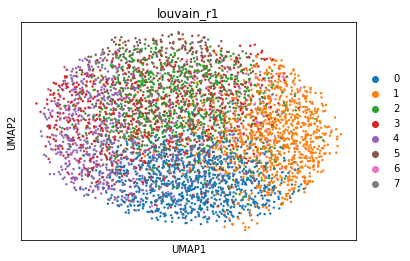

/home/emcandrew/anaconda3/envs/tf_latest/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


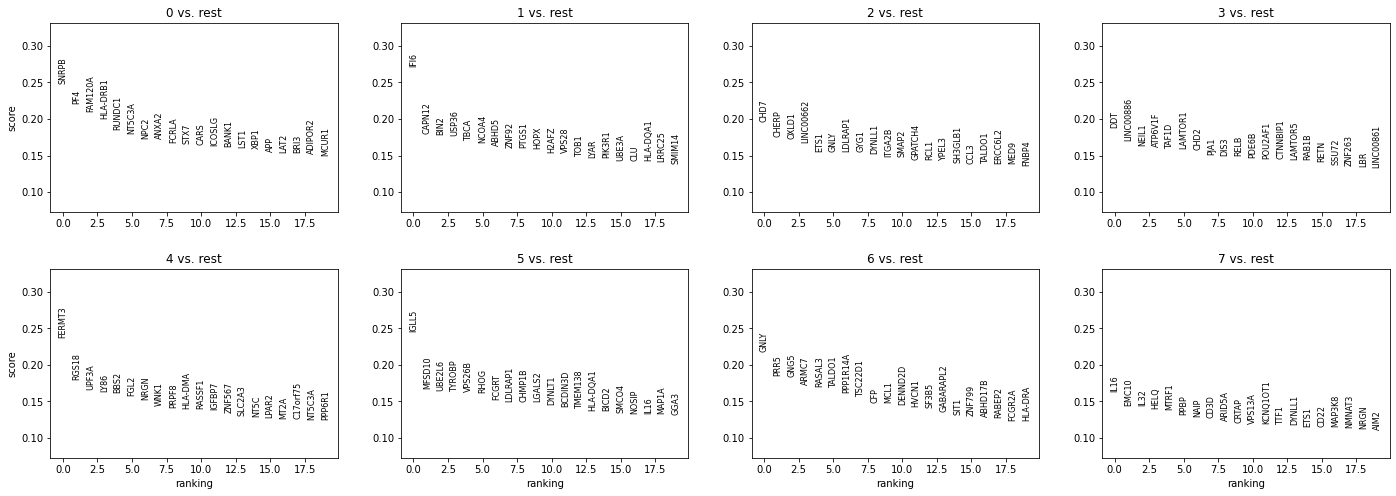

         Falling back to preprocessing with `sc.pp.pca` and default params.


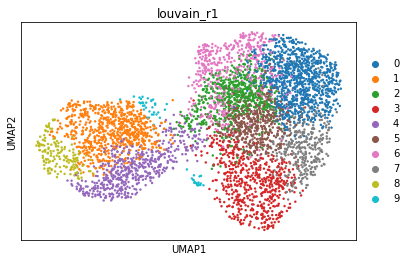

/home/emcandrew/anaconda3/envs/tf_latest/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


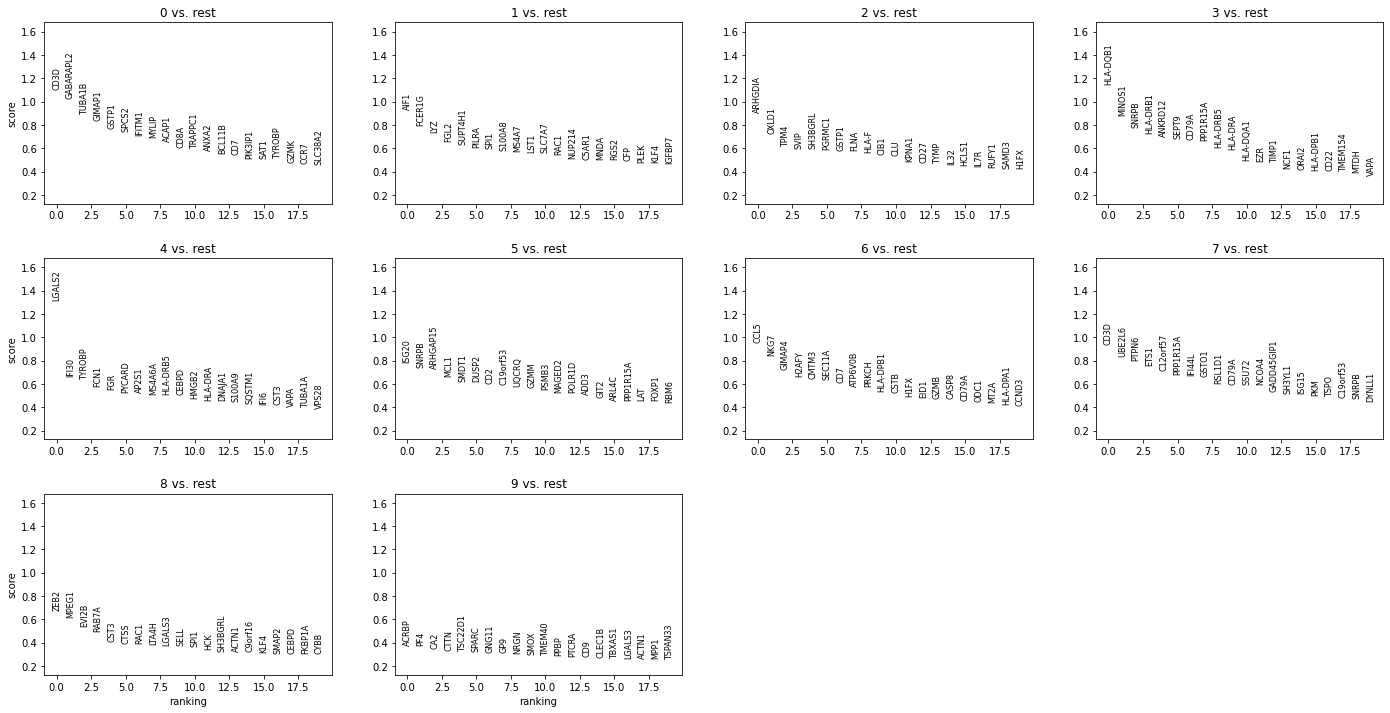

         Falling back to preprocessing with `sc.pp.pca` and default params.


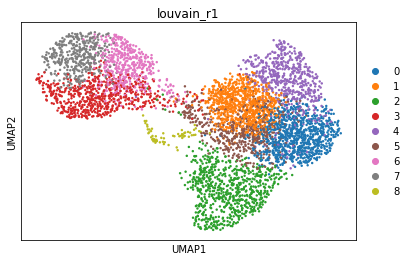

/home/emcandrew/anaconda3/envs/tf_latest/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


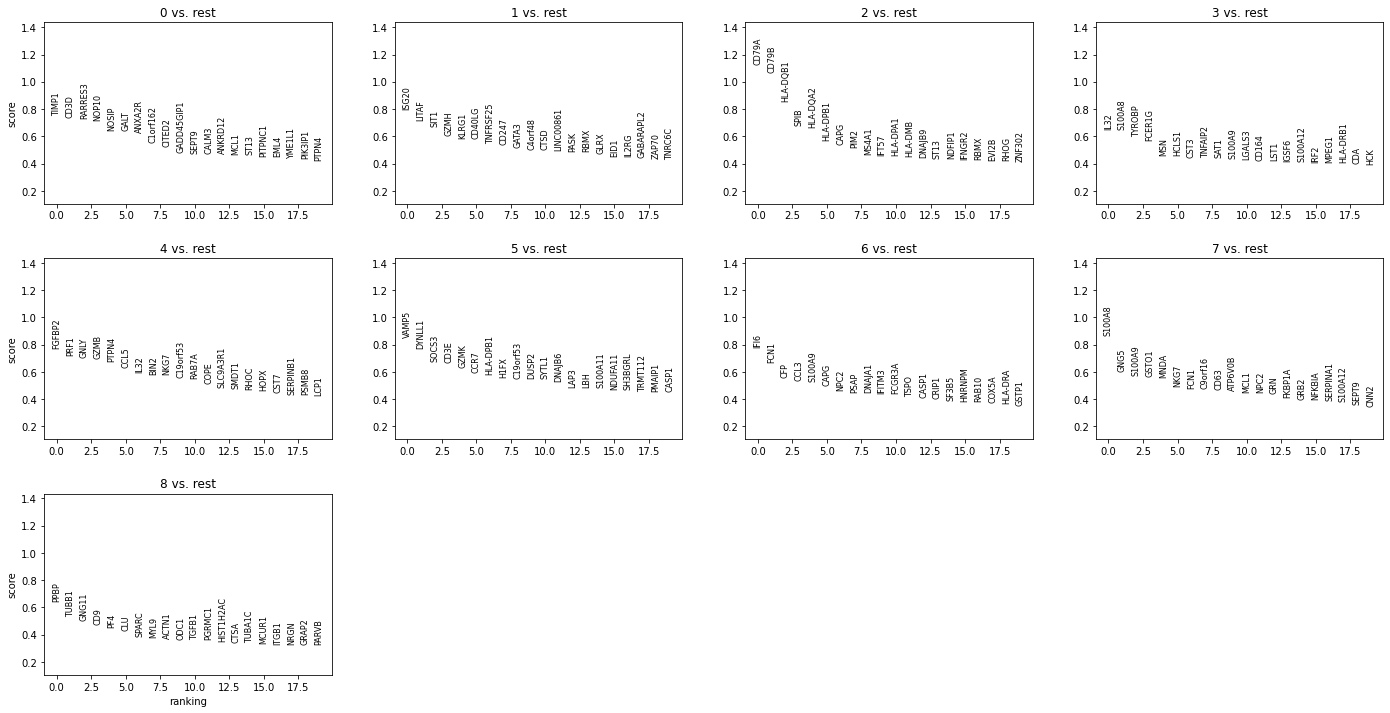

         Falling back to preprocessing with `sc.pp.pca` and default params.


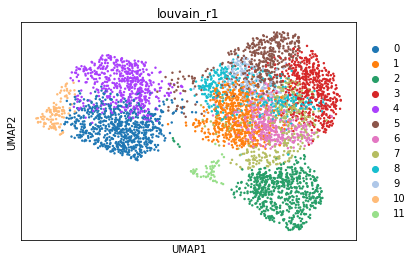

/home/emcandrew/anaconda3/envs/tf_latest/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


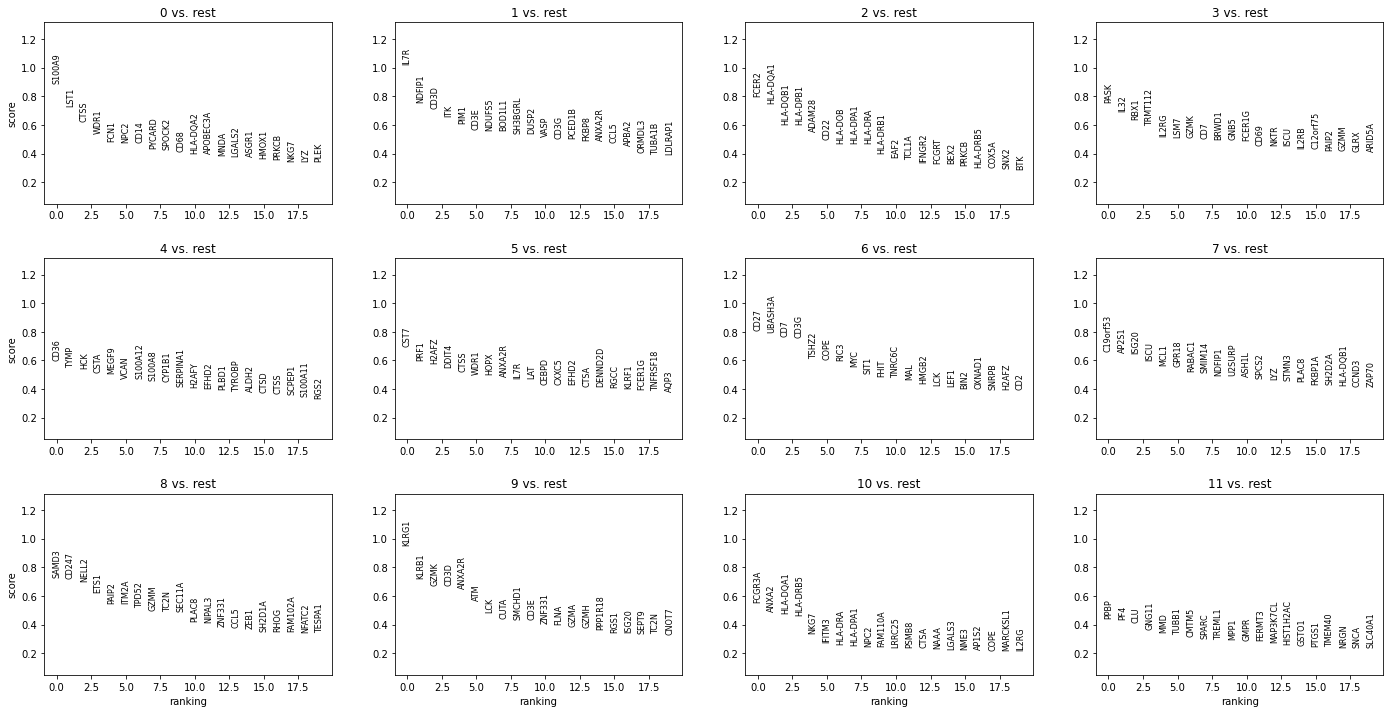

         Falling back to preprocessing with `sc.pp.pca` and default params.


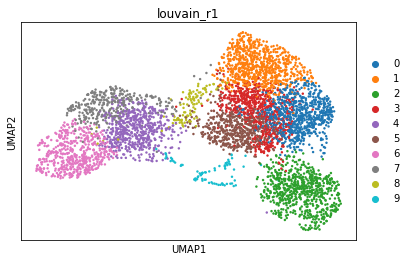

/home/emcandrew/anaconda3/envs/tf_latest/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


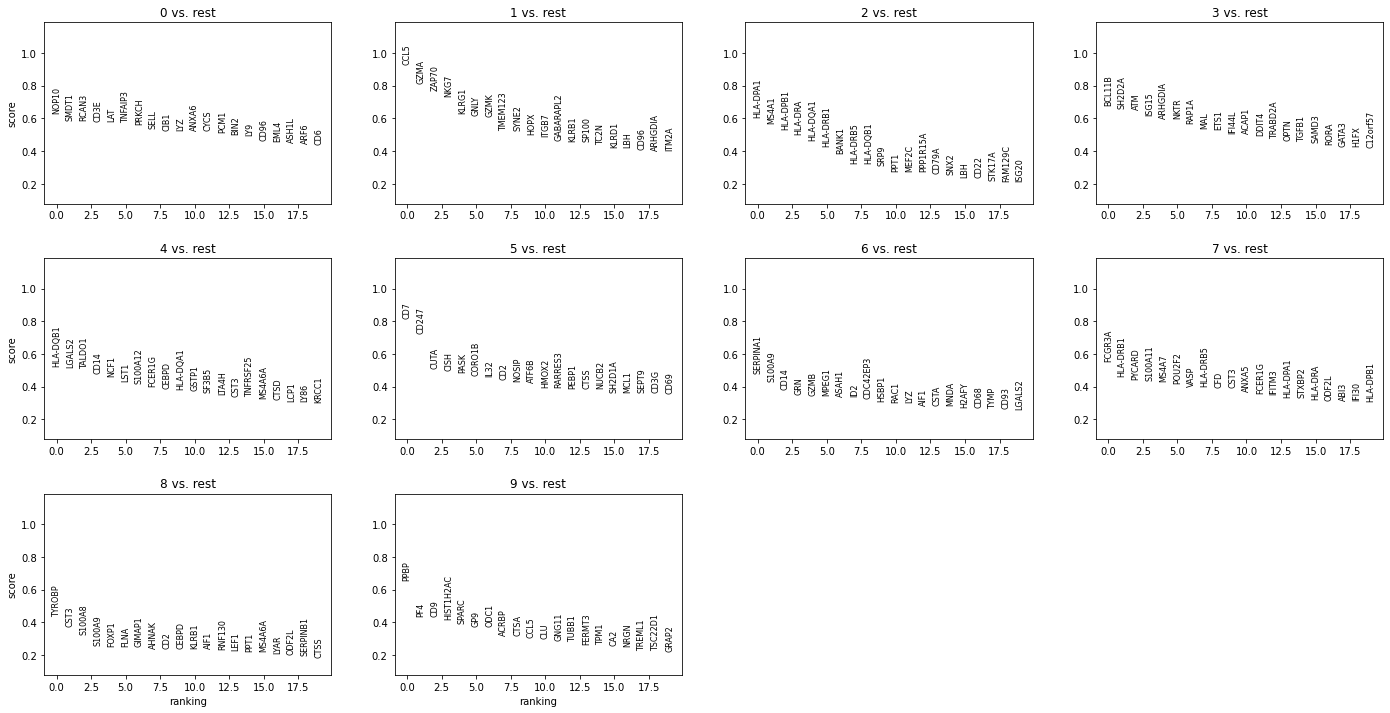

         Falling back to preprocessing with `sc.pp.pca` and default params.


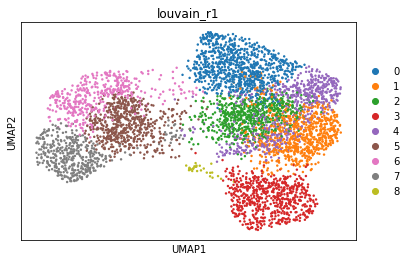

/home/emcandrew/anaconda3/envs/tf_latest/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


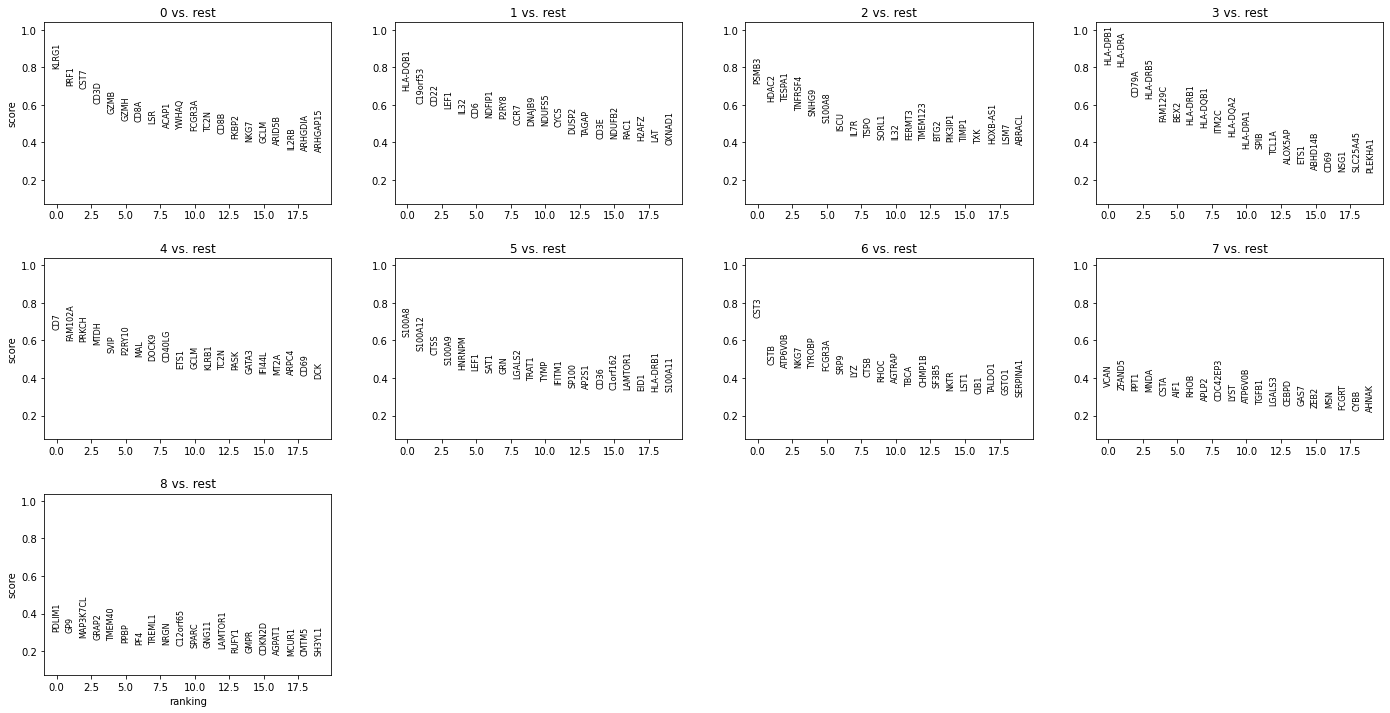

         Falling back to preprocessing with `sc.pp.pca` and default params.


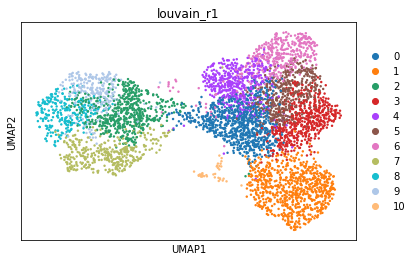

/home/emcandrew/anaconda3/envs/tf_latest/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


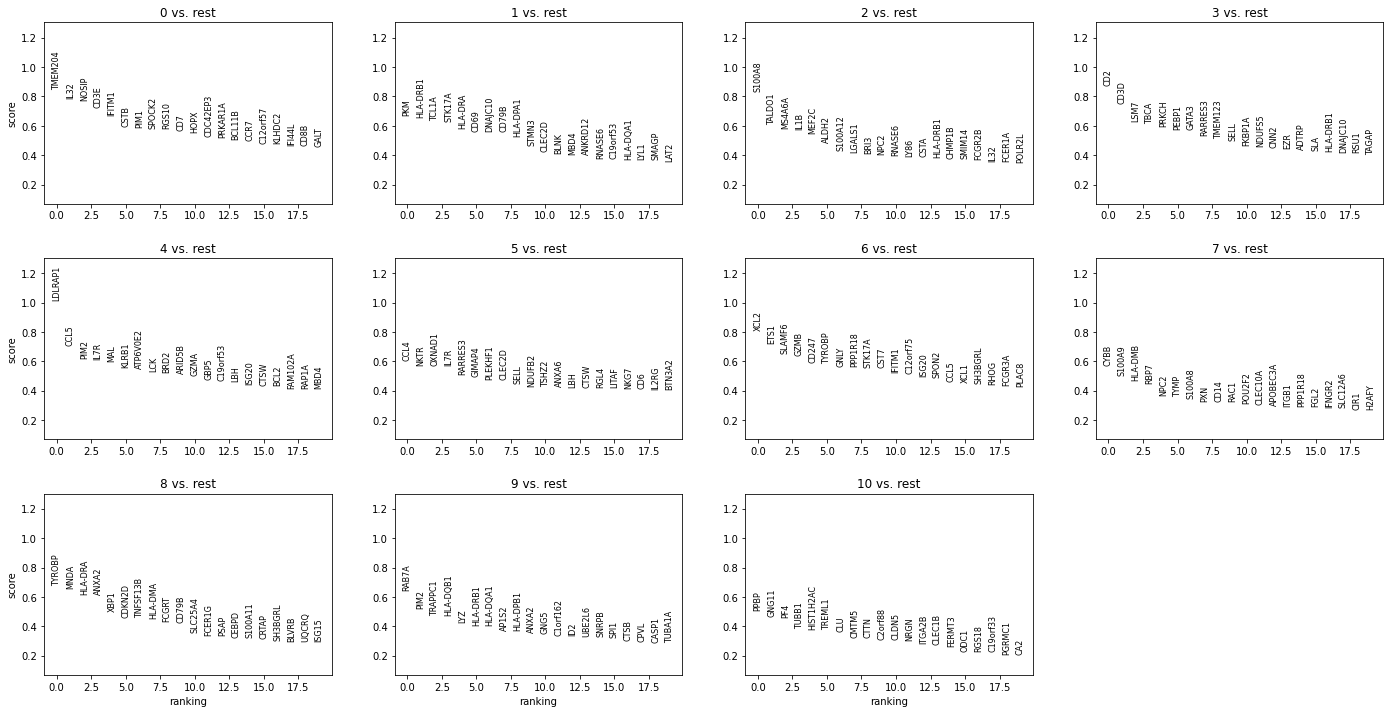

In [8]:
 for dataset in Generated_cells :
     test = dataset
     adata = sc.AnnData(test)
     adata.X
     sc.pp.neighbors(adata)
     sc.tl.umap(adata)
     sc.tl.louvain(adata, resolution=1, key_added='louvain_r1')
     sc.pl.umap(adata, color='louvain_r1')
     sc.tl.rank_genes_groups(adata, 'louvain_r1', method='logreg')
     sc.pl.rank_genes_groups(adata, n_genes=20)
     result = adata.uns['rank_genes_groups']
     groups = result['names'].dtype.names
     pd.DataFrame({group + '_' + key[:1]: result[key][group]
         for group in groups for key in ['names', 'scores']}).head(10)